In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import Pythoncf as pcf ## My custom Library 

In [2]:
# Implementing feature Hasher 
def featurehasher(df,col,n_features,input_type):
    from sklearn.feature_extraction import FeatureHasher
    i=0
    j=0
    for var in col:
        fh = FeatureHasher(n_features=n_features[i],input_type=input_type[j])
        hashed_features = fh.fit_transform(data[var])
        hashed_features = pd.DataFrame(hashed_features.toarray())
        column_name=list(hashed_features.columns.values)
        new_column_name=[]
        for variable in column_name:
            variable= str(var)+str(variable)
            new_column_name.append(variable)
        new_names=dict(zip(column_name,new_column_name))
        hashed_features=hashed_features.rename(columns=new_names)
        df=pd.concat([df.drop([var],axis=1),hashed_features], axis=1)
        i=i+1
        j=j+1
    return df

In [3]:
# Importing the Dataset 
train=pd.read_csv('C://Users//raghu//Machine Hack(House Prices)//Predicting-House-Prices-In-Bengaluru-Train-Data.csv')
test=pd.read_csv('C://Users//raghu//Machine Hack(House Prices)//Predicting-House-Prices-In-Bengaluru-Test-Data.csv')

In [4]:
# Concatenating the Training and Testing DataSet to perform the same transformation on both DataSet 
train['train/test']='train'
train['train/test']=train['train/test'].map(str)+train.index.map(str) # To identify the training and testing rows 
test['train/test']='test'
test['train/test']=test['train/test'].map(str)+test.index.map(str) # # To identify the training and testing rows 

data=pd.concat([train.drop('price',axis=1),test.drop('price',axis=1)],axis=0)
data.reset_index(inplace=True,drop=True)
data.head()

area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony train/test  
0  Coomee        1056   2.0      1.0     train0  
1  Theanmp       2600   5.0      3.0     train1  
2      NaN       1440   2.0      3.0     train2  
3  Soiewre       1521   3.0      1.0     train3  
4      NaN       1200   2.0      1.0     train4

In [5]:
# Transfromations on Dataframe to extract some more information 
# Functions like replace_category3,replace_category7,replace_category10,replace_category4 are from my Custom Library
# They are used to replace null values by different categories present in the feature also maintaining their distribution.
## My Library will also be attached with this document. 

a=data.availability.apply(lambda x: re.search('\d{2}', x))
avail_date=pd.DataFrame(a.dropna().apply(lambda x: x.group())) 
avail_date.rename(columns={'availability':'avail_date'},inplace=True)
data=pd.concat([data,avail_date],join='outer',axis=1)
data['Ready_to_move']=data.availability.apply(lambda x: 1 if((x=="Ready To Move")or(x=="Immediate Possession")) else 0)
# data.drop('availability',axis=1,inplace=True)
data.availability=data.availability.replace(to_replace="Immediate Possession", value="Ready To Move")

# Area_type
data['area_type']=data['area_type'].replace(to_replace='Carpet  Area', value=np.NaN)
data=pcf.replace_category3(data,'area_type','Super built-up  Area','Built-up  Area','Plot  Area')

# Size
data['size']=data['size'].replace(to_replace=r'\b[a-zA-Z]{7}\b', value='BHK',regex=True)
data['size']=data['size'].replace(to_replace=['18 BHK','19 BHK','12 BHK','13 BHK','14 BHK','16 BHK','27 BHK','43 BHK','11 BHK','1 RK','10 BHK'], value=np.NAN)
data=pcf.replace_category7(data,'size','2 BHK','3 BHK','4 BHK','1 BHK','5 BHK','6 BHK','7 BHK')  

# Bathroom 
list3=[]
for var in data['bath'].value_counts().index:
    if(len(data['bath'][data['bath']==var])<10):
        list3.append(var)
data['bath']=data['bath'].replace(to_replace=list3, value=np.NaN)
data=pcf.replace_category10(data,'bath',2.0,3.0,4.0,1.0,5.0,6.0,7.0,8.0,9.0,10.0)

# Balcony 
data=pcf.replace_category4(data,'balcony',2.0,1.0,3.0,0.0)

# Some other 
data['avail_date']=data['avail_date'].fillna(0)
data.society=data.society.fillna(value="NIL")
data.location=data.location.fillna(data.location.mode()[0])


In [6]:
data.head()

area_type   availability                  location   size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II  2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 BHK   
2        Built-up  Area  Ready To Move               Uttarahalli  3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli  3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur  2 BHK   

   society total_sqft  bath  balcony train/test avail_date  Ready_to_move  
0  Coomee        1056   2.0      1.0     train0         19              0  
1  Theanmp       2600   5.0      3.0     train1          0              1  
2      NIL       1440   2.0      3.0     train2          0              1  
3  Soiewre       1521   3.0      1.0     train3          0              1  
4      NIL       1200   2.0      1.0     train4          0              1

In [7]:
cat=['area_type','size','bath','balcony']
for var in cat:
    data=pcf.create_dummies(data,var)

In [8]:
data.head()

availability                  location  society total_sqft train/test  \
0         19-Dec  Electronic City Phase II  Coomee        1056     train0   
1  Ready To Move          Chikka Tirupathi  Theanmp       2600     train1   
2  Ready To Move               Uttarahalli      NIL       1440     train2   
3  Ready To Move        Lingadheeranahalli  Soiewre       1521     train3   
4  Ready To Move                  Kothanur      NIL       1200     train4   

  avail_date  Ready_to_move  area_type_Plot  Area  \
0         19              0                     0   
1          0              1                     1   
2          0              1                     0   
3          0              1                     0   
4          0              1                     0   

   area_type_Super built-up  Area  size_2 BHK     ...       bath_4.0  \
0                               1           1     ...              0   
1                               0           0     ...              0   
2                               0           0     ...              0   
3                               1           0     ...              0   
4                               1           1     ...              0   

   bath_5.0  bath_6.0  bath_7.0  bath_8.0  bath_9.0  bath_10.0  balcony_1.0  \
0         0         0         0         0         0          0            1   
1         1         0         0         0         0          0            0   
2         0         0         0         0         0          0            0   
3         0         0         0         0         0          0            1   
4         0         0         0         0         0          0            1   

   balcony_2.0  balcony_3.0  
0            0            0  
1            0            1  
2            0            1  
3            0            0  
4            0            0  

[5 rows x 29 columns]

In [9]:
# Applying Feature Hashing 
data=featurehasher(data,['location','availability','society'],[80,20,100],['string','string','string'])

In [10]:
# Converting 'total_sqft' and 'avail_date' into float type 
data['total_sqft']=data['total_sqft'].apply(lambda x: re.search(r'^[0-9]+',x).group())
var=['total_sqft','avail_date']
for vari in var:
    data[var]=data[var].astype(float)

In [11]:
data.head()

total_sqft train/test  avail_date  Ready_to_move  area_type_Plot  Area  \
0      1056.0     train0        19.0              0                     0   
1      2600.0     train1         0.0              1                     1   
2      1440.0     train2         0.0              1                     0   
3      1521.0     train3         0.0              1                     0   
4      1200.0     train4         0.0              1                     0   

   area_type_Super built-up  Area  size_2 BHK  size_3 BHK  size_4 BHK  \
0                               1           1           0           0   
1                               0           0           0           1   
2                               0           0           1           0   
3                               1           0           1           0   
4                               1           1           0           0   

   size_5 BHK    ...      society90  society91  society92  society93  \
0           0    ...            0.0        0.0        0.0        0.0   
1           0    ...            0.0        0.0        0.0        0.0   
2           0    ...            0.0        0.0        0.0        0.0   
3           0    ...            0.0        0.0        0.0        0.0   
4           0    ...            0.0        0.0        0.0        0.0   

   society94  society95  society96  society97  society98  society99  
0        0.0        0.0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0        0.0        0.0  

[5 rows x 226 columns]

In [12]:
# Extracting test rows/test data  from the dataframe 
test=data[data['train/test'].str.contains('test')]
test.set_index('train/test',drop=True,inplace=True)
test.head()

total_sqft  avail_date  Ready_to_move  area_type_Plot  Area  \
train/test                                                                
test0           1225.0         0.0              1                     0   
test1           2400.0         0.0              1                     1   
test2           1650.0        18.0              0                     1   
test3           1322.0         0.0              1                     0   
test4           1161.0         0.0              1                     0   

            area_type_Super built-up  Area  size_2 BHK  size_3 BHK  \
train/test                                                           
test0                                    1           1           0   
test1                                    0           0           0   
test2                                    0           0           0   
test3                                    1           0           1   
test4                                    1           1           0   

            size_4 BHK  size_5 BHK  size_6 BHK    ...      society90  \
train/test                                        ...                  
test0                0           0           0    ...            0.0   
test1                0           0           0    ...            0.0   
test2                1           0           0    ...            0.0   
test3                0           0           0    ...            0.0   
test4                0           0           0    ...            0.0   

            society91  society92  society93  society94  society95  society96  \
train/test                                                                     
test0             0.0        1.0        0.0        0.0        0.0        0.0   
test1             0.0        0.0        0.0        0.0        0.0        0.0   
test2             0.0        0.0        0.0        0.0        0.0        0.0   
test3             0.0        0.0        0.0        0.0        0.0        0.0   
test4             0.0        0.0        0.0        0.0        0.0        0.0   

            society97  society98  society99  
train/test                                   
test0             0.0        0.0        0.0  
test1             0.0        0.0        0.0  
test2             0.0        0.0        0.0  
test3             0.0        0.0        0.0  
test4             0.0        0.0        0.0  

[5 rows x 225 columns]

In [13]:
# Extracting Training Data 
train=pd.concat([data[data['train/test'].str.contains('train')].set_index('train/test'),train.set_index('train/test').price],join='inner',axis=1)
train.head()

total_sqft  avail_date  Ready_to_move  area_type_Plot  Area  \
train/test                                                                
train0          1056.0        19.0              0                     0   
train1          2600.0         0.0              1                     1   
train2          1440.0         0.0              1                     0   
train3          1521.0         0.0              1                     0   
train4          1200.0         0.0              1                     0   

            area_type_Super built-up  Area  size_2 BHK  size_3 BHK  \
train/test                                                           
train0                                   1           1           0   
train1                                   0           0           0   
train2                                   0           0           1   
train3                                   1           0           1   
train4                                   1           1           0   

            size_4 BHK  size_5 BHK  size_6 BHK   ...    society91  society92  \
train/test                                       ...                           
train0               0           0           0   ...          0.0        0.0   
train1               1           0           0   ...          0.0        0.0   
train2               0           0           0   ...          0.0        0.0   
train3               0           0           0   ...          0.0        0.0   
train4               0           0           0   ...          0.0        0.0   

            society93  society94  society95  society96  society97  society98  \
train/test                                                                     
train0            0.0        0.0        0.0        0.0        0.0        0.0   
train1            0.0        0.0        0.0        0.0        0.0        0.0   
train2            0.0        0.0        0.0        0.0        0.0        0.0   
train3            0.0        0.0        0.0        0.0        0.0        0.0   
train4            0.0        0.0        0.0        0.0        0.0        0.0   

            society99   price  
train/test                     
train0            0.0   39.07  
train1            0.0  120.00  
train2            0.0   62.00  
train3            0.0   95.00  
train4            0.0   51.00  

[5 rows x 226 columns]

C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


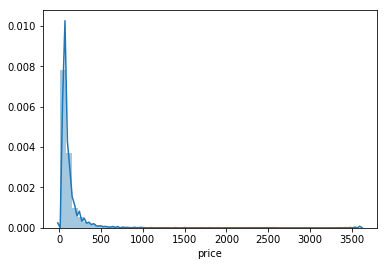

In [14]:
# Visualizing y-variable before outlier capping 
sns.distplot(train.price)

In [15]:
# Outlier Capping at 1 and 99 percentile on the y-variable 
train.price=train.price.clip_upper(train.price.quantile(.99))
train.price=train.price.clip_lower(train.price.quantile(.01))

C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


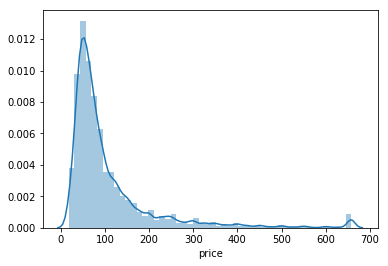

In [16]:
sns.distplot(train.price) # Visualizing y-variable before BoxCox transformation

In [17]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox
a,b = boxcox(train.price)
train.price=boxcox(train.price,lmbda=b)

C:\Users\raghu\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


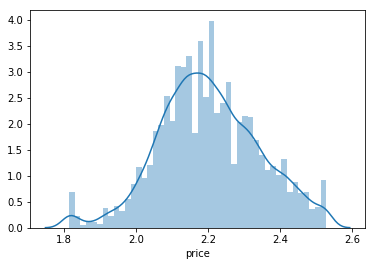

In [18]:
sns.distplot(train.price) # Visualing y- variable 

In [19]:
#Creating a training set for modeling and validation set to check model performance
X = train.drop(['price'], axis=1)
y = train['price']

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=1234)

C:\Users\raghu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
from sklearn.model_selection import GridSearchCV 

In [43]:
# params = {'depth': [5, 6, 7],
#           'learning_rate' : [0.06, 0.07, 0.08],
#          'l2_leaf_reg': [9,10,11],
#          'iterations': [500]}
# model = GridSearchCV(CatBoostRegressor(loss_function='RMSE',early_stopping_rounds=8),params,cv = 3)
# model.fit(X_train,y_train)

0:	learn: 2.0775006	total: 50.5ms	remaining: 25.2s
1:	learn: 1.9543364	total: 86.3ms	remaining: 21.5s
2:	learn: 1.8384137	total: 122ms	remaining: 20.2s
3:	learn: 1.7296722	total: 159ms	remaining: 19.7s
4:	learn: 1.6273771	total: 193ms	remaining: 19.2s
5:	learn: 1.5309449	total: 229ms	remaining: 18.9s
6:	learn: 1.4402357	total: 267ms	remaining: 18.8s
7:	learn: 1.3554641	total: 307ms	remaining: 18.9s
8:	learn: 1.2758133	total: 350ms	remaining: 19.1s
9:	learn: 1.2011307	total: 397ms	remaining: 19.4s
10:	learn: 1.1309023	total: 436ms	remaining: 19.4s
11:	learn: 1.0644338	total: 475ms	remaining: 19.3s
12:	learn: 1.0020507	total: 525ms	remaining: 19.7s
13:	learn: 0.9434506	total: 566ms	remaining: 19.6s
14:	learn: 0.8881184	total: 597ms	remaining: 19.3s
15:	learn: 0.8364416	total: 635ms	remaining: 19.2s
16:	learn: 0.7877277	total: 673ms	remaining: 19.1s
17:	learn: 0.7421120	total: 713ms	remaining: 19.1s
18:	learn: 0.6992993	total: 755ms	remaining: 19.1s
19:	learn: 0.6591181	total: 806ms	remai

164:	learn: 0.0740071	total: 8.39s	remaining: 17s
165:	learn: 0.0739896	total: 8.45s	remaining: 17s
166:	learn: 0.0739332	total: 8.5s	remaining: 16.9s
167:	learn: 0.0738847	total: 8.54s	remaining: 16.9s
168:	learn: 0.0738285	total: 8.58s	remaining: 16.8s
169:	learn: 0.0736389	total: 8.64s	remaining: 16.8s
170:	learn: 0.0735772	total: 8.68s	remaining: 16.7s
171:	learn: 0.0735254	total: 8.73s	remaining: 16.7s
172:	learn: 0.0734512	total: 8.8s	remaining: 16.6s
173:	learn: 0.0734188	total: 8.85s	remaining: 16.6s
174:	learn: 0.0733688	total: 8.91s	remaining: 16.5s
175:	learn: 0.0733284	total: 8.95s	remaining: 16.5s
176:	learn: 0.0732922	total: 8.98s	remaining: 16.4s
177:	learn: 0.0732718	total: 9.03s	remaining: 16.3s
178:	learn: 0.0732527	total: 9.09s	remaining: 16.3s
179:	learn: 0.0732278	total: 9.15s	remaining: 16.3s
180:	learn: 0.0731686	total: 9.2s	remaining: 16.2s
181:	learn: 0.0731493	total: 9.26s	remaining: 16.2s
182:	learn: 0.0731179	total: 9.32s	remaining: 16.1s
183:	learn: 0.07308

327:	learn: 0.0686107	total: 16.5s	remaining: 8.67s
328:	learn: 0.0686018	total: 16.6s	remaining: 8.61s
329:	learn: 0.0685957	total: 16.6s	remaining: 8.56s
330:	learn: 0.0685922	total: 16.7s	remaining: 8.51s
331:	learn: 0.0685897	total: 16.7s	remaining: 8.45s
332:	learn: 0.0685508	total: 16.7s	remaining: 8.39s
333:	learn: 0.0685485	total: 16.8s	remaining: 8.34s
334:	learn: 0.0685361	total: 16.8s	remaining: 8.28s
335:	learn: 0.0685302	total: 16.8s	remaining: 8.22s
336:	learn: 0.0685254	total: 16.9s	remaining: 8.17s
337:	learn: 0.0685241	total: 16.9s	remaining: 8.11s
338:	learn: 0.0685044	total: 17s	remaining: 8.06s
339:	learn: 0.0684452	total: 17s	remaining: 8.01s
340:	learn: 0.0684350	total: 17.1s	remaining: 7.96s
341:	learn: 0.0684241	total: 17.1s	remaining: 7.91s
342:	learn: 0.0683403	total: 17.2s	remaining: 7.85s
343:	learn: 0.0683101	total: 17.2s	remaining: 7.8s
344:	learn: 0.0683044	total: 17.2s	remaining: 7.75s
345:	learn: 0.0683021	total: 17.3s	remaining: 7.69s
346:	learn: 0.068

487:	learn: 0.0660482	total: 24.3s	remaining: 597ms
488:	learn: 0.0660461	total: 24.3s	remaining: 548ms
489:	learn: 0.0660305	total: 24.4s	remaining: 498ms
490:	learn: 0.0660272	total: 24.5s	remaining: 448ms
491:	learn: 0.0660254	total: 24.5s	remaining: 398ms
492:	learn: 0.0660095	total: 24.6s	remaining: 349ms
493:	learn: 0.0660082	total: 24.6s	remaining: 299ms
494:	learn: 0.0660044	total: 24.6s	remaining: 249ms
495:	learn: 0.0660021	total: 24.7s	remaining: 199ms
496:	learn: 0.0660002	total: 24.7s	remaining: 149ms
497:	learn: 0.0659165	total: 24.8s	remaining: 99.6ms
498:	learn: 0.0659085	total: 24.8s	remaining: 49.8ms
499:	learn: 0.0657524	total: 24.9s	remaining: 0us
0:	learn: 2.0749344	total: 43.8ms	remaining: 21.9s
1:	learn: 1.9522268	total: 80.6ms	remaining: 20.1s
2:	learn: 1.8367473	total: 116ms	remaining: 19.1s
3:	learn: 1.7281806	total: 150ms	remaining: 18.6s
4:	learn: 1.6258460	total: 185ms	remaining: 18.3s
5:	learn: 1.5300241	total: 221ms	remaining: 18.2s
6:	learn: 1.4399316	to

153:	learn: 0.0752136	total: 7.58s	remaining: 17s
154:	learn: 0.0751877	total: 7.63s	remaining: 17s
155:	learn: 0.0751266	total: 7.67s	remaining: 16.9s
156:	learn: 0.0750997	total: 7.71s	remaining: 16.9s
157:	learn: 0.0750105	total: 7.75s	remaining: 16.8s
158:	learn: 0.0749781	total: 7.8s	remaining: 16.7s
159:	learn: 0.0749407	total: 7.85s	remaining: 16.7s
160:	learn: 0.0749145	total: 7.88s	remaining: 16.6s
161:	learn: 0.0748967	total: 7.92s	remaining: 16.5s
162:	learn: 0.0747816	total: 7.98s	remaining: 16.5s
163:	learn: 0.0747506	total: 8.03s	remaining: 16.5s
164:	learn: 0.0746180	total: 8.1s	remaining: 16.4s
165:	learn: 0.0744911	total: 8.15s	remaining: 16.4s
166:	learn: 0.0744584	total: 8.21s	remaining: 16.4s
167:	learn: 0.0744182	total: 8.27s	remaining: 16.3s
168:	learn: 0.0744014	total: 8.32s	remaining: 16.3s
169:	learn: 0.0743618	total: 8.37s	remaining: 16.3s
170:	learn: 0.0743429	total: 8.43s	remaining: 16.2s
171:	learn: 0.0743287	total: 8.49s	remaining: 16.2s
172:	learn: 0.0742

312:	learn: 0.0698186	total: 15.1s	remaining: 9.01s
313:	learn: 0.0697685	total: 15.1s	remaining: 8.96s
314:	learn: 0.0697583	total: 15.2s	remaining: 8.91s
315:	learn: 0.0697557	total: 15.2s	remaining: 8.86s
316:	learn: 0.0697268	total: 15.3s	remaining: 8.8s
317:	learn: 0.0697207	total: 15.3s	remaining: 8.75s
318:	learn: 0.0697186	total: 15.4s	remaining: 8.72s
319:	learn: 0.0697134	total: 15.4s	remaining: 8.67s
320:	learn: 0.0697053	total: 15.5s	remaining: 8.63s
321:	learn: 0.0696958	total: 15.5s	remaining: 8.59s
322:	learn: 0.0695772	total: 15.6s	remaining: 8.55s
323:	learn: 0.0695692	total: 15.7s	remaining: 8.51s
324:	learn: 0.0695657	total: 15.7s	remaining: 8.47s
325:	learn: 0.0695539	total: 15.8s	remaining: 8.42s
326:	learn: 0.0695445	total: 15.8s	remaining: 8.38s
327:	learn: 0.0695278	total: 15.9s	remaining: 8.33s
328:	learn: 0.0695240	total: 15.9s	remaining: 8.29s
329:	learn: 0.0695212	total: 16s	remaining: 8.25s
330:	learn: 0.0695170	total: 16.1s	remaining: 8.2s
331:	learn: 0.06

472:	learn: 0.0672647	total: 23.5s	remaining: 1.34s
473:	learn: 0.0672534	total: 23.6s	remaining: 1.29s
474:	learn: 0.0672512	total: 23.6s	remaining: 1.24s
475:	learn: 0.0672478	total: 23.6s	remaining: 1.19s
476:	learn: 0.0672232	total: 23.7s	remaining: 1.14s
477:	learn: 0.0672214	total: 23.7s	remaining: 1.09s
478:	learn: 0.0671845	total: 23.8s	remaining: 1.04s
479:	learn: 0.0671839	total: 23.8s	remaining: 992ms
480:	learn: 0.0671827	total: 23.8s	remaining: 942ms
481:	learn: 0.0671235	total: 23.9s	remaining: 892ms
482:	learn: 0.0671021	total: 23.9s	remaining: 842ms
483:	learn: 0.0671006	total: 24s	remaining: 792ms
484:	learn: 0.0670970	total: 24s	remaining: 743ms
485:	learn: 0.0670560	total: 24.1s	remaining: 693ms
486:	learn: 0.0670526	total: 24.1s	remaining: 643ms
487:	learn: 0.0670507	total: 24.2s	remaining: 594ms
488:	learn: 0.0670492	total: 24.2s	remaining: 545ms
489:	learn: 0.0670455	total: 24.3s	remaining: 495ms
490:	learn: 0.0670271	total: 24.3s	remaining: 446ms
491:	learn: 0.06

133:	learn: 0.0767158	total: 6.47s	remaining: 17.7s
134:	learn: 0.0766580	total: 6.53s	remaining: 17.7s
135:	learn: 0.0766304	total: 6.58s	remaining: 17.6s
136:	learn: 0.0764922	total: 6.63s	remaining: 17.6s
137:	learn: 0.0764627	total: 6.68s	remaining: 17.5s
138:	learn: 0.0763329	total: 6.74s	remaining: 17.5s
139:	learn: 0.0762789	total: 6.79s	remaining: 17.5s
140:	learn: 0.0762084	total: 6.83s	remaining: 17.4s
141:	learn: 0.0761376	total: 6.88s	remaining: 17.3s
142:	learn: 0.0760903	total: 6.94s	remaining: 17.3s
143:	learn: 0.0760525	total: 7s	remaining: 17.3s
144:	learn: 0.0759872	total: 7.04s	remaining: 17.2s
145:	learn: 0.0759111	total: 7.09s	remaining: 17.2s
146:	learn: 0.0758487	total: 7.15s	remaining: 17.2s
147:	learn: 0.0757865	total: 7.2s	remaining: 17.1s
148:	learn: 0.0757546	total: 7.25s	remaining: 17.1s
149:	learn: 0.0757256	total: 7.3s	remaining: 17s
150:	learn: 0.0756382	total: 7.36s	remaining: 17s
151:	learn: 0.0755105	total: 7.41s	remaining: 17s
152:	learn: 0.0754745	t

295:	learn: 0.0703888	total: 14.7s	remaining: 10.2s
296:	learn: 0.0703565	total: 14.8s	remaining: 10.1s
297:	learn: 0.0703520	total: 14.9s	remaining: 10.1s
298:	learn: 0.0703475	total: 14.9s	remaining: 10s
299:	learn: 0.0703435	total: 15s	remaining: 9.97s
300:	learn: 0.0703395	total: 15s	remaining: 9.92s
301:	learn: 0.0703310	total: 15.1s	remaining: 9.87s
302:	learn: 0.0703274	total: 15.1s	remaining: 9.82s
303:	learn: 0.0703227	total: 15.1s	remaining: 9.77s
304:	learn: 0.0703083	total: 15.2s	remaining: 9.72s
305:	learn: 0.0702440	total: 15.3s	remaining: 9.67s
306:	learn: 0.0701710	total: 15.3s	remaining: 9.62s
307:	learn: 0.0700292	total: 15.3s	remaining: 9.57s
308:	learn: 0.0700256	total: 15.4s	remaining: 9.52s
309:	learn: 0.0700212	total: 15.5s	remaining: 9.47s
310:	learn: 0.0700178	total: 15.5s	remaining: 9.42s
311:	learn: 0.0700143	total: 15.5s	remaining: 9.37s
312:	learn: 0.0700053	total: 15.6s	remaining: 9.32s
313:	learn: 0.0700010	total: 15.7s	remaining: 9.27s
314:	learn: 0.0699

454:	learn: 0.0682033	total: 22.6s	remaining: 2.24s
455:	learn: 0.0681858	total: 22.7s	remaining: 2.19s
456:	learn: 0.0681838	total: 22.7s	remaining: 2.14s
457:	learn: 0.0681811	total: 22.8s	remaining: 2.09s
458:	learn: 0.0681808	total: 22.8s	remaining: 2.04s
459:	learn: 0.0681511	total: 22.9s	remaining: 1.99s
460:	learn: 0.0681506	total: 22.9s	remaining: 1.94s
461:	learn: 0.0681437	total: 23s	remaining: 1.89s
462:	learn: 0.0681424	total: 23s	remaining: 1.84s
463:	learn: 0.0681409	total: 23.1s	remaining: 1.79s
464:	learn: 0.0681401	total: 23.1s	remaining: 1.74s
465:	learn: 0.0681380	total: 23.2s	remaining: 1.69s
466:	learn: 0.0681360	total: 23.2s	remaining: 1.64s
467:	learn: 0.0681344	total: 23.3s	remaining: 1.59s
468:	learn: 0.0681158	total: 23.4s	remaining: 1.54s
469:	learn: 0.0680895	total: 23.4s	remaining: 1.49s
470:	learn: 0.0680849	total: 23.5s	remaining: 1.44s
471:	learn: 0.0680826	total: 23.5s	remaining: 1.39s
472:	learn: 0.0680802	total: 23.5s	remaining: 1.34s
473:	learn: 0.06

115:	learn: 0.0763070	total: 5.53s	remaining: 18.3s
116:	learn: 0.0762510	total: 5.58s	remaining: 18.3s
117:	learn: 0.0762190	total: 5.63s	remaining: 18.2s
118:	learn: 0.0761787	total: 5.68s	remaining: 18.2s
119:	learn: 0.0759938	total: 5.73s	remaining: 18.1s
120:	learn: 0.0759537	total: 5.79s	remaining: 18.1s
121:	learn: 0.0758740	total: 5.83s	remaining: 18.1s
122:	learn: 0.0757771	total: 5.88s	remaining: 18s
123:	learn: 0.0756999	total: 5.92s	remaining: 18s
124:	learn: 0.0756197	total: 5.97s	remaining: 17.9s
125:	learn: 0.0755831	total: 6.03s	remaining: 17.9s
126:	learn: 0.0755694	total: 6.07s	remaining: 17.8s
127:	learn: 0.0754324	total: 6.12s	remaining: 17.8s
128:	learn: 0.0754107	total: 6.18s	remaining: 17.8s
129:	learn: 0.0753709	total: 6.23s	remaining: 17.7s
130:	learn: 0.0753311	total: 6.28s	remaining: 17.7s
131:	learn: 0.0751384	total: 6.32s	remaining: 17.6s
132:	learn: 0.0750465	total: 6.37s	remaining: 17.6s
133:	learn: 0.0750178	total: 6.42s	remaining: 17.5s
134:	learn: 0.07

276:	learn: 0.0694433	total: 13.2s	remaining: 10.6s
277:	learn: 0.0694294	total: 13.3s	remaining: 10.6s
278:	learn: 0.0693683	total: 13.3s	remaining: 10.5s
279:	learn: 0.0693281	total: 13.4s	remaining: 10.5s
280:	learn: 0.0693240	total: 13.4s	remaining: 10.4s
281:	learn: 0.0693203	total: 13.5s	remaining: 10.4s
282:	learn: 0.0693149	total: 13.5s	remaining: 10.4s
283:	learn: 0.0692976	total: 13.5s	remaining: 10.3s
284:	learn: 0.0692922	total: 13.6s	remaining: 10.3s
285:	learn: 0.0692863	total: 13.6s	remaining: 10.2s
286:	learn: 0.0692719	total: 13.7s	remaining: 10.2s
287:	learn: 0.0692157	total: 13.7s	remaining: 10.1s
288:	learn: 0.0691448	total: 13.7s	remaining: 10s
289:	learn: 0.0691341	total: 13.8s	remaining: 9.98s
290:	learn: 0.0691215	total: 13.8s	remaining: 9.93s
291:	learn: 0.0691182	total: 13.9s	remaining: 9.88s
292:	learn: 0.0690974	total: 13.9s	remaining: 9.82s
293:	learn: 0.0690871	total: 13.9s	remaining: 9.76s
294:	learn: 0.0690662	total: 14s	remaining: 9.71s
295:	learn: 0.06

439:	learn: 0.0667790	total: 20.9s	remaining: 2.85s
440:	learn: 0.0667702	total: 21s	remaining: 2.8s
441:	learn: 0.0667664	total: 21s	remaining: 2.76s
442:	learn: 0.0667659	total: 21.1s	remaining: 2.71s
443:	learn: 0.0667626	total: 21.1s	remaining: 2.66s
444:	learn: 0.0667597	total: 21.2s	remaining: 2.61s
445:	learn: 0.0667582	total: 21.2s	remaining: 2.57s
446:	learn: 0.0667573	total: 21.2s	remaining: 2.52s
447:	learn: 0.0667518	total: 21.3s	remaining: 2.47s
448:	learn: 0.0667497	total: 21.3s	remaining: 2.42s
449:	learn: 0.0667445	total: 21.4s	remaining: 2.38s
450:	learn: 0.0667428	total: 21.4s	remaining: 2.33s
451:	learn: 0.0666110	total: 21.5s	remaining: 2.28s
452:	learn: 0.0666072	total: 21.5s	remaining: 2.23s
453:	learn: 0.0666059	total: 21.6s	remaining: 2.19s
454:	learn: 0.0665959	total: 21.6s	remaining: 2.14s
455:	learn: 0.0665905	total: 21.7s	remaining: 2.09s
456:	learn: 0.0665864	total: 21.7s	remaining: 2.04s
457:	learn: 0.0665650	total: 21.8s	remaining: 2s
458:	learn: 0.066561

104:	learn: 0.0776740	total: 4.57s	remaining: 17.2s
105:	learn: 0.0776322	total: 4.62s	remaining: 17.2s
106:	learn: 0.0775151	total: 4.67s	remaining: 17.2s
107:	learn: 0.0774582	total: 4.72s	remaining: 17.1s
108:	learn: 0.0774273	total: 4.76s	remaining: 17.1s
109:	learn: 0.0773391	total: 4.82s	remaining: 17.1s
110:	learn: 0.0771901	total: 4.87s	remaining: 17.1s
111:	learn: 0.0771511	total: 4.92s	remaining: 17.1s
112:	learn: 0.0770405	total: 4.97s	remaining: 17s
113:	learn: 0.0769872	total: 5.02s	remaining: 17s
114:	learn: 0.0769485	total: 5.08s	remaining: 17s
115:	learn: 0.0768913	total: 5.12s	remaining: 17s
116:	learn: 0.0768554	total: 5.17s	remaining: 16.9s
117:	learn: 0.0767752	total: 5.22s	remaining: 16.9s
118:	learn: 0.0767397	total: 5.28s	remaining: 16.9s
119:	learn: 0.0767059	total: 5.32s	remaining: 16.9s
120:	learn: 0.0765902	total: 5.37s	remaining: 16.8s
121:	learn: 0.0765297	total: 5.43s	remaining: 16.8s
122:	learn: 0.0764715	total: 5.48s	remaining: 16.8s
123:	learn: 0.076431

268:	learn: 0.0709592	total: 12.3s	remaining: 10.6s
269:	learn: 0.0709175	total: 12.4s	remaining: 10.6s
270:	learn: 0.0708912	total: 12.4s	remaining: 10.5s
271:	learn: 0.0708743	total: 12.5s	remaining: 10.5s
272:	learn: 0.0708685	total: 12.5s	remaining: 10.4s
273:	learn: 0.0708667	total: 12.6s	remaining: 10.4s
274:	learn: 0.0708505	total: 12.6s	remaining: 10.3s
275:	learn: 0.0708429	total: 12.6s	remaining: 10.3s
276:	learn: 0.0708287	total: 12.7s	remaining: 10.2s
277:	learn: 0.0708217	total: 12.7s	remaining: 10.2s
278:	learn: 0.0708106	total: 12.8s	remaining: 10.1s
279:	learn: 0.0708033	total: 12.8s	remaining: 10.1s
280:	learn: 0.0707891	total: 12.9s	remaining: 10s
281:	learn: 0.0707746	total: 12.9s	remaining: 10s
282:	learn: 0.0706669	total: 13s	remaining: 9.95s
283:	learn: 0.0706436	total: 13s	remaining: 9.9s
284:	learn: 0.0706382	total: 13s	remaining: 9.84s
285:	learn: 0.0705071	total: 13.1s	remaining: 9.79s
286:	learn: 0.0705003	total: 13.1s	remaining: 9.75s
287:	learn: 0.0704903	t

430:	learn: 0.0679339	total: 20.2s	remaining: 3.24s
431:	learn: 0.0679329	total: 20.3s	remaining: 3.19s
432:	learn: 0.0679308	total: 20.3s	remaining: 3.14s
433:	learn: 0.0679262	total: 20.3s	remaining: 3.09s
434:	learn: 0.0678673	total: 20.4s	remaining: 3.04s
435:	learn: 0.0678283	total: 20.4s	remaining: 3s
436:	learn: 0.0678265	total: 20.5s	remaining: 2.95s
437:	learn: 0.0678124	total: 20.5s	remaining: 2.9s
438:	learn: 0.0678083	total: 20.6s	remaining: 2.86s
439:	learn: 0.0677320	total: 20.6s	remaining: 2.81s
440:	learn: 0.0677291	total: 20.6s	remaining: 2.76s
441:	learn: 0.0677260	total: 20.7s	remaining: 2.72s
442:	learn: 0.0677226	total: 20.8s	remaining: 2.67s
443:	learn: 0.0677196	total: 20.8s	remaining: 2.62s
444:	learn: 0.0677114	total: 20.9s	remaining: 2.58s
445:	learn: 0.0677107	total: 20.9s	remaining: 2.53s
446:	learn: 0.0677001	total: 20.9s	remaining: 2.48s
447:	learn: 0.0676978	total: 21s	remaining: 2.43s
448:	learn: 0.0676910	total: 21s	remaining: 2.39s
449:	learn: 0.067688

93:	learn: 0.0782936	total: 4.52s	remaining: 19.5s
94:	learn: 0.0780715	total: 4.58s	remaining: 19.5s
95:	learn: 0.0780169	total: 4.64s	remaining: 19.5s
96:	learn: 0.0779487	total: 4.69s	remaining: 19.5s
97:	learn: 0.0778610	total: 4.73s	remaining: 19.4s
98:	learn: 0.0778021	total: 4.79s	remaining: 19.4s
99:	learn: 0.0777578	total: 4.84s	remaining: 19.4s
100:	learn: 0.0776679	total: 4.89s	remaining: 19.3s
101:	learn: 0.0776067	total: 4.93s	remaining: 19.3s
102:	learn: 0.0775454	total: 4.99s	remaining: 19.2s
103:	learn: 0.0774137	total: 5.05s	remaining: 19.2s
104:	learn: 0.0773448	total: 5.1s	remaining: 19.2s
105:	learn: 0.0772785	total: 5.16s	remaining: 19.2s
106:	learn: 0.0771476	total: 5.21s	remaining: 19.1s
107:	learn: 0.0771016	total: 5.26s	remaining: 19.1s
108:	learn: 0.0770522	total: 5.31s	remaining: 19.1s
109:	learn: 0.0769742	total: 5.37s	remaining: 19s
110:	learn: 0.0769002	total: 5.43s	remaining: 19s
111:	learn: 0.0768645	total: 5.48s	remaining: 19s
112:	learn: 0.0768322	tota

252:	learn: 0.0713818	total: 12.7s	remaining: 12.4s
253:	learn: 0.0713638	total: 12.8s	remaining: 12.4s
254:	learn: 0.0713598	total: 12.8s	remaining: 12.3s
255:	learn: 0.0713462	total: 12.9s	remaining: 12.3s
256:	learn: 0.0713372	total: 12.9s	remaining: 12.2s
257:	learn: 0.0713310	total: 13s	remaining: 12.2s
258:	learn: 0.0713027	total: 13s	remaining: 12.1s
259:	learn: 0.0711548	total: 13.1s	remaining: 12.1s
260:	learn: 0.0711475	total: 13.1s	remaining: 12s
261:	learn: 0.0710529	total: 13.2s	remaining: 12s
262:	learn: 0.0710488	total: 13.2s	remaining: 11.9s
263:	learn: 0.0710443	total: 13.3s	remaining: 11.9s
264:	learn: 0.0709789	total: 13.3s	remaining: 11.8s
265:	learn: 0.0709743	total: 13.4s	remaining: 11.8s
266:	learn: 0.0707868	total: 13.4s	remaining: 11.7s
267:	learn: 0.0707706	total: 13.5s	remaining: 11.7s
268:	learn: 0.0707617	total: 13.5s	remaining: 11.6s
269:	learn: 0.0707523	total: 13.6s	remaining: 11.6s
270:	learn: 0.0707445	total: 13.6s	remaining: 11.5s
271:	learn: 0.070640

413:	learn: 0.0676341	total: 20.7s	remaining: 4.29s
414:	learn: 0.0676320	total: 20.7s	remaining: 4.24s
415:	learn: 0.0676308	total: 20.8s	remaining: 4.19s
416:	learn: 0.0675768	total: 20.8s	remaining: 4.14s
417:	learn: 0.0675181	total: 20.9s	remaining: 4.09s
418:	learn: 0.0674455	total: 20.9s	remaining: 4.04s
419:	learn: 0.0674436	total: 21s	remaining: 4s
420:	learn: 0.0674427	total: 21s	remaining: 3.94s
421:	learn: 0.0674289	total: 21.1s	remaining: 3.9s
422:	learn: 0.0674279	total: 21.1s	remaining: 3.85s
423:	learn: 0.0674271	total: 21.2s	remaining: 3.8s
424:	learn: 0.0674221	total: 21.2s	remaining: 3.75s
425:	learn: 0.0674210	total: 21.3s	remaining: 3.69s
426:	learn: 0.0673917	total: 21.3s	remaining: 3.65s
427:	learn: 0.0673905	total: 21.4s	remaining: 3.6s
428:	learn: 0.0673856	total: 21.4s	remaining: 3.55s
429:	learn: 0.0673758	total: 21.5s	remaining: 3.5s
430:	learn: 0.0673709	total: 21.5s	remaining: 3.45s
431:	learn: 0.0673699	total: 21.6s	remaining: 3.4s
432:	learn: 0.0673562	to

77:	learn: 0.0791040	total: 3.59s	remaining: 19.4s
78:	learn: 0.0790197	total: 3.63s	remaining: 19.3s
79:	learn: 0.0788855	total: 3.68s	remaining: 19.3s
80:	learn: 0.0788110	total: 3.73s	remaining: 19.3s
81:	learn: 0.0786173	total: 3.78s	remaining: 19.3s
82:	learn: 0.0784608	total: 3.83s	remaining: 19.2s
83:	learn: 0.0783796	total: 3.89s	remaining: 19.2s
84:	learn: 0.0782128	total: 3.93s	remaining: 19.2s
85:	learn: 0.0781504	total: 3.98s	remaining: 19.2s
86:	learn: 0.0781105	total: 4.03s	remaining: 19.1s
87:	learn: 0.0780647	total: 4.08s	remaining: 19.1s
88:	learn: 0.0780040	total: 4.14s	remaining: 19.1s
89:	learn: 0.0777687	total: 4.19s	remaining: 19.1s
90:	learn: 0.0777311	total: 4.24s	remaining: 19.1s
91:	learn: 0.0776555	total: 4.31s	remaining: 19.1s
92:	learn: 0.0775483	total: 4.36s	remaining: 19.1s
93:	learn: 0.0773684	total: 4.4s	remaining: 19s
94:	learn: 0.0772599	total: 4.45s	remaining: 19s
95:	learn: 0.0771390	total: 4.51s	remaining: 19s
96:	learn: 0.0769303	total: 4.55s	rema

236:	learn: 0.0698352	total: 11.4s	remaining: 12.6s
237:	learn: 0.0698262	total: 11.4s	remaining: 12.6s
238:	learn: 0.0698200	total: 11.5s	remaining: 12.5s
239:	learn: 0.0698084	total: 11.5s	remaining: 12.5s
240:	learn: 0.0697959	total: 11.6s	remaining: 12.4s
241:	learn: 0.0697905	total: 11.6s	remaining: 12.4s
242:	learn: 0.0696215	total: 11.7s	remaining: 12.4s
243:	learn: 0.0696178	total: 11.7s	remaining: 12.3s
244:	learn: 0.0696109	total: 11.8s	remaining: 12.3s
245:	learn: 0.0695425	total: 11.8s	remaining: 12.2s
246:	learn: 0.0695393	total: 11.9s	remaining: 12.2s
247:	learn: 0.0695222	total: 11.9s	remaining: 12.1s
248:	learn: 0.0695179	total: 12s	remaining: 12.1s
249:	learn: 0.0695127	total: 12s	remaining: 12s
250:	learn: 0.0695049	total: 12.1s	remaining: 12s
251:	learn: 0.0695003	total: 12.1s	remaining: 11.9s
252:	learn: 0.0694916	total: 12.2s	remaining: 11.9s
253:	learn: 0.0693855	total: 12.2s	remaining: 11.9s
254:	learn: 0.0692635	total: 12.3s	remaining: 11.8s
255:	learn: 0.069259

398:	learn: 0.0662493	total: 19s	remaining: 4.81s
399:	learn: 0.0662441	total: 19s	remaining: 4.76s
400:	learn: 0.0662420	total: 19.1s	remaining: 4.71s
401:	learn: 0.0661908	total: 19.1s	remaining: 4.66s
402:	learn: 0.0661811	total: 19.2s	remaining: 4.61s
403:	learn: 0.0661792	total: 19.2s	remaining: 4.57s
404:	learn: 0.0661753	total: 19.3s	remaining: 4.52s
405:	learn: 0.0661717	total: 19.3s	remaining: 4.47s
406:	learn: 0.0661681	total: 19.3s	remaining: 4.42s
407:	learn: 0.0661651	total: 19.4s	remaining: 4.37s
408:	learn: 0.0661616	total: 19.4s	remaining: 4.32s
409:	learn: 0.0661589	total: 19.5s	remaining: 4.27s
410:	learn: 0.0661554	total: 19.5s	remaining: 4.22s
411:	learn: 0.0660509	total: 19.5s	remaining: 4.17s
412:	learn: 0.0660472	total: 19.6s	remaining: 4.13s
413:	learn: 0.0660440	total: 19.6s	remaining: 4.08s
414:	learn: 0.0660419	total: 19.7s	remaining: 4.03s
415:	learn: 0.0660364	total: 19.7s	remaining: 3.98s
416:	learn: 0.0660042	total: 19.8s	remaining: 3.93s
417:	learn: 0.06

62:	learn: 0.0829642	total: 2.69s	remaining: 18.7s
63:	learn: 0.0826459	total: 2.75s	remaining: 18.7s
64:	learn: 0.0823034	total: 2.8s	remaining: 18.8s
65:	learn: 0.0820383	total: 2.85s	remaining: 18.7s
66:	learn: 0.0818034	total: 2.91s	remaining: 18.8s
67:	learn: 0.0816061	total: 2.96s	remaining: 18.8s
68:	learn: 0.0812257	total: 3s	remaining: 18.8s
69:	learn: 0.0809034	total: 3.06s	remaining: 18.8s
70:	learn: 0.0805449	total: 3.12s	remaining: 18.8s
71:	learn: 0.0803409	total: 3.17s	remaining: 18.8s
72:	learn: 0.0800520	total: 3.21s	remaining: 18.8s
73:	learn: 0.0797848	total: 3.25s	remaining: 18.7s
74:	learn: 0.0796718	total: 3.29s	remaining: 18.6s
75:	learn: 0.0795823	total: 3.33s	remaining: 18.6s
76:	learn: 0.0794893	total: 3.36s	remaining: 18.5s
77:	learn: 0.0793668	total: 3.4s	remaining: 18.4s
78:	learn: 0.0792381	total: 3.44s	remaining: 18.3s
79:	learn: 0.0790945	total: 3.48s	remaining: 18.3s
80:	learn: 0.0790167	total: 3.52s	remaining: 18.2s
81:	learn: 0.0789393	total: 3.56s	re

223:	learn: 0.0712288	total: 10.5s	remaining: 12.9s
224:	learn: 0.0712138	total: 10.5s	remaining: 12.9s
225:	learn: 0.0712016	total: 10.6s	remaining: 12.8s
226:	learn: 0.0711979	total: 10.6s	remaining: 12.8s
227:	learn: 0.0710761	total: 10.6s	remaining: 12.7s
228:	learn: 0.0710144	total: 10.7s	remaining: 12.6s
229:	learn: 0.0709293	total: 10.7s	remaining: 12.6s
230:	learn: 0.0709146	total: 10.8s	remaining: 12.5s
231:	learn: 0.0709107	total: 10.8s	remaining: 12.5s
232:	learn: 0.0708999	total: 10.8s	remaining: 12.4s
233:	learn: 0.0708923	total: 10.9s	remaining: 12.4s
234:	learn: 0.0708146	total: 10.9s	remaining: 12.3s
235:	learn: 0.0707848	total: 11s	remaining: 12.3s
236:	learn: 0.0707809	total: 11s	remaining: 12.2s
237:	learn: 0.0707786	total: 11.1s	remaining: 12.2s
238:	learn: 0.0707702	total: 11.1s	remaining: 12.2s
239:	learn: 0.0707597	total: 11.2s	remaining: 12.1s
240:	learn: 0.0707516	total: 11.2s	remaining: 12.1s
241:	learn: 0.0707326	total: 11.3s	remaining: 12s
242:	learn: 0.0707

383:	learn: 0.0685935	total: 18.4s	remaining: 5.57s
384:	learn: 0.0685928	total: 18.5s	remaining: 5.52s
385:	learn: 0.0685915	total: 18.5s	remaining: 5.47s
386:	learn: 0.0685878	total: 18.6s	remaining: 5.43s
387:	learn: 0.0685838	total: 18.6s	remaining: 5.38s
388:	learn: 0.0684598	total: 18.7s	remaining: 5.33s
389:	learn: 0.0684586	total: 18.7s	remaining: 5.28s
390:	learn: 0.0684578	total: 18.8s	remaining: 5.24s
391:	learn: 0.0684563	total: 18.8s	remaining: 5.18s
392:	learn: 0.0684548	total: 18.9s	remaining: 5.13s
393:	learn: 0.0683894	total: 18.9s	remaining: 5.08s
394:	learn: 0.0683860	total: 18.9s	remaining: 5.03s
395:	learn: 0.0683825	total: 19s	remaining: 4.98s
396:	learn: 0.0683147	total: 19s	remaining: 4.93s
397:	learn: 0.0683103	total: 19.1s	remaining: 4.88s
398:	learn: 0.0682343	total: 19.1s	remaining: 4.83s
399:	learn: 0.0682333	total: 19.1s	remaining: 4.78s
400:	learn: 0.0682289	total: 19.2s	remaining: 4.73s
401:	learn: 0.0682263	total: 19.2s	remaining: 4.68s
402:	learn: 0.06

43:	learn: 0.1087338	total: 1.83s	remaining: 18.9s
44:	learn: 0.1059347	total: 1.89s	remaining: 19.1s
45:	learn: 0.1034379	total: 1.93s	remaining: 19s
46:	learn: 0.1012235	total: 1.96s	remaining: 18.9s
47:	learn: 0.0985777	total: 2s	remaining: 18.9s
48:	learn: 0.0968681	total: 2.06s	remaining: 18.9s
49:	learn: 0.0947779	total: 2.11s	remaining: 19s
50:	learn: 0.0932739	total: 2.16s	remaining: 19s
51:	learn: 0.0920321	total: 2.21s	remaining: 19s
52:	learn: 0.0907273	total: 2.25s	remaining: 19s
53:	learn: 0.0893912	total: 2.31s	remaining: 19.1s
54:	learn: 0.0882196	total: 2.36s	remaining: 19.1s
55:	learn: 0.0871282	total: 2.41s	remaining: 19.1s
56:	learn: 0.0863308	total: 2.45s	remaining: 19.1s
57:	learn: 0.0855267	total: 2.5s	remaining: 19s
58:	learn: 0.0849777	total: 2.55s	remaining: 19.1s
59:	learn: 0.0845356	total: 2.61s	remaining: 19.1s
60:	learn: 0.0841155	total: 2.66s	remaining: 19.1s
61:	learn: 0.0836556	total: 2.71s	remaining: 19.1s
62:	learn: 0.0832892	total: 2.76s	remaining: 19

207:	learn: 0.0725587	total: 9.7s	remaining: 13.6s
208:	learn: 0.0724042	total: 9.75s	remaining: 13.6s
209:	learn: 0.0723941	total: 9.8s	remaining: 13.5s
210:	learn: 0.0723812	total: 9.85s	remaining: 13.5s
211:	learn: 0.0723762	total: 9.89s	remaining: 13.4s
212:	learn: 0.0723159	total: 9.94s	remaining: 13.4s
213:	learn: 0.0722960	total: 9.99s	remaining: 13.4s
214:	learn: 0.0720442	total: 10s	remaining: 13.3s
215:	learn: 0.0719976	total: 10.1s	remaining: 13.3s
216:	learn: 0.0719915	total: 10.1s	remaining: 13.2s
217:	learn: 0.0719882	total: 10.2s	remaining: 13.2s
218:	learn: 0.0719582	total: 10.2s	remaining: 13.1s
219:	learn: 0.0719537	total: 10.3s	remaining: 13.1s
220:	learn: 0.0719478	total: 10.3s	remaining: 13s
221:	learn: 0.0719364	total: 10.4s	remaining: 13s
222:	learn: 0.0719161	total: 10.4s	remaining: 13s
223:	learn: 0.0717600	total: 10.5s	remaining: 12.9s
224:	learn: 0.0717528	total: 10.5s	remaining: 12.9s
225:	learn: 0.0717490	total: 10.6s	remaining: 12.9s
226:	learn: 0.0717436	

368:	learn: 0.0677542	total: 17.6s	remaining: 6.25s
369:	learn: 0.0677455	total: 17.7s	remaining: 6.21s
370:	learn: 0.0677429	total: 17.7s	remaining: 6.16s
371:	learn: 0.0677350	total: 17.8s	remaining: 6.11s
372:	learn: 0.0677307	total: 17.8s	remaining: 6.06s
373:	learn: 0.0677282	total: 17.9s	remaining: 6.02s
374:	learn: 0.0677191	total: 17.9s	remaining: 5.97s
375:	learn: 0.0676337	total: 18s	remaining: 5.92s
376:	learn: 0.0676255	total: 18s	remaining: 5.88s
377:	learn: 0.0674992	total: 18.1s	remaining: 5.83s
378:	learn: 0.0674852	total: 18.1s	remaining: 5.78s
379:	learn: 0.0674151	total: 18.2s	remaining: 5.74s
380:	learn: 0.0674135	total: 18.2s	remaining: 5.69s
381:	learn: 0.0674109	total: 18.3s	remaining: 5.64s
382:	learn: 0.0674021	total: 18.3s	remaining: 5.59s
383:	learn: 0.0673995	total: 18.4s	remaining: 5.55s
384:	learn: 0.0673960	total: 18.4s	remaining: 5.5s
385:	learn: 0.0673882	total: 18.5s	remaining: 5.45s
386:	learn: 0.0673866	total: 18.5s	remaining: 5.4s
387:	learn: 0.0673

28:	learn: 0.3935107	total: 1.1s	remaining: 17.8s
29:	learn: 0.3721761	total: 1.16s	remaining: 18.1s
30:	learn: 0.3518644	total: 1.21s	remaining: 18.2s
31:	learn: 0.3327846	total: 1.25s	remaining: 18.3s
32:	learn: 0.3150020	total: 1.3s	remaining: 18.4s
33:	learn: 0.2986417	total: 1.35s	remaining: 18.5s
34:	learn: 0.2834458	total: 1.4s	remaining: 18.6s
35:	learn: 0.2691000	total: 1.44s	remaining: 18.5s
36:	learn: 0.2556113	total: 1.48s	remaining: 18.6s
37:	learn: 0.2431164	total: 1.53s	remaining: 18.6s
38:	learn: 0.2308786	total: 1.58s	remaining: 18.6s
39:	learn: 0.2200971	total: 1.62s	remaining: 18.6s
40:	learn: 0.2095226	total: 1.67s	remaining: 18.6s
41:	learn: 0.2003778	total: 1.71s	remaining: 18.7s
42:	learn: 0.1913052	total: 1.77s	remaining: 18.8s
43:	learn: 0.1830660	total: 1.81s	remaining: 18.8s
44:	learn: 0.1750481	total: 1.86s	remaining: 18.8s
45:	learn: 0.1677738	total: 1.91s	remaining: 18.8s
46:	learn: 0.1607662	total: 1.96s	remaining: 18.9s
47:	learn: 0.1545849	total: 2.02s	

189:	learn: 0.0725972	total: 8.9s	remaining: 14.5s
190:	learn: 0.0725853	total: 8.96s	remaining: 14.5s
191:	learn: 0.0725166	total: 9.01s	remaining: 14.4s
192:	learn: 0.0724862	total: 9.05s	remaining: 14.4s
193:	learn: 0.0724643	total: 9.1s	remaining: 14.4s
194:	learn: 0.0724365	total: 9.16s	remaining: 14.3s
195:	learn: 0.0723992	total: 9.2s	remaining: 14.3s
196:	learn: 0.0723563	total: 9.25s	remaining: 14.2s
197:	learn: 0.0723410	total: 9.3s	remaining: 14.2s
198:	learn: 0.0722657	total: 9.36s	remaining: 14.2s
199:	learn: 0.0722234	total: 9.4s	remaining: 14.1s
200:	learn: 0.0722123	total: 9.45s	remaining: 14.1s
201:	learn: 0.0721934	total: 9.5s	remaining: 14s
202:	learn: 0.0721729	total: 9.55s	remaining: 14s
203:	learn: 0.0721602	total: 9.6s	remaining: 13.9s
204:	learn: 0.0721332	total: 9.65s	remaining: 13.9s
205:	learn: 0.0721139	total: 9.7s	remaining: 13.8s
206:	learn: 0.0720950	total: 9.76s	remaining: 13.8s
207:	learn: 0.0720767	total: 9.81s	remaining: 13.8s
208:	learn: 0.0720615	to

348:	learn: 0.0683642	total: 16.7s	remaining: 7.24s
349:	learn: 0.0683611	total: 16.8s	remaining: 7.2s
350:	learn: 0.0683485	total: 16.9s	remaining: 7.15s
351:	learn: 0.0683414	total: 16.9s	remaining: 7.11s
352:	learn: 0.0683375	total: 16.9s	remaining: 7.06s
353:	learn: 0.0683074	total: 17s	remaining: 7.01s
354:	learn: 0.0682542	total: 17.1s	remaining: 6.96s
355:	learn: 0.0682499	total: 17.1s	remaining: 6.92s
356:	learn: 0.0682413	total: 17.1s	remaining: 6.87s
357:	learn: 0.0682034	total: 17.2s	remaining: 6.82s
358:	learn: 0.0682000	total: 17.2s	remaining: 6.77s
359:	learn: 0.0681921	total: 17.3s	remaining: 6.72s
360:	learn: 0.0681691	total: 17.3s	remaining: 6.67s
361:	learn: 0.0681666	total: 17.4s	remaining: 6.63s
362:	learn: 0.0681623	total: 17.4s	remaining: 6.58s
363:	learn: 0.0681594	total: 17.5s	remaining: 6.53s
364:	learn: 0.0681559	total: 17.5s	remaining: 6.48s
365:	learn: 0.0681512	total: 17.6s	remaining: 6.44s
366:	learn: 0.0681395	total: 17.6s	remaining: 6.39s
367:	learn: 0.0

11:	learn: 1.0640579	total: 440ms	remaining: 17.9s
12:	learn: 1.0020449	total: 481ms	remaining: 18s
13:	learn: 0.9434223	total: 522ms	remaining: 18.1s
14:	learn: 0.8884775	total: 563ms	remaining: 18.2s
15:	learn: 0.8367485	total: 600ms	remaining: 18.1s
16:	learn: 0.7884135	total: 636ms	remaining: 18.1s
17:	learn: 0.7428368	total: 681ms	remaining: 18.2s
18:	learn: 0.7000533	total: 722ms	remaining: 18.3s
19:	learn: 0.6599165	total: 758ms	remaining: 18.2s
20:	learn: 0.6218957	total: 794ms	remaining: 18.1s
21:	learn: 0.5868841	total: 834ms	remaining: 18.1s
22:	learn: 0.5537928	total: 884ms	remaining: 18.3s
23:	learn: 0.5228987	total: 949ms	remaining: 18.8s
24:	learn: 0.4933023	total: 997ms	remaining: 18.9s
25:	learn: 0.4659617	total: 1.04s	remaining: 19s
26:	learn: 0.4403389	total: 1.1s	remaining: 19.2s
27:	learn: 0.4160923	total: 1.15s	remaining: 19.3s
28:	learn: 0.3934696	total: 1.19s	remaining: 19.4s
29:	learn: 0.3718886	total: 1.24s	remaining: 19.4s
30:	learn: 0.3519667	total: 1.29s	re

173:	learn: 0.0746961	total: 8.28s	remaining: 15.5s
174:	learn: 0.0746795	total: 8.33s	remaining: 15.5s
175:	learn: 0.0746405	total: 8.39s	remaining: 15.4s
176:	learn: 0.0745953	total: 8.44s	remaining: 15.4s
177:	learn: 0.0745693	total: 8.48s	remaining: 15.3s
178:	learn: 0.0745475	total: 8.53s	remaining: 15.3s
179:	learn: 0.0745303	total: 8.58s	remaining: 15.3s
180:	learn: 0.0745001	total: 8.63s	remaining: 15.2s
181:	learn: 0.0744104	total: 8.67s	remaining: 15.2s
182:	learn: 0.0743713	total: 8.73s	remaining: 15.1s
183:	learn: 0.0743491	total: 8.78s	remaining: 15.1s
184:	learn: 0.0743402	total: 8.82s	remaining: 15s
185:	learn: 0.0742896	total: 8.87s	remaining: 15s
186:	learn: 0.0742615	total: 8.92s	remaining: 14.9s
187:	learn: 0.0742365	total: 8.97s	remaining: 14.9s
188:	learn: 0.0742110	total: 9.02s	remaining: 14.8s
189:	learn: 0.0741887	total: 9.06s	remaining: 14.8s
190:	learn: 0.0741587	total: 9.12s	remaining: 14.7s
191:	learn: 0.0740881	total: 9.17s	remaining: 14.7s
192:	learn: 0.07

334:	learn: 0.0699074	total: 15.9s	remaining: 7.81s
335:	learn: 0.0699002	total: 15.9s	remaining: 7.75s
336:	learn: 0.0698902	total: 15.9s	remaining: 7.71s
337:	learn: 0.0698842	total: 16s	remaining: 7.65s
338:	learn: 0.0698509	total: 16s	remaining: 7.6s
339:	learn: 0.0698303	total: 16.1s	remaining: 7.56s
340:	learn: 0.0697875	total: 16.1s	remaining: 7.51s
341:	learn: 0.0697705	total: 16.2s	remaining: 7.47s
342:	learn: 0.0697671	total: 16.2s	remaining: 7.42s
343:	learn: 0.0697574	total: 16.3s	remaining: 7.37s
344:	learn: 0.0697521	total: 16.3s	remaining: 7.33s
345:	learn: 0.0697497	total: 16.4s	remaining: 7.29s
346:	learn: 0.0697254	total: 16.4s	remaining: 7.24s
347:	learn: 0.0697202	total: 16.5s	remaining: 7.19s
348:	learn: 0.0697143	total: 16.5s	remaining: 7.15s
349:	learn: 0.0696909	total: 16.6s	remaining: 7.1s
350:	learn: 0.0696845	total: 16.6s	remaining: 7.05s
351:	learn: 0.0696731	total: 16.7s	remaining: 7.01s
352:	learn: 0.0696629	total: 16.7s	remaining: 6.96s
353:	learn: 0.0696

493:	learn: 0.0681531	total: 24s	remaining: 291ms
494:	learn: 0.0681502	total: 24s	remaining: 242ms
495:	learn: 0.0681443	total: 24.1s	remaining: 194ms
496:	learn: 0.0681421	total: 24.1s	remaining: 145ms
497:	learn: 0.0681398	total: 24.1s	remaining: 97ms
498:	learn: 0.0681375	total: 24.2s	remaining: 48.5ms
499:	learn: 0.0681317	total: 24.3s	remaining: 0us
0:	learn: 2.0737361	total: 44.5ms	remaining: 22.2s
1:	learn: 1.9507955	total: 79ms	remaining: 19.7s
2:	learn: 1.8355424	total: 114ms	remaining: 18.9s
3:	learn: 1.7268553	total: 150ms	remaining: 18.5s
4:	learn: 1.6251644	total: 185ms	remaining: 18.3s
5:	learn: 1.5286587	total: 205ms	remaining: 16.9s
6:	learn: 1.4386804	total: 241ms	remaining: 17s
7:	learn: 1.3537605	total: 278ms	remaining: 17.1s
8:	learn: 1.2742553	total: 319ms	remaining: 17.4s
9:	learn: 1.1993492	total: 359ms	remaining: 17.6s
10:	learn: 1.1294146	total: 394ms	remaining: 17.5s
11:	learn: 1.0632432	total: 431ms	remaining: 17.5s
12:	learn: 1.0011283	total: 469ms	remainin

157:	learn: 0.0755589	total: 7.21s	remaining: 15.6s
158:	learn: 0.0755067	total: 7.26s	remaining: 15.6s
159:	learn: 0.0754733	total: 7.32s	remaining: 15.5s
160:	learn: 0.0754402	total: 7.37s	remaining: 15.5s
161:	learn: 0.0754072	total: 7.41s	remaining: 15.5s
162:	learn: 0.0753592	total: 7.47s	remaining: 15.4s
163:	learn: 0.0753272	total: 7.54s	remaining: 15.4s
164:	learn: 0.0752861	total: 7.58s	remaining: 15.4s
165:	learn: 0.0752515	total: 7.63s	remaining: 15.3s
166:	learn: 0.0751576	total: 7.69s	remaining: 15.3s
167:	learn: 0.0750097	total: 7.74s	remaining: 15.3s
168:	learn: 0.0749254	total: 7.79s	remaining: 15.3s
169:	learn: 0.0748936	total: 7.84s	remaining: 15.2s
170:	learn: 0.0748733	total: 7.89s	remaining: 15.2s
171:	learn: 0.0748474	total: 7.95s	remaining: 15.2s
172:	learn: 0.0747961	total: 7.99s	remaining: 15.1s
173:	learn: 0.0746965	total: 8.07s	remaining: 15.1s
174:	learn: 0.0746566	total: 8.12s	remaining: 15.1s
175:	learn: 0.0746294	total: 8.16s	remaining: 15s
176:	learn: 0.

320:	learn: 0.0697889	total: 15.1s	remaining: 8.43s
321:	learn: 0.0697772	total: 15.2s	remaining: 8.38s
322:	learn: 0.0696654	total: 15.2s	remaining: 8.33s
323:	learn: 0.0696620	total: 15.2s	remaining: 8.28s
324:	learn: 0.0696571	total: 15.3s	remaining: 8.22s
325:	learn: 0.0696228	total: 15.3s	remaining: 8.17s
326:	learn: 0.0695818	total: 15.4s	remaining: 8.12s
327:	learn: 0.0695688	total: 15.4s	remaining: 8.07s
328:	learn: 0.0695656	total: 15.4s	remaining: 8.02s
329:	learn: 0.0695561	total: 15.5s	remaining: 7.96s
330:	learn: 0.0695241	total: 15.5s	remaining: 7.92s
331:	learn: 0.0695207	total: 15.5s	remaining: 7.87s
332:	learn: 0.0695115	total: 15.6s	remaining: 7.81s
333:	learn: 0.0695077	total: 15.6s	remaining: 7.76s
334:	learn: 0.0694966	total: 15.6s	remaining: 7.71s
335:	learn: 0.0694913	total: 15.7s	remaining: 7.66s
336:	learn: 0.0694888	total: 15.7s	remaining: 7.61s
337:	learn: 0.0694733	total: 15.8s	remaining: 7.55s
338:	learn: 0.0694688	total: 15.8s	remaining: 7.5s
339:	learn: 0

483:	learn: 0.0677417	total: 23.1s	remaining: 762ms
484:	learn: 0.0677342	total: 23.1s	remaining: 715ms
485:	learn: 0.0677251	total: 23.2s	remaining: 668ms
486:	learn: 0.0677243	total: 23.2s	remaining: 620ms
487:	learn: 0.0676402	total: 23.3s	remaining: 572ms
488:	learn: 0.0676354	total: 23.3s	remaining: 525ms
489:	learn: 0.0676337	total: 23.4s	remaining: 477ms
490:	learn: 0.0676021	total: 23.4s	remaining: 429ms
491:	learn: 0.0675933	total: 23.5s	remaining: 382ms
492:	learn: 0.0674833	total: 23.5s	remaining: 334ms
493:	learn: 0.0674557	total: 23.6s	remaining: 286ms
494:	learn: 0.0674484	total: 23.6s	remaining: 239ms
495:	learn: 0.0674390	total: 23.7s	remaining: 191ms
496:	learn: 0.0674382	total: 23.7s	remaining: 143ms
497:	learn: 0.0673031	total: 23.8s	remaining: 95.5ms
498:	learn: 0.0672964	total: 23.8s	remaining: 47.7ms
499:	learn: 0.0672956	total: 23.9s	remaining: 0us
0:	learn: 2.0557066	total: 37.7ms	remaining: 18.8s
1:	learn: 1.9136405	total: 73.4ms	remaining: 18.3s
2:	learn: 1.78

144:	learn: 0.0745864	total: 6.4s	remaining: 15.7s
145:	learn: 0.0745620	total: 6.46s	remaining: 15.7s
146:	learn: 0.0743854	total: 6.51s	remaining: 15.6s
147:	learn: 0.0743683	total: 6.57s	remaining: 15.6s
148:	learn: 0.0742734	total: 6.63s	remaining: 15.6s
149:	learn: 0.0742532	total: 6.68s	remaining: 15.6s
150:	learn: 0.0741714	total: 6.73s	remaining: 15.6s
151:	learn: 0.0741016	total: 6.78s	remaining: 15.5s
152:	learn: 0.0740781	total: 6.84s	remaining: 15.5s
153:	learn: 0.0739932	total: 6.89s	remaining: 15.5s
154:	learn: 0.0739653	total: 6.94s	remaining: 15.4s
155:	learn: 0.0737687	total: 6.99s	remaining: 15.4s
156:	learn: 0.0737031	total: 7.05s	remaining: 15.4s
157:	learn: 0.0736720	total: 7.1s	remaining: 15.4s
158:	learn: 0.0735997	total: 7.15s	remaining: 15.3s
159:	learn: 0.0735676	total: 7.2s	remaining: 15.3s
160:	learn: 0.0735429	total: 7.25s	remaining: 15.3s
161:	learn: 0.0735241	total: 7.3s	remaining: 15.2s
162:	learn: 0.0734363	total: 7.35s	remaining: 15.2s
163:	learn: 0.07

303:	learn: 0.0688634	total: 14.1s	remaining: 9.11s
304:	learn: 0.0688275	total: 14.2s	remaining: 9.07s
305:	learn: 0.0688211	total: 14.2s	remaining: 9.03s
306:	learn: 0.0687988	total: 14.3s	remaining: 8.98s
307:	learn: 0.0687921	total: 14.4s	remaining: 8.95s
308:	learn: 0.0687830	total: 14.4s	remaining: 8.91s
309:	learn: 0.0687697	total: 14.5s	remaining: 8.87s
310:	learn: 0.0686590	total: 14.5s	remaining: 8.83s
311:	learn: 0.0686557	total: 14.6s	remaining: 8.79s
312:	learn: 0.0686528	total: 14.6s	remaining: 8.75s
313:	learn: 0.0686398	total: 14.7s	remaining: 8.71s
314:	learn: 0.0686039	total: 14.8s	remaining: 8.66s
315:	learn: 0.0685986	total: 14.8s	remaining: 8.62s
316:	learn: 0.0685889	total: 14.9s	remaining: 8.58s
317:	learn: 0.0685835	total: 14.9s	remaining: 8.53s
318:	learn: 0.0685807	total: 15s	remaining: 8.49s
319:	learn: 0.0685335	total: 15s	remaining: 8.45s
320:	learn: 0.0685065	total: 15.1s	remaining: 8.41s
321:	learn: 0.0685016	total: 15.1s	remaining: 8.37s
322:	learn: 0.06

466:	learn: 0.0659058	total: 22s	remaining: 1.55s
467:	learn: 0.0659047	total: 22s	remaining: 1.51s
468:	learn: 0.0658960	total: 22.1s	remaining: 1.46s
469:	learn: 0.0658931	total: 22.2s	remaining: 1.42s
470:	learn: 0.0658918	total: 22.3s	remaining: 1.37s
471:	learn: 0.0658869	total: 22.3s	remaining: 1.32s
472:	learn: 0.0658813	total: 22.3s	remaining: 1.27s
473:	learn: 0.0658782	total: 22.4s	remaining: 1.23s
474:	learn: 0.0658752	total: 22.4s	remaining: 1.18s
475:	learn: 0.0658717	total: 22.5s	remaining: 1.13s
476:	learn: 0.0658406	total: 22.5s	remaining: 1.08s
477:	learn: 0.0658377	total: 22.6s	remaining: 1.04s
478:	learn: 0.0657896	total: 22.6s	remaining: 992ms
479:	learn: 0.0657858	total: 22.7s	remaining: 946ms
480:	learn: 0.0657829	total: 22.8s	remaining: 899ms
481:	learn: 0.0657820	total: 22.8s	remaining: 851ms
482:	learn: 0.0657384	total: 22.8s	remaining: 804ms
483:	learn: 0.0657096	total: 22.9s	remaining: 756ms
484:	learn: 0.0657081	total: 22.9s	remaining: 709ms
485:	learn: 0.06

128:	learn: 0.0762610	total: 6.08s	remaining: 17.5s
129:	learn: 0.0761555	total: 6.12s	remaining: 17.4s
130:	learn: 0.0760962	total: 6.16s	remaining: 17.3s
131:	learn: 0.0760337	total: 6.19s	remaining: 17.3s
132:	learn: 0.0760047	total: 6.23s	remaining: 17.2s
133:	learn: 0.0759712	total: 6.27s	remaining: 17.1s
134:	learn: 0.0758862	total: 6.31s	remaining: 17.1s
135:	learn: 0.0758571	total: 6.35s	remaining: 17s
136:	learn: 0.0757914	total: 6.39s	remaining: 16.9s
137:	learn: 0.0757649	total: 6.44s	remaining: 16.9s
138:	learn: 0.0757334	total: 6.47s	remaining: 16.8s
139:	learn: 0.0756475	total: 6.52s	remaining: 16.8s
140:	learn: 0.0755724	total: 6.57s	remaining: 16.7s
141:	learn: 0.0754272	total: 6.61s	remaining: 16.7s
142:	learn: 0.0754077	total: 6.65s	remaining: 16.6s
143:	learn: 0.0753659	total: 6.69s	remaining: 16.5s
144:	learn: 0.0753198	total: 6.73s	remaining: 16.5s
145:	learn: 0.0752741	total: 6.77s	remaining: 16.4s
146:	learn: 0.0752137	total: 6.8s	remaining: 16.3s
147:	learn: 0.0

287:	learn: 0.0708474	total: 13.9s	remaining: 10.2s
288:	learn: 0.0708422	total: 14s	remaining: 10.2s
289:	learn: 0.0707943	total: 14s	remaining: 10.1s
290:	learn: 0.0707861	total: 14.1s	remaining: 10.1s
291:	learn: 0.0707811	total: 14.1s	remaining: 10s
292:	learn: 0.0707186	total: 14.2s	remaining: 10s
293:	learn: 0.0707167	total: 14.2s	remaining: 9.96s
294:	learn: 0.0707102	total: 14.3s	remaining: 9.9s
295:	learn: 0.0707073	total: 14.3s	remaining: 9.85s
296:	learn: 0.0705846	total: 14.4s	remaining: 9.81s
297:	learn: 0.0705804	total: 14.4s	remaining: 9.77s
298:	learn: 0.0705692	total: 14.5s	remaining: 9.72s
299:	learn: 0.0705622	total: 14.5s	remaining: 9.67s
300:	learn: 0.0705523	total: 14.6s	remaining: 9.62s
301:	learn: 0.0704885	total: 14.6s	remaining: 9.58s
302:	learn: 0.0704512	total: 14.7s	remaining: 9.53s
303:	learn: 0.0704492	total: 14.7s	remaining: 9.48s
304:	learn: 0.0704426	total: 14.7s	remaining: 9.43s
305:	learn: 0.0704221	total: 14.8s	remaining: 9.38s
306:	learn: 0.0704158

449:	learn: 0.0683008	total: 21.8s	remaining: 2.42s
450:	learn: 0.0682999	total: 21.8s	remaining: 2.37s
451:	learn: 0.0682961	total: 21.9s	remaining: 2.32s
452:	learn: 0.0682958	total: 21.9s	remaining: 2.27s
453:	learn: 0.0682932	total: 22s	remaining: 2.23s
454:	learn: 0.0682925	total: 22s	remaining: 2.18s
455:	learn: 0.0682693	total: 22.1s	remaining: 2.13s
456:	learn: 0.0682644	total: 22.1s	remaining: 2.08s
457:	learn: 0.0682551	total: 22.2s	remaining: 2.03s
458:	learn: 0.0682529	total: 22.2s	remaining: 1.98s
459:	learn: 0.0682127	total: 22.3s	remaining: 1.94s
460:	learn: 0.0681952	total: 22.3s	remaining: 1.89s
461:	learn: 0.0681912	total: 22.4s	remaining: 1.84s
462:	learn: 0.0681887	total: 22.4s	remaining: 1.79s
463:	learn: 0.0681818	total: 22.5s	remaining: 1.74s
464:	learn: 0.0681801	total: 22.5s	remaining: 1.7s
465:	learn: 0.0681658	total: 22.6s	remaining: 1.65s
466:	learn: 0.0681632	total: 22.6s	remaining: 1.6s
467:	learn: 0.0681566	total: 22.7s	remaining: 1.55s
468:	learn: 0.0681

113:	learn: 0.0772576	total: 5.33s	remaining: 18.1s
114:	learn: 0.0772075	total: 5.39s	remaining: 18.1s
115:	learn: 0.0771609	total: 5.44s	remaining: 18s
116:	learn: 0.0770826	total: 5.49s	remaining: 18s
117:	learn: 0.0769942	total: 5.54s	remaining: 17.9s
118:	learn: 0.0769108	total: 5.59s	remaining: 17.9s
119:	learn: 0.0768292	total: 5.64s	remaining: 17.9s
120:	learn: 0.0767176	total: 5.69s	remaining: 17.8s
121:	learn: 0.0766377	total: 5.75s	remaining: 17.8s
122:	learn: 0.0766017	total: 5.79s	remaining: 17.7s
123:	learn: 0.0765633	total: 5.83s	remaining: 17.7s
124:	learn: 0.0764933	total: 5.87s	remaining: 17.6s
125:	learn: 0.0764550	total: 5.92s	remaining: 17.6s
126:	learn: 0.0763768	total: 5.98s	remaining: 17.6s
127:	learn: 0.0763041	total: 6.02s	remaining: 17.5s
128:	learn: 0.0762100	total: 6.05s	remaining: 17.4s
129:	learn: 0.0761715	total: 6.09s	remaining: 17.3s
130:	learn: 0.0760880	total: 6.14s	remaining: 17.3s
131:	learn: 0.0760165	total: 6.19s	remaining: 17.3s
132:	learn: 0.07

272:	learn: 0.0707300	total: 13.1s	remaining: 10.9s
273:	learn: 0.0706017	total: 13.1s	remaining: 10.8s
274:	learn: 0.0705929	total: 13.2s	remaining: 10.8s
275:	learn: 0.0705344	total: 13.3s	remaining: 10.8s
276:	learn: 0.0705303	total: 13.3s	remaining: 10.7s
277:	learn: 0.0704304	total: 13.4s	remaining: 10.7s
278:	learn: 0.0704270	total: 13.4s	remaining: 10.6s
279:	learn: 0.0704137	total: 13.5s	remaining: 10.6s
280:	learn: 0.0704099	total: 13.5s	remaining: 10.5s
281:	learn: 0.0703956	total: 13.6s	remaining: 10.5s
282:	learn: 0.0702735	total: 13.6s	remaining: 10.4s
283:	learn: 0.0702685	total: 13.7s	remaining: 10.4s
284:	learn: 0.0702587	total: 13.7s	remaining: 10.3s
285:	learn: 0.0701271	total: 13.8s	remaining: 10.3s
286:	learn: 0.0699878	total: 13.8s	remaining: 10.2s
287:	learn: 0.0699198	total: 13.9s	remaining: 10.2s
288:	learn: 0.0698779	total: 13.9s	remaining: 10.2s
289:	learn: 0.0698680	total: 13.9s	remaining: 10.1s
290:	learn: 0.0698598	total: 14s	remaining: 10.1s
291:	learn: 0.

433:	learn: 0.0676563	total: 20.8s	remaining: 3.16s
434:	learn: 0.0676544	total: 20.9s	remaining: 3.12s
435:	learn: 0.0676518	total: 20.9s	remaining: 3.07s
436:	learn: 0.0676483	total: 20.9s	remaining: 3.02s
437:	learn: 0.0675595	total: 21s	remaining: 2.97s
438:	learn: 0.0675575	total: 21s	remaining: 2.92s
439:	learn: 0.0675549	total: 21.1s	remaining: 2.88s
440:	learn: 0.0675349	total: 21.1s	remaining: 2.83s
441:	learn: 0.0675307	total: 21.2s	remaining: 2.78s
442:	learn: 0.0675115	total: 21.2s	remaining: 2.73s
443:	learn: 0.0675103	total: 21.3s	remaining: 2.69s
444:	learn: 0.0674716	total: 21.3s	remaining: 2.64s
445:	learn: 0.0674641	total: 21.4s	remaining: 2.59s
446:	learn: 0.0674634	total: 21.4s	remaining: 2.54s
447:	learn: 0.0674612	total: 21.5s	remaining: 2.49s
448:	learn: 0.0674478	total: 21.5s	remaining: 2.45s
449:	learn: 0.0674461	total: 21.6s	remaining: 2.4s
450:	learn: 0.0674433	total: 21.6s	remaining: 2.35s
451:	learn: 0.0674369	total: 21.7s	remaining: 2.3s
452:	learn: 0.0674

94:	learn: 0.0777087	total: 4.6s	remaining: 19.6s
95:	learn: 0.0775854	total: 4.64s	remaining: 19.5s
96:	learn: 0.0773757	total: 4.68s	remaining: 19.4s
97:	learn: 0.0773305	total: 4.72s	remaining: 19.3s
98:	learn: 0.0772485	total: 4.75s	remaining: 19.2s
99:	learn: 0.0770606	total: 4.79s	remaining: 19.2s
100:	learn: 0.0769850	total: 4.83s	remaining: 19.1s
101:	learn: 0.0769461	total: 4.88s	remaining: 19.1s
102:	learn: 0.0769038	total: 4.93s	remaining: 19s
103:	learn: 0.0768464	total: 4.97s	remaining: 18.9s
104:	learn: 0.0767274	total: 5.03s	remaining: 18.9s
105:	learn: 0.0767036	total: 5.08s	remaining: 18.9s
106:	learn: 0.0765550	total: 5.13s	remaining: 18.8s
107:	learn: 0.0765206	total: 5.18s	remaining: 18.8s
108:	learn: 0.0762748	total: 5.24s	remaining: 18.8s
109:	learn: 0.0762463	total: 5.3s	remaining: 18.8s
110:	learn: 0.0761438	total: 5.34s	remaining: 18.7s
111:	learn: 0.0760306	total: 5.4s	remaining: 18.7s
112:	learn: 0.0759608	total: 5.46s	remaining: 18.7s
113:	learn: 0.0758890	t

254:	learn: 0.0693391	total: 12.6s	remaining: 12.1s
255:	learn: 0.0693260	total: 12.6s	remaining: 12s
256:	learn: 0.0693204	total: 12.7s	remaining: 12s
257:	learn: 0.0693044	total: 12.7s	remaining: 11.9s
258:	learn: 0.0692983	total: 12.8s	remaining: 11.9s
259:	learn: 0.0692290	total: 12.8s	remaining: 11.8s
260:	learn: 0.0692193	total: 12.9s	remaining: 11.8s
261:	learn: 0.0691744	total: 12.9s	remaining: 11.7s
262:	learn: 0.0691682	total: 13s	remaining: 11.7s
263:	learn: 0.0691642	total: 13s	remaining: 11.7s
264:	learn: 0.0691603	total: 13.1s	remaining: 11.6s
265:	learn: 0.0691522	total: 13.1s	remaining: 11.5s
266:	learn: 0.0691473	total: 13.2s	remaining: 11.5s
267:	learn: 0.0690560	total: 13.2s	remaining: 11.5s
268:	learn: 0.0690475	total: 13.3s	remaining: 11.4s
269:	learn: 0.0690367	total: 13.3s	remaining: 11.4s
270:	learn: 0.0690290	total: 13.4s	remaining: 11.3s
271:	learn: 0.0690170	total: 13.4s	remaining: 11.3s
272:	learn: 0.0690094	total: 13.5s	remaining: 11.2s
273:	learn: 0.069004

414:	learn: 0.0662039	total: 20.6s	remaining: 4.22s
415:	learn: 0.0661996	total: 20.6s	remaining: 4.17s
416:	learn: 0.0661663	total: 20.7s	remaining: 4.12s
417:	learn: 0.0661590	total: 20.7s	remaining: 4.07s
418:	learn: 0.0661570	total: 20.8s	remaining: 4.02s
419:	learn: 0.0661438	total: 20.8s	remaining: 3.97s
420:	learn: 0.0661181	total: 20.9s	remaining: 3.92s
421:	learn: 0.0661164	total: 20.9s	remaining: 3.87s
422:	learn: 0.0661033	total: 21s	remaining: 3.82s
423:	learn: 0.0660981	total: 21.1s	remaining: 3.77s
424:	learn: 0.0660881	total: 21.1s	remaining: 3.73s
425:	learn: 0.0660854	total: 21.2s	remaining: 3.67s
426:	learn: 0.0659825	total: 21.2s	remaining: 3.63s
427:	learn: 0.0659781	total: 21.3s	remaining: 3.58s
428:	learn: 0.0659752	total: 21.3s	remaining: 3.53s
429:	learn: 0.0659726	total: 21.4s	remaining: 3.48s
430:	learn: 0.0659680	total: 21.4s	remaining: 3.42s
431:	learn: 0.0659632	total: 21.4s	remaining: 3.38s
432:	learn: 0.0659595	total: 21.5s	remaining: 3.33s
433:	learn: 0.

76:	learn: 0.0801712	total: 3.47s	remaining: 19.1s
77:	learn: 0.0800419	total: 3.52s	remaining: 19.1s
78:	learn: 0.0799077	total: 3.58s	remaining: 19.1s
79:	learn: 0.0797401	total: 3.63s	remaining: 19.1s
80:	learn: 0.0796431	total: 3.68s	remaining: 19.1s
81:	learn: 0.0795129	total: 3.74s	remaining: 19.1s
82:	learn: 0.0794322	total: 3.78s	remaining: 19s
83:	learn: 0.0793324	total: 3.82s	remaining: 18.9s
84:	learn: 0.0792299	total: 3.86s	remaining: 18.8s
85:	learn: 0.0791352	total: 3.89s	remaining: 18.7s
86:	learn: 0.0790515	total: 3.93s	remaining: 18.7s
87:	learn: 0.0789197	total: 3.97s	remaining: 18.6s
88:	learn: 0.0788518	total: 4.01s	remaining: 18.5s
89:	learn: 0.0787557	total: 4.04s	remaining: 18.4s
90:	learn: 0.0786673	total: 4.08s	remaining: 18.3s
91:	learn: 0.0784706	total: 4.12s	remaining: 18.3s
92:	learn: 0.0783834	total: 4.16s	remaining: 18.2s
93:	learn: 0.0782526	total: 4.2s	remaining: 18.1s
94:	learn: 0.0780871	total: 4.24s	remaining: 18.1s
95:	learn: 0.0779328	total: 4.29s	

238:	learn: 0.0714552	total: 10.8s	remaining: 11.8s
239:	learn: 0.0714298	total: 10.8s	remaining: 11.7s
240:	learn: 0.0714196	total: 10.9s	remaining: 11.7s
241:	learn: 0.0713579	total: 10.9s	remaining: 11.6s
242:	learn: 0.0713512	total: 11s	remaining: 11.6s
243:	learn: 0.0712504	total: 11s	remaining: 11.5s
244:	learn: 0.0712440	total: 11.1s	remaining: 11.5s
245:	learn: 0.0712354	total: 11.1s	remaining: 11.5s
246:	learn: 0.0712198	total: 11.2s	remaining: 11.4s
247:	learn: 0.0712138	total: 11.2s	remaining: 11.4s
248:	learn: 0.0712085	total: 11.3s	remaining: 11.4s
249:	learn: 0.0711986	total: 11.3s	remaining: 11.3s
250:	learn: 0.0711936	total: 11.4s	remaining: 11.3s
251:	learn: 0.0711906	total: 11.4s	remaining: 11.2s
252:	learn: 0.0711858	total: 11.5s	remaining: 11.2s
253:	learn: 0.0711762	total: 11.5s	remaining: 11.2s
254:	learn: 0.0711623	total: 11.6s	remaining: 11.1s
255:	learn: 0.0711485	total: 11.6s	remaining: 11.1s
256:	learn: 0.0710173	total: 11.7s	remaining: 11s
257:	learn: 0.0710

397:	learn: 0.0679875	total: 18.5s	remaining: 4.73s
398:	learn: 0.0679789	total: 18.5s	remaining: 4.68s
399:	learn: 0.0679768	total: 18.6s	remaining: 4.64s
400:	learn: 0.0679729	total: 18.6s	remaining: 4.59s
401:	learn: 0.0679629	total: 18.6s	remaining: 4.55s
402:	learn: 0.0679602	total: 18.7s	remaining: 4.5s
403:	learn: 0.0679580	total: 18.8s	remaining: 4.46s
404:	learn: 0.0679545	total: 18.8s	remaining: 4.41s
405:	learn: 0.0679514	total: 18.9s	remaining: 4.37s
406:	learn: 0.0679491	total: 18.9s	remaining: 4.32s
407:	learn: 0.0679453	total: 19s	remaining: 4.28s
408:	learn: 0.0679451	total: 19s	remaining: 4.23s
409:	learn: 0.0679393	total: 19.1s	remaining: 4.18s
410:	learn: 0.0679213	total: 19.1s	remaining: 4.14s
411:	learn: 0.0679193	total: 19.2s	remaining: 4.1s
412:	learn: 0.0679037	total: 19.2s	remaining: 4.05s
413:	learn: 0.0678630	total: 19.3s	remaining: 4s
414:	learn: 0.0678571	total: 19.3s	remaining: 3.96s
415:	learn: 0.0678521	total: 19.4s	remaining: 3.92s
416:	learn: 0.0678486

58:	learn: 0.0853570	total: 2.48s	remaining: 18.6s
59:	learn: 0.0849255	total: 2.54s	remaining: 18.6s
60:	learn: 0.0845108	total: 2.59s	remaining: 18.7s
61:	learn: 0.0839243	total: 2.64s	remaining: 18.7s
62:	learn: 0.0835676	total: 2.7s	remaining: 18.7s
63:	learn: 0.0832489	total: 2.75s	remaining: 18.7s
64:	learn: 0.0828557	total: 2.79s	remaining: 18.7s
65:	learn: 0.0824973	total: 2.84s	remaining: 18.7s
66:	learn: 0.0821403	total: 2.9s	remaining: 18.7s
67:	learn: 0.0818882	total: 2.95s	remaining: 18.7s
68:	learn: 0.0815875	total: 3s	remaining: 18.7s
69:	learn: 0.0813211	total: 3.05s	remaining: 18.7s
70:	learn: 0.0811714	total: 3.11s	remaining: 18.8s
71:	learn: 0.0809724	total: 3.16s	remaining: 18.8s
72:	learn: 0.0808243	total: 3.21s	remaining: 18.8s
73:	learn: 0.0807215	total: 3.26s	remaining: 18.8s
74:	learn: 0.0805706	total: 3.31s	remaining: 18.8s
75:	learn: 0.0803984	total: 3.36s	remaining: 18.8s
76:	learn: 0.0802489	total: 3.41s	remaining: 18.7s
77:	learn: 0.0801089	total: 3.46s	re

218:	learn: 0.0717696	total: 10.3s	remaining: 13.3s
219:	learn: 0.0717639	total: 10.4s	remaining: 13.2s
220:	learn: 0.0717562	total: 10.4s	remaining: 13.2s
221:	learn: 0.0717489	total: 10.5s	remaining: 13.1s
222:	learn: 0.0717316	total: 10.5s	remaining: 13.1s
223:	learn: 0.0715373	total: 10.6s	remaining: 13s
224:	learn: 0.0715319	total: 10.6s	remaining: 13s
225:	learn: 0.0715253	total: 10.7s	remaining: 13s
226:	learn: 0.0715210	total: 10.7s	remaining: 12.9s
227:	learn: 0.0714438	total: 10.8s	remaining: 12.9s
228:	learn: 0.0714352	total: 10.9s	remaining: 12.9s
229:	learn: 0.0714165	total: 10.9s	remaining: 12.8s
230:	learn: 0.0713849	total: 11s	remaining: 12.8s
231:	learn: 0.0713790	total: 11s	remaining: 12.8s
232:	learn: 0.0713657	total: 11.1s	remaining: 12.7s
233:	learn: 0.0713608	total: 11.1s	remaining: 12.7s
234:	learn: 0.0713588	total: 11.2s	remaining: 12.6s
235:	learn: 0.0713537	total: 11.2s	remaining: 12.6s
236:	learn: 0.0712749	total: 11.3s	remaining: 12.5s
237:	learn: 0.0710957	

378:	learn: 0.0676795	total: 17.9s	remaining: 5.72s
379:	learn: 0.0675361	total: 18s	remaining: 5.67s
380:	learn: 0.0675343	total: 18s	remaining: 5.63s
381:	learn: 0.0675317	total: 18.1s	remaining: 5.58s
382:	learn: 0.0675227	total: 18.1s	remaining: 5.53s
383:	learn: 0.0675213	total: 18.2s	remaining: 5.49s
384:	learn: 0.0674667	total: 18.2s	remaining: 5.44s
385:	learn: 0.0674637	total: 18.3s	remaining: 5.39s
386:	learn: 0.0674552	total: 18.3s	remaining: 5.34s
387:	learn: 0.0674065	total: 18.4s	remaining: 5.3s
388:	learn: 0.0673994	total: 18.4s	remaining: 5.25s
389:	learn: 0.0673451	total: 18.4s	remaining: 5.2s
390:	learn: 0.0673431	total: 18.5s	remaining: 5.16s
391:	learn: 0.0673403	total: 18.6s	remaining: 5.11s
392:	learn: 0.0673331	total: 18.6s	remaining: 5.07s
393:	learn: 0.0672733	total: 18.7s	remaining: 5.02s
394:	learn: 0.0672711	total: 18.7s	remaining: 4.97s
395:	learn: 0.0672638	total: 18.8s	remaining: 4.93s
396:	learn: 0.0672622	total: 18.8s	remaining: 4.88s
397:	learn: 0.0672

41:	learn: 0.2008487	total: 1.92s	remaining: 20.9s
42:	learn: 0.1917654	total: 1.97s	remaining: 21s
43:	learn: 0.1835183	total: 2.02s	remaining: 21s
44:	learn: 0.1755485	total: 2.07s	remaining: 21s
45:	learn: 0.1683360	total: 2.13s	remaining: 21s
46:	learn: 0.1611253	total: 2.19s	remaining: 21.1s
47:	learn: 0.1549225	total: 2.23s	remaining: 21s
48:	learn: 0.1489302	total: 2.29s	remaining: 21s
49:	learn: 0.1431342	total: 2.34s	remaining: 21.1s
50:	learn: 0.1382424	total: 2.39s	remaining: 21.1s
51:	learn: 0.1338390	total: 2.44s	remaining: 21s
52:	learn: 0.1295511	total: 2.48s	remaining: 21s
53:	learn: 0.1256912	total: 2.54s	remaining: 21s
54:	learn: 0.1218603	total: 2.6s	remaining: 21s
55:	learn: 0.1185072	total: 2.65s	remaining: 21s
56:	learn: 0.1152997	total: 2.69s	remaining: 20.9s
57:	learn: 0.1122058	total: 2.75s	remaining: 21s
58:	learn: 0.1092696	total: 2.8s	remaining: 21s
59:	learn: 0.1067846	total: 2.85s	remaining: 20.9s
60:	learn: 0.1041956	total: 2.91s	remaining: 20.9s
61:	lear

204:	learn: 0.0721261	total: 9.35s	remaining: 13.5s
205:	learn: 0.0721110	total: 9.41s	remaining: 13.4s
206:	learn: 0.0720944	total: 9.46s	remaining: 13.4s
207:	learn: 0.0720811	total: 9.51s	remaining: 13.3s
208:	learn: 0.0720594	total: 9.55s	remaining: 13.3s
209:	learn: 0.0720011	total: 9.61s	remaining: 13.3s
210:	learn: 0.0719817	total: 9.67s	remaining: 13.2s
211:	learn: 0.0719473	total: 9.72s	remaining: 13.2s
212:	learn: 0.0719035	total: 9.77s	remaining: 13.2s
213:	learn: 0.0718930	total: 9.82s	remaining: 13.1s
214:	learn: 0.0718774	total: 9.87s	remaining: 13.1s
215:	learn: 0.0718683	total: 9.92s	remaining: 13s
216:	learn: 0.0718541	total: 9.95s	remaining: 13s
217:	learn: 0.0717857	total: 10s	remaining: 12.9s
218:	learn: 0.0717656	total: 10.1s	remaining: 12.9s
219:	learn: 0.0717543	total: 10.1s	remaining: 12.9s
220:	learn: 0.0717338	total: 10.1s	remaining: 12.8s
221:	learn: 0.0717121	total: 10.2s	remaining: 12.8s
222:	learn: 0.0716981	total: 10.3s	remaining: 12.7s
223:	learn: 0.0716

364:	learn: 0.0686072	total: 17.8s	remaining: 6.57s
365:	learn: 0.0686050	total: 17.8s	remaining: 6.52s
366:	learn: 0.0686006	total: 17.9s	remaining: 6.48s
367:	learn: 0.0685968	total: 17.9s	remaining: 6.43s
368:	learn: 0.0685428	total: 18s	remaining: 6.38s
369:	learn: 0.0685353	total: 18s	remaining: 6.33s
370:	learn: 0.0685290	total: 18.1s	remaining: 6.29s
371:	learn: 0.0685248	total: 18.1s	remaining: 6.24s
372:	learn: 0.0685171	total: 18.2s	remaining: 6.19s
373:	learn: 0.0685120	total: 18.2s	remaining: 6.14s
374:	learn: 0.0684981	total: 18.3s	remaining: 6.09s
375:	learn: 0.0684486	total: 18.3s	remaining: 6.04s
376:	learn: 0.0684443	total: 18.4s	remaining: 6s
377:	learn: 0.0684072	total: 18.4s	remaining: 5.95s
378:	learn: 0.0684029	total: 18.5s	remaining: 5.9s
379:	learn: 0.0683894	total: 18.5s	remaining: 5.85s
380:	learn: 0.0683849	total: 18.6s	remaining: 5.8s
381:	learn: 0.0683802	total: 18.6s	remaining: 5.76s
382:	learn: 0.0683764	total: 18.7s	remaining: 5.71s
383:	learn: 0.0683729

25:	learn: 0.4666684	total: 1.13s	remaining: 20.6s
26:	learn: 0.4410306	total: 1.18s	remaining: 20.8s
27:	learn: 0.4167694	total: 1.24s	remaining: 20.8s
28:	learn: 0.3941465	total: 1.28s	remaining: 20.8s
29:	learn: 0.3725565	total: 1.33s	remaining: 20.8s
30:	learn: 0.3526159	total: 1.39s	remaining: 21s
31:	learn: 0.3336449	total: 1.44s	remaining: 21.1s
32:	learn: 0.3157420	total: 1.49s	remaining: 21.1s
33:	learn: 0.2996172	total: 1.53s	remaining: 21s
34:	learn: 0.2845118	total: 1.58s	remaining: 21s
35:	learn: 0.2697802	total: 1.63s	remaining: 21s
36:	learn: 0.2565204	total: 1.68s	remaining: 21s
37:	learn: 0.2437444	total: 1.73s	remaining: 21.1s
38:	learn: 0.2317493	total: 1.78s	remaining: 21s
39:	learn: 0.2205873	total: 1.83s	remaining: 21s
40:	learn: 0.2101834	total: 1.88s	remaining: 21.1s
41:	learn: 0.2009299	total: 1.93s	remaining: 21s
42:	learn: 0.1922419	total: 1.98s	remaining: 21s
43:	learn: 0.1837089	total: 2.03s	remaining: 21.1s
44:	learn: 0.1758849	total: 2.08s	remaining: 21s


190:	learn: 0.0744955	total: 9.34s	remaining: 15.1s
191:	learn: 0.0744794	total: 9.39s	remaining: 15.1s
192:	learn: 0.0744084	total: 9.45s	remaining: 15s
193:	learn: 0.0743863	total: 9.49s	remaining: 15s
194:	learn: 0.0743644	total: 9.54s	remaining: 14.9s
195:	learn: 0.0743485	total: 9.59s	remaining: 14.9s
196:	learn: 0.0743307	total: 9.64s	remaining: 14.8s
197:	learn: 0.0742858	total: 9.67s	remaining: 14.8s
198:	learn: 0.0742552	total: 9.71s	remaining: 14.7s
199:	learn: 0.0742276	total: 9.74s	remaining: 14.6s
200:	learn: 0.0742118	total: 9.8s	remaining: 14.6s
201:	learn: 0.0742001	total: 9.85s	remaining: 14.5s
202:	learn: 0.0739666	total: 9.89s	remaining: 14.5s
203:	learn: 0.0739431	total: 9.94s	remaining: 14.4s
204:	learn: 0.0738674	total: 10s	remaining: 14.4s
205:	learn: 0.0738546	total: 10.1s	remaining: 14.3s
206:	learn: 0.0738375	total: 10.1s	remaining: 14.3s
207:	learn: 0.0738076	total: 10.2s	remaining: 14.3s
208:	learn: 0.0737907	total: 10.2s	remaining: 14.2s
209:	learn: 0.07359

349:	learn: 0.0698975	total: 16.9s	remaining: 7.25s
350:	learn: 0.0698934	total: 17s	remaining: 7.2s
351:	learn: 0.0698804	total: 17s	remaining: 7.15s
352:	learn: 0.0698696	total: 17.1s	remaining: 7.11s
353:	learn: 0.0698625	total: 17.1s	remaining: 7.06s
354:	learn: 0.0698585	total: 17.2s	remaining: 7.01s
355:	learn: 0.0698548	total: 17.2s	remaining: 6.97s
356:	learn: 0.0698455	total: 17.3s	remaining: 6.92s
357:	learn: 0.0698401	total: 17.3s	remaining: 6.87s
358:	learn: 0.0698323	total: 17.4s	remaining: 6.83s
359:	learn: 0.0698267	total: 17.4s	remaining: 6.78s
360:	learn: 0.0698235	total: 17.5s	remaining: 6.73s
361:	learn: 0.0698215	total: 17.5s	remaining: 6.68s
362:	learn: 0.0698111	total: 17.6s	remaining: 6.63s
363:	learn: 0.0697952	total: 17.6s	remaining: 6.58s
364:	learn: 0.0697912	total: 17.7s	remaining: 6.54s
365:	learn: 0.0697394	total: 17.7s	remaining: 6.49s
366:	learn: 0.0697361	total: 17.8s	remaining: 6.44s
367:	learn: 0.0697303	total: 17.8s	remaining: 6.39s
368:	learn: 0.069

12:	learn: 1.0017656	total: 471ms	remaining: 17.6s
13:	learn: 0.9433029	total: 514ms	remaining: 17.8s
14:	learn: 0.8885763	total: 556ms	remaining: 18s
15:	learn: 0.8372078	total: 597ms	remaining: 18.1s
16:	learn: 0.7886280	total: 646ms	remaining: 18.4s
17:	learn: 0.7427856	total: 698ms	remaining: 18.7s
18:	learn: 0.7003419	total: 754ms	remaining: 19.1s
19:	learn: 0.6601383	total: 805ms	remaining: 19.3s
20:	learn: 0.6227752	total: 852ms	remaining: 19.4s
21:	learn: 0.5873652	total: 899ms	remaining: 19.5s
22:	learn: 0.5542312	total: 939ms	remaining: 19.5s
23:	learn: 0.5230891	total: 975ms	remaining: 19.3s
24:	learn: 0.4934506	total: 1.01s	remaining: 19.3s
25:	learn: 0.4662658	total: 1.06s	remaining: 19.4s
26:	learn: 0.4407086	total: 1.11s	remaining: 19.5s
27:	learn: 0.4165325	total: 1.17s	remaining: 19.6s
28:	learn: 0.3939116	total: 1.21s	remaining: 19.6s
29:	learn: 0.3725541	total: 1.25s	remaining: 19.6s
30:	learn: 0.3528432	total: 1.3s	remaining: 19.6s
31:	learn: 0.3346643	total: 1.35s	

174:	learn: 0.0750689	total: 8.32s	remaining: 15.4s
175:	learn: 0.0750420	total: 8.37s	remaining: 15.4s
176:	learn: 0.0750137	total: 8.43s	remaining: 15.4s
177:	learn: 0.0749604	total: 8.48s	remaining: 15.3s
178:	learn: 0.0749309	total: 8.54s	remaining: 15.3s
179:	learn: 0.0749090	total: 8.59s	remaining: 15.3s
180:	learn: 0.0748733	total: 8.63s	remaining: 15.2s
181:	learn: 0.0748510	total: 8.68s	remaining: 15.2s
182:	learn: 0.0748137	total: 8.73s	remaining: 15.1s
183:	learn: 0.0747961	total: 8.79s	remaining: 15.1s
184:	learn: 0.0747781	total: 8.83s	remaining: 15s
185:	learn: 0.0747386	total: 8.88s	remaining: 15s
186:	learn: 0.0746896	total: 8.92s	remaining: 14.9s
187:	learn: 0.0746255	total: 8.97s	remaining: 14.9s
188:	learn: 0.0745954	total: 9s	remaining: 14.8s
189:	learn: 0.0745579	total: 9.04s	remaining: 14.7s
190:	learn: 0.0744892	total: 9.07s	remaining: 14.7s
191:	learn: 0.0743279	total: 9.11s	remaining: 14.6s
192:	learn: 0.0743105	total: 9.15s	remaining: 14.6s
193:	learn: 0.07428

333:	learn: 0.0700084	total: 16s	remaining: 7.96s
334:	learn: 0.0699971	total: 16.1s	remaining: 7.92s
335:	learn: 0.0699850	total: 16.1s	remaining: 7.87s
336:	learn: 0.0699816	total: 16.2s	remaining: 7.82s
337:	learn: 0.0699661	total: 16.2s	remaining: 7.78s
338:	learn: 0.0699617	total: 16.3s	remaining: 7.74s
339:	learn: 0.0699578	total: 16.3s	remaining: 7.69s
340:	learn: 0.0699474	total: 16.4s	remaining: 7.64s
341:	learn: 0.0699447	total: 16.4s	remaining: 7.59s
342:	learn: 0.0699338	total: 16.5s	remaining: 7.54s
343:	learn: 0.0699311	total: 16.5s	remaining: 7.5s
344:	learn: 0.0698947	total: 16.6s	remaining: 7.45s
345:	learn: 0.0698908	total: 16.6s	remaining: 7.4s
346:	learn: 0.0698573	total: 16.7s	remaining: 7.35s
347:	learn: 0.0698536	total: 16.7s	remaining: 7.3s
348:	learn: 0.0698472	total: 16.8s	remaining: 7.26s
349:	learn: 0.0698407	total: 16.8s	remaining: 7.21s
350:	learn: 0.0697288	total: 16.9s	remaining: 7.17s
351:	learn: 0.0696713	total: 16.9s	remaining: 7.12s
352:	learn: 0.069

495:	learn: 0.0676487	total: 23.9s	remaining: 193ms
496:	learn: 0.0676446	total: 23.9s	remaining: 144ms
497:	learn: 0.0675132	total: 24s	remaining: 96.3ms
498:	learn: 0.0675094	total: 24s	remaining: 48.1ms
499:	learn: 0.0675077	total: 24.1s	remaining: 0us
0:	learn: 2.0557828	total: 60.9ms	remaining: 30.4s
1:	learn: 1.9138104	total: 98.5ms	remaining: 24.5s
2:	learn: 1.7815441	total: 134ms	remaining: 22.1s
3:	learn: 1.6588390	total: 170ms	remaining: 21.1s
4:	learn: 1.5446066	total: 206ms	remaining: 20.4s
5:	learn: 1.4380021	total: 241ms	remaining: 19.8s
6:	learn: 1.3387868	total: 277ms	remaining: 19.5s
7:	learn: 1.2471594	total: 319ms	remaining: 19.6s
8:	learn: 1.1619824	total: 358ms	remaining: 19.5s
9:	learn: 1.0830144	total: 393ms	remaining: 19.3s
10:	learn: 1.0095532	total: 428ms	remaining: 19s
11:	learn: 0.9406563	total: 463ms	remaining: 18.8s
12:	learn: 0.8767089	total: 499ms	remaining: 18.7s
13:	learn: 0.8173187	total: 539ms	remaining: 18.7s
14:	learn: 0.7617755	total: 573ms	remain

158:	learn: 0.0741960	total: 7.24s	remaining: 15.5s
159:	learn: 0.0741594	total: 7.29s	remaining: 15.5s
160:	learn: 0.0741301	total: 7.34s	remaining: 15.5s
161:	learn: 0.0741097	total: 7.4s	remaining: 15.4s
162:	learn: 0.0740242	total: 7.44s	remaining: 15.4s
163:	learn: 0.0739951	total: 7.49s	remaining: 15.3s
164:	learn: 0.0739781	total: 7.54s	remaining: 15.3s
165:	learn: 0.0739605	total: 7.58s	remaining: 15.3s
166:	learn: 0.0739114	total: 7.63s	remaining: 15.2s
167:	learn: 0.0738832	total: 7.68s	remaining: 15.2s
168:	learn: 0.0738617	total: 7.74s	remaining: 15.2s
169:	learn: 0.0736767	total: 7.79s	remaining: 15.1s
170:	learn: 0.0736621	total: 7.84s	remaining: 15.1s
171:	learn: 0.0736026	total: 7.9s	remaining: 15.1s
172:	learn: 0.0735828	total: 7.95s	remaining: 15s
173:	learn: 0.0735505	total: 8s	remaining: 15s
174:	learn: 0.0735213	total: 8.04s	remaining: 14.9s
175:	learn: 0.0734791	total: 8.09s	remaining: 14.9s
176:	learn: 0.0734569	total: 8.14s	remaining: 14.9s
177:	learn: 0.0732867

317:	learn: 0.0690919	total: 15s	remaining: 8.59s
318:	learn: 0.0690889	total: 15s	remaining: 8.54s
319:	learn: 0.0690769	total: 15.1s	remaining: 8.48s
320:	learn: 0.0690609	total: 15.1s	remaining: 8.43s
321:	learn: 0.0690580	total: 15.2s	remaining: 8.38s
322:	learn: 0.0690533	total: 15.2s	remaining: 8.33s
323:	learn: 0.0689025	total: 15.3s	remaining: 8.29s
324:	learn: 0.0688968	total: 15.3s	remaining: 8.24s
325:	learn: 0.0688932	total: 15.3s	remaining: 8.19s
326:	learn: 0.0688500	total: 15.4s	remaining: 8.15s
327:	learn: 0.0687530	total: 15.5s	remaining: 8.1s
328:	learn: 0.0687431	total: 15.5s	remaining: 8.05s
329:	learn: 0.0687364	total: 15.5s	remaining: 8.01s
330:	learn: 0.0687327	total: 15.6s	remaining: 7.96s
331:	learn: 0.0687300	total: 15.6s	remaining: 7.92s
332:	learn: 0.0686874	total: 15.7s	remaining: 7.87s
333:	learn: 0.0686823	total: 15.7s	remaining: 7.82s
334:	learn: 0.0686684	total: 15.8s	remaining: 7.78s
335:	learn: 0.0686599	total: 15.8s	remaining: 7.74s
336:	learn: 0.068

478:	learn: 0.0663149	total: 22.8s	remaining: 1s
479:	learn: 0.0663089	total: 22.9s	remaining: 954ms
480:	learn: 0.0663056	total: 22.9s	remaining: 906ms
481:	learn: 0.0663045	total: 23s	remaining: 858ms
482:	learn: 0.0662983	total: 23s	remaining: 811ms
483:	learn: 0.0662895	total: 23.1s	remaining: 763ms
484:	learn: 0.0662878	total: 23.1s	remaining: 716ms
485:	learn: 0.0662864	total: 23.2s	remaining: 668ms
486:	learn: 0.0662842	total: 23.2s	remaining: 620ms
487:	learn: 0.0662819	total: 23.3s	remaining: 572ms
488:	learn: 0.0662790	total: 23.3s	remaining: 525ms
489:	learn: 0.0662606	total: 23.4s	remaining: 477ms
490:	learn: 0.0662574	total: 23.4s	remaining: 429ms
491:	learn: 0.0662555	total: 23.5s	remaining: 382ms
492:	learn: 0.0662387	total: 23.5s	remaining: 334ms
493:	learn: 0.0662376	total: 23.6s	remaining: 286ms
494:	learn: 0.0662337	total: 23.6s	remaining: 239ms
495:	learn: 0.0662306	total: 23.7s	remaining: 191ms
496:	learn: 0.0662275	total: 23.7s	remaining: 143ms
497:	learn: 0.06619

141:	learn: 0.0757456	total: 6.88s	remaining: 17.3s
142:	learn: 0.0755228	total: 6.93s	remaining: 17.3s
143:	learn: 0.0755035	total: 6.98s	remaining: 17.3s
144:	learn: 0.0754752	total: 7.03s	remaining: 17.2s
145:	learn: 0.0754551	total: 7.08s	remaining: 17.2s
146:	learn: 0.0753023	total: 7.14s	remaining: 17.1s
147:	learn: 0.0752741	total: 7.19s	remaining: 17.1s
148:	learn: 0.0752285	total: 7.24s	remaining: 17s
149:	learn: 0.0752070	total: 7.29s	remaining: 17s
150:	learn: 0.0751680	total: 7.34s	remaining: 17s
151:	learn: 0.0751039	total: 7.38s	remaining: 16.9s
152:	learn: 0.0750861	total: 7.43s	remaining: 16.9s
153:	learn: 0.0750202	total: 7.49s	remaining: 16.8s
154:	learn: 0.0749891	total: 7.54s	remaining: 16.8s
155:	learn: 0.0749087	total: 7.59s	remaining: 16.7s
156:	learn: 0.0748557	total: 7.64s	remaining: 16.7s
157:	learn: 0.0748300	total: 7.68s	remaining: 16.6s
158:	learn: 0.0746631	total: 7.74s	remaining: 16.6s
159:	learn: 0.0745115	total: 7.8s	remaining: 16.6s
160:	learn: 0.07449

304:	learn: 0.0703859	total: 15s	remaining: 9.59s
305:	learn: 0.0703771	total: 15.1s	remaining: 9.54s
306:	learn: 0.0703740	total: 15.1s	remaining: 9.49s
307:	learn: 0.0703704	total: 15.2s	remaining: 9.44s
308:	learn: 0.0702759	total: 15.2s	remaining: 9.4s
309:	learn: 0.0702698	total: 15.3s	remaining: 9.35s
310:	learn: 0.0702670	total: 15.3s	remaining: 9.3s
311:	learn: 0.0702551	total: 15.3s	remaining: 9.24s
312:	learn: 0.0702402	total: 15.4s	remaining: 9.2s
313:	learn: 0.0702345	total: 15.5s	remaining: 9.15s
314:	learn: 0.0702293	total: 15.5s	remaining: 9.1s
315:	learn: 0.0702235	total: 15.5s	remaining: 9.05s
316:	learn: 0.0702181	total: 15.6s	remaining: 9s
317:	learn: 0.0702139	total: 15.6s	remaining: 8.95s
318:	learn: 0.0701937	total: 15.7s	remaining: 8.9s
319:	learn: 0.0701263	total: 15.7s	remaining: 8.86s
320:	learn: 0.0700419	total: 15.8s	remaining: 8.81s
321:	learn: 0.0700346	total: 15.9s	remaining: 8.76s
322:	learn: 0.0700278	total: 15.9s	remaining: 8.71s
323:	learn: 0.0700075	

463:	learn: 0.0681939	total: 22.3s	remaining: 1.73s
464:	learn: 0.0681911	total: 22.3s	remaining: 1.68s
465:	learn: 0.0681907	total: 22.4s	remaining: 1.63s
466:	learn: 0.0681900	total: 22.4s	remaining: 1.58s
467:	learn: 0.0681898	total: 22.4s	remaining: 1.53s
468:	learn: 0.0681875	total: 22.5s	remaining: 1.49s
469:	learn: 0.0681822	total: 22.5s	remaining: 1.44s
470:	learn: 0.0681803	total: 22.6s	remaining: 1.39s
471:	learn: 0.0681763	total: 22.6s	remaining: 1.34s
472:	learn: 0.0681724	total: 22.6s	remaining: 1.29s
473:	learn: 0.0681603	total: 22.7s	remaining: 1.24s
474:	learn: 0.0681579	total: 22.7s	remaining: 1.2s
475:	learn: 0.0681354	total: 22.8s	remaining: 1.15s
476:	learn: 0.0681301	total: 22.8s	remaining: 1.1s
477:	learn: 0.0681282	total: 22.8s	remaining: 1.05s
478:	learn: 0.0680986	total: 22.9s	remaining: 1s
479:	learn: 0.0680967	total: 22.9s	remaining: 956ms
480:	learn: 0.0680959	total: 23s	remaining: 907ms
481:	learn: 0.0680941	total: 23s	remaining: 859ms
482:	learn: 0.0680937

126:	learn: 0.0763864	total: 6.46s	remaining: 19s
127:	learn: 0.0763128	total: 6.52s	remaining: 18.9s
128:	learn: 0.0762589	total: 6.57s	remaining: 18.9s
129:	learn: 0.0761306	total: 6.62s	remaining: 18.9s
130:	learn: 0.0760456	total: 6.67s	remaining: 18.8s
131:	learn: 0.0759748	total: 6.73s	remaining: 18.8s
132:	learn: 0.0759399	total: 6.77s	remaining: 18.7s
133:	learn: 0.0758886	total: 6.82s	remaining: 18.6s
134:	learn: 0.0758582	total: 6.86s	remaining: 18.6s
135:	learn: 0.0757519	total: 6.92s	remaining: 18.5s
136:	learn: 0.0756248	total: 6.98s	remaining: 18.5s
137:	learn: 0.0755926	total: 7.02s	remaining: 18.4s
138:	learn: 0.0755359	total: 7.07s	remaining: 18.4s
139:	learn: 0.0754895	total: 7.12s	remaining: 18.3s
140:	learn: 0.0754413	total: 7.18s	remaining: 18.3s
141:	learn: 0.0753954	total: 7.22s	remaining: 18.2s
142:	learn: 0.0753269	total: 7.27s	remaining: 18.1s
143:	learn: 0.0752896	total: 7.31s	remaining: 18.1s
144:	learn: 0.0752585	total: 7.35s	remaining: 18s
145:	learn: 0.07

287:	learn: 0.0702425	total: 14.4s	remaining: 10.6s
288:	learn: 0.0702118	total: 14.4s	remaining: 10.5s
289:	learn: 0.0702000	total: 14.5s	remaining: 10.5s
290:	learn: 0.0701894	total: 14.5s	remaining: 10.4s
291:	learn: 0.0701854	total: 14.6s	remaining: 10.4s
292:	learn: 0.0701574	total: 14.6s	remaining: 10.3s
293:	learn: 0.0701468	total: 14.7s	remaining: 10.3s
294:	learn: 0.0701359	total: 14.7s	remaining: 10.2s
295:	learn: 0.0701229	total: 14.8s	remaining: 10.2s
296:	learn: 0.0701208	total: 14.8s	remaining: 10.1s
297:	learn: 0.0701140	total: 14.9s	remaining: 10.1s
298:	learn: 0.0701111	total: 14.9s	remaining: 10s
299:	learn: 0.0701082	total: 15s	remaining: 9.99s
300:	learn: 0.0701036	total: 15s	remaining: 9.94s
301:	learn: 0.0700924	total: 15.1s	remaining: 9.9s
302:	learn: 0.0700873	total: 15.1s	remaining: 9.85s
303:	learn: 0.0700821	total: 15.2s	remaining: 9.79s
304:	learn: 0.0700630	total: 15.2s	remaining: 9.74s
305:	learn: 0.0699917	total: 15.3s	remaining: 9.68s
306:	learn: 0.06994

451:	learn: 0.0675652	total: 21.9s	remaining: 2.33s
452:	learn: 0.0675623	total: 22s	remaining: 2.28s
453:	learn: 0.0675229	total: 22s	remaining: 2.23s
454:	learn: 0.0675196	total: 22.1s	remaining: 2.18s
455:	learn: 0.0674900	total: 22.1s	remaining: 2.13s
456:	learn: 0.0674405	total: 22.1s	remaining: 2.08s
457:	learn: 0.0674385	total: 22.2s	remaining: 2.04s
458:	learn: 0.0674379	total: 22.2s	remaining: 1.99s
459:	learn: 0.0674077	total: 22.3s	remaining: 1.94s
460:	learn: 0.0674033	total: 22.4s	remaining: 1.89s
461:	learn: 0.0674023	total: 22.4s	remaining: 1.84s
462:	learn: 0.0674016	total: 22.5s	remaining: 1.79s
463:	learn: 0.0673950	total: 22.5s	remaining: 1.75s
464:	learn: 0.0673943	total: 22.6s	remaining: 1.7s
465:	learn: 0.0673923	total: 22.6s	remaining: 1.65s
466:	learn: 0.0673896	total: 22.7s	remaining: 1.6s
467:	learn: 0.0673885	total: 22.7s	remaining: 1.55s
468:	learn: 0.0673684	total: 22.8s	remaining: 1.5s
469:	learn: 0.0673493	total: 22.8s	remaining: 1.46s
470:	learn: 0.06734

114:	learn: 0.0760562	total: 5.6s	remaining: 18.7s
115:	learn: 0.0759572	total: 5.64s	remaining: 18.7s
116:	learn: 0.0758997	total: 5.7s	remaining: 18.7s
117:	learn: 0.0757385	total: 5.75s	remaining: 18.6s
118:	learn: 0.0756557	total: 5.8s	remaining: 18.6s
119:	learn: 0.0755584	total: 5.85s	remaining: 18.5s
120:	learn: 0.0755135	total: 5.9s	remaining: 18.5s
121:	learn: 0.0754588	total: 5.94s	remaining: 18.4s
122:	learn: 0.0753787	total: 5.99s	remaining: 18.4s
123:	learn: 0.0752708	total: 6.04s	remaining: 18.3s
124:	learn: 0.0752428	total: 6.09s	remaining: 18.3s
125:	learn: 0.0751652	total: 6.14s	remaining: 18.2s
126:	learn: 0.0751199	total: 6.19s	remaining: 18.2s
127:	learn: 0.0750983	total: 6.24s	remaining: 18.1s
128:	learn: 0.0750619	total: 6.3s	remaining: 18.1s
129:	learn: 0.0749957	total: 6.34s	remaining: 18.1s
130:	learn: 0.0749628	total: 6.39s	remaining: 18s
131:	learn: 0.0749379	total: 6.44s	remaining: 17.9s
132:	learn: 0.0748809	total: 6.49s	remaining: 17.9s
133:	learn: 0.07482

275:	learn: 0.0692184	total: 13.7s	remaining: 11.1s
276:	learn: 0.0692139	total: 13.7s	remaining: 11s
277:	learn: 0.0692055	total: 13.7s	remaining: 11s
278:	learn: 0.0691996	total: 13.8s	remaining: 10.9s
279:	learn: 0.0691950	total: 13.8s	remaining: 10.9s
280:	learn: 0.0691762	total: 13.9s	remaining: 10.8s
281:	learn: 0.0691711	total: 13.9s	remaining: 10.7s
282:	learn: 0.0691561	total: 13.9s	remaining: 10.7s
283:	learn: 0.0691426	total: 14s	remaining: 10.6s
284:	learn: 0.0691385	total: 14s	remaining: 10.6s
285:	learn: 0.0691327	total: 14s	remaining: 10.5s
286:	learn: 0.0691221	total: 14.1s	remaining: 10.5s
287:	learn: 0.0691171	total: 14.1s	remaining: 10.4s
288:	learn: 0.0691106	total: 14.2s	remaining: 10.4s
289:	learn: 0.0691067	total: 14.2s	remaining: 10.3s
290:	learn: 0.0690986	total: 14.3s	remaining: 10.3s
291:	learn: 0.0690957	total: 14.3s	remaining: 10.2s
292:	learn: 0.0690880	total: 14.4s	remaining: 10.2s
293:	learn: 0.0690837	total: 14.4s	remaining: 10.1s
294:	learn: 0.0690637	

436:	learn: 0.0662538	total: 21.5s	remaining: 3.1s
437:	learn: 0.0662367	total: 21.6s	remaining: 3.05s
438:	learn: 0.0662294	total: 21.6s	remaining: 3s
439:	learn: 0.0662226	total: 21.7s	remaining: 2.95s
440:	learn: 0.0662196	total: 21.7s	remaining: 2.9s
441:	learn: 0.0662165	total: 21.7s	remaining: 2.85s
442:	learn: 0.0662123	total: 21.8s	remaining: 2.8s
443:	learn: 0.0662098	total: 21.8s	remaining: 2.75s
444:	learn: 0.0662062	total: 21.9s	remaining: 2.7s
445:	learn: 0.0661471	total: 21.9s	remaining: 2.65s
446:	learn: 0.0661407	total: 21.9s	remaining: 2.6s
447:	learn: 0.0661375	total: 22s	remaining: 2.55s
448:	learn: 0.0661336	total: 22s	remaining: 2.5s
449:	learn: 0.0661150	total: 22s	remaining: 2.45s
450:	learn: 0.0661112	total: 22.1s	remaining: 2.4s
451:	learn: 0.0660682	total: 22.1s	remaining: 2.35s
452:	learn: 0.0660611	total: 22.2s	remaining: 2.3s
453:	learn: 0.0660561	total: 22.2s	remaining: 2.25s
454:	learn: 0.0660533	total: 22.3s	remaining: 2.2s
455:	learn: 0.0660521	total: 2

97:	learn: 0.0782178	total: 4.76s	remaining: 19.5s
98:	learn: 0.0781721	total: 4.81s	remaining: 19.5s
99:	learn: 0.0781009	total: 4.87s	remaining: 19.5s
100:	learn: 0.0780497	total: 4.91s	remaining: 19.4s
101:	learn: 0.0779983	total: 4.96s	remaining: 19.4s
102:	learn: 0.0779632	total: 5.01s	remaining: 19.3s
103:	learn: 0.0779144	total: 5.06s	remaining: 19.3s
104:	learn: 0.0778126	total: 5.11s	remaining: 19.2s
105:	learn: 0.0776209	total: 5.16s	remaining: 19.2s
106:	learn: 0.0774736	total: 5.2s	remaining: 19.1s
107:	learn: 0.0774390	total: 5.25s	remaining: 19.1s
108:	learn: 0.0773857	total: 5.3s	remaining: 19s
109:	learn: 0.0772771	total: 5.34s	remaining: 19s
110:	learn: 0.0771865	total: 5.4s	remaining: 18.9s
111:	learn: 0.0771550	total: 5.45s	remaining: 18.9s
112:	learn: 0.0770733	total: 5.49s	remaining: 18.8s
113:	learn: 0.0768967	total: 5.54s	remaining: 18.8s
114:	learn: 0.0768512	total: 5.59s	remaining: 18.7s
115:	learn: 0.0767685	total: 5.65s	remaining: 18.7s
116:	learn: 0.0767214	

256:	learn: 0.0711294	total: 12.6s	remaining: 11.9s
257:	learn: 0.0711214	total: 12.7s	remaining: 11.9s
258:	learn: 0.0711095	total: 12.7s	remaining: 11.9s
259:	learn: 0.0710953	total: 12.8s	remaining: 11.8s
260:	learn: 0.0710869	total: 12.8s	remaining: 11.8s
261:	learn: 0.0710855	total: 12.9s	remaining: 11.7s
262:	learn: 0.0710538	total: 12.9s	remaining: 11.6s
263:	learn: 0.0710435	total: 13s	remaining: 11.6s
264:	learn: 0.0710419	total: 13s	remaining: 11.5s
265:	learn: 0.0710304	total: 13s	remaining: 11.5s
266:	learn: 0.0710240	total: 13.1s	remaining: 11.4s
267:	learn: 0.0710174	total: 13.1s	remaining: 11.4s
268:	learn: 0.0710080	total: 13.2s	remaining: 11.3s
269:	learn: 0.0709967	total: 13.2s	remaining: 11.3s
270:	learn: 0.0709119	total: 13.2s	remaining: 11.2s
271:	learn: 0.0709106	total: 13.3s	remaining: 11.1s
272:	learn: 0.0708953	total: 13.3s	remaining: 11.1s
273:	learn: 0.0708762	total: 13.4s	remaining: 11s
274:	learn: 0.0708682	total: 13.4s	remaining: 11s
275:	learn: 0.0708595	

417:	learn: 0.0685131	total: 20.1s	remaining: 3.94s
418:	learn: 0.0684689	total: 20.2s	remaining: 3.9s
419:	learn: 0.0684687	total: 20.2s	remaining: 3.85s
420:	learn: 0.0684565	total: 20.3s	remaining: 3.8s
421:	learn: 0.0684464	total: 20.3s	remaining: 3.75s
422:	learn: 0.0683880	total: 20.4s	remaining: 3.71s
423:	learn: 0.0683555	total: 20.4s	remaining: 3.66s
424:	learn: 0.0683448	total: 20.4s	remaining: 3.61s
425:	learn: 0.0683160	total: 20.5s	remaining: 3.56s
426:	learn: 0.0683145	total: 20.5s	remaining: 3.51s
427:	learn: 0.0683142	total: 20.6s	remaining: 3.46s
428:	learn: 0.0683081	total: 20.6s	remaining: 3.41s
429:	learn: 0.0683038	total: 20.6s	remaining: 3.36s
430:	learn: 0.0682979	total: 20.7s	remaining: 3.31s
431:	learn: 0.0682974	total: 20.7s	remaining: 3.26s
432:	learn: 0.0682956	total: 20.8s	remaining: 3.21s
433:	learn: 0.0682923	total: 20.8s	remaining: 3.17s
434:	learn: 0.0682891	total: 20.9s	remaining: 3.12s
435:	learn: 0.0682857	total: 20.9s	remaining: 3.07s
436:	learn: 0.

81:	learn: 0.0798995	total: 3.75s	remaining: 19.1s
82:	learn: 0.0796812	total: 3.81s	remaining: 19.2s
83:	learn: 0.0793059	total: 3.87s	remaining: 19.2s
84:	learn: 0.0791713	total: 3.92s	remaining: 19.1s
85:	learn: 0.0790481	total: 3.98s	remaining: 19.2s
86:	learn: 0.0789326	total: 4.04s	remaining: 19.2s
87:	learn: 0.0788361	total: 4.08s	remaining: 19.1s
88:	learn: 0.0787259	total: 4.13s	remaining: 19.1s
89:	learn: 0.0786382	total: 4.19s	remaining: 19.1s
90:	learn: 0.0784973	total: 4.24s	remaining: 19.1s
91:	learn: 0.0784588	total: 4.29s	remaining: 19s
92:	learn: 0.0783844	total: 4.34s	remaining: 19s
93:	learn: 0.0782144	total: 4.4s	remaining: 19s
94:	learn: 0.0779680	total: 4.45s	remaining: 19s
95:	learn: 0.0779149	total: 4.48s	remaining: 18.9s
96:	learn: 0.0778354	total: 4.52s	remaining: 18.8s
97:	learn: 0.0777346	total: 4.56s	remaining: 18.7s
98:	learn: 0.0776532	total: 4.61s	remaining: 18.7s
99:	learn: 0.0776096	total: 4.65s	remaining: 18.6s
100:	learn: 0.0775283	total: 4.7s	remain

242:	learn: 0.0711399	total: 11.5s	remaining: 12.2s
243:	learn: 0.0711157	total: 11.6s	remaining: 12.2s
244:	learn: 0.0710606	total: 11.6s	remaining: 12.1s
245:	learn: 0.0710143	total: 11.7s	remaining: 12.1s
246:	learn: 0.0708329	total: 11.7s	remaining: 12s
247:	learn: 0.0708160	total: 11.8s	remaining: 12s
248:	learn: 0.0707976	total: 11.8s	remaining: 11.9s
249:	learn: 0.0707901	total: 11.9s	remaining: 11.9s
250:	learn: 0.0707834	total: 11.9s	remaining: 11.8s
251:	learn: 0.0707648	total: 11.9s	remaining: 11.7s
252:	learn: 0.0707578	total: 12s	remaining: 11.7s
253:	learn: 0.0707390	total: 12s	remaining: 11.6s
254:	learn: 0.0706215	total: 12s	remaining: 11.6s
255:	learn: 0.0706170	total: 12.1s	remaining: 11.5s
256:	learn: 0.0706045	total: 12.1s	remaining: 11.5s
257:	learn: 0.0705978	total: 12.2s	remaining: 11.4s
258:	learn: 0.0705932	total: 12.2s	remaining: 11.4s
259:	learn: 0.0705883	total: 12.3s	remaining: 11.3s
260:	learn: 0.0705780	total: 12.3s	remaining: 11.3s
261:	learn: 0.0705702	

401:	learn: 0.0674498	total: 19.4s	remaining: 4.73s
402:	learn: 0.0674447	total: 19.5s	remaining: 4.68s
403:	learn: 0.0674392	total: 19.5s	remaining: 4.64s
404:	learn: 0.0674083	total: 19.6s	remaining: 4.59s
405:	learn: 0.0674074	total: 19.6s	remaining: 4.54s
406:	learn: 0.0674067	total: 19.7s	remaining: 4.5s
407:	learn: 0.0674056	total: 19.7s	remaining: 4.45s
408:	learn: 0.0674014	total: 19.8s	remaining: 4.4s
409:	learn: 0.0673881	total: 19.8s	remaining: 4.35s
410:	learn: 0.0673839	total: 19.9s	remaining: 4.3s
411:	learn: 0.0673825	total: 19.9s	remaining: 4.25s
412:	learn: 0.0673794	total: 20s	remaining: 4.21s
413:	learn: 0.0673751	total: 20s	remaining: 4.16s
414:	learn: 0.0673704	total: 20.1s	remaining: 4.11s
415:	learn: 0.0673691	total: 20.1s	remaining: 4.07s
416:	learn: 0.0673676	total: 20.2s	remaining: 4.02s
417:	learn: 0.0673649	total: 20.2s	remaining: 3.97s
418:	learn: 0.0673613	total: 20.3s	remaining: 3.92s
419:	learn: 0.0673591	total: 20.3s	remaining: 3.87s
420:	learn: 0.06735

63:	learn: 0.1012068	total: 3.45s	remaining: 23.5s
64:	learn: 0.0992250	total: 3.51s	remaining: 23.5s
65:	learn: 0.0976079	total: 3.55s	remaining: 23.3s
66:	learn: 0.0962154	total: 3.59s	remaining: 23.2s
67:	learn: 0.0949199	total: 3.64s	remaining: 23.1s
68:	learn: 0.0935646	total: 3.7s	remaining: 23.1s
69:	learn: 0.0923184	total: 3.75s	remaining: 23.1s
70:	learn: 0.0912642	total: 3.81s	remaining: 23s
71:	learn: 0.0903347	total: 3.88s	remaining: 23.1s
72:	learn: 0.0896363	total: 3.94s	remaining: 23s
73:	learn: 0.0888716	total: 3.99s	remaining: 22.9s
74:	learn: 0.0880433	total: 4.03s	remaining: 22.9s
75:	learn: 0.0874193	total: 4.08s	remaining: 22.8s
76:	learn: 0.0868755	total: 4.12s	remaining: 22.6s
77:	learn: 0.0863646	total: 4.16s	remaining: 22.5s
78:	learn: 0.0859037	total: 4.21s	remaining: 22.4s
79:	learn: 0.0852021	total: 4.26s	remaining: 22.4s
80:	learn: 0.0847144	total: 4.3s	remaining: 22.3s
81:	learn: 0.0842789	total: 4.35s	remaining: 22.2s
82:	learn: 0.0839886	total: 4.39s	rem

224:	learn: 0.0709870	total: 12.5s	remaining: 15.2s
225:	learn: 0.0709258	total: 12.5s	remaining: 15.2s
226:	learn: 0.0709123	total: 12.6s	remaining: 15.1s
227:	learn: 0.0708836	total: 12.6s	remaining: 15s
228:	learn: 0.0708489	total: 12.7s	remaining: 15s
229:	learn: 0.0708357	total: 12.7s	remaining: 14.9s
230:	learn: 0.0708219	total: 12.8s	remaining: 14.9s
231:	learn: 0.0708150	total: 12.8s	remaining: 14.8s
232:	learn: 0.0707962	total: 12.9s	remaining: 14.8s
233:	learn: 0.0707791	total: 13s	remaining: 14.7s
234:	learn: 0.0707686	total: 13s	remaining: 14.7s
235:	learn: 0.0707256	total: 13.1s	remaining: 14.6s
236:	learn: 0.0706450	total: 13.1s	remaining: 14.6s
237:	learn: 0.0706224	total: 13.2s	remaining: 14.5s
238:	learn: 0.0705957	total: 13.3s	remaining: 14.5s
239:	learn: 0.0705503	total: 13.3s	remaining: 14.4s
240:	learn: 0.0705377	total: 13.4s	remaining: 14.4s
241:	learn: 0.0705258	total: 13.4s	remaining: 14.3s
242:	learn: 0.0705088	total: 13.5s	remaining: 14.3s
243:	learn: 0.070494

384:	learn: 0.0673075	total: 21.6s	remaining: 6.46s
385:	learn: 0.0673058	total: 21.7s	remaining: 6.41s
386:	learn: 0.0673046	total: 21.7s	remaining: 6.35s
387:	learn: 0.0673030	total: 21.8s	remaining: 6.29s
388:	learn: 0.0673013	total: 21.9s	remaining: 6.24s
389:	learn: 0.0672991	total: 21.9s	remaining: 6.18s
390:	learn: 0.0672669	total: 22s	remaining: 6.12s
391:	learn: 0.0672203	total: 22s	remaining: 6.07s
392:	learn: 0.0672178	total: 22.1s	remaining: 6.01s
393:	learn: 0.0672159	total: 22.1s	remaining: 5.96s
394:	learn: 0.0672137	total: 22.2s	remaining: 5.9s
395:	learn: 0.0672100	total: 22.2s	remaining: 5.84s
396:	learn: 0.0672080	total: 22.3s	remaining: 5.79s
397:	learn: 0.0671985	total: 22.4s	remaining: 5.73s
398:	learn: 0.0671958	total: 22.4s	remaining: 5.68s
399:	learn: 0.0671936	total: 22.5s	remaining: 5.62s
400:	learn: 0.0671615	total: 22.5s	remaining: 5.57s
401:	learn: 0.0671584	total: 22.6s	remaining: 5.51s
402:	learn: 0.0669886	total: 22.6s	remaining: 5.45s
403:	learn: 0.066

47:	learn: 0.1559748	total: 2.49s	remaining: 23.5s
48:	learn: 0.1499289	total: 2.56s	remaining: 23.5s
49:	learn: 0.1441166	total: 2.61s	remaining: 23.5s
50:	learn: 0.1391882	total: 2.67s	remaining: 23.5s
51:	learn: 0.1349296	total: 2.73s	remaining: 23.5s
52:	learn: 0.1311821	total: 2.78s	remaining: 23.5s
53:	learn: 0.1275492	total: 2.83s	remaining: 23.4s
54:	learn: 0.1238550	total: 2.89s	remaining: 23.4s
55:	learn: 0.1205746	total: 2.94s	remaining: 23.3s
56:	learn: 0.1175686	total: 2.98s	remaining: 23.2s
57:	learn: 0.1147708	total: 3.03s	remaining: 23.1s
58:	learn: 0.1119894	total: 3.08s	remaining: 23s
59:	learn: 0.1093784	total: 3.13s	remaining: 23s
60:	learn: 0.1071940	total: 3.17s	remaining: 22.8s
61:	learn: 0.1049819	total: 3.22s	remaining: 22.7s
62:	learn: 0.1027799	total: 3.27s	remaining: 22.7s
63:	learn: 0.1009377	total: 3.32s	remaining: 22.6s
64:	learn: 0.0993050	total: 3.36s	remaining: 22.5s
65:	learn: 0.0976259	total: 3.41s	remaining: 22.4s
66:	learn: 0.0961379	total: 3.47s	r

208:	learn: 0.0740440	total: 11.8s	remaining: 16.4s
209:	learn: 0.0740248	total: 11.8s	remaining: 16.3s
210:	learn: 0.0740166	total: 11.9s	remaining: 16.2s
211:	learn: 0.0739606	total: 11.9s	remaining: 16.2s
212:	learn: 0.0739287	total: 12s	remaining: 16.1s
213:	learn: 0.0739112	total: 12s	remaining: 16.1s
214:	learn: 0.0738975	total: 12.1s	remaining: 16s
215:	learn: 0.0738814	total: 12.2s	remaining: 16s
216:	learn: 0.0738654	total: 12.2s	remaining: 15.9s
217:	learn: 0.0738394	total: 12.3s	remaining: 15.9s
218:	learn: 0.0738311	total: 12.3s	remaining: 15.8s
219:	learn: 0.0738189	total: 12.4s	remaining: 15.8s
220:	learn: 0.0738079	total: 12.4s	remaining: 15.7s
221:	learn: 0.0737887	total: 12.5s	remaining: 15.7s
222:	learn: 0.0737704	total: 12.6s	remaining: 15.6s
223:	learn: 0.0737276	total: 12.6s	remaining: 15.5s
224:	learn: 0.0736884	total: 12.7s	remaining: 15.5s
225:	learn: 0.0736641	total: 12.7s	remaining: 15.4s
226:	learn: 0.0736533	total: 12.8s	remaining: 15.4s
227:	learn: 0.073616

370:	learn: 0.0712458	total: 21s	remaining: 7.29s
371:	learn: 0.0712394	total: 21s	remaining: 7.24s
372:	learn: 0.0711278	total: 21.1s	remaining: 7.18s
373:	learn: 0.0711231	total: 21.2s	remaining: 7.13s
374:	learn: 0.0710423	total: 21.2s	remaining: 7.07s
375:	learn: 0.0710407	total: 21.3s	remaining: 7.02s
376:	learn: 0.0710395	total: 21.3s	remaining: 6.96s
377:	learn: 0.0710390	total: 21.4s	remaining: 6.9s
378:	learn: 0.0710362	total: 21.4s	remaining: 6.84s
379:	learn: 0.0710338	total: 21.5s	remaining: 6.79s
380:	learn: 0.0710309	total: 21.6s	remaining: 6.73s
381:	learn: 0.0710277	total: 21.6s	remaining: 6.68s
382:	learn: 0.0710264	total: 21.7s	remaining: 6.62s
383:	learn: 0.0710247	total: 21.7s	remaining: 6.56s
384:	learn: 0.0708948	total: 21.8s	remaining: 6.51s
385:	learn: 0.0708925	total: 21.8s	remaining: 6.45s
386:	learn: 0.0708901	total: 21.9s	remaining: 6.39s
387:	learn: 0.0708869	total: 22s	remaining: 6.34s
388:	learn: 0.0708849	total: 22s	remaining: 6.28s
389:	learn: 0.0708819

33:	learn: 0.3021868	total: 1.45s	remaining: 19.9s
34:	learn: 0.2864193	total: 1.5s	remaining: 20s
35:	learn: 0.2725265	total: 1.57s	remaining: 20.2s
36:	learn: 0.2587685	total: 1.63s	remaining: 20.4s
37:	learn: 0.2464844	total: 1.69s	remaining: 20.6s
38:	learn: 0.2349907	total: 1.76s	remaining: 20.8s
39:	learn: 0.2237311	total: 1.82s	remaining: 20.9s
40:	learn: 0.2132866	total: 1.88s	remaining: 21s
41:	learn: 0.2035906	total: 1.94s	remaining: 21.1s
42:	learn: 0.1945442	total: 2s	remaining: 21.3s
43:	learn: 0.1858857	total: 2.04s	remaining: 21.2s
44:	learn: 0.1779151	total: 2.09s	remaining: 21.1s
45:	learn: 0.1704172	total: 2.13s	remaining: 21s
46:	learn: 0.1633490	total: 2.18s	remaining: 21s
47:	learn: 0.1570810	total: 2.23s	remaining: 21s
48:	learn: 0.1511009	total: 2.27s	remaining: 20.9s
49:	learn: 0.1456560	total: 2.31s	remaining: 20.8s
50:	learn: 0.1409377	total: 2.36s	remaining: 20.8s
51:	learn: 0.1361028	total: 2.41s	remaining: 20.8s
52:	learn: 0.1319038	total: 2.45s	remaining: 

196:	learn: 0.0735612	total: 10.9s	remaining: 16.7s
197:	learn: 0.0735520	total: 11s	remaining: 16.7s
198:	learn: 0.0733059	total: 11s	remaining: 16.7s
199:	learn: 0.0732751	total: 11.1s	remaining: 16.6s
200:	learn: 0.0732308	total: 11.1s	remaining: 16.6s
201:	learn: 0.0732119	total: 11.2s	remaining: 16.5s
202:	learn: 0.0731919	total: 11.2s	remaining: 16.4s
203:	learn: 0.0731718	total: 11.3s	remaining: 16.4s
204:	learn: 0.0731660	total: 11.4s	remaining: 16.4s
205:	learn: 0.0731515	total: 11.4s	remaining: 16.3s
206:	learn: 0.0731282	total: 11.5s	remaining: 16.2s
207:	learn: 0.0730966	total: 11.5s	remaining: 16.2s
208:	learn: 0.0730690	total: 11.6s	remaining: 16.2s
209:	learn: 0.0730460	total: 11.7s	remaining: 16.1s
210:	learn: 0.0730264	total: 11.7s	remaining: 16.1s
211:	learn: 0.0730027	total: 11.8s	remaining: 16s
212:	learn: 0.0729793	total: 11.8s	remaining: 16s
213:	learn: 0.0729737	total: 11.9s	remaining: 15.9s
214:	learn: 0.0729659	total: 12s	remaining: 15.9s
215:	learn: 0.0729623	

358:	learn: 0.0691740	total: 20.6s	remaining: 8.08s
359:	learn: 0.0691698	total: 20.6s	remaining: 8.02s
360:	learn: 0.0691668	total: 20.7s	remaining: 7.97s
361:	learn: 0.0691568	total: 20.8s	remaining: 7.91s
362:	learn: 0.0691527	total: 20.8s	remaining: 7.86s
363:	learn: 0.0691479	total: 20.9s	remaining: 7.8s
364:	learn: 0.0691443	total: 21s	remaining: 7.75s
365:	learn: 0.0691384	total: 21s	remaining: 7.69s
366:	learn: 0.0691338	total: 21.1s	remaining: 7.63s
367:	learn: 0.0691313	total: 21.1s	remaining: 7.58s
368:	learn: 0.0691252	total: 21.2s	remaining: 7.53s
369:	learn: 0.0691147	total: 21.3s	remaining: 7.47s
370:	learn: 0.0691085	total: 21.3s	remaining: 7.41s
371:	learn: 0.0691055	total: 21.4s	remaining: 7.35s
372:	learn: 0.0691019	total: 21.4s	remaining: 7.29s
373:	learn: 0.0690974	total: 21.5s	remaining: 7.24s
374:	learn: 0.0690946	total: 21.6s	remaining: 7.18s
375:	learn: 0.0690928	total: 21.6s	remaining: 7.13s
376:	learn: 0.0690829	total: 21.7s	remaining: 7.07s
377:	learn: 0.069

21:	learn: 0.4737392	total: 1.1s	remaining: 23.9s
22:	learn: 0.4435671	total: 1.16s	remaining: 24.1s
23:	learn: 0.4154071	total: 1.22s	remaining: 24.3s
24:	learn: 0.3894159	total: 1.28s	remaining: 24.3s
25:	learn: 0.3649417	total: 1.35s	remaining: 24.6s
26:	learn: 0.3425248	total: 1.42s	remaining: 24.8s
27:	learn: 0.3211951	total: 1.48s	remaining: 25s
28:	learn: 0.3020571	total: 1.55s	remaining: 25.2s
29:	learn: 0.2837010	total: 1.61s	remaining: 25.2s
30:	learn: 0.2668342	total: 1.67s	remaining: 25.3s
31:	learn: 0.2517182	total: 1.74s	remaining: 25.5s
32:	learn: 0.2373370	total: 1.81s	remaining: 25.6s
33:	learn: 0.2238067	total: 1.86s	remaining: 25.5s
34:	learn: 0.2111511	total: 1.92s	remaining: 25.5s
35:	learn: 0.1998458	total: 1.99s	remaining: 25.7s
36:	learn: 0.1895391	total: 2.05s	remaining: 25.6s
37:	learn: 0.1805157	total: 2.11s	remaining: 25.7s
38:	learn: 0.1717512	total: 2.17s	remaining: 25.7s
39:	learn: 0.1636858	total: 2.23s	remaining: 25.7s
40:	learn: 0.1561524	total: 2.31s	

182:	learn: 0.0720423	total: 9.97s	remaining: 17.3s
183:	learn: 0.0720167	total: 10s	remaining: 17.2s
184:	learn: 0.0719532	total: 10.1s	remaining: 17.2s
185:	learn: 0.0719276	total: 10.1s	remaining: 17.1s
186:	learn: 0.0719142	total: 10.2s	remaining: 17s
187:	learn: 0.0718938	total: 10.2s	remaining: 17s
188:	learn: 0.0718759	total: 10.3s	remaining: 16.9s
189:	learn: 0.0718296	total: 10.3s	remaining: 16.9s
190:	learn: 0.0718109	total: 10.4s	remaining: 16.8s
191:	learn: 0.0717944	total: 10.5s	remaining: 16.8s
192:	learn: 0.0717807	total: 10.5s	remaining: 16.7s
193:	learn: 0.0717629	total: 10.6s	remaining: 16.7s
194:	learn: 0.0717466	total: 10.6s	remaining: 16.6s
195:	learn: 0.0716572	total: 10.7s	remaining: 16.6s
196:	learn: 0.0716213	total: 10.8s	remaining: 16.5s
197:	learn: 0.0715969	total: 10.8s	remaining: 16.5s
198:	learn: 0.0714223	total: 10.8s	remaining: 16.4s
199:	learn: 0.0714088	total: 10.9s	remaining: 16.3s
200:	learn: 0.0714008	total: 10.9s	remaining: 16.3s
201:	learn: 0.0711

343:	learn: 0.0675588	total: 18.8s	remaining: 8.51s
344:	learn: 0.0675563	total: 18.8s	remaining: 8.46s
345:	learn: 0.0675434	total: 18.9s	remaining: 8.4s
346:	learn: 0.0675401	total: 18.9s	remaining: 8.35s
347:	learn: 0.0675365	total: 19s	remaining: 8.3s
348:	learn: 0.0675140	total: 19.1s	remaining: 8.25s
349:	learn: 0.0675122	total: 19.1s	remaining: 8.19s
350:	learn: 0.0674745	total: 19.2s	remaining: 8.14s
351:	learn: 0.0674211	total: 19.2s	remaining: 8.09s
352:	learn: 0.0673346	total: 19.3s	remaining: 8.03s
353:	learn: 0.0673268	total: 19.4s	remaining: 7.98s
354:	learn: 0.0673063	total: 19.4s	remaining: 7.93s
355:	learn: 0.0673045	total: 19.5s	remaining: 7.88s
356:	learn: 0.0672949	total: 19.5s	remaining: 7.83s
357:	learn: 0.0672917	total: 19.6s	remaining: 7.78s
358:	learn: 0.0672805	total: 19.7s	remaining: 7.72s
359:	learn: 0.0672686	total: 19.7s	remaining: 7.67s
360:	learn: 0.0672452	total: 19.8s	remaining: 7.61s
361:	learn: 0.0672411	total: 19.8s	remaining: 7.56s
362:	learn: 0.06

5:	learn: 1.4383393	total: 260ms	remaining: 21.4s
6:	learn: 1.3394701	total: 306ms	remaining: 21.6s
7:	learn: 1.2488737	total: 352ms	remaining: 21.7s
8:	learn: 1.1631022	total: 395ms	remaining: 21.5s
9:	learn: 1.0841232	total: 439ms	remaining: 21.5s
10:	learn: 1.0101020	total: 486ms	remaining: 21.6s
11:	learn: 0.9413013	total: 533ms	remaining: 21.7s
12:	learn: 0.8771700	total: 572ms	remaining: 21.4s
13:	learn: 0.8179469	total: 614ms	remaining: 21.3s
14:	learn: 0.7629312	total: 684ms	remaining: 22.1s
15:	learn: 0.7119071	total: 745ms	remaining: 22.5s
16:	learn: 0.6640335	total: 780ms	remaining: 22.2s
17:	learn: 0.6200546	total: 836ms	remaining: 22.4s
18:	learn: 0.5792600	total: 897ms	remaining: 22.7s
19:	learn: 0.5416475	total: 955ms	remaining: 22.9s
20:	learn: 0.5065948	total: 1.01s	remaining: 23s
21:	learn: 0.4731161	total: 1.07s	remaining: 23.2s
22:	learn: 0.4425939	total: 1.12s	remaining: 23.2s
23:	learn: 0.4143066	total: 1.18s	remaining: 23.4s
24:	learn: 0.3880814	total: 1.23s	rema

169:	learn: 0.0745383	total: 9.77s	remaining: 19s
170:	learn: 0.0744826	total: 9.83s	remaining: 18.9s
171:	learn: 0.0744618	total: 9.89s	remaining: 18.9s
172:	learn: 0.0743022	total: 9.94s	remaining: 18.8s
173:	learn: 0.0740787	total: 10s	remaining: 18.8s
174:	learn: 0.0740594	total: 10.1s	remaining: 18.7s
175:	learn: 0.0740467	total: 10.1s	remaining: 18.6s
176:	learn: 0.0740221	total: 10.2s	remaining: 18.6s
177:	learn: 0.0739975	total: 10.3s	remaining: 18.6s
178:	learn: 0.0739723	total: 10.3s	remaining: 18.5s
179:	learn: 0.0738009	total: 10.4s	remaining: 18.5s
180:	learn: 0.0736617	total: 10.4s	remaining: 18.4s
181:	learn: 0.0736388	total: 10.5s	remaining: 18.4s
182:	learn: 0.0736255	total: 10.6s	remaining: 18.3s
183:	learn: 0.0736147	total: 10.6s	remaining: 18.2s
184:	learn: 0.0735808	total: 10.7s	remaining: 18.2s
185:	learn: 0.0735721	total: 10.7s	remaining: 18.1s
186:	learn: 0.0735561	total: 10.8s	remaining: 18.1s
187:	learn: 0.0735294	total: 10.9s	remaining: 18s
188:	learn: 0.0735

331:	learn: 0.0707313	total: 19s	remaining: 9.6s
332:	learn: 0.0707117	total: 19s	remaining: 9.55s
333:	learn: 0.0706831	total: 19.1s	remaining: 9.49s
334:	learn: 0.0706801	total: 19.1s	remaining: 9.43s
335:	learn: 0.0706779	total: 19.2s	remaining: 9.37s
336:	learn: 0.0706746	total: 19.2s	remaining: 9.3s
337:	learn: 0.0706720	total: 19.3s	remaining: 9.24s
338:	learn: 0.0706582	total: 19.3s	remaining: 9.17s
339:	learn: 0.0705583	total: 19.4s	remaining: 9.11s
340:	learn: 0.0705531	total: 19.4s	remaining: 9.05s
341:	learn: 0.0705392	total: 19.5s	remaining: 9s
342:	learn: 0.0704621	total: 19.5s	remaining: 8.94s
343:	learn: 0.0704379	total: 19.6s	remaining: 8.88s
344:	learn: 0.0704365	total: 19.6s	remaining: 8.82s
345:	learn: 0.0704346	total: 19.7s	remaining: 8.77s
346:	learn: 0.0704305	total: 19.8s	remaining: 8.71s
347:	learn: 0.0704294	total: 19.8s	remaining: 8.65s
348:	learn: 0.0704266	total: 19.9s	remaining: 8.6s
349:	learn: 0.0704239	total: 19.9s	remaining: 8.54s
350:	learn: 0.0704149	

490:	learn: 0.0683562	total: 27.8s	remaining: 510ms
491:	learn: 0.0683500	total: 27.9s	remaining: 454ms
492:	learn: 0.0683452	total: 28s	remaining: 397ms
493:	learn: 0.0683331	total: 28s	remaining: 340ms
494:	learn: 0.0683276	total: 28.1s	remaining: 283ms
495:	learn: 0.0682875	total: 28.1s	remaining: 227ms
496:	learn: 0.0682870	total: 28.1s	remaining: 170ms
497:	learn: 0.0682655	total: 28.2s	remaining: 113ms
498:	learn: 0.0682650	total: 28.3s	remaining: 56.6ms
499:	learn: 0.0682538	total: 28.3s	remaining: 0us
0:	learn: 2.0521600	total: 44.5ms	remaining: 22.2s
1:	learn: 1.9106257	total: 86.3ms	remaining: 21.5s
2:	learn: 1.7795940	total: 127ms	remaining: 21.1s
3:	learn: 1.6569628	total: 168ms	remaining: 20.8s
4:	learn: 1.5428584	total: 209ms	remaining: 20.7s
5:	learn: 1.4385119	total: 254ms	remaining: 20.9s
6:	learn: 1.3397946	total: 304ms	remaining: 21.4s
7:	learn: 1.2489879	total: 350ms	remaining: 21.5s
8:	learn: 1.1653183	total: 395ms	remaining: 21.5s
9:	learn: 1.0854712	total: 429ms	

153:	learn: 0.0745910	total: 7.57s	remaining: 17s
154:	learn: 0.0745597	total: 7.62s	remaining: 17s
155:	learn: 0.0745344	total: 7.66s	remaining: 16.9s
156:	learn: 0.0745178	total: 7.7s	remaining: 16.8s
157:	learn: 0.0744243	total: 7.75s	remaining: 16.8s
158:	learn: 0.0743805	total: 7.8s	remaining: 16.7s
159:	learn: 0.0743207	total: 7.84s	remaining: 16.7s
160:	learn: 0.0742926	total: 7.88s	remaining: 16.6s
161:	learn: 0.0742737	total: 7.93s	remaining: 16.5s
162:	learn: 0.0742372	total: 8s	remaining: 16.5s
163:	learn: 0.0742043	total: 8.05s	remaining: 16.5s
164:	learn: 0.0741765	total: 8.11s	remaining: 16.5s
165:	learn: 0.0741351	total: 8.16s	remaining: 16.4s
166:	learn: 0.0741095	total: 8.22s	remaining: 16.4s
167:	learn: 0.0740467	total: 8.28s	remaining: 16.4s
168:	learn: 0.0740280	total: 8.33s	remaining: 16.3s
169:	learn: 0.0740118	total: 8.38s	remaining: 16.3s
170:	learn: 0.0739863	total: 8.44s	remaining: 16.2s
171:	learn: 0.0739763	total: 8.5s	remaining: 16.2s
172:	learn: 0.0739629	

315:	learn: 0.0701826	total: 16.7s	remaining: 9.72s
316:	learn: 0.0700320	total: 16.8s	remaining: 9.68s
317:	learn: 0.0700288	total: 16.8s	remaining: 9.62s
318:	learn: 0.0700247	total: 16.9s	remaining: 9.57s
319:	learn: 0.0700214	total: 16.9s	remaining: 9.53s
320:	learn: 0.0698852	total: 17s	remaining: 9.48s
321:	learn: 0.0698744	total: 17s	remaining: 9.42s
322:	learn: 0.0698717	total: 17.1s	remaining: 9.37s
323:	learn: 0.0698692	total: 17.2s	remaining: 9.33s
324:	learn: 0.0698672	total: 17.2s	remaining: 9.28s
325:	learn: 0.0698653	total: 17.3s	remaining: 9.23s
326:	learn: 0.0698614	total: 17.4s	remaining: 9.19s
327:	learn: 0.0698197	total: 17.4s	remaining: 9.14s
328:	learn: 0.0697745	total: 17.5s	remaining: 9.09s
329:	learn: 0.0697666	total: 17.6s	remaining: 9.04s
330:	learn: 0.0697660	total: 17.6s	remaining: 8.99s
331:	learn: 0.0697627	total: 17.7s	remaining: 8.95s
332:	learn: 0.0697618	total: 17.7s	remaining: 8.89s
333:	learn: 0.0697147	total: 17.8s	remaining: 8.84s
334:	learn: 0.06

475:	learn: 0.0679884	total: 25.8s	remaining: 1.3s
476:	learn: 0.0679874	total: 25.8s	remaining: 1.25s
477:	learn: 0.0679862	total: 25.9s	remaining: 1.19s
478:	learn: 0.0679858	total: 25.9s	remaining: 1.14s
479:	learn: 0.0679855	total: 26s	remaining: 1.08s
480:	learn: 0.0679853	total: 26.1s	remaining: 1.03s
481:	learn: 0.0679848	total: 26.1s	remaining: 975ms
482:	learn: 0.0679846	total: 26.2s	remaining: 921ms
483:	learn: 0.0679839	total: 26.2s	remaining: 867ms
484:	learn: 0.0679835	total: 26.3s	remaining: 813ms
485:	learn: 0.0679829	total: 26.3s	remaining: 758ms
486:	learn: 0.0679808	total: 26.4s	remaining: 704ms
487:	learn: 0.0679804	total: 26.4s	remaining: 650ms
488:	learn: 0.0678751	total: 26.5s	remaining: 596ms
489:	learn: 0.0678747	total: 26.6s	remaining: 542ms
490:	learn: 0.0678742	total: 26.6s	remaining: 488ms
491:	learn: 0.0678724	total: 26.6s	remaining: 433ms
492:	learn: 0.0678717	total: 26.7s	remaining: 379ms
493:	learn: 0.0678627	total: 26.8s	remaining: 325ms
494:	learn: 0.0

137:	learn: 0.0735496	total: 7.75s	remaining: 20.3s
138:	learn: 0.0735090	total: 7.81s	remaining: 20.3s
139:	learn: 0.0734850	total: 7.87s	remaining: 20.2s
140:	learn: 0.0734383	total: 7.93s	remaining: 20.2s
141:	learn: 0.0733036	total: 7.99s	remaining: 20.2s
142:	learn: 0.0732729	total: 8.04s	remaining: 20.1s
143:	learn: 0.0732372	total: 8.1s	remaining: 20s
144:	learn: 0.0731442	total: 8.15s	remaining: 20s
145:	learn: 0.0730800	total: 8.21s	remaining: 19.9s
146:	learn: 0.0730454	total: 8.27s	remaining: 19.9s
147:	learn: 0.0730228	total: 8.32s	remaining: 19.8s
148:	learn: 0.0729975	total: 8.38s	remaining: 19.7s
149:	learn: 0.0729699	total: 8.44s	remaining: 19.7s
150:	learn: 0.0728789	total: 8.49s	remaining: 19.6s
151:	learn: 0.0728432	total: 8.54s	remaining: 19.6s
152:	learn: 0.0727990	total: 8.6s	remaining: 19.5s
153:	learn: 0.0726762	total: 8.67s	remaining: 19.5s
154:	learn: 0.0726531	total: 8.73s	remaining: 19.4s
155:	learn: 0.0724443	total: 8.78s	remaining: 19.4s
156:	learn: 0.0724

297:	learn: 0.0684888	total: 17s	remaining: 11.6s
298:	learn: 0.0684856	total: 17.1s	remaining: 11.5s
299:	learn: 0.0684638	total: 17.2s	remaining: 11.4s
300:	learn: 0.0684570	total: 17.2s	remaining: 11.4s
301:	learn: 0.0684551	total: 17.3s	remaining: 11.3s
302:	learn: 0.0684485	total: 17.4s	remaining: 11.3s
303:	learn: 0.0684303	total: 17.4s	remaining: 11.2s
304:	learn: 0.0684278	total: 17.5s	remaining: 11.2s
305:	learn: 0.0684248	total: 17.5s	remaining: 11.1s
306:	learn: 0.0684224	total: 17.6s	remaining: 11.1s
307:	learn: 0.0684149	total: 17.7s	remaining: 11s
308:	learn: 0.0684117	total: 17.7s	remaining: 10.9s
309:	learn: 0.0684005	total: 17.8s	remaining: 10.9s
310:	learn: 0.0683957	total: 17.8s	remaining: 10.8s
311:	learn: 0.0683888	total: 17.9s	remaining: 10.8s
312:	learn: 0.0681607	total: 17.9s	remaining: 10.7s
313:	learn: 0.0681588	total: 18s	remaining: 10.7s
314:	learn: 0.0681492	total: 18.1s	remaining: 10.6s
315:	learn: 0.0681441	total: 18.1s	remaining: 10.5s
316:	learn: 0.0681

459:	learn: 0.0659163	total: 26.5s	remaining: 2.3s
460:	learn: 0.0657345	total: 26.6s	remaining: 2.25s
461:	learn: 0.0657330	total: 26.6s	remaining: 2.19s
462:	learn: 0.0657318	total: 26.7s	remaining: 2.13s
463:	learn: 0.0657308	total: 26.7s	remaining: 2.08s
464:	learn: 0.0657114	total: 26.8s	remaining: 2.02s
465:	learn: 0.0657086	total: 26.9s	remaining: 1.96s
466:	learn: 0.0657069	total: 26.9s	remaining: 1.9s
467:	learn: 0.0657055	total: 27s	remaining: 1.84s
468:	learn: 0.0657038	total: 27s	remaining: 1.78s
469:	learn: 0.0656305	total: 27s	remaining: 1.73s
470:	learn: 0.0656202	total: 27.1s	remaining: 1.67s
471:	learn: 0.0656185	total: 27.1s	remaining: 1.61s
472:	learn: 0.0656167	total: 27.2s	remaining: 1.55s
473:	learn: 0.0656137	total: 27.2s	remaining: 1.49s
474:	learn: 0.0656133	total: 27.3s	remaining: 1.44s
475:	learn: 0.0656089	total: 27.3s	remaining: 1.38s
476:	learn: 0.0656064	total: 27.4s	remaining: 1.32s
477:	learn: 0.0656048	total: 27.4s	remaining: 1.26s
478:	learn: 0.065600

120:	learn: 0.0767320	total: 6.61s	remaining: 20.7s
121:	learn: 0.0766914	total: 6.69s	remaining: 20.7s
122:	learn: 0.0766080	total: 6.74s	remaining: 20.7s
123:	learn: 0.0765674	total: 6.78s	remaining: 20.6s
124:	learn: 0.0765368	total: 6.83s	remaining: 20.5s
125:	learn: 0.0762330	total: 6.88s	remaining: 20.4s
126:	learn: 0.0761904	total: 6.92s	remaining: 20.3s
127:	learn: 0.0761641	total: 6.99s	remaining: 20.3s
128:	learn: 0.0761308	total: 7.03s	remaining: 20.2s
129:	learn: 0.0760706	total: 7.1s	remaining: 20.2s
130:	learn: 0.0760408	total: 7.15s	remaining: 20.2s
131:	learn: 0.0760107	total: 7.21s	remaining: 20.1s
132:	learn: 0.0759818	total: 7.28s	remaining: 20.1s
133:	learn: 0.0759451	total: 7.34s	remaining: 20s
134:	learn: 0.0759101	total: 7.38s	remaining: 19.9s
135:	learn: 0.0758099	total: 7.42s	remaining: 19.9s
136:	learn: 0.0755638	total: 7.47s	remaining: 19.8s
137:	learn: 0.0755313	total: 7.54s	remaining: 19.8s
138:	learn: 0.0754949	total: 7.6s	remaining: 19.7s
139:	learn: 0.07

281:	learn: 0.0708170	total: 16s	remaining: 12.4s
282:	learn: 0.0708143	total: 16s	remaining: 12.3s
283:	learn: 0.0708121	total: 16.1s	remaining: 12.2s
284:	learn: 0.0707672	total: 16.2s	remaining: 12.2s
285:	learn: 0.0707632	total: 16.2s	remaining: 12.1s
286:	learn: 0.0707603	total: 16.3s	remaining: 12.1s
287:	learn: 0.0707492	total: 16.4s	remaining: 12s
288:	learn: 0.0707421	total: 16.4s	remaining: 12s
289:	learn: 0.0707362	total: 16.5s	remaining: 11.9s
290:	learn: 0.0707340	total: 16.5s	remaining: 11.9s
291:	learn: 0.0707316	total: 16.6s	remaining: 11.8s
292:	learn: 0.0707106	total: 16.6s	remaining: 11.8s
293:	learn: 0.0707040	total: 16.7s	remaining: 11.7s
294:	learn: 0.0707012	total: 16.8s	remaining: 11.6s
295:	learn: 0.0706893	total: 16.8s	remaining: 11.6s
296:	learn: 0.0706874	total: 16.9s	remaining: 11.5s
297:	learn: 0.0706824	total: 16.9s	remaining: 11.5s
298:	learn: 0.0706802	total: 17s	remaining: 11.4s
299:	learn: 0.0705646	total: 17s	remaining: 11.3s
300:	learn: 0.0705630	to

443:	learn: 0.0686664	total: 25.3s	remaining: 3.19s
444:	learn: 0.0686636	total: 25.4s	remaining: 3.14s
445:	learn: 0.0686627	total: 25.4s	remaining: 3.08s
446:	learn: 0.0686620	total: 25.5s	remaining: 3.02s
447:	learn: 0.0686611	total: 25.6s	remaining: 2.96s
448:	learn: 0.0686598	total: 25.6s	remaining: 2.91s
449:	learn: 0.0686584	total: 25.7s	remaining: 2.85s
450:	learn: 0.0686574	total: 25.7s	remaining: 2.79s
451:	learn: 0.0686572	total: 25.8s	remaining: 2.74s
452:	learn: 0.0686564	total: 25.8s	remaining: 2.68s
453:	learn: 0.0686558	total: 25.9s	remaining: 2.63s
454:	learn: 0.0686549	total: 26s	remaining: 2.57s
455:	learn: 0.0686362	total: 26s	remaining: 2.51s
456:	learn: 0.0686352	total: 26.1s	remaining: 2.45s
457:	learn: 0.0685060	total: 26.1s	remaining: 2.4s
458:	learn: 0.0685048	total: 26.2s	remaining: 2.34s
459:	learn: 0.0685032	total: 26.3s	remaining: 2.28s
460:	learn: 0.0685014	total: 26.3s	remaining: 2.23s
461:	learn: 0.0685004	total: 26.4s	remaining: 2.17s
462:	learn: 0.068

104:	learn: 0.0767831	total: 6.06s	remaining: 22.8s
105:	learn: 0.0767108	total: 6.12s	remaining: 22.7s
106:	learn: 0.0766611	total: 6.18s	remaining: 22.7s
107:	learn: 0.0765313	total: 6.23s	remaining: 22.6s
108:	learn: 0.0763390	total: 6.27s	remaining: 22.5s
109:	learn: 0.0763046	total: 6.33s	remaining: 22.4s
110:	learn: 0.0761609	total: 6.39s	remaining: 22.4s
111:	learn: 0.0761137	total: 6.45s	remaining: 22.3s
112:	learn: 0.0760436	total: 6.5s	remaining: 22.3s
113:	learn: 0.0759981	total: 6.55s	remaining: 22.2s
114:	learn: 0.0758875	total: 6.6s	remaining: 22.1s
115:	learn: 0.0757913	total: 6.65s	remaining: 22s
116:	learn: 0.0756703	total: 6.71s	remaining: 21.9s
117:	learn: 0.0756588	total: 6.76s	remaining: 21.9s
118:	learn: 0.0756242	total: 6.82s	remaining: 21.8s
119:	learn: 0.0754590	total: 6.87s	remaining: 21.8s
120:	learn: 0.0754028	total: 6.94s	remaining: 21.7s
121:	learn: 0.0753501	total: 6.99s	remaining: 21.7s
122:	learn: 0.0752969	total: 7.04s	remaining: 21.6s
123:	learn: 0.07

266:	learn: 0.0697601	total: 15.3s	remaining: 13.4s
267:	learn: 0.0697574	total: 15.4s	remaining: 13.3s
268:	learn: 0.0697518	total: 15.4s	remaining: 13.2s
269:	learn: 0.0697467	total: 15.5s	remaining: 13.2s
270:	learn: 0.0697406	total: 15.5s	remaining: 13.1s
271:	learn: 0.0697369	total: 15.6s	remaining: 13s
272:	learn: 0.0697345	total: 15.6s	remaining: 13s
273:	learn: 0.0697326	total: 15.7s	remaining: 12.9s
274:	learn: 0.0697282	total: 15.7s	remaining: 12.9s
275:	learn: 0.0697247	total: 15.8s	remaining: 12.8s
276:	learn: 0.0696926	total: 15.8s	remaining: 12.8s
277:	learn: 0.0696904	total: 15.9s	remaining: 12.7s
278:	learn: 0.0696898	total: 15.9s	remaining: 12.6s
279:	learn: 0.0696883	total: 16s	remaining: 12.6s
280:	learn: 0.0696855	total: 16s	remaining: 12.5s
281:	learn: 0.0696820	total: 16.1s	remaining: 12.4s
282:	learn: 0.0696808	total: 16.1s	remaining: 12.4s
283:	learn: 0.0696795	total: 16.2s	remaining: 12.3s
284:	learn: 0.0696789	total: 16.3s	remaining: 12.3s
285:	learn: 0.069674

425:	learn: 0.0681029	total: 24.1s	remaining: 4.19s
426:	learn: 0.0678925	total: 24.2s	remaining: 4.14s
427:	learn: 0.0678902	total: 24.3s	remaining: 4.08s
428:	learn: 0.0678889	total: 24.3s	remaining: 4.02s
429:	learn: 0.0678866	total: 24.4s	remaining: 3.97s
430:	learn: 0.0678852	total: 24.4s	remaining: 3.91s
431:	learn: 0.0678832	total: 24.5s	remaining: 3.86s
432:	learn: 0.0678793	total: 24.6s	remaining: 3.8s
433:	learn: 0.0678772	total: 24.6s	remaining: 3.75s
434:	learn: 0.0678758	total: 24.7s	remaining: 3.69s
435:	learn: 0.0678681	total: 24.8s	remaining: 3.64s
436:	learn: 0.0678658	total: 24.8s	remaining: 3.58s
437:	learn: 0.0678652	total: 24.9s	remaining: 3.52s
438:	learn: 0.0678631	total: 25s	remaining: 3.47s
439:	learn: 0.0678619	total: 25s	remaining: 3.41s
440:	learn: 0.0678599	total: 25.1s	remaining: 3.36s
441:	learn: 0.0678576	total: 25.1s	remaining: 3.3s
442:	learn: 0.0678560	total: 25.2s	remaining: 3.24s
443:	learn: 0.0677000	total: 25.3s	remaining: 3.19s
444:	learn: 0.0676

88:	learn: 0.0825179	total: 4.82s	remaining: 22.2s
89:	learn: 0.0821044	total: 4.88s	remaining: 22.2s
90:	learn: 0.0817540	total: 4.94s	remaining: 22.2s
91:	learn: 0.0813754	total: 5s	remaining: 22.2s
92:	learn: 0.0810783	total: 5.07s	remaining: 22.2s
93:	learn: 0.0808729	total: 5.13s	remaining: 22.1s
94:	learn: 0.0806263	total: 5.18s	remaining: 22.1s
95:	learn: 0.0804828	total: 5.24s	remaining: 22s
96:	learn: 0.0803408	total: 5.29s	remaining: 22s
97:	learn: 0.0801066	total: 5.35s	remaining: 22s
98:	learn: 0.0799157	total: 5.41s	remaining: 21.9s
99:	learn: 0.0797715	total: 5.48s	remaining: 21.9s
100:	learn: 0.0796134	total: 5.54s	remaining: 21.9s
101:	learn: 0.0794895	total: 5.6s	remaining: 21.8s
102:	learn: 0.0793841	total: 5.66s	remaining: 21.8s
103:	learn: 0.0791982	total: 5.72s	remaining: 21.8s
104:	learn: 0.0790709	total: 5.78s	remaining: 21.7s
105:	learn: 0.0789874	total: 5.83s	remaining: 21.7s
106:	learn: 0.0788764	total: 5.89s	remaining: 21.6s
107:	learn: 0.0788061	total: 5.95s

249:	learn: 0.0706793	total: 14.3s	remaining: 14.3s
250:	learn: 0.0706693	total: 14.3s	remaining: 14.2s
251:	learn: 0.0706596	total: 14.4s	remaining: 14.1s
252:	learn: 0.0706458	total: 14.4s	remaining: 14.1s
253:	learn: 0.0706375	total: 14.5s	remaining: 14s
254:	learn: 0.0706216	total: 14.6s	remaining: 14s
255:	learn: 0.0706110	total: 14.6s	remaining: 13.9s
256:	learn: 0.0705996	total: 14.7s	remaining: 13.9s
257:	learn: 0.0705831	total: 14.7s	remaining: 13.8s
258:	learn: 0.0704703	total: 14.8s	remaining: 13.8s
259:	learn: 0.0704480	total: 14.8s	remaining: 13.7s
260:	learn: 0.0703255	total: 14.9s	remaining: 13.7s
261:	learn: 0.0703099	total: 15s	remaining: 13.6s
262:	learn: 0.0703018	total: 15s	remaining: 13.5s
263:	learn: 0.0702824	total: 15.1s	remaining: 13.5s
264:	learn: 0.0702704	total: 15.1s	remaining: 13.4s
265:	learn: 0.0702405	total: 15.2s	remaining: 13.4s
266:	learn: 0.0702080	total: 15.2s	remaining: 13.3s
267:	learn: 0.0702009	total: 15.3s	remaining: 13.3s
268:	learn: 0.070188

408:	learn: 0.0674878	total: 23.1s	remaining: 5.14s
409:	learn: 0.0674738	total: 23.2s	remaining: 5.09s
410:	learn: 0.0674225	total: 23.2s	remaining: 5.03s
411:	learn: 0.0674196	total: 23.3s	remaining: 4.97s
412:	learn: 0.0674180	total: 23.3s	remaining: 4.92s
413:	learn: 0.0673859	total: 23.4s	remaining: 4.86s
414:	learn: 0.0673674	total: 23.5s	remaining: 4.8s
415:	learn: 0.0673543	total: 23.5s	remaining: 4.75s
416:	learn: 0.0673521	total: 23.6s	remaining: 4.69s
417:	learn: 0.0673498	total: 23.6s	remaining: 4.63s
418:	learn: 0.0672619	total: 23.7s	remaining: 4.58s
419:	learn: 0.0672594	total: 23.7s	remaining: 4.52s
420:	learn: 0.0672564	total: 23.8s	remaining: 4.47s
421:	learn: 0.0672547	total: 23.9s	remaining: 4.41s
422:	learn: 0.0672235	total: 23.9s	remaining: 4.36s
423:	learn: 0.0672217	total: 24s	remaining: 4.3s
424:	learn: 0.0672182	total: 24s	remaining: 4.24s
425:	learn: 0.0672156	total: 24.1s	remaining: 4.19s
426:	learn: 0.0672087	total: 24.2s	remaining: 4.13s
427:	learn: 0.0672

68:	learn: 0.0944364	total: 3.77s	remaining: 23.6s
69:	learn: 0.0935712	total: 3.84s	remaining: 23.6s
70:	learn: 0.0926979	total: 3.89s	remaining: 23.5s
71:	learn: 0.0915645	total: 3.95s	remaining: 23.5s
72:	learn: 0.0909154	total: 4s	remaining: 23.4s
73:	learn: 0.0899645	total: 4.06s	remaining: 23.4s
74:	learn: 0.0892552	total: 4.11s	remaining: 23.3s
75:	learn: 0.0886400	total: 4.17s	remaining: 23.2s
76:	learn: 0.0879556	total: 4.23s	remaining: 23.2s
77:	learn: 0.0875164	total: 4.29s	remaining: 23.2s
78:	learn: 0.0870517	total: 4.34s	remaining: 23.1s
79:	learn: 0.0864824	total: 4.39s	remaining: 23.1s
80:	learn: 0.0859979	total: 4.45s	remaining: 23s
81:	learn: 0.0856050	total: 4.51s	remaining: 23s
82:	learn: 0.0852662	total: 4.57s	remaining: 22.9s
83:	learn: 0.0848774	total: 4.63s	remaining: 23s
84:	learn: 0.0845086	total: 4.7s	remaining: 22.9s
85:	learn: 0.0842395	total: 4.75s	remaining: 22.9s
86:	learn: 0.0839702	total: 4.82s	remaining: 22.9s
87:	learn: 0.0836129	total: 4.88s	remaini

231:	learn: 0.0736028	total: 13.3s	remaining: 15.4s
232:	learn: 0.0735849	total: 13.4s	remaining: 15.4s
233:	learn: 0.0735623	total: 13.4s	remaining: 15.3s
234:	learn: 0.0735534	total: 13.5s	remaining: 15.2s
235:	learn: 0.0735440	total: 13.6s	remaining: 15.2s
236:	learn: 0.0735322	total: 13.6s	remaining: 15.1s
237:	learn: 0.0735097	total: 13.7s	remaining: 15s
238:	learn: 0.0735015	total: 13.7s	remaining: 15s
239:	learn: 0.0733654	total: 13.8s	remaining: 14.9s
240:	learn: 0.0733483	total: 13.8s	remaining: 14.8s
241:	learn: 0.0733346	total: 13.9s	remaining: 14.8s
242:	learn: 0.0733151	total: 13.9s	remaining: 14.7s
243:	learn: 0.0733067	total: 14s	remaining: 14.6s
244:	learn: 0.0732985	total: 14s	remaining: 14.6s
245:	learn: 0.0732897	total: 14.1s	remaining: 14.5s
246:	learn: 0.0731961	total: 14.1s	remaining: 14.4s
247:	learn: 0.0731164	total: 14.2s	remaining: 14.4s
248:	learn: 0.0730951	total: 14.2s	remaining: 14.3s
249:	learn: 0.0730883	total: 14.3s	remaining: 14.3s
250:	learn: 0.073079

393:	learn: 0.0709364	total: 22.7s	remaining: 6.11s
394:	learn: 0.0709125	total: 22.8s	remaining: 6.06s
395:	learn: 0.0709102	total: 22.8s	remaining: 6s
396:	learn: 0.0709013	total: 22.9s	remaining: 5.94s
397:	learn: 0.0708964	total: 23s	remaining: 5.88s
398:	learn: 0.0708891	total: 23s	remaining: 5.83s
399:	learn: 0.0708865	total: 23.1s	remaining: 5.77s
400:	learn: 0.0708829	total: 23.1s	remaining: 5.71s
401:	learn: 0.0708822	total: 23.2s	remaining: 5.66s
402:	learn: 0.0707417	total: 23.3s	remaining: 5.6s
403:	learn: 0.0707395	total: 23.3s	remaining: 5.54s
404:	learn: 0.0707379	total: 23.4s	remaining: 5.48s
405:	learn: 0.0707329	total: 23.4s	remaining: 5.43s
406:	learn: 0.0707269	total: 23.5s	remaining: 5.37s
407:	learn: 0.0707248	total: 23.6s	remaining: 5.31s
408:	learn: 0.0707228	total: 23.6s	remaining: 5.25s
409:	learn: 0.0706253	total: 23.7s	remaining: 5.2s
410:	learn: 0.0704867	total: 23.7s	remaining: 5.14s
411:	learn: 0.0704749	total: 23.8s	remaining: 5.08s
412:	learn: 0.0704565

53:	learn: 0.1288636	total: 3.01s	remaining: 24.9s
54:	learn: 0.1253778	total: 3.08s	remaining: 24.9s
55:	learn: 0.1219640	total: 3.13s	remaining: 24.8s
56:	learn: 0.1187126	total: 3.19s	remaining: 24.8s
57:	learn: 0.1154157	total: 3.24s	remaining: 24.7s
58:	learn: 0.1128098	total: 3.28s	remaining: 24.6s
59:	learn: 0.1100625	total: 3.33s	remaining: 24.4s
60:	learn: 0.1077281	total: 3.37s	remaining: 24.3s
61:	learn: 0.1055429	total: 3.42s	remaining: 24.1s
62:	learn: 0.1036804	total: 3.46s	remaining: 24s
63:	learn: 0.1018615	total: 3.53s	remaining: 24s
64:	learn: 0.1000587	total: 3.58s	remaining: 24s
65:	learn: 0.0985138	total: 3.63s	remaining: 23.9s
66:	learn: 0.0970940	total: 3.7s	remaining: 23.9s
67:	learn: 0.0957465	total: 3.75s	remaining: 23.9s
68:	learn: 0.0944900	total: 3.81s	remaining: 23.8s
69:	learn: 0.0934357	total: 3.85s	remaining: 23.7s
70:	learn: 0.0926212	total: 3.9s	remaining: 23.6s
71:	learn: 0.0916643	total: 3.94s	remaining: 23.4s
72:	learn: 0.0907301	total: 3.99s	remai

213:	learn: 0.0734933	total: 12.3s	remaining: 16.4s
214:	learn: 0.0734794	total: 12.4s	remaining: 16.4s
215:	learn: 0.0732612	total: 12.4s	remaining: 16.3s
216:	learn: 0.0731953	total: 12.5s	remaining: 16.2s
217:	learn: 0.0731825	total: 12.5s	remaining: 16.2s
218:	learn: 0.0731650	total: 12.6s	remaining: 16.1s
219:	learn: 0.0731461	total: 12.6s	remaining: 16.1s
220:	learn: 0.0730971	total: 12.7s	remaining: 16s
221:	learn: 0.0730775	total: 12.8s	remaining: 16s
222:	learn: 0.0730564	total: 12.8s	remaining: 15.9s
223:	learn: 0.0730189	total: 12.9s	remaining: 15.9s
224:	learn: 0.0729773	total: 12.9s	remaining: 15.8s
225:	learn: 0.0729562	total: 13s	remaining: 15.7s
226:	learn: 0.0729414	total: 13s	remaining: 15.7s
227:	learn: 0.0729290	total: 13.1s	remaining: 15.6s
228:	learn: 0.0729158	total: 13.1s	remaining: 15.5s
229:	learn: 0.0729057	total: 13.2s	remaining: 15.5s
230:	learn: 0.0728590	total: 13.2s	remaining: 15.4s
231:	learn: 0.0728411	total: 13.3s	remaining: 15.4s
232:	learn: 0.072812

374:	learn: 0.0694084	total: 21.7s	remaining: 7.23s
375:	learn: 0.0694044	total: 21.7s	remaining: 7.17s
376:	learn: 0.0694008	total: 21.8s	remaining: 7.11s
377:	learn: 0.0693985	total: 21.8s	remaining: 7.05s
378:	learn: 0.0693910	total: 21.9s	remaining: 6.99s
379:	learn: 0.0692078	total: 21.9s	remaining: 6.93s
380:	learn: 0.0691981	total: 22s	remaining: 6.87s
381:	learn: 0.0691936	total: 22.1s	remaining: 6.81s
382:	learn: 0.0691889	total: 22.1s	remaining: 6.76s
383:	learn: 0.0691166	total: 22.2s	remaining: 6.7s
384:	learn: 0.0690675	total: 22.2s	remaining: 6.64s
385:	learn: 0.0690652	total: 22.3s	remaining: 6.58s
386:	learn: 0.0690623	total: 22.4s	remaining: 6.53s
387:	learn: 0.0690575	total: 22.4s	remaining: 6.47s
388:	learn: 0.0690459	total: 22.5s	remaining: 6.41s
389:	learn: 0.0690250	total: 22.5s	remaining: 6.36s
390:	learn: 0.0690233	total: 22.6s	remaining: 6.3s
391:	learn: 0.0690190	total: 22.7s	remaining: 6.24s
392:	learn: 0.0690169	total: 22.7s	remaining: 6.18s
393:	learn: 0.06

37:	learn: 0.1817248	total: 2.04s	remaining: 24.8s
38:	learn: 0.1729346	total: 2.11s	remaining: 24.9s
39:	learn: 0.1648493	total: 2.16s	remaining: 24.9s
40:	learn: 0.1578576	total: 2.21s	remaining: 24.8s
41:	learn: 0.1504544	total: 2.26s	remaining: 24.6s
42:	learn: 0.1443146	total: 2.31s	remaining: 24.5s
43:	learn: 0.1389215	total: 2.34s	remaining: 24.3s
44:	learn: 0.1338254	total: 2.39s	remaining: 24.1s
45:	learn: 0.1288999	total: 2.44s	remaining: 24s
46:	learn: 0.1242597	total: 2.5s	remaining: 24.1s
47:	learn: 0.1204052	total: 2.58s	remaining: 24.3s
48:	learn: 0.1167035	total: 2.64s	remaining: 24.3s
49:	learn: 0.1131868	total: 2.69s	remaining: 24.2s
50:	learn: 0.1099634	total: 2.75s	remaining: 24.2s
51:	learn: 0.1072220	total: 2.81s	remaining: 24.2s
52:	learn: 0.1044078	total: 2.87s	remaining: 24.2s
53:	learn: 0.1024011	total: 2.91s	remaining: 24s
54:	learn: 0.1003649	total: 2.96s	remaining: 23.9s
55:	learn: 0.0981773	total: 3.03s	remaining: 24s
56:	learn: 0.0964643	total: 3.09s	rema

197:	learn: 0.0715011	total: 11.2s	remaining: 17.1s
198:	learn: 0.0714844	total: 11.3s	remaining: 17.1s
199:	learn: 0.0714611	total: 11.3s	remaining: 17s
200:	learn: 0.0714481	total: 11.4s	remaining: 17s
201:	learn: 0.0714368	total: 11.5s	remaining: 16.9s
202:	learn: 0.0714215	total: 11.5s	remaining: 16.9s
203:	learn: 0.0714103	total: 11.6s	remaining: 16.8s
204:	learn: 0.0713584	total: 11.6s	remaining: 16.8s
205:	learn: 0.0712945	total: 11.7s	remaining: 16.7s
206:	learn: 0.0712216	total: 11.8s	remaining: 16.6s
207:	learn: 0.0712014	total: 11.8s	remaining: 16.6s
208:	learn: 0.0711927	total: 11.9s	remaining: 16.5s
209:	learn: 0.0711539	total: 11.9s	remaining: 16.5s
210:	learn: 0.0711358	total: 12s	remaining: 16.4s
211:	learn: 0.0711064	total: 12s	remaining: 16.4s
212:	learn: 0.0710383	total: 12.1s	remaining: 16.3s
213:	learn: 0.0710276	total: 12.2s	remaining: 16.3s
214:	learn: 0.0710004	total: 12.2s	remaining: 16.2s
215:	learn: 0.0709872	total: 12.3s	remaining: 16.2s
216:	learn: 0.070975

356:	learn: 0.0680059	total: 20.3s	remaining: 8.13s
357:	learn: 0.0679871	total: 20.4s	remaining: 8.07s
358:	learn: 0.0679858	total: 20.4s	remaining: 8.02s
359:	learn: 0.0679841	total: 20.5s	remaining: 7.96s
360:	learn: 0.0679804	total: 20.5s	remaining: 7.9s
361:	learn: 0.0679794	total: 20.6s	remaining: 7.85s
362:	learn: 0.0678116	total: 20.7s	remaining: 7.79s
363:	learn: 0.0678094	total: 20.7s	remaining: 7.74s
364:	learn: 0.0677930	total: 20.8s	remaining: 7.68s
365:	learn: 0.0677879	total: 20.8s	remaining: 7.63s
366:	learn: 0.0677852	total: 20.9s	remaining: 7.57s
367:	learn: 0.0675965	total: 20.9s	remaining: 7.51s
368:	learn: 0.0675882	total: 21s	remaining: 7.46s
369:	learn: 0.0675744	total: 21.1s	remaining: 7.4s
370:	learn: 0.0675716	total: 21.1s	remaining: 7.34s
371:	learn: 0.0675594	total: 21.2s	remaining: 7.28s
372:	learn: 0.0675547	total: 21.2s	remaining: 7.22s
373:	learn: 0.0675513	total: 21.3s	remaining: 7.16s
374:	learn: 0.0675480	total: 21.3s	remaining: 7.11s
375:	learn: 0.06

15:	learn: 0.7127781	total: 772ms	remaining: 23.4s
16:	learn: 0.6648706	total: 803ms	remaining: 22.8s
17:	learn: 0.6208898	total: 851ms	remaining: 22.8s
18:	learn: 0.5800856	total: 893ms	remaining: 22.6s
19:	learn: 0.5424852	total: 938ms	remaining: 22.5s
20:	learn: 0.5074338	total: 986ms	remaining: 22.5s
21:	learn: 0.4738013	total: 1.03s	remaining: 22.5s
22:	learn: 0.4432549	total: 1.06s	remaining: 22.1s
23:	learn: 0.4149498	total: 1.12s	remaining: 22.2s
24:	learn: 0.3885450	total: 1.18s	remaining: 22.4s
25:	learn: 0.3645334	total: 1.25s	remaining: 22.8s
26:	learn: 0.3423736	total: 1.31s	remaining: 22.9s
27:	learn: 0.3219303	total: 1.37s	remaining: 23.1s
28:	learn: 0.3020880	total: 1.43s	remaining: 23.3s
29:	learn: 0.2839347	total: 1.49s	remaining: 23.4s
30:	learn: 0.2666306	total: 1.56s	remaining: 23.6s
31:	learn: 0.2511785	total: 1.62s	remaining: 23.7s
32:	learn: 0.2372051	total: 1.68s	remaining: 23.7s
33:	learn: 0.2245107	total: 1.73s	remaining: 23.7s
34:	learn: 0.2128292	total: 1.8

176:	learn: 0.0738312	total: 9.71s	remaining: 17.7s
177:	learn: 0.0738064	total: 9.77s	remaining: 17.7s
178:	learn: 0.0737869	total: 9.83s	remaining: 17.6s
179:	learn: 0.0736697	total: 9.89s	remaining: 17.6s
180:	learn: 0.0736025	total: 9.95s	remaining: 17.5s
181:	learn: 0.0735838	total: 10s	remaining: 17.5s
182:	learn: 0.0735636	total: 10.1s	remaining: 17.4s
183:	learn: 0.0735514	total: 10.1s	remaining: 17.4s
184:	learn: 0.0735182	total: 10.2s	remaining: 17.4s
185:	learn: 0.0735081	total: 10.2s	remaining: 17.3s
186:	learn: 0.0734914	total: 10.3s	remaining: 17.3s
187:	learn: 0.0734648	total: 10.4s	remaining: 17.2s
188:	learn: 0.0734485	total: 10.4s	remaining: 17.2s
189:	learn: 0.0734139	total: 10.5s	remaining: 17.1s
190:	learn: 0.0733779	total: 10.6s	remaining: 17.1s
191:	learn: 0.0733287	total: 10.6s	remaining: 17s
192:	learn: 0.0733169	total: 10.7s	remaining: 17s
193:	learn: 0.0733082	total: 10.7s	remaining: 16.9s
194:	learn: 0.0732274	total: 10.8s	remaining: 16.9s
195:	learn: 0.0732

336:	learn: 0.0703965	total: 19.1s	remaining: 9.22s
337:	learn: 0.0703936	total: 19.1s	remaining: 9.16s
338:	learn: 0.0703809	total: 19.2s	remaining: 9.11s
339:	learn: 0.0703052	total: 19.2s	remaining: 9.05s
340:	learn: 0.0702993	total: 19.3s	remaining: 9s
341:	learn: 0.0702869	total: 19.4s	remaining: 8.94s
342:	learn: 0.0702272	total: 19.4s	remaining: 8.88s
343:	learn: 0.0702205	total: 19.5s	remaining: 8.82s
344:	learn: 0.0702176	total: 19.5s	remaining: 8.76s
345:	learn: 0.0702147	total: 19.5s	remaining: 8.7s
346:	learn: 0.0702092	total: 19.6s	remaining: 8.63s
347:	learn: 0.0702077	total: 19.6s	remaining: 8.57s
348:	learn: 0.0702031	total: 19.7s	remaining: 8.52s
349:	learn: 0.0702003	total: 19.7s	remaining: 8.46s
350:	learn: 0.0701914	total: 19.8s	remaining: 8.4s
351:	learn: 0.0701888	total: 19.9s	remaining: 8.35s
352:	learn: 0.0701874	total: 19.9s	remaining: 8.29s
353:	learn: 0.0701823	total: 20s	remaining: 8.24s
354:	learn: 0.0701788	total: 20s	remaining: 8.18s
355:	learn: 0.0701779

495:	learn: 0.0682071	total: 28.1s	remaining: 227ms
496:	learn: 0.0682066	total: 28.2s	remaining: 170ms
497:	learn: 0.0681913	total: 28.2s	remaining: 113ms
498:	learn: 0.0681900	total: 28.3s	remaining: 56.7ms
499:	learn: 0.0681883	total: 28.4s	remaining: 0us
0:	learn: 2.0522998	total: 53.4ms	remaining: 26.7s
1:	learn: 1.9108733	total: 94.8ms	remaining: 23.6s
2:	learn: 1.7800038	total: 137ms	remaining: 22.7s
3:	learn: 1.6574449	total: 178ms	remaining: 22.1s
4:	learn: 1.5435169	total: 220ms	remaining: 21.7s
5:	learn: 1.4393758	total: 268ms	remaining: 22.1s
6:	learn: 1.3406951	total: 311ms	remaining: 21.9s
7:	learn: 1.2499947	total: 358ms	remaining: 22s
8:	learn: 1.1655812	total: 402ms	remaining: 21.9s
9:	learn: 1.0857698	total: 438ms	remaining: 21.5s
10:	learn: 1.0117082	total: 487ms	remaining: 21.6s
11:	learn: 0.9430802	total: 533ms	remaining: 21.7s
12:	learn: 0.8796431	total: 577ms	remaining: 21.6s
13:	learn: 0.8206676	total: 620ms	remaining: 21.5s
14:	learn: 0.7654870	total: 663ms	rem

158:	learn: 0.0746898	total: 8.32s	remaining: 17.8s
159:	learn: 0.0746363	total: 8.39s	remaining: 17.8s
160:	learn: 0.0745699	total: 8.44s	remaining: 17.8s
161:	learn: 0.0745480	total: 8.5s	remaining: 17.7s
162:	learn: 0.0745196	total: 8.56s	remaining: 17.7s
163:	learn: 0.0744987	total: 8.61s	remaining: 17.6s
164:	learn: 0.0744717	total: 8.67s	remaining: 17.6s
165:	learn: 0.0744256	total: 8.72s	remaining: 17.5s
166:	learn: 0.0743801	total: 8.79s	remaining: 17.5s
167:	learn: 0.0743516	total: 8.84s	remaining: 17.5s
168:	learn: 0.0743289	total: 8.9s	remaining: 17.4s
169:	learn: 0.0742921	total: 8.97s	remaining: 17.4s
170:	learn: 0.0742692	total: 9.04s	remaining: 17.4s
171:	learn: 0.0742445	total: 9.1s	remaining: 17.3s
172:	learn: 0.0742253	total: 9.16s	remaining: 17.3s
173:	learn: 0.0739882	total: 9.23s	remaining: 17.3s
174:	learn: 0.0739718	total: 9.27s	remaining: 17.2s
175:	learn: 0.0739413	total: 9.31s	remaining: 17.1s
176:	learn: 0.0739240	total: 9.37s	remaining: 17.1s
177:	learn: 0.0

319:	learn: 0.0700787	total: 17.6s	remaining: 9.88s
320:	learn: 0.0700746	total: 17.6s	remaining: 9.84s
321:	learn: 0.0700722	total: 17.7s	remaining: 9.78s
322:	learn: 0.0700621	total: 17.8s	remaining: 9.73s
323:	learn: 0.0700454	total: 17.8s	remaining: 9.68s
324:	learn: 0.0700423	total: 17.9s	remaining: 9.62s
325:	learn: 0.0700408	total: 17.9s	remaining: 9.57s
326:	learn: 0.0700253	total: 18s	remaining: 9.52s
327:	learn: 0.0700227	total: 18.1s	remaining: 9.46s
328:	learn: 0.0700220	total: 18.1s	remaining: 9.41s
329:	learn: 0.0700193	total: 18.2s	remaining: 9.35s
330:	learn: 0.0700168	total: 18.2s	remaining: 9.3s
331:	learn: 0.0700137	total: 18.3s	remaining: 9.25s
332:	learn: 0.0699975	total: 18.3s	remaining: 9.2s
333:	learn: 0.0699950	total: 18.4s	remaining: 9.14s
334:	learn: 0.0699936	total: 18.4s	remaining: 9.09s
335:	learn: 0.0699890	total: 18.5s	remaining: 9.03s
336:	learn: 0.0699852	total: 18.6s	remaining: 8.98s
337:	learn: 0.0699342	total: 18.6s	remaining: 8.93s
338:	learn: 0.06

478:	learn: 0.0688634	total: 26.9s	remaining: 1.18s
479:	learn: 0.0688626	total: 27s	remaining: 1.12s
480:	learn: 0.0688621	total: 27s	remaining: 1.07s
481:	learn: 0.0688616	total: 27.1s	remaining: 1.01s
482:	learn: 0.0688596	total: 27.1s	remaining: 954ms
483:	learn: 0.0688591	total: 27.2s	remaining: 898ms
484:	learn: 0.0688587	total: 27.2s	remaining: 842ms
485:	learn: 0.0688583	total: 27.3s	remaining: 786ms
486:	learn: 0.0688579	total: 27.3s	remaining: 729ms
487:	learn: 0.0688565	total: 27.4s	remaining: 673ms
488:	learn: 0.0688560	total: 27.4s	remaining: 617ms
489:	learn: 0.0688555	total: 27.5s	remaining: 561ms
490:	learn: 0.0688552	total: 27.5s	remaining: 505ms
491:	learn: 0.0688545	total: 27.6s	remaining: 449ms
492:	learn: 0.0686739	total: 27.7s	remaining: 393ms
493:	learn: 0.0686733	total: 27.7s	remaining: 337ms
494:	learn: 0.0686682	total: 27.8s	remaining: 281ms
495:	learn: 0.0684952	total: 27.9s	remaining: 225ms
496:	learn: 0.0684944	total: 27.9s	remaining: 168ms
497:	learn: 0.06

140:	learn: 0.0733333	total: 8.02s	remaining: 20.4s
141:	learn: 0.0732823	total: 8.08s	remaining: 20.4s
142:	learn: 0.0732406	total: 8.13s	remaining: 20.3s
143:	learn: 0.0731965	total: 8.2s	remaining: 20.3s
144:	learn: 0.0731371	total: 8.26s	remaining: 20.2s
145:	learn: 0.0729498	total: 8.31s	remaining: 20.2s
146:	learn: 0.0728981	total: 8.37s	remaining: 20.1s
147:	learn: 0.0728611	total: 8.44s	remaining: 20.1s
148:	learn: 0.0728219	total: 8.49s	remaining: 20s
149:	learn: 0.0727860	total: 8.55s	remaining: 19.9s
150:	learn: 0.0727491	total: 8.6s	remaining: 19.9s
151:	learn: 0.0727117	total: 8.66s	remaining: 19.8s
152:	learn: 0.0726815	total: 8.72s	remaining: 19.8s
153:	learn: 0.0725971	total: 8.77s	remaining: 19.7s
154:	learn: 0.0725719	total: 8.83s	remaining: 19.7s
155:	learn: 0.0725439	total: 8.9s	remaining: 19.6s
156:	learn: 0.0725171	total: 8.97s	remaining: 19.6s
157:	learn: 0.0724604	total: 9.06s	remaining: 19.6s
158:	learn: 0.0724401	total: 9.14s	remaining: 19.6s
159:	learn: 0.072

301:	learn: 0.0683078	total: 18s	remaining: 11.8s
302:	learn: 0.0683007	total: 18.1s	remaining: 11.8s
303:	learn: 0.0682915	total: 18.1s	remaining: 11.7s
304:	learn: 0.0682873	total: 18.2s	remaining: 11.6s
305:	learn: 0.0682822	total: 18.3s	remaining: 11.6s
306:	learn: 0.0682795	total: 18.3s	remaining: 11.5s
307:	learn: 0.0682725	total: 18.4s	remaining: 11.5s
308:	learn: 0.0682694	total: 18.4s	remaining: 11.4s
309:	learn: 0.0682612	total: 18.5s	remaining: 11.3s
310:	learn: 0.0682553	total: 18.6s	remaining: 11.3s
311:	learn: 0.0682477	total: 18.6s	remaining: 11.2s
312:	learn: 0.0680925	total: 18.7s	remaining: 11.2s
313:	learn: 0.0680757	total: 18.7s	remaining: 11.1s
314:	learn: 0.0680660	total: 18.8s	remaining: 11s
315:	learn: 0.0680629	total: 18.8s	remaining: 11s
316:	learn: 0.0678831	total: 18.9s	remaining: 10.9s
317:	learn: 0.0678797	total: 18.9s	remaining: 10.8s
318:	learn: 0.0678735	total: 19s	remaining: 10.8s
319:	learn: 0.0678680	total: 19.1s	remaining: 10.7s
320:	learn: 0.067859

462:	learn: 0.0661598	total: 27.2s	remaining: 2.17s
463:	learn: 0.0661595	total: 27.2s	remaining: 2.11s
464:	learn: 0.0661426	total: 27.3s	remaining: 2.05s
465:	learn: 0.0661180	total: 27.4s	remaining: 2s
466:	learn: 0.0661157	total: 27.4s	remaining: 1.94s
467:	learn: 0.0661150	total: 27.5s	remaining: 1.88s
468:	learn: 0.0661133	total: 27.5s	remaining: 1.82s
469:	learn: 0.0660672	total: 27.6s	remaining: 1.76s
470:	learn: 0.0660481	total: 27.6s	remaining: 1.7s
471:	learn: 0.0660455	total: 27.7s	remaining: 1.64s
472:	learn: 0.0660014	total: 27.8s	remaining: 1.58s
473:	learn: 0.0659991	total: 27.8s	remaining: 1.53s
474:	learn: 0.0659984	total: 27.9s	remaining: 1.47s
475:	learn: 0.0659966	total: 27.9s	remaining: 1.41s
476:	learn: 0.0659922	total: 28s	remaining: 1.35s
477:	learn: 0.0659908	total: 28.1s	remaining: 1.29s
478:	learn: 0.0659870	total: 28.1s	remaining: 1.23s
479:	learn: 0.0659841	total: 28.2s	remaining: 1.17s
480:	learn: 0.0659794	total: 28.2s	remaining: 1.11s
481:	learn: 0.0659

123:	learn: 0.0767074	total: 6.87s	remaining: 20.8s
124:	learn: 0.0766558	total: 6.94s	remaining: 20.8s
125:	learn: 0.0766107	total: 6.99s	remaining: 20.8s
126:	learn: 0.0765595	total: 7.05s	remaining: 20.7s
127:	learn: 0.0765247	total: 7.1s	remaining: 20.6s
128:	learn: 0.0764928	total: 7.17s	remaining: 20.6s
129:	learn: 0.0764572	total: 7.22s	remaining: 20.5s
130:	learn: 0.0764209	total: 7.27s	remaining: 20.5s
131:	learn: 0.0763599	total: 7.33s	remaining: 20.4s
132:	learn: 0.0763205	total: 7.39s	remaining: 20.4s
133:	learn: 0.0762978	total: 7.45s	remaining: 20.3s
134:	learn: 0.0760302	total: 7.5s	remaining: 20.3s
135:	learn: 0.0759949	total: 7.54s	remaining: 20.2s
136:	learn: 0.0759653	total: 7.58s	remaining: 20.1s
137:	learn: 0.0759295	total: 7.63s	remaining: 20s
138:	learn: 0.0758947	total: 7.67s	remaining: 19.9s
139:	learn: 0.0758681	total: 7.71s	remaining: 19.8s
140:	learn: 0.0758373	total: 7.76s	remaining: 19.8s
141:	learn: 0.0758146	total: 7.81s	remaining: 19.7s
142:	learn: 0.07

283:	learn: 0.0709384	total: 15.6s	remaining: 11.9s
284:	learn: 0.0708969	total: 15.7s	remaining: 11.8s
285:	learn: 0.0708896	total: 15.7s	remaining: 11.8s
286:	learn: 0.0708887	total: 15.7s	remaining: 11.7s
287:	learn: 0.0708720	total: 15.8s	remaining: 11.6s
288:	learn: 0.0708669	total: 15.9s	remaining: 11.6s
289:	learn: 0.0708614	total: 15.9s	remaining: 11.5s
290:	learn: 0.0708598	total: 16s	remaining: 11.5s
291:	learn: 0.0708570	total: 16.1s	remaining: 11.4s
292:	learn: 0.0708375	total: 16.1s	remaining: 11.4s
293:	learn: 0.0708300	total: 16.2s	remaining: 11.3s
294:	learn: 0.0708237	total: 16.2s	remaining: 11.3s
295:	learn: 0.0708153	total: 16.3s	remaining: 11.2s
296:	learn: 0.0708129	total: 16.3s	remaining: 11.2s
297:	learn: 0.0708021	total: 16.4s	remaining: 11.1s
298:	learn: 0.0707984	total: 16.4s	remaining: 11.1s
299:	learn: 0.0705557	total: 16.5s	remaining: 11s
300:	learn: 0.0705532	total: 16.6s	remaining: 10.9s
301:	learn: 0.0705517	total: 16.6s	remaining: 10.9s
302:	learn: 0.07

443:	learn: 0.0686204	total: 24.8s	remaining: 3.12s
444:	learn: 0.0686183	total: 24.8s	remaining: 3.07s
445:	learn: 0.0686167	total: 24.9s	remaining: 3.02s
446:	learn: 0.0686051	total: 25s	remaining: 2.96s
447:	learn: 0.0686030	total: 25s	remaining: 2.9s
448:	learn: 0.0686023	total: 25.1s	remaining: 2.85s
449:	learn: 0.0686011	total: 25.1s	remaining: 2.79s
450:	learn: 0.0685990	total: 25.2s	remaining: 2.74s
451:	learn: 0.0685973	total: 25.2s	remaining: 2.68s
452:	learn: 0.0685933	total: 25.3s	remaining: 2.63s
453:	learn: 0.0685926	total: 25.4s	remaining: 2.57s
454:	learn: 0.0685920	total: 25.4s	remaining: 2.51s
455:	learn: 0.0685884	total: 25.5s	remaining: 2.46s
456:	learn: 0.0685874	total: 25.5s	remaining: 2.4s
457:	learn: 0.0684858	total: 25.6s	remaining: 2.34s
458:	learn: 0.0684853	total: 25.6s	remaining: 2.29s
459:	learn: 0.0684831	total: 25.7s	remaining: 2.23s
460:	learn: 0.0684821	total: 25.7s	remaining: 2.17s
461:	learn: 0.0684810	total: 25.8s	remaining: 2.12s
462:	learn: 0.0684

107:	learn: 0.0772074	total: 6.06s	remaining: 22s
108:	learn: 0.0770603	total: 6.13s	remaining: 22s
109:	learn: 0.0769480	total: 6.19s	remaining: 21.9s
110:	learn: 0.0769209	total: 6.23s	remaining: 21.8s
111:	learn: 0.0768501	total: 6.29s	remaining: 21.8s
112:	learn: 0.0768147	total: 6.36s	remaining: 21.8s
113:	learn: 0.0767005	total: 6.41s	remaining: 21.7s
114:	learn: 0.0766538	total: 6.48s	remaining: 21.7s
115:	learn: 0.0766145	total: 6.54s	remaining: 21.6s
116:	learn: 0.0763316	total: 6.6s	remaining: 21.6s
117:	learn: 0.0762166	total: 6.66s	remaining: 21.6s
118:	learn: 0.0761543	total: 6.72s	remaining: 21.5s
119:	learn: 0.0760757	total: 6.78s	remaining: 21.5s
120:	learn: 0.0759652	total: 6.84s	remaining: 21.4s
121:	learn: 0.0758990	total: 6.9s	remaining: 21.4s
122:	learn: 0.0758379	total: 6.96s	remaining: 21.3s
123:	learn: 0.0758047	total: 7.02s	remaining: 21.3s
124:	learn: 0.0757530	total: 7.08s	remaining: 21.2s
125:	learn: 0.0756996	total: 7.14s	remaining: 21.2s
126:	learn: 0.0756

269:	learn: 0.0711169	total: 15.6s	remaining: 13.3s
270:	learn: 0.0709787	total: 15.7s	remaining: 13.3s
271:	learn: 0.0709581	total: 15.7s	remaining: 13.2s
272:	learn: 0.0709282	total: 15.8s	remaining: 13.1s
273:	learn: 0.0709238	total: 15.8s	remaining: 13.1s
274:	learn: 0.0709187	total: 15.9s	remaining: 13s
275:	learn: 0.0709137	total: 15.9s	remaining: 12.9s
276:	learn: 0.0709104	total: 16s	remaining: 12.8s
277:	learn: 0.0709068	total: 16s	remaining: 12.8s
278:	learn: 0.0709032	total: 16.1s	remaining: 12.7s
279:	learn: 0.0708966	total: 16.1s	remaining: 12.7s
280:	learn: 0.0707473	total: 16.2s	remaining: 12.6s
281:	learn: 0.0707434	total: 16.3s	remaining: 12.6s
282:	learn: 0.0707364	total: 16.3s	remaining: 12.5s
283:	learn: 0.0707344	total: 16.4s	remaining: 12.4s
284:	learn: 0.0707304	total: 16.4s	remaining: 12.4s
285:	learn: 0.0707231	total: 16.5s	remaining: 12.3s
286:	learn: 0.0707202	total: 16.5s	remaining: 12.3s
287:	learn: 0.0707110	total: 16.6s	remaining: 12.2s
288:	learn: 0.0707

431:	learn: 0.0687333	total: 25s	remaining: 3.93s
432:	learn: 0.0687317	total: 25.1s	remaining: 3.88s
433:	learn: 0.0687306	total: 25.1s	remaining: 3.82s
434:	learn: 0.0687213	total: 25.2s	remaining: 3.76s
435:	learn: 0.0687210	total: 25.2s	remaining: 3.7s
436:	learn: 0.0687201	total: 25.3s	remaining: 3.65s
437:	learn: 0.0687182	total: 25.3s	remaining: 3.59s
438:	learn: 0.0687167	total: 25.4s	remaining: 3.53s
439:	learn: 0.0687163	total: 25.5s	remaining: 3.47s
440:	learn: 0.0687155	total: 25.5s	remaining: 3.42s
441:	learn: 0.0687121	total: 25.6s	remaining: 3.36s
442:	learn: 0.0685343	total: 25.7s	remaining: 3.3s
443:	learn: 0.0685305	total: 25.7s	remaining: 3.24s
444:	learn: 0.0685304	total: 25.7s	remaining: 3.18s
445:	learn: 0.0684661	total: 25.8s	remaining: 3.12s
446:	learn: 0.0684650	total: 25.9s	remaining: 3.06s
447:	learn: 0.0684470	total: 25.9s	remaining: 3.01s
448:	learn: 0.0684461	total: 26s	remaining: 2.95s
449:	learn: 0.0684430	total: 26s	remaining: 2.89s
450:	learn: 0.068441

93:	learn: 0.0820790	total: 5.18s	remaining: 22.4s
94:	learn: 0.0817637	total: 5.24s	remaining: 22.3s
95:	learn: 0.0815939	total: 5.31s	remaining: 22.3s
96:	learn: 0.0814187	total: 5.36s	remaining: 22.3s
97:	learn: 0.0811230	total: 5.43s	remaining: 22.3s
98:	learn: 0.0809770	total: 5.5s	remaining: 22.3s
99:	learn: 0.0807934	total: 5.55s	remaining: 22.2s
100:	learn: 0.0807005	total: 5.62s	remaining: 22.2s
101:	learn: 0.0806129	total: 5.69s	remaining: 22.2s
102:	learn: 0.0805077	total: 5.75s	remaining: 22.2s
103:	learn: 0.0802323	total: 5.79s	remaining: 22.1s
104:	learn: 0.0800295	total: 5.84s	remaining: 22s
105:	learn: 0.0798571	total: 5.89s	remaining: 21.9s
106:	learn: 0.0797132	total: 5.93s	remaining: 21.8s
107:	learn: 0.0795484	total: 5.98s	remaining: 21.7s
108:	learn: 0.0795130	total: 6.02s	remaining: 21.6s
109:	learn: 0.0794209	total: 6.07s	remaining: 21.5s
110:	learn: 0.0792867	total: 6.12s	remaining: 21.4s
111:	learn: 0.0791961	total: 6.16s	remaining: 21.3s
112:	learn: 0.0790968	

253:	learn: 0.0706437	total: 14.3s	remaining: 13.9s
254:	learn: 0.0706170	total: 14.4s	remaining: 13.8s
255:	learn: 0.0706079	total: 14.4s	remaining: 13.8s
256:	learn: 0.0706002	total: 14.5s	remaining: 13.7s
257:	learn: 0.0705852	total: 14.6s	remaining: 13.7s
258:	learn: 0.0705721	total: 14.6s	remaining: 13.6s
259:	learn: 0.0705575	total: 14.7s	remaining: 13.5s
260:	learn: 0.0705452	total: 14.7s	remaining: 13.5s
261:	learn: 0.0704630	total: 14.8s	remaining: 13.4s
262:	learn: 0.0704473	total: 14.9s	remaining: 13.4s
263:	learn: 0.0704274	total: 14.9s	remaining: 13.3s
264:	learn: 0.0704079	total: 15s	remaining: 13.3s
265:	learn: 0.0703947	total: 15s	remaining: 13.2s
266:	learn: 0.0703824	total: 15.1s	remaining: 13.2s
267:	learn: 0.0703582	total: 15.2s	remaining: 13.1s
268:	learn: 0.0703232	total: 15.2s	remaining: 13.1s
269:	learn: 0.0703158	total: 15.3s	remaining: 13s
270:	learn: 0.0703088	total: 15.3s	remaining: 13s
271:	learn: 0.0702949	total: 15.4s	remaining: 12.9s
272:	learn: 0.070288

412:	learn: 0.0673853	total: 23.3s	remaining: 4.91s
413:	learn: 0.0673824	total: 23.4s	remaining: 4.85s
414:	learn: 0.0673776	total: 23.4s	remaining: 4.79s
415:	learn: 0.0673609	total: 23.4s	remaining: 4.73s
416:	learn: 0.0673581	total: 23.5s	remaining: 4.67s
417:	learn: 0.0673470	total: 23.5s	remaining: 4.62s
418:	learn: 0.0673443	total: 23.6s	remaining: 4.56s
419:	learn: 0.0673383	total: 23.6s	remaining: 4.5s
420:	learn: 0.0673355	total: 23.7s	remaining: 4.44s
421:	learn: 0.0673321	total: 23.7s	remaining: 4.38s
422:	learn: 0.0672511	total: 23.8s	remaining: 4.33s
423:	learn: 0.0672479	total: 23.8s	remaining: 4.27s
424:	learn: 0.0672384	total: 23.9s	remaining: 4.21s
425:	learn: 0.0672359	total: 23.9s	remaining: 4.15s
426:	learn: 0.0672342	total: 23.9s	remaining: 4.09s
427:	learn: 0.0672308	total: 24s	remaining: 4.03s
428:	learn: 0.0672209	total: 24s	remaining: 3.97s
429:	learn: 0.0672187	total: 24.1s	remaining: 3.92s
430:	learn: 0.0672155	total: 24.1s	remaining: 3.86s
431:	learn: 0.067

72:	learn: 0.0915525	total: 3.42s	remaining: 20s
73:	learn: 0.0908589	total: 3.49s	remaining: 20.1s
74:	learn: 0.0901452	total: 3.54s	remaining: 20.1s
75:	learn: 0.0895598	total: 3.6s	remaining: 20.1s
76:	learn: 0.0887740	total: 3.66s	remaining: 20.1s
77:	learn: 0.0883356	total: 3.72s	remaining: 20.1s
78:	learn: 0.0879713	total: 3.77s	remaining: 20.1s
79:	learn: 0.0873879	total: 3.82s	remaining: 20s
80:	learn: 0.0868609	total: 3.86s	remaining: 20s
81:	learn: 0.0864694	total: 3.9s	remaining: 19.9s
82:	learn: 0.0861732	total: 3.95s	remaining: 19.8s
83:	learn: 0.0857702	total: 3.99s	remaining: 19.8s
84:	learn: 0.0853947	total: 4.04s	remaining: 19.7s
85:	learn: 0.0851146	total: 4.08s	remaining: 19.7s
86:	learn: 0.0848365	total: 4.13s	remaining: 19.6s
87:	learn: 0.0844590	total: 4.17s	remaining: 19.5s
88:	learn: 0.0842924	total: 4.24s	remaining: 19.6s
89:	learn: 0.0839291	total: 4.3s	remaining: 19.6s
90:	learn: 0.0838281	total: 4.34s	remaining: 19.5s
91:	learn: 0.0835773	total: 4.41s	remain

234:	learn: 0.0734963	total: 11.1s	remaining: 12.6s
235:	learn: 0.0734858	total: 11.2s	remaining: 12.5s
236:	learn: 0.0734568	total: 11.2s	remaining: 12.5s
237:	learn: 0.0734329	total: 11.3s	remaining: 12.4s
238:	learn: 0.0734261	total: 11.3s	remaining: 12.4s
239:	learn: 0.0733624	total: 11.4s	remaining: 12.3s
240:	learn: 0.0733434	total: 11.4s	remaining: 12.3s
241:	learn: 0.0733285	total: 11.5s	remaining: 12.2s
242:	learn: 0.0733092	total: 11.5s	remaining: 12.2s
243:	learn: 0.0732988	total: 11.6s	remaining: 12.2s
244:	learn: 0.0732896	total: 11.6s	remaining: 12.1s
245:	learn: 0.0732791	total: 11.7s	remaining: 12.1s
246:	learn: 0.0731852	total: 11.8s	remaining: 12s
247:	learn: 0.0731111	total: 11.8s	remaining: 12s
248:	learn: 0.0730627	total: 11.9s	remaining: 12s
249:	learn: 0.0730550	total: 11.9s	remaining: 11.9s
250:	learn: 0.0730460	total: 12s	remaining: 11.9s
251:	learn: 0.0730307	total: 12.1s	remaining: 11.9s
252:	learn: 0.0730150	total: 12.1s	remaining: 11.8s
253:	learn: 0.073004

394:	learn: 0.0707088	total: 20.5s	remaining: 5.44s
395:	learn: 0.0707065	total: 20.5s	remaining: 5.38s
396:	learn: 0.0706971	total: 20.5s	remaining: 5.33s
397:	learn: 0.0706898	total: 20.6s	remaining: 5.28s
398:	learn: 0.0706796	total: 20.7s	remaining: 5.23s
399:	learn: 0.0706765	total: 20.7s	remaining: 5.18s
400:	learn: 0.0706746	total: 20.8s	remaining: 5.13s
401:	learn: 0.0706731	total: 20.8s	remaining: 5.08s
402:	learn: 0.0705387	total: 20.9s	remaining: 5.03s
403:	learn: 0.0705365	total: 20.9s	remaining: 4.98s
404:	learn: 0.0705342	total: 21s	remaining: 4.92s
405:	learn: 0.0704368	total: 21s	remaining: 4.87s
406:	learn: 0.0704317	total: 21.1s	remaining: 4.81s
407:	learn: 0.0704284	total: 21.1s	remaining: 4.76s
408:	learn: 0.0704256	total: 21.2s	remaining: 4.71s
409:	learn: 0.0703406	total: 21.2s	remaining: 4.66s
410:	learn: 0.0702078	total: 21.3s	remaining: 4.61s
411:	learn: 0.0701965	total: 21.3s	remaining: 4.56s
412:	learn: 0.0701833	total: 21.4s	remaining: 4.51s
413:	learn: 0.07

55:	learn: 0.1218508	total: 3.28s	remaining: 26s
56:	learn: 0.1183902	total: 3.35s	remaining: 26.1s
57:	learn: 0.1151379	total: 3.4s	remaining: 25.9s
58:	learn: 0.1123426	total: 3.46s	remaining: 25.9s
59:	learn: 0.1100682	total: 3.52s	remaining: 25.8s
60:	learn: 0.1078435	total: 3.59s	remaining: 25.8s
61:	learn: 0.1056933	total: 3.64s	remaining: 25.7s
62:	learn: 0.1040695	total: 3.7s	remaining: 25.6s
63:	learn: 0.1020975	total: 3.75s	remaining: 25.6s
64:	learn: 0.1002708	total: 3.82s	remaining: 25.5s
65:	learn: 0.0987235	total: 3.87s	remaining: 25.5s
66:	learn: 0.0975083	total: 3.93s	remaining: 25.4s
67:	learn: 0.0965254	total: 4s	remaining: 25.4s
68:	learn: 0.0953251	total: 4.06s	remaining: 25.3s
69:	learn: 0.0940887	total: 4.11s	remaining: 25.3s
70:	learn: 0.0931004	total: 4.17s	remaining: 25.2s
71:	learn: 0.0923137	total: 4.23s	remaining: 25.1s
72:	learn: 0.0915580	total: 4.29s	remaining: 25.1s
73:	learn: 0.0907663	total: 4.35s	remaining: 25s
74:	learn: 0.0900149	total: 4.4s	remaini

216:	learn: 0.0735342	total: 12.7s	remaining: 16.5s
217:	learn: 0.0735116	total: 12.7s	remaining: 16.5s
218:	learn: 0.0734940	total: 12.8s	remaining: 16.4s
219:	learn: 0.0734727	total: 12.8s	remaining: 16.3s
220:	learn: 0.0734448	total: 12.9s	remaining: 16.3s
221:	learn: 0.0734323	total: 13s	remaining: 16.2s
222:	learn: 0.0733986	total: 13s	remaining: 16.2s
223:	learn: 0.0733585	total: 13.1s	remaining: 16.1s
224:	learn: 0.0733375	total: 13.1s	remaining: 16s
225:	learn: 0.0733169	total: 13.2s	remaining: 16s
226:	learn: 0.0733054	total: 13.3s	remaining: 15.9s
227:	learn: 0.0732888	total: 13.3s	remaining: 15.9s
228:	learn: 0.0732661	total: 13.4s	remaining: 15.8s
229:	learn: 0.0731262	total: 13.4s	remaining: 15.8s
230:	learn: 0.0730996	total: 13.5s	remaining: 15.7s
231:	learn: 0.0730896	total: 13.5s	remaining: 15.7s
232:	learn: 0.0730781	total: 13.6s	remaining: 15.6s
233:	learn: 0.0730512	total: 13.7s	remaining: 15.5s
234:	learn: 0.0729898	total: 13.7s	remaining: 15.5s
235:	learn: 0.072964

377:	learn: 0.0691496	total: 22.2s	remaining: 7.18s
378:	learn: 0.0691415	total: 22.3s	remaining: 7.12s
379:	learn: 0.0690988	total: 22.4s	remaining: 7.06s
380:	learn: 0.0690960	total: 22.4s	remaining: 7.01s
381:	learn: 0.0690445	total: 22.5s	remaining: 6.95s
382:	learn: 0.0690412	total: 22.6s	remaining: 6.89s
383:	learn: 0.0690385	total: 22.6s	remaining: 6.83s
384:	learn: 0.0690356	total: 22.7s	remaining: 6.78s
385:	learn: 0.0690322	total: 22.7s	remaining: 6.72s
386:	learn: 0.0690294	total: 22.8s	remaining: 6.66s
387:	learn: 0.0690267	total: 22.8s	remaining: 6.59s
388:	learn: 0.0690251	total: 22.9s	remaining: 6.53s
389:	learn: 0.0690236	total: 23s	remaining: 6.48s
390:	learn: 0.0690190	total: 23s	remaining: 6.42s
391:	learn: 0.0690153	total: 23.1s	remaining: 6.36s
392:	learn: 0.0690112	total: 23.1s	remaining: 6.3s
393:	learn: 0.0690082	total: 23.2s	remaining: 6.24s
394:	learn: 0.0690038	total: 23.3s	remaining: 6.18s
395:	learn: 0.0689909	total: 23.3s	remaining: 6.12s
396:	learn: 0.068

37:	learn: 0.1827482	total: 1.65s	remaining: 20s
38:	learn: 0.1739343	total: 1.69s	remaining: 20s
39:	learn: 0.1658425	total: 1.74s	remaining: 20s
40:	learn: 0.1588031	total: 1.78s	remaining: 20s
41:	learn: 0.1513624	total: 1.83s	remaining: 20s
42:	learn: 0.1451969	total: 1.91s	remaining: 20.3s
43:	learn: 0.1397711	total: 1.96s	remaining: 20.3s
44:	learn: 0.1346469	total: 2.01s	remaining: 20.4s
45:	learn: 0.1297010	total: 2.08s	remaining: 20.5s
46:	learn: 0.1250652	total: 2.14s	remaining: 20.6s
47:	learn: 0.1211908	total: 2.19s	remaining: 20.6s
48:	learn: 0.1174829	total: 2.24s	remaining: 20.7s
49:	learn: 0.1139489	total: 2.3s	remaining: 20.7s
50:	learn: 0.1106969	total: 2.37s	remaining: 20.8s
51:	learn: 0.1079360	total: 2.42s	remaining: 20.9s
52:	learn: 0.1050955	total: 2.47s	remaining: 20.8s
53:	learn: 0.1027997	total: 2.51s	remaining: 20.7s
54:	learn: 0.1007622	total: 2.55s	remaining: 20.7s
55:	learn: 0.0985636	total: 2.61s	remaining: 20.7s
56:	learn: 0.0970559	total: 2.65s	remainin

198:	learn: 0.0718176	total: 10.7s	remaining: 16.2s
199:	learn: 0.0717962	total: 10.7s	remaining: 16.1s
200:	learn: 0.0717777	total: 10.8s	remaining: 16.1s
201:	learn: 0.0717657	total: 10.9s	remaining: 16s
202:	learn: 0.0717493	total: 10.9s	remaining: 16s
203:	learn: 0.0716268	total: 11s	remaining: 15.9s
204:	learn: 0.0715805	total: 11s	remaining: 15.9s
205:	learn: 0.0715197	total: 11.1s	remaining: 15.8s
206:	learn: 0.0714746	total: 11.2s	remaining: 15.8s
207:	learn: 0.0714549	total: 11.2s	remaining: 15.8s
208:	learn: 0.0714457	total: 11.3s	remaining: 15.7s
209:	learn: 0.0713933	total: 11.3s	remaining: 15.7s
210:	learn: 0.0713744	total: 11.4s	remaining: 15.6s
211:	learn: 0.0713569	total: 11.5s	remaining: 15.6s
212:	learn: 0.0713272	total: 11.5s	remaining: 15.5s
213:	learn: 0.0713151	total: 11.6s	remaining: 15.5s
214:	learn: 0.0712935	total: 11.6s	remaining: 15.4s
215:	learn: 0.0712788	total: 11.7s	remaining: 15.4s
216:	learn: 0.0712642	total: 11.8s	remaining: 15.3s
217:	learn: 0.071250

361:	learn: 0.0679107	total: 19.7s	remaining: 7.52s
362:	learn: 0.0677098	total: 19.8s	remaining: 7.46s
363:	learn: 0.0677073	total: 19.8s	remaining: 7.4s
364:	learn: 0.0676940	total: 19.9s	remaining: 7.34s
365:	learn: 0.0676900	total: 19.9s	remaining: 7.29s
366:	learn: 0.0676668	total: 19.9s	remaining: 7.23s
367:	learn: 0.0676048	total: 20s	remaining: 7.17s
368:	learn: 0.0675955	total: 20s	remaining: 7.12s
369:	learn: 0.0675861	total: 20.1s	remaining: 7.06s
370:	learn: 0.0675835	total: 20.1s	remaining: 7s
371:	learn: 0.0675462	total: 20.2s	remaining: 6.94s
372:	learn: 0.0675408	total: 20.2s	remaining: 6.88s
373:	learn: 0.0675360	total: 20.3s	remaining: 6.83s
374:	learn: 0.0675322	total: 20.3s	remaining: 6.77s
375:	learn: 0.0675209	total: 20.4s	remaining: 6.71s
376:	learn: 0.0675161	total: 20.4s	remaining: 6.65s
377:	learn: 0.0675141	total: 20.4s	remaining: 6.6s
378:	learn: 0.0675069	total: 20.5s	remaining: 6.54s
379:	learn: 0.0675029	total: 20.5s	remaining: 6.48s
380:	learn: 0.0674690

22:	learn: 0.4440671	total: 1.13s	remaining: 23.5s
23:	learn: 0.4157570	total: 1.18s	remaining: 23.5s
24:	learn: 0.3893505	total: 1.23s	remaining: 23.4s
25:	learn: 0.3653589	total: 1.28s	remaining: 23.3s
26:	learn: 0.3431960	total: 1.32s	remaining: 23.1s
27:	learn: 0.3227488	total: 1.36s	remaining: 23s
28:	learn: 0.3029113	total: 1.41s	remaining: 23s
29:	learn: 0.2847746	total: 1.46s	remaining: 22.9s
30:	learn: 0.2674766	total: 1.5s	remaining: 22.7s
31:	learn: 0.2520373	total: 1.54s	remaining: 22.6s
32:	learn: 0.2380636	total: 1.61s	remaining: 22.7s
33:	learn: 0.2253652	total: 1.66s	remaining: 22.8s
34:	learn: 0.2136872	total: 1.72s	remaining: 22.9s
35:	learn: 0.2024071	total: 1.78s	remaining: 23s
36:	learn: 0.1920273	total: 1.84s	remaining: 23.1s
37:	learn: 0.1826633	total: 1.9s	remaining: 23.1s
38:	learn: 0.1737571	total: 1.96s	remaining: 23.1s
39:	learn: 0.1658842	total: 2.01s	remaining: 23.2s
40:	learn: 0.1586841	total: 2.08s	remaining: 23.3s
41:	learn: 0.1520360	total: 2.13s	remai

185:	learn: 0.0739251	total: 10.3s	remaining: 17.4s
186:	learn: 0.0739068	total: 10.4s	remaining: 17.3s
187:	learn: 0.0738766	total: 10.4s	remaining: 17.3s
188:	learn: 0.0738633	total: 10.5s	remaining: 17.2s
189:	learn: 0.0737979	total: 10.5s	remaining: 17.2s
190:	learn: 0.0737591	total: 10.6s	remaining: 17.2s
191:	learn: 0.0737418	total: 10.7s	remaining: 17.1s
192:	learn: 0.0737318	total: 10.7s	remaining: 17.1s
193:	learn: 0.0737105	total: 10.8s	remaining: 17s
194:	learn: 0.0736244	total: 10.8s	remaining: 17s
195:	learn: 0.0736076	total: 10.9s	remaining: 16.9s
196:	learn: 0.0735870	total: 11s	remaining: 16.9s
197:	learn: 0.0735718	total: 11s	remaining: 16.8s
198:	learn: 0.0735597	total: 11.1s	remaining: 16.8s
199:	learn: 0.0734911	total: 11.2s	remaining: 16.8s
200:	learn: 0.0732827	total: 11.2s	remaining: 16.7s
201:	learn: 0.0732341	total: 11.3s	remaining: 16.6s
202:	learn: 0.0732007	total: 11.3s	remaining: 16.5s
203:	learn: 0.0731863	total: 11.4s	remaining: 16.5s
204:	learn: 0.073171

346:	learn: 0.0702605	total: 19.2s	remaining: 8.44s
347:	learn: 0.0702588	total: 19.2s	remaining: 8.39s
348:	learn: 0.0702538	total: 19.3s	remaining: 8.34s
349:	learn: 0.0702506	total: 19.3s	remaining: 8.28s
350:	learn: 0.0702414	total: 19.4s	remaining: 8.23s
351:	learn: 0.0702393	total: 19.4s	remaining: 8.18s
352:	learn: 0.0702355	total: 19.5s	remaining: 8.12s
353:	learn: 0.0702276	total: 19.5s	remaining: 8.06s
354:	learn: 0.0702238	total: 19.6s	remaining: 8s
355:	learn: 0.0702219	total: 19.6s	remaining: 7.94s
356:	learn: 0.0702185	total: 19.7s	remaining: 7.88s
357:	learn: 0.0702161	total: 19.7s	remaining: 7.83s
358:	learn: 0.0701089	total: 19.8s	remaining: 7.78s
359:	learn: 0.0701073	total: 19.9s	remaining: 7.73s
360:	learn: 0.0701048	total: 19.9s	remaining: 7.67s
361:	learn: 0.0700923	total: 20s	remaining: 7.62s
362:	learn: 0.0700882	total: 20s	remaining: 7.57s
363:	learn: 0.0700858	total: 20.1s	remaining: 7.51s
364:	learn: 0.0700839	total: 20.1s	remaining: 7.45s
365:	learn: 0.07008

5:	learn: 1.4401208	total: 272ms	remaining: 22.4s
6:	learn: 1.3412421	total: 315ms	remaining: 22.2s
7:	learn: 1.2506856	total: 360ms	remaining: 22.1s
8:	learn: 1.1664012	total: 404ms	remaining: 22s
9:	learn: 1.0866123	total: 444ms	remaining: 21.8s
10:	learn: 1.0125714	total: 493ms	remaining: 21.9s
11:	learn: 0.9439903	total: 536ms	remaining: 21.8s
12:	learn: 0.8806077	total: 579ms	remaining: 21.7s
13:	learn: 0.8216852	total: 665ms	remaining: 23.1s
14:	learn: 0.7665123	total: 726ms	remaining: 23.5s
15:	learn: 0.7160112	total: 775ms	remaining: 23.5s
16:	learn: 0.6683195	total: 829ms	remaining: 23.5s
17:	learn: 0.6239210	total: 874ms	remaining: 23.4s
18:	learn: 0.5826506	total: 934ms	remaining: 23.6s
19:	learn: 0.5447699	total: 988ms	remaining: 23.7s
20:	learn: 0.5091545	total: 1.04s	remaining: 23.7s
21:	learn: 0.4755844	total: 1.08s	remaining: 23.6s
22:	learn: 0.4452630	total: 1.14s	remaining: 23.6s
23:	learn: 0.4171291	total: 1.18s	remaining: 23.4s
24:	learn: 0.3910284	total: 1.22s	rema

167:	learn: 0.0742711	total: 9.42s	remaining: 18.6s
168:	learn: 0.0742375	total: 9.48s	remaining: 18.6s
169:	learn: 0.0742055	total: 9.54s	remaining: 18.5s
170:	learn: 0.0741799	total: 9.6s	remaining: 18.5s
171:	learn: 0.0741483	total: 9.67s	remaining: 18.4s
172:	learn: 0.0740920	total: 9.72s	remaining: 18.4s
173:	learn: 0.0740426	total: 9.78s	remaining: 18.3s
174:	learn: 0.0739787	total: 9.85s	remaining: 18.3s
175:	learn: 0.0739547	total: 9.91s	remaining: 18.2s
176:	learn: 0.0739336	total: 9.97s	remaining: 18.2s
177:	learn: 0.0739077	total: 10s	remaining: 18.1s
178:	learn: 0.0738712	total: 10.1s	remaining: 18.1s
179:	learn: 0.0738325	total: 10.1s	remaining: 18s
180:	learn: 0.0738135	total: 10.2s	remaining: 17.9s
181:	learn: 0.0737892	total: 10.2s	remaining: 17.8s
182:	learn: 0.0737709	total: 10.3s	remaining: 17.8s
183:	learn: 0.0736706	total: 10.3s	remaining: 17.7s
184:	learn: 0.0736543	total: 10.4s	remaining: 17.6s
185:	learn: 0.0736316	total: 10.4s	remaining: 17.6s
186:	learn: 0.073

329:	learn: 0.0700808	total: 19.2s	remaining: 9.89s
330:	learn: 0.0700701	total: 19.3s	remaining: 9.83s
331:	learn: 0.0700687	total: 19.3s	remaining: 9.78s
332:	learn: 0.0700636	total: 19.4s	remaining: 9.72s
333:	learn: 0.0700530	total: 19.5s	remaining: 9.67s
334:	learn: 0.0700445	total: 19.5s	remaining: 9.62s
335:	learn: 0.0700410	total: 19.6s	remaining: 9.57s
336:	learn: 0.0700382	total: 19.7s	remaining: 9.52s
337:	learn: 0.0699889	total: 19.8s	remaining: 9.47s
338:	learn: 0.0699870	total: 19.8s	remaining: 9.42s
339:	learn: 0.0699861	total: 19.9s	remaining: 9.36s
340:	learn: 0.0699721	total: 20s	remaining: 9.3s
341:	learn: 0.0699650	total: 20s	remaining: 9.25s
342:	learn: 0.0699629	total: 20.1s	remaining: 9.2s
343:	learn: 0.0699595	total: 20.2s	remaining: 9.14s
344:	learn: 0.0699567	total: 20.2s	remaining: 9.09s
345:	learn: 0.0699548	total: 20.3s	remaining: 9.04s
346:	learn: 0.0699293	total: 20.4s	remaining: 8.98s
347:	learn: 0.0699281	total: 20.4s	remaining: 8.93s
348:	learn: 0.0699

489:	learn: 0.0682555	total: 29.4s	remaining: 600ms
490:	learn: 0.0682552	total: 29.5s	remaining: 541ms
491:	learn: 0.0682547	total: 29.5s	remaining: 480ms
492:	learn: 0.0682543	total: 29.6s	remaining: 420ms
493:	learn: 0.0682540	total: 29.7s	remaining: 360ms
494:	learn: 0.0682529	total: 29.7s	remaining: 300ms
495:	learn: 0.0682527	total: 29.8s	remaining: 240ms
496:	learn: 0.0682514	total: 29.9s	remaining: 180ms
497:	learn: 0.0682496	total: 29.9s	remaining: 120ms
498:	learn: 0.0682480	total: 30s	remaining: 60.1ms
499:	learn: 0.0681844	total: 30s	remaining: 0us
0:	learn: 2.0343335	total: 44.7ms	remaining: 22.3s
1:	learn: 1.8742839	total: 87ms	remaining: 21.7s
2:	learn: 1.7272116	total: 130ms	remaining: 21.5s
3:	learn: 1.5917608	total: 172ms	remaining: 21.3s
4:	learn: 1.4666033	total: 212ms	remaining: 21s
5:	learn: 1.3516145	total: 259ms	remaining: 21.3s
6:	learn: 1.2458608	total: 309ms	remaining: 21.7s
7:	learn: 1.1490708	total: 355ms	remaining: 21.8s
8:	learn: 1.0604664	total: 399ms	re

150:	learn: 0.0733766	total: 8.24s	remaining: 19s
151:	learn: 0.0732474	total: 8.3s	remaining: 19s
152:	learn: 0.0730561	total: 8.36s	remaining: 19s
153:	learn: 0.0729816	total: 8.41s	remaining: 18.9s
154:	learn: 0.0729564	total: 8.48s	remaining: 18.9s
155:	learn: 0.0727927	total: 8.54s	remaining: 18.8s
156:	learn: 0.0727358	total: 8.59s	remaining: 18.8s
157:	learn: 0.0727136	total: 8.64s	remaining: 18.7s
158:	learn: 0.0726175	total: 8.7s	remaining: 18.7s
159:	learn: 0.0725788	total: 8.76s	remaining: 18.6s
160:	learn: 0.0725477	total: 8.81s	remaining: 18.6s
161:	learn: 0.0725337	total: 8.87s	remaining: 18.5s
162:	learn: 0.0725054	total: 8.95s	remaining: 18.5s
163:	learn: 0.0724606	total: 9.01s	remaining: 18.4s
164:	learn: 0.0724254	total: 9.07s	remaining: 18.4s
165:	learn: 0.0724127	total: 9.13s	remaining: 18.4s
166:	learn: 0.0723303	total: 9.19s	remaining: 18.3s
167:	learn: 0.0723170	total: 9.24s	remaining: 18.3s
168:	learn: 0.0722943	total: 9.3s	remaining: 18.2s
169:	learn: 0.0722687

309:	learn: 0.0676036	total: 17.3s	remaining: 10.6s
310:	learn: 0.0675854	total: 17.3s	remaining: 10.5s
311:	learn: 0.0675664	total: 17.4s	remaining: 10.5s
312:	learn: 0.0675600	total: 17.4s	remaining: 10.4s
313:	learn: 0.0675420	total: 17.5s	remaining: 10.4s
314:	learn: 0.0675396	total: 17.6s	remaining: 10.3s
315:	learn: 0.0674626	total: 17.6s	remaining: 10.3s
316:	learn: 0.0674544	total: 17.7s	remaining: 10.2s
317:	learn: 0.0674467	total: 17.7s	remaining: 10.1s
318:	learn: 0.0673621	total: 17.8s	remaining: 10.1s
319:	learn: 0.0673571	total: 17.8s	remaining: 10s
320:	learn: 0.0673509	total: 17.9s	remaining: 9.97s
321:	learn: 0.0673473	total: 17.9s	remaining: 9.92s
322:	learn: 0.0673445	total: 18s	remaining: 9.86s
323:	learn: 0.0673405	total: 18.1s	remaining: 9.81s
324:	learn: 0.0673331	total: 18.1s	remaining: 9.75s
325:	learn: 0.0673108	total: 18.2s	remaining: 9.7s
326:	learn: 0.0673051	total: 18.2s	remaining: 9.65s
327:	learn: 0.0672972	total: 18.3s	remaining: 9.59s
328:	learn: 0.067

471:	learn: 0.0654379	total: 26.4s	remaining: 1.56s
472:	learn: 0.0654367	total: 26.5s	remaining: 1.51s
473:	learn: 0.0654320	total: 26.5s	remaining: 1.45s
474:	learn: 0.0654300	total: 26.6s	remaining: 1.4s
475:	learn: 0.0653353	total: 26.6s	remaining: 1.34s
476:	learn: 0.0653282	total: 26.7s	remaining: 1.29s
477:	learn: 0.0653268	total: 26.8s	remaining: 1.23s
478:	learn: 0.0653210	total: 26.8s	remaining: 1.18s
479:	learn: 0.0653081	total: 26.9s	remaining: 1.12s
480:	learn: 0.0652361	total: 26.9s	remaining: 1.06s
481:	learn: 0.0652355	total: 27s	remaining: 1.01s
482:	learn: 0.0652345	total: 27s	remaining: 952ms
483:	learn: 0.0652322	total: 27.1s	remaining: 895ms
484:	learn: 0.0652311	total: 27.2s	remaining: 840ms
485:	learn: 0.0652026	total: 27.2s	remaining: 784ms
486:	learn: 0.0651780	total: 27.3s	remaining: 728ms
487:	learn: 0.0651748	total: 27.3s	remaining: 671ms
488:	learn: 0.0651733	total: 27.4s	remaining: 615ms
489:	learn: 0.0651723	total: 27.4s	remaining: 559ms
490:	learn: 0.065

135:	learn: 0.0760038	total: 7.5s	remaining: 20.1s
136:	learn: 0.0758568	total: 7.56s	remaining: 20s
137:	learn: 0.0757304	total: 7.62s	remaining: 20s
138:	learn: 0.0756394	total: 7.68s	remaining: 20s
139:	learn: 0.0756054	total: 7.74s	remaining: 19.9s
140:	learn: 0.0755801	total: 7.79s	remaining: 19.8s
141:	learn: 0.0755436	total: 7.83s	remaining: 19.7s
142:	learn: 0.0752323	total: 7.89s	remaining: 19.7s
143:	learn: 0.0750941	total: 7.94s	remaining: 19.6s
144:	learn: 0.0750532	total: 8s	remaining: 19.6s
145:	learn: 0.0750273	total: 8.06s	remaining: 19.5s
146:	learn: 0.0750057	total: 8.13s	remaining: 19.5s
147:	learn: 0.0749803	total: 8.19s	remaining: 19.5s
148:	learn: 0.0749443	total: 8.26s	remaining: 19.5s
149:	learn: 0.0748945	total: 8.32s	remaining: 19.4s
150:	learn: 0.0748673	total: 8.38s	remaining: 19.4s
151:	learn: 0.0748401	total: 8.44s	remaining: 19.3s
152:	learn: 0.0748056	total: 8.52s	remaining: 19.3s
153:	learn: 0.0747850	total: 8.57s	remaining: 19.3s
154:	learn: 0.0747611	

294:	learn: 0.0711257	total: 16.9s	remaining: 11.8s
295:	learn: 0.0710898	total: 17s	remaining: 11.7s
296:	learn: 0.0710869	total: 17.1s	remaining: 11.7s
297:	learn: 0.0709620	total: 17.1s	remaining: 11.6s
298:	learn: 0.0709593	total: 17.2s	remaining: 11.5s
299:	learn: 0.0708843	total: 17.2s	remaining: 11.5s
300:	learn: 0.0708814	total: 17.3s	remaining: 11.4s
301:	learn: 0.0708780	total: 17.3s	remaining: 11.4s
302:	learn: 0.0708730	total: 17.4s	remaining: 11.3s
303:	learn: 0.0708702	total: 17.5s	remaining: 11.3s
304:	learn: 0.0708669	total: 17.5s	remaining: 11.2s
305:	learn: 0.0708639	total: 17.6s	remaining: 11.1s
306:	learn: 0.0708542	total: 17.6s	remaining: 11.1s
307:	learn: 0.0708520	total: 17.7s	remaining: 11s
308:	learn: 0.0708449	total: 17.7s	remaining: 11s
309:	learn: 0.0708420	total: 17.8s	remaining: 10.9s
310:	learn: 0.0708004	total: 17.9s	remaining: 10.9s
311:	learn: 0.0707978	total: 17.9s	remaining: 10.8s
312:	learn: 0.0707956	total: 18s	remaining: 10.7s
313:	learn: 0.070746

454:	learn: 0.0689772	total: 26.1s	remaining: 2.58s
455:	learn: 0.0689704	total: 26.2s	remaining: 2.53s
456:	learn: 0.0689691	total: 26.3s	remaining: 2.47s
457:	learn: 0.0689673	total: 26.3s	remaining: 2.41s
458:	learn: 0.0689666	total: 26.4s	remaining: 2.36s
459:	learn: 0.0689646	total: 26.5s	remaining: 2.3s
460:	learn: 0.0689634	total: 26.5s	remaining: 2.24s
461:	learn: 0.0689621	total: 26.6s	remaining: 2.19s
462:	learn: 0.0689598	total: 26.6s	remaining: 2.13s
463:	learn: 0.0689591	total: 26.7s	remaining: 2.07s
464:	learn: 0.0689561	total: 26.7s	remaining: 2.01s
465:	learn: 0.0689548	total: 26.8s	remaining: 1.96s
466:	learn: 0.0689102	total: 26.9s	remaining: 1.9s
467:	learn: 0.0689098	total: 26.9s	remaining: 1.84s
468:	learn: 0.0689090	total: 27s	remaining: 1.78s
469:	learn: 0.0689082	total: 27s	remaining: 1.73s
470:	learn: 0.0687376	total: 27.1s	remaining: 1.67s
471:	learn: 0.0687355	total: 27.2s	remaining: 1.61s
472:	learn: 0.0687345	total: 27.2s	remaining: 1.55s
473:	learn: 0.0687

118:	learn: 0.0765094	total: 7.01s	remaining: 22.4s
119:	learn: 0.0764453	total: 7.08s	remaining: 22.4s
120:	learn: 0.0763892	total: 7.13s	remaining: 22.3s
121:	learn: 0.0763293	total: 7.18s	remaining: 22.3s
122:	learn: 0.0762832	total: 7.25s	remaining: 22.2s
123:	learn: 0.0762256	total: 7.3s	remaining: 22.2s
124:	learn: 0.0761886	total: 7.36s	remaining: 22.1s
125:	learn: 0.0761596	total: 7.42s	remaining: 22s
126:	learn: 0.0761086	total: 7.47s	remaining: 22s
127:	learn: 0.0759384	total: 7.53s	remaining: 21.9s
128:	learn: 0.0758913	total: 7.59s	remaining: 21.8s
129:	learn: 0.0758119	total: 7.65s	remaining: 21.8s
130:	learn: 0.0757663	total: 7.71s	remaining: 21.7s
131:	learn: 0.0756768	total: 7.77s	remaining: 21.7s
132:	learn: 0.0754070	total: 7.83s	remaining: 21.6s
133:	learn: 0.0753670	total: 7.9s	remaining: 21.6s
134:	learn: 0.0753154	total: 7.95s	remaining: 21.5s
135:	learn: 0.0752676	total: 8.02s	remaining: 21.5s
136:	learn: 0.0752332	total: 8.07s	remaining: 21.4s
137:	learn: 0.0752

279:	learn: 0.0710335	total: 16.2s	remaining: 12.7s
280:	learn: 0.0710286	total: 16.2s	remaining: 12.7s
281:	learn: 0.0710253	total: 16.3s	remaining: 12.6s
282:	learn: 0.0710220	total: 16.4s	remaining: 12.5s
283:	learn: 0.0710175	total: 16.4s	remaining: 12.5s
284:	learn: 0.0710107	total: 16.5s	remaining: 12.4s
285:	learn: 0.0710041	total: 16.5s	remaining: 12.3s
286:	learn: 0.0707899	total: 16.5s	remaining: 12.3s
287:	learn: 0.0707870	total: 16.6s	remaining: 12.2s
288:	learn: 0.0707603	total: 16.6s	remaining: 12.1s
289:	learn: 0.0707576	total: 16.7s	remaining: 12.1s
290:	learn: 0.0707515	total: 16.8s	remaining: 12s
291:	learn: 0.0707409	total: 16.8s	remaining: 12s
292:	learn: 0.0707365	total: 16.9s	remaining: 11.9s
293:	learn: 0.0707345	total: 16.9s	remaining: 11.9s
294:	learn: 0.0707306	total: 17s	remaining: 11.8s
295:	learn: 0.0707286	total: 17s	remaining: 11.7s
296:	learn: 0.0707260	total: 17.1s	remaining: 11.7s
297:	learn: 0.0706860	total: 17.2s	remaining: 11.6s
298:	learn: 0.070680

441:	learn: 0.0682805	total: 25.6s	remaining: 3.36s
442:	learn: 0.0682800	total: 25.6s	remaining: 3.3s
443:	learn: 0.0681149	total: 25.7s	remaining: 3.24s
444:	learn: 0.0680663	total: 25.8s	remaining: 3.18s
445:	learn: 0.0680607	total: 25.8s	remaining: 3.13s
446:	learn: 0.0680546	total: 25.9s	remaining: 3.07s
447:	learn: 0.0680538	total: 25.9s	remaining: 3.01s
448:	learn: 0.0680470	total: 26s	remaining: 2.95s
449:	learn: 0.0680450	total: 26.1s	remaining: 2.9s
450:	learn: 0.0680440	total: 26.1s	remaining: 2.84s
451:	learn: 0.0680386	total: 26.2s	remaining: 2.78s
452:	learn: 0.0680302	total: 26.2s	remaining: 2.72s
453:	learn: 0.0679938	total: 26.3s	remaining: 2.66s
454:	learn: 0.0679928	total: 26.3s	remaining: 2.6s
455:	learn: 0.0679881	total: 26.4s	remaining: 2.54s
456:	learn: 0.0679864	total: 26.4s	remaining: 2.48s
457:	learn: 0.0679856	total: 26.5s	remaining: 2.43s
458:	learn: 0.0679846	total: 26.5s	remaining: 2.37s
459:	learn: 0.0679840	total: 26.6s	remaining: 2.31s
460:	learn: 0.067

104:	learn: 0.0799154	total: 7.63s	remaining: 28.7s
105:	learn: 0.0797857	total: 7.72s	remaining: 28.7s
106:	learn: 0.0796822	total: 7.79s	remaining: 28.6s
107:	learn: 0.0794938	total: 7.85s	remaining: 28.5s
108:	learn: 0.0793162	total: 7.92s	remaining: 28.4s
109:	learn: 0.0791076	total: 7.98s	remaining: 28.3s
110:	learn: 0.0788468	total: 8.05s	remaining: 28.2s
111:	learn: 0.0787522	total: 8.12s	remaining: 28.1s
112:	learn: 0.0786712	total: 8.18s	remaining: 28s
113:	learn: 0.0785635	total: 8.24s	remaining: 27.9s
114:	learn: 0.0784591	total: 8.3s	remaining: 27.8s
115:	learn: 0.0782692	total: 8.38s	remaining: 27.7s
116:	learn: 0.0781367	total: 8.46s	remaining: 27.7s
117:	learn: 0.0780150	total: 8.54s	remaining: 27.7s
118:	learn: 0.0778830	total: 8.62s	remaining: 27.6s
119:	learn: 0.0777489	total: 8.71s	remaining: 27.6s
120:	learn: 0.0776294	total: 8.8s	remaining: 27.6s
121:	learn: 0.0775616	total: 8.87s	remaining: 27.5s
122:	learn: 0.0775231	total: 8.95s	remaining: 27.4s
123:	learn: 0.07

265:	learn: 0.0703895	total: 19.5s	remaining: 17.1s
266:	learn: 0.0703633	total: 19.6s	remaining: 17.1s
267:	learn: 0.0703495	total: 19.6s	remaining: 17s
268:	learn: 0.0703336	total: 19.7s	remaining: 16.9s
269:	learn: 0.0703272	total: 19.8s	remaining: 16.9s
270:	learn: 0.0703078	total: 19.9s	remaining: 16.8s
271:	learn: 0.0701258	total: 20s	remaining: 16.7s
272:	learn: 0.0701191	total: 20s	remaining: 16.7s
273:	learn: 0.0700623	total: 20.1s	remaining: 16.6s
274:	learn: 0.0700357	total: 20.2s	remaining: 16.5s
275:	learn: 0.0700288	total: 20.3s	remaining: 16.5s
276:	learn: 0.0699967	total: 20.4s	remaining: 16.4s
277:	learn: 0.0699645	total: 20.5s	remaining: 16.3s
278:	learn: 0.0699267	total: 20.6s	remaining: 16.3s
279:	learn: 0.0699136	total: 20.6s	remaining: 16.2s
280:	learn: 0.0699085	total: 20.7s	remaining: 16.2s
281:	learn: 0.0698904	total: 20.8s	remaining: 16.1s
282:	learn: 0.0698835	total: 20.9s	remaining: 16s
283:	learn: 0.0698734	total: 21s	remaining: 16s
284:	learn: 0.0698661	to

424:	learn: 0.0666529	total: 32s	remaining: 5.65s
425:	learn: 0.0666501	total: 32.1s	remaining: 5.58s
426:	learn: 0.0666480	total: 32.2s	remaining: 5.51s
427:	learn: 0.0666460	total: 32.3s	remaining: 5.43s
428:	learn: 0.0666163	total: 32.4s	remaining: 5.36s
429:	learn: 0.0666137	total: 32.4s	remaining: 5.28s
430:	learn: 0.0666105	total: 32.5s	remaining: 5.2s
431:	learn: 0.0666033	total: 32.6s	remaining: 5.13s
432:	learn: 0.0666017	total: 32.6s	remaining: 5.05s
433:	learn: 0.0665996	total: 32.7s	remaining: 4.97s
434:	learn: 0.0665939	total: 32.8s	remaining: 4.89s
435:	learn: 0.0665920	total: 32.8s	remaining: 4.82s
436:	learn: 0.0665893	total: 32.9s	remaining: 4.74s
437:	learn: 0.0665833	total: 33s	remaining: 4.66s
438:	learn: 0.0665791	total: 33s	remaining: 4.59s
439:	learn: 0.0665766	total: 33.1s	remaining: 4.51s
440:	learn: 0.0665721	total: 33.2s	remaining: 4.44s
441:	learn: 0.0665648	total: 33.3s	remaining: 4.37s
442:	learn: 0.0665614	total: 33.4s	remaining: 4.29s
443:	learn: 0.06655

86:	learn: 0.0845490	total: 6.43s	remaining: 30.5s
87:	learn: 0.0842655	total: 6.52s	remaining: 30.5s
88:	learn: 0.0840198	total: 6.61s	remaining: 30.5s
89:	learn: 0.0836662	total: 6.69s	remaining: 30.5s
90:	learn: 0.0833101	total: 6.78s	remaining: 30.5s
91:	learn: 0.0831638	total: 6.85s	remaining: 30.4s
92:	learn: 0.0829563	total: 6.93s	remaining: 30.3s
93:	learn: 0.0827410	total: 7.02s	remaining: 30.3s
94:	learn: 0.0824036	total: 7.09s	remaining: 30.2s
95:	learn: 0.0822458	total: 7.18s	remaining: 30.2s
96:	learn: 0.0820032	total: 7.27s	remaining: 30.2s
97:	learn: 0.0819122	total: 7.34s	remaining: 30.1s
98:	learn: 0.0817566	total: 7.43s	remaining: 30.1s
99:	learn: 0.0816324	total: 7.51s	remaining: 30.1s
100:	learn: 0.0814283	total: 7.59s	remaining: 30s
101:	learn: 0.0813015	total: 7.7s	remaining: 30s
102:	learn: 0.0811950	total: 7.79s	remaining: 30s
103:	learn: 0.0810110	total: 7.87s	remaining: 30s
104:	learn: 0.0809275	total: 7.96s	remaining: 29.9s
105:	learn: 0.0808059	total: 8.04s	

247:	learn: 0.0720693	total: 18.5s	remaining: 18.8s
248:	learn: 0.0720574	total: 18.5s	remaining: 18.7s
249:	learn: 0.0720503	total: 18.6s	remaining: 18.6s
250:	learn: 0.0720402	total: 18.6s	remaining: 18.5s
251:	learn: 0.0720281	total: 18.7s	remaining: 18.4s
252:	learn: 0.0719071	total: 18.7s	remaining: 18.3s
253:	learn: 0.0718906	total: 18.8s	remaining: 18.2s
254:	learn: 0.0718767	total: 18.8s	remaining: 18.1s
255:	learn: 0.0718592	total: 18.9s	remaining: 18s
256:	learn: 0.0718439	total: 18.9s	remaining: 17.9s
257:	learn: 0.0718124	total: 18.9s	remaining: 17.8s
258:	learn: 0.0718089	total: 19s	remaining: 17.7s
259:	learn: 0.0717943	total: 19.1s	remaining: 17.6s
260:	learn: 0.0717090	total: 19.1s	remaining: 17.5s
261:	learn: 0.0716498	total: 19.2s	remaining: 17.5s
262:	learn: 0.0716400	total: 19.3s	remaining: 17.4s
263:	learn: 0.0716117	total: 19.3s	remaining: 17.3s
264:	learn: 0.0716048	total: 19.4s	remaining: 17.2s
265:	learn: 0.0715998	total: 19.5s	remaining: 17.1s
266:	learn: 0.07

409:	learn: 0.0692807	total: 29.8s	remaining: 6.54s
410:	learn: 0.0692732	total: 29.9s	remaining: 6.47s
411:	learn: 0.0692688	total: 29.9s	remaining: 6.39s
412:	learn: 0.0692669	total: 30s	remaining: 6.32s
413:	learn: 0.0692645	total: 30.1s	remaining: 6.24s
414:	learn: 0.0692542	total: 30.1s	remaining: 6.17s
415:	learn: 0.0692496	total: 30.2s	remaining: 6.09s
416:	learn: 0.0692444	total: 30.2s	remaining: 6.02s
417:	learn: 0.0692430	total: 30.3s	remaining: 5.94s
418:	learn: 0.0692408	total: 30.4s	remaining: 5.87s
419:	learn: 0.0692392	total: 30.5s	remaining: 5.8s
420:	learn: 0.0692372	total: 30.5s	remaining: 5.73s
421:	learn: 0.0692356	total: 30.6s	remaining: 5.66s
422:	learn: 0.0692293	total: 30.7s	remaining: 5.59s
423:	learn: 0.0692279	total: 30.8s	remaining: 5.52s
424:	learn: 0.0692265	total: 30.9s	remaining: 5.45s
425:	learn: 0.0692100	total: 30.9s	remaining: 5.38s
426:	learn: 0.0692089	total: 31s	remaining: 5.3s
427:	learn: 0.0692068	total: 31.1s	remaining: 5.23s
428:	learn: 0.0692

72:	learn: 0.0899867	total: 5.25s	remaining: 30.7s
73:	learn: 0.0893658	total: 5.31s	remaining: 30.6s
74:	learn: 0.0886880	total: 5.37s	remaining: 30.4s
75:	learn: 0.0880333	total: 5.44s	remaining: 30.3s
76:	learn: 0.0874226	total: 5.49s	remaining: 30.2s
77:	learn: 0.0868956	total: 5.55s	remaining: 30s
78:	learn: 0.0864593	total: 5.61s	remaining: 29.9s
79:	learn: 0.0859979	total: 5.68s	remaining: 29.8s
80:	learn: 0.0857138	total: 5.76s	remaining: 29.8s
81:	learn: 0.0853495	total: 5.84s	remaining: 29.8s
82:	learn: 0.0850574	total: 5.93s	remaining: 29.8s
83:	learn: 0.0847705	total: 6s	remaining: 29.7s
84:	learn: 0.0844490	total: 6.08s	remaining: 29.7s
85:	learn: 0.0841780	total: 6.17s	remaining: 29.7s
86:	learn: 0.0837465	total: 6.25s	remaining: 29.7s
87:	learn: 0.0835520	total: 6.33s	remaining: 29.6s
88:	learn: 0.0831711	total: 6.4s	remaining: 29.6s
89:	learn: 0.0829411	total: 6.49s	remaining: 29.6s
90:	learn: 0.0825796	total: 6.57s	remaining: 29.5s
91:	learn: 0.0823861	total: 6.65s	rem

234:	learn: 0.0717795	total: 17.7s	remaining: 20s
235:	learn: 0.0717626	total: 17.8s	remaining: 19.9s
236:	learn: 0.0717481	total: 17.9s	remaining: 19.9s
237:	learn: 0.0717356	total: 18s	remaining: 19.8s
238:	learn: 0.0717131	total: 18.1s	remaining: 19.7s
239:	learn: 0.0716979	total: 18.2s	remaining: 19.7s
240:	learn: 0.0715423	total: 18.2s	remaining: 19.6s
241:	learn: 0.0715253	total: 18.3s	remaining: 19.5s
242:	learn: 0.0715086	total: 18.4s	remaining: 19.5s
243:	learn: 0.0714940	total: 18.5s	remaining: 19.4s
244:	learn: 0.0714832	total: 18.6s	remaining: 19.3s
245:	learn: 0.0714733	total: 18.6s	remaining: 19.2s
246:	learn: 0.0714548	total: 18.7s	remaining: 19.2s
247:	learn: 0.0714409	total: 18.8s	remaining: 19.1s
248:	learn: 0.0714322	total: 18.9s	remaining: 19s
249:	learn: 0.0714170	total: 19s	remaining: 19s
250:	learn: 0.0713995	total: 19s	remaining: 18.9s
251:	learn: 0.0713899	total: 19.1s	remaining: 18.8s
252:	learn: 0.0713763	total: 19.2s	remaining: 18.7s
253:	learn: 0.0713640	to

395:	learn: 0.0682510	total: 30s	remaining: 7.87s
396:	learn: 0.0682427	total: 30.1s	remaining: 7.8s
397:	learn: 0.0682407	total: 30.1s	remaining: 7.72s
398:	learn: 0.0682368	total: 30.2s	remaining: 7.65s
399:	learn: 0.0682141	total: 30.3s	remaining: 7.58s
400:	learn: 0.0682132	total: 30.4s	remaining: 7.5s
401:	learn: 0.0682108	total: 30.5s	remaining: 7.43s
402:	learn: 0.0682072	total: 30.5s	remaining: 7.35s
403:	learn: 0.0682061	total: 30.6s	remaining: 7.28s
404:	learn: 0.0682028	total: 30.7s	remaining: 7.2s
405:	learn: 0.0681990	total: 30.8s	remaining: 7.13s
406:	learn: 0.0681966	total: 30.9s	remaining: 7.05s
407:	learn: 0.0681942	total: 30.9s	remaining: 6.97s
408:	learn: 0.0681908	total: 31s	remaining: 6.9s
409:	learn: 0.0681843	total: 31.1s	remaining: 6.83s
410:	learn: 0.0681780	total: 31.2s	remaining: 6.75s
411:	learn: 0.0681603	total: 31.3s	remaining: 6.68s
412:	learn: 0.0681591	total: 31.4s	remaining: 6.6s
413:	learn: 0.0681559	total: 31.4s	remaining: 6.53s
414:	learn: 0.0681526

56:	learn: 0.0981097	total: 4.07s	remaining: 31.6s
57:	learn: 0.0965243	total: 4.15s	remaining: 31.7s
58:	learn: 0.0951107	total: 4.23s	remaining: 31.6s
59:	learn: 0.0936873	total: 4.31s	remaining: 31.6s
60:	learn: 0.0927635	total: 4.4s	remaining: 31.6s
61:	learn: 0.0916016	total: 4.49s	remaining: 31.7s
62:	learn: 0.0906480	total: 4.57s	remaining: 31.7s
63:	learn: 0.0896774	total: 4.65s	remaining: 31.7s
64:	learn: 0.0888908	total: 4.72s	remaining: 31.6s
65:	learn: 0.0882891	total: 4.81s	remaining: 31.6s
66:	learn: 0.0877223	total: 4.89s	remaining: 31.6s
67:	learn: 0.0870731	total: 4.97s	remaining: 31.6s
68:	learn: 0.0866879	total: 5.05s	remaining: 31.6s
69:	learn: 0.0860163	total: 5.13s	remaining: 31.5s
70:	learn: 0.0852600	total: 5.21s	remaining: 31.5s
71:	learn: 0.0848129	total: 5.29s	remaining: 31.5s
72:	learn: 0.0842441	total: 5.38s	remaining: 31.5s
73:	learn: 0.0839758	total: 5.46s	remaining: 31.4s
74:	learn: 0.0836432	total: 5.54s	remaining: 31.4s
75:	learn: 0.0832705	total: 5.63

216:	learn: 0.0705860	total: 16.5s	remaining: 21.5s
217:	learn: 0.0705609	total: 16.6s	remaining: 21.5s
218:	learn: 0.0705444	total: 16.7s	remaining: 21.4s
219:	learn: 0.0705328	total: 16.7s	remaining: 21.3s
220:	learn: 0.0705226	total: 16.8s	remaining: 21.2s
221:	learn: 0.0705031	total: 16.9s	remaining: 21.2s
222:	learn: 0.0703212	total: 17s	remaining: 21.1s
223:	learn: 0.0703097	total: 17.1s	remaining: 21s
224:	learn: 0.0701044	total: 17.1s	remaining: 21s
225:	learn: 0.0700922	total: 17.2s	remaining: 20.9s
226:	learn: 0.0700822	total: 17.3s	remaining: 20.8s
227:	learn: 0.0698846	total: 17.4s	remaining: 20.7s
228:	learn: 0.0698698	total: 17.5s	remaining: 20.7s
229:	learn: 0.0698539	total: 17.5s	remaining: 20.6s
230:	learn: 0.0696769	total: 17.6s	remaining: 20.5s
231:	learn: 0.0696439	total: 17.7s	remaining: 20.4s
232:	learn: 0.0695040	total: 17.8s	remaining: 20.4s
233:	learn: 0.0694940	total: 17.8s	remaining: 20.3s
234:	learn: 0.0694776	total: 17.9s	remaining: 20.2s
235:	learn: 0.0694

375:	learn: 0.0661796	total: 28.5s	remaining: 9.41s
376:	learn: 0.0661774	total: 28.6s	remaining: 9.34s
377:	learn: 0.0661741	total: 28.7s	remaining: 9.26s
378:	learn: 0.0661713	total: 28.8s	remaining: 9.19s
379:	learn: 0.0661605	total: 28.9s	remaining: 9.11s
380:	learn: 0.0661567	total: 28.9s	remaining: 9.04s
381:	learn: 0.0661519	total: 29s	remaining: 8.96s
382:	learn: 0.0660906	total: 29.1s	remaining: 8.89s
383:	learn: 0.0660325	total: 29.2s	remaining: 8.81s
384:	learn: 0.0660285	total: 29.3s	remaining: 8.74s
385:	learn: 0.0660250	total: 29.3s	remaining: 8.67s
386:	learn: 0.0660221	total: 29.4s	remaining: 8.59s
387:	learn: 0.0660197	total: 29.5s	remaining: 8.52s
388:	learn: 0.0660156	total: 29.6s	remaining: 8.44s
389:	learn: 0.0660119	total: 29.7s	remaining: 8.37s
390:	learn: 0.0660066	total: 29.8s	remaining: 8.29s
391:	learn: 0.0660035	total: 29.8s	remaining: 8.22s
392:	learn: 0.0660018	total: 29.9s	remaining: 8.14s
393:	learn: 0.0660000	total: 30s	remaining: 8.07s
394:	learn: 0.06

36:	learn: 0.1898548	total: 2.88s	remaining: 36.1s
37:	learn: 0.1801481	total: 2.97s	remaining: 36.2s
38:	learn: 0.1715863	total: 3.06s	remaining: 36.2s
39:	learn: 0.1634714	total: 3.15s	remaining: 36.2s
40:	learn: 0.1561374	total: 3.23s	remaining: 36.1s
41:	learn: 0.1494632	total: 3.31s	remaining: 36.1s
42:	learn: 0.1437273	total: 3.39s	remaining: 36s
43:	learn: 0.1380087	total: 3.47s	remaining: 36s
44:	learn: 0.1328311	total: 3.55s	remaining: 35.9s
45:	learn: 0.1282640	total: 3.63s	remaining: 35.9s
46:	learn: 0.1242510	total: 3.71s	remaining: 35.7s
47:	learn: 0.1206221	total: 3.79s	remaining: 35.7s
48:	learn: 0.1172888	total: 3.87s	remaining: 35.6s
49:	learn: 0.1136604	total: 3.95s	remaining: 35.5s
50:	learn: 0.1105998	total: 4.03s	remaining: 35.5s
51:	learn: 0.1076656	total: 4.11s	remaining: 35.4s
52:	learn: 0.1053006	total: 4.19s	remaining: 35.3s
53:	learn: 0.1033545	total: 4.27s	remaining: 35.3s
54:	learn: 0.1014376	total: 4.35s	remaining: 35.2s
55:	learn: 0.0998778	total: 4.41s	r

196:	learn: 0.0736571	total: 15.4s	remaining: 23.7s
197:	learn: 0.0736168	total: 15.5s	remaining: 23.6s
198:	learn: 0.0735512	total: 15.6s	remaining: 23.5s
199:	learn: 0.0735366	total: 15.6s	remaining: 23.5s
200:	learn: 0.0735231	total: 15.7s	remaining: 23.4s
201:	learn: 0.0735068	total: 15.8s	remaining: 23.3s
202:	learn: 0.0733429	total: 15.9s	remaining: 23.2s
203:	learn: 0.0729642	total: 16s	remaining: 23.2s
204:	learn: 0.0729523	total: 16s	remaining: 23.1s
205:	learn: 0.0729253	total: 16.1s	remaining: 23s
206:	learn: 0.0728423	total: 16.2s	remaining: 22.9s
207:	learn: 0.0728267	total: 16.3s	remaining: 22.9s
208:	learn: 0.0728130	total: 16.4s	remaining: 22.8s
209:	learn: 0.0727766	total: 16.5s	remaining: 22.7s
210:	learn: 0.0727628	total: 16.5s	remaining: 22.6s
211:	learn: 0.0727535	total: 16.6s	remaining: 22.6s
212:	learn: 0.0727032	total: 16.7s	remaining: 22.5s
213:	learn: 0.0726879	total: 16.7s	remaining: 22.3s
214:	learn: 0.0726608	total: 16.8s	remaining: 22.2s
215:	learn: 0.0726

357:	learn: 0.0691382	total: 27.6s	remaining: 10.9s
358:	learn: 0.0691353	total: 27.7s	remaining: 10.9s
359:	learn: 0.0691336	total: 27.7s	remaining: 10.8s
360:	learn: 0.0689951	total: 27.8s	remaining: 10.7s
361:	learn: 0.0689930	total: 27.9s	remaining: 10.6s
362:	learn: 0.0689644	total: 28s	remaining: 10.6s
363:	learn: 0.0689604	total: 28s	remaining: 10.5s
364:	learn: 0.0689583	total: 28.1s	remaining: 10.4s
365:	learn: 0.0689564	total: 28.2s	remaining: 10.3s
366:	learn: 0.0689541	total: 28.3s	remaining: 10.2s
367:	learn: 0.0689513	total: 28.4s	remaining: 10.2s
368:	learn: 0.0689400	total: 28.4s	remaining: 10.1s
369:	learn: 0.0689387	total: 28.5s	remaining: 10s
370:	learn: 0.0689374	total: 28.6s	remaining: 9.94s
371:	learn: 0.0689360	total: 28.7s	remaining: 9.87s
372:	learn: 0.0689352	total: 28.8s	remaining: 9.8s
373:	learn: 0.0689344	total: 28.9s	remaining: 9.72s
374:	learn: 0.0689212	total: 28.9s	remaining: 9.64s
375:	learn: 0.0689192	total: 29s	remaining: 9.57s
376:	learn: 0.0689184

16:	learn: 0.6645484	total: 1.2s	remaining: 34.1s
17:	learn: 0.6206963	total: 1.26s	remaining: 33.9s
18:	learn: 0.5794383	total: 1.33s	remaining: 33.6s
19:	learn: 0.5417023	total: 1.39s	remaining: 33.4s
20:	learn: 0.5063824	total: 1.46s	remaining: 33.2s
21:	learn: 0.4735436	total: 1.51s	remaining: 32.9s
22:	learn: 0.4429419	total: 1.58s	remaining: 32.8s
23:	learn: 0.4141683	total: 1.65s	remaining: 32.7s
24:	learn: 0.3882649	total: 1.71s	remaining: 32.5s
25:	learn: 0.3643015	total: 1.77s	remaining: 32.4s
26:	learn: 0.3419319	total: 1.84s	remaining: 32.2s
27:	learn: 0.3214259	total: 1.9s	remaining: 32s
28:	learn: 0.3022589	total: 1.97s	remaining: 31.9s
29:	learn: 0.2843116	total: 2s	remaining: 31.3s
30:	learn: 0.2673731	total: 2.07s	remaining: 31.3s
31:	learn: 0.2517781	total: 2.15s	remaining: 31.5s
32:	learn: 0.2374349	total: 2.23s	remaining: 31.6s
33:	learn: 0.2242526	total: 2.31s	remaining: 31.6s
34:	learn: 0.2119912	total: 2.39s	remaining: 31.8s
35:	learn: 0.2001849	total: 2.47s	rema

179:	learn: 0.0737605	total: 13.5s	remaining: 24.1s
180:	learn: 0.0737406	total: 13.6s	remaining: 24s
181:	learn: 0.0737155	total: 13.7s	remaining: 23.9s
182:	learn: 0.0737045	total: 13.7s	remaining: 23.8s
183:	learn: 0.0736826	total: 13.8s	remaining: 23.8s
184:	learn: 0.0736576	total: 13.9s	remaining: 23.7s
185:	learn: 0.0736375	total: 14s	remaining: 23.6s
186:	learn: 0.0736135	total: 14.1s	remaining: 23.5s
187:	learn: 0.0734429	total: 14.1s	remaining: 23.4s
188:	learn: 0.0734187	total: 14.2s	remaining: 23.3s
189:	learn: 0.0733982	total: 14.2s	remaining: 23.2s
190:	learn: 0.0733731	total: 14.3s	remaining: 23.2s
191:	learn: 0.0733530	total: 14.4s	remaining: 23.1s
192:	learn: 0.0733206	total: 14.5s	remaining: 23s
193:	learn: 0.0732968	total: 14.5s	remaining: 22.9s
194:	learn: 0.0732553	total: 14.6s	remaining: 22.8s
195:	learn: 0.0732372	total: 14.7s	remaining: 22.7s
196:	learn: 0.0732130	total: 14.7s	remaining: 22.7s
197:	learn: 0.0731932	total: 14.8s	remaining: 22.6s
198:	learn: 0.0731

340:	learn: 0.0698652	total: 25.5s	remaining: 11.9s
341:	learn: 0.0698632	total: 25.6s	remaining: 11.8s
342:	learn: 0.0698608	total: 25.6s	remaining: 11.7s
343:	learn: 0.0698561	total: 25.7s	remaining: 11.7s
344:	learn: 0.0698177	total: 25.8s	remaining: 11.6s
345:	learn: 0.0698106	total: 25.9s	remaining: 11.5s
346:	learn: 0.0698023	total: 25.9s	remaining: 11.4s
347:	learn: 0.0697966	total: 26s	remaining: 11.4s
348:	learn: 0.0697356	total: 26.1s	remaining: 11.3s
349:	learn: 0.0697318	total: 26.2s	remaining: 11.2s
350:	learn: 0.0697292	total: 26.3s	remaining: 11.2s
351:	learn: 0.0697258	total: 26.3s	remaining: 11.1s
352:	learn: 0.0697254	total: 26.4s	remaining: 11s
353:	learn: 0.0696614	total: 26.5s	remaining: 10.9s
354:	learn: 0.0696562	total: 26.6s	remaining: 10.9s
355:	learn: 0.0696532	total: 26.7s	remaining: 10.8s
356:	learn: 0.0696514	total: 26.7s	remaining: 10.7s
357:	learn: 0.0696506	total: 26.8s	remaining: 10.6s
358:	learn: 0.0696478	total: 26.9s	remaining: 10.6s
359:	learn: 0.06

499:	learn: 0.0671529	total: 37.7s	remaining: 0us
0:	learn: 2.0345484	total: 60.4ms	remaining: 30.1s
1:	learn: 1.8755098	total: 124ms	remaining: 30.8s
2:	learn: 1.7293754	total: 195ms	remaining: 32.3s
3:	learn: 1.5928017	total: 243ms	remaining: 30.1s
4:	learn: 1.4680049	total: 319ms	remaining: 31.6s
5:	learn: 1.3529519	total: 381ms	remaining: 31.4s
6:	learn: 1.2469968	total: 449ms	remaining: 31.6s
7:	learn: 1.1500765	total: 520ms	remaining: 32s
8:	learn: 1.0611351	total: 584ms	remaining: 31.8s
9:	learn: 0.9784543	total: 653ms	remaining: 32s
10:	learn: 0.9028227	total: 728ms	remaining: 32.4s
11:	learn: 0.8330355	total: 792ms	remaining: 32.2s
12:	learn: 0.7689490	total: 856ms	remaining: 32.1s
13:	learn: 0.7098388	total: 925ms	remaining: 32.1s
14:	learn: 0.6556659	total: 991ms	remaining: 32s
15:	learn: 0.6060112	total: 1.05s	remaining: 31.7s
16:	learn: 0.5602559	total: 1.11s	remaining: 31.7s
17:	learn: 0.5183835	total: 1.18s	remaining: 31.5s
18:	learn: 0.4794821	total: 1.24s	remaining: 31

162:	learn: 0.0722337	total: 11.9s	remaining: 24.6s
163:	learn: 0.0722096	total: 12s	remaining: 24.6s
164:	learn: 0.0721782	total: 12.1s	remaining: 24.6s
165:	learn: 0.0721506	total: 12.2s	remaining: 24.5s
166:	learn: 0.0720746	total: 12.3s	remaining: 24.5s
167:	learn: 0.0720153	total: 12.4s	remaining: 24.5s
168:	learn: 0.0719883	total: 12.5s	remaining: 24.4s
169:	learn: 0.0719582	total: 12.6s	remaining: 24.4s
170:	learn: 0.0719345	total: 12.7s	remaining: 24.4s
171:	learn: 0.0718959	total: 12.8s	remaining: 24.3s
172:	learn: 0.0718701	total: 12.9s	remaining: 24.3s
173:	learn: 0.0718462	total: 12.9s	remaining: 24.2s
174:	learn: 0.0718222	total: 13s	remaining: 24.2s
175:	learn: 0.0717983	total: 13.1s	remaining: 24.2s
176:	learn: 0.0717820	total: 13.2s	remaining: 24.1s
177:	learn: 0.0717571	total: 13.3s	remaining: 24.1s
178:	learn: 0.0717330	total: 13.4s	remaining: 24s
179:	learn: 0.0716831	total: 13.5s	remaining: 24s
180:	learn: 0.0716716	total: 13.6s	remaining: 24s
181:	learn: 0.0716589	

321:	learn: 0.0672084	total: 25.6s	remaining: 14.1s
322:	learn: 0.0672055	total: 25.7s	remaining: 14.1s
323:	learn: 0.0671949	total: 25.7s	remaining: 14s
324:	learn: 0.0671912	total: 25.8s	remaining: 13.9s
325:	learn: 0.0671848	total: 25.9s	remaining: 13.8s
326:	learn: 0.0670947	total: 26s	remaining: 13.7s
327:	learn: 0.0670906	total: 26s	remaining: 13.7s
328:	learn: 0.0670840	total: 26.1s	remaining: 13.6s
329:	learn: 0.0670773	total: 26.2s	remaining: 13.5s
330:	learn: 0.0670702	total: 26.3s	remaining: 13.4s
331:	learn: 0.0670638	total: 26.4s	remaining: 13.3s
332:	learn: 0.0670563	total: 26.5s	remaining: 13.3s
333:	learn: 0.0670379	total: 26.6s	remaining: 13.2s
334:	learn: 0.0670346	total: 26.6s	remaining: 13.1s
335:	learn: 0.0670319	total: 26.7s	remaining: 13s
336:	learn: 0.0670294	total: 26.8s	remaining: 13s
337:	learn: 0.0670236	total: 26.9s	remaining: 12.9s
338:	learn: 0.0670218	total: 27s	remaining: 12.8s
339:	learn: 0.0670198	total: 27.1s	remaining: 12.7s
340:	learn: 0.0670159	to

482:	learn: 0.0649216	total: 38.4s	remaining: 1.35s
483:	learn: 0.0649214	total: 38.5s	remaining: 1.27s
484:	learn: 0.0649170	total: 38.6s	remaining: 1.19s
485:	learn: 0.0649116	total: 38.7s	remaining: 1.11s
486:	learn: 0.0649095	total: 38.7s	remaining: 1.03s
487:	learn: 0.0649091	total: 38.8s	remaining: 954ms
488:	learn: 0.0649084	total: 38.9s	remaining: 874ms
489:	learn: 0.0649068	total: 38.9s	remaining: 794ms
490:	learn: 0.0649060	total: 39s	remaining: 715ms
491:	learn: 0.0649059	total: 39.1s	remaining: 635ms
492:	learn: 0.0649053	total: 39.1s	remaining: 555ms
493:	learn: 0.0649049	total: 39.2s	remaining: 476ms
494:	learn: 0.0649046	total: 39.3s	remaining: 397ms
495:	learn: 0.0648893	total: 39.4s	remaining: 317ms
496:	learn: 0.0648880	total: 39.4s	remaining: 238ms
497:	learn: 0.0648858	total: 39.5s	remaining: 159ms
498:	learn: 0.0648839	total: 39.6s	remaining: 79.4ms
499:	learn: 0.0648760	total: 39.7s	remaining: 0us
0:	learn: 2.0325342	total: 66.4ms	remaining: 33.1s
1:	learn: 1.8747

144:	learn: 0.0744338	total: 10.8s	remaining: 26.5s
145:	learn: 0.0744067	total: 10.9s	remaining: 26.5s
146:	learn: 0.0743725	total: 11s	remaining: 26.4s
147:	learn: 0.0743498	total: 11.1s	remaining: 26.3s
148:	learn: 0.0742736	total: 11.1s	remaining: 26.2s
149:	learn: 0.0742332	total: 11.2s	remaining: 26.2s
150:	learn: 0.0741964	total: 11.3s	remaining: 26.1s
151:	learn: 0.0741651	total: 11.4s	remaining: 26s
152:	learn: 0.0741296	total: 11.4s	remaining: 26s
153:	learn: 0.0741005	total: 11.5s	remaining: 25.9s
154:	learn: 0.0739254	total: 11.6s	remaining: 25.8s
155:	learn: 0.0738911	total: 11.7s	remaining: 25.7s
156:	learn: 0.0738334	total: 11.7s	remaining: 25.7s
157:	learn: 0.0738098	total: 11.8s	remaining: 25.6s
158:	learn: 0.0736126	total: 11.9s	remaining: 25.5s
159:	learn: 0.0735789	total: 12s	remaining: 25.4s
160:	learn: 0.0735646	total: 12s	remaining: 25.3s
161:	learn: 0.0734427	total: 12.1s	remaining: 25.3s
162:	learn: 0.0734130	total: 12.2s	remaining: 25.2s
163:	learn: 0.0733916	

304:	learn: 0.0691467	total: 22.9s	remaining: 14.6s
305:	learn: 0.0691456	total: 23s	remaining: 14.6s
306:	learn: 0.0691432	total: 23s	remaining: 14.5s
307:	learn: 0.0691420	total: 23.1s	remaining: 14.4s
308:	learn: 0.0691402	total: 23.2s	remaining: 14.3s
309:	learn: 0.0691325	total: 23.3s	remaining: 14.3s
310:	learn: 0.0691296	total: 23.4s	remaining: 14.2s
311:	learn: 0.0691280	total: 23.5s	remaining: 14.1s
312:	learn: 0.0690986	total: 23.5s	remaining: 14.1s
313:	learn: 0.0690968	total: 23.6s	remaining: 14s
314:	learn: 0.0690939	total: 23.7s	remaining: 13.9s
315:	learn: 0.0690012	total: 23.8s	remaining: 13.8s
316:	learn: 0.0689545	total: 23.9s	remaining: 13.8s
317:	learn: 0.0689327	total: 23.9s	remaining: 13.7s
318:	learn: 0.0689223	total: 24s	remaining: 13.6s
319:	learn: 0.0689176	total: 24.1s	remaining: 13.6s
320:	learn: 0.0686905	total: 24.2s	remaining: 13.5s
321:	learn: 0.0686826	total: 24.3s	remaining: 13.4s
322:	learn: 0.0686788	total: 24.3s	remaining: 13.3s
323:	learn: 0.068659

463:	learn: 0.0662692	total: 35.7s	remaining: 2.77s
464:	learn: 0.0662686	total: 35.8s	remaining: 2.69s
465:	learn: 0.0662680	total: 35.9s	remaining: 2.62s
466:	learn: 0.0662638	total: 35.9s	remaining: 2.54s
467:	learn: 0.0662596	total: 36s	remaining: 2.46s
468:	learn: 0.0662575	total: 36.1s	remaining: 2.39s
469:	learn: 0.0662570	total: 36.2s	remaining: 2.31s
470:	learn: 0.0662559	total: 36.3s	remaining: 2.23s
471:	learn: 0.0662552	total: 36.3s	remaining: 2.15s
472:	learn: 0.0662547	total: 36.4s	remaining: 2.08s
473:	learn: 0.0662472	total: 36.5s	remaining: 2s
474:	learn: 0.0662466	total: 36.6s	remaining: 1.92s
475:	learn: 0.0662455	total: 36.7s	remaining: 1.85s
476:	learn: 0.0662448	total: 36.7s	remaining: 1.77s
477:	learn: 0.0662441	total: 36.8s	remaining: 1.69s
478:	learn: 0.0662413	total: 36.8s	remaining: 1.61s
479:	learn: 0.0662395	total: 36.9s	remaining: 1.54s
480:	learn: 0.0662390	total: 37s	remaining: 1.46s
481:	learn: 0.0662385	total: 37s	remaining: 1.38s
482:	learn: 0.0662373

125:	learn: 0.0756599	total: 9.42s	remaining: 28s
126:	learn: 0.0755850	total: 9.5s	remaining: 27.9s
127:	learn: 0.0755294	total: 9.57s	remaining: 27.8s
128:	learn: 0.0754584	total: 9.65s	remaining: 27.8s
129:	learn: 0.0753361	total: 9.73s	remaining: 27.7s
130:	learn: 0.0752946	total: 9.81s	remaining: 27.6s
131:	learn: 0.0752496	total: 9.9s	remaining: 27.6s
132:	learn: 0.0752164	total: 9.98s	remaining: 27.5s
133:	learn: 0.0750907	total: 10.1s	remaining: 27.4s
134:	learn: 0.0750598	total: 10.1s	remaining: 27.3s
135:	learn: 0.0749865	total: 10.2s	remaining: 27.3s
136:	learn: 0.0749450	total: 10.3s	remaining: 27.2s
137:	learn: 0.0749253	total: 10.3s	remaining: 27.1s
138:	learn: 0.0748646	total: 10.4s	remaining: 27.1s
139:	learn: 0.0748144	total: 10.5s	remaining: 27s
140:	learn: 0.0747794	total: 10.6s	remaining: 26.9s
141:	learn: 0.0747530	total: 10.7s	remaining: 26.9s
142:	learn: 0.0746999	total: 10.7s	remaining: 26.8s
143:	learn: 0.0746482	total: 10.8s	remaining: 26.7s
144:	learn: 0.0745

285:	learn: 0.0693802	total: 21.6s	remaining: 16.2s
286:	learn: 0.0693319	total: 21.7s	remaining: 16.1s
287:	learn: 0.0693062	total: 21.7s	remaining: 16s
288:	learn: 0.0692841	total: 21.8s	remaining: 15.9s
289:	learn: 0.0692770	total: 21.9s	remaining: 15.8s
290:	learn: 0.0692747	total: 21.9s	remaining: 15.8s
291:	learn: 0.0692709	total: 22s	remaining: 15.7s
292:	learn: 0.0692681	total: 22.1s	remaining: 15.6s
293:	learn: 0.0692643	total: 22.1s	remaining: 15.5s
294:	learn: 0.0689872	total: 22.2s	remaining: 15.4s
295:	learn: 0.0689738	total: 22.3s	remaining: 15.3s
296:	learn: 0.0689726	total: 22.3s	remaining: 15.3s
297:	learn: 0.0689715	total: 22.4s	remaining: 15.2s
298:	learn: 0.0689700	total: 22.5s	remaining: 15.1s
299:	learn: 0.0689642	total: 22.6s	remaining: 15.1s
300:	learn: 0.0689012	total: 22.7s	remaining: 15s
301:	learn: 0.0688940	total: 22.8s	remaining: 14.9s
302:	learn: 0.0688795	total: 22.8s	remaining: 14.8s
303:	learn: 0.0688504	total: 22.9s	remaining: 14.8s
304:	learn: 0.0688

444:	learn: 0.0669345	total: 34.1s	remaining: 4.21s
445:	learn: 0.0669339	total: 34.2s	remaining: 4.13s
446:	learn: 0.0669170	total: 34.2s	remaining: 4.06s
447:	learn: 0.0669091	total: 34.3s	remaining: 3.98s
448:	learn: 0.0668926	total: 34.4s	remaining: 3.91s
449:	learn: 0.0668906	total: 34.5s	remaining: 3.83s
450:	learn: 0.0668824	total: 34.6s	remaining: 3.75s
451:	learn: 0.0668811	total: 34.6s	remaining: 3.68s
452:	learn: 0.0668595	total: 34.7s	remaining: 3.6s
453:	learn: 0.0668569	total: 34.8s	remaining: 3.52s
454:	learn: 0.0668540	total: 34.8s	remaining: 3.45s
455:	learn: 0.0668530	total: 34.9s	remaining: 3.37s
456:	learn: 0.0668518	total: 35s	remaining: 3.29s
457:	learn: 0.0668423	total: 35s	remaining: 3.21s
458:	learn: 0.0668410	total: 35.1s	remaining: 3.13s
459:	learn: 0.0668314	total: 35.2s	remaining: 3.06s
460:	learn: 0.0668282	total: 35.3s	remaining: 2.98s
461:	learn: 0.0668269	total: 35.3s	remaining: 2.91s
462:	learn: 0.0668238	total: 35.4s	remaining: 2.83s
463:	learn: 0.066

105:	learn: 0.0800698	total: 7.64s	remaining: 28.4s
106:	learn: 0.0798985	total: 7.72s	remaining: 28.4s
107:	learn: 0.0797997	total: 7.8s	remaining: 28.3s
108:	learn: 0.0795928	total: 7.89s	remaining: 28.3s
109:	learn: 0.0794935	total: 7.97s	remaining: 28.2s
110:	learn: 0.0793843	total: 8.04s	remaining: 28.2s
111:	learn: 0.0792892	total: 8.12s	remaining: 28.1s
112:	learn: 0.0791877	total: 8.21s	remaining: 28.1s
113:	learn: 0.0789521	total: 8.29s	remaining: 28.1s
114:	learn: 0.0789068	total: 8.37s	remaining: 28s
115:	learn: 0.0787807	total: 8.45s	remaining: 28s
116:	learn: 0.0786286	total: 8.53s	remaining: 27.9s
117:	learn: 0.0785582	total: 8.61s	remaining: 27.9s
118:	learn: 0.0784968	total: 8.69s	remaining: 27.8s
119:	learn: 0.0784303	total: 8.77s	remaining: 27.8s
120:	learn: 0.0782462	total: 8.85s	remaining: 27.7s
121:	learn: 0.0781529	total: 8.93s	remaining: 27.7s
122:	learn: 0.0780485	total: 9.02s	remaining: 27.7s
123:	learn: 0.0779818	total: 9.11s	remaining: 27.6s
124:	learn: 0.077

265:	learn: 0.0712294	total: 20.6s	remaining: 18.1s
266:	learn: 0.0711055	total: 20.7s	remaining: 18s
267:	learn: 0.0710996	total: 20.8s	remaining: 18s
268:	learn: 0.0710929	total: 20.8s	remaining: 17.9s
269:	learn: 0.0710856	total: 20.9s	remaining: 17.8s
270:	learn: 0.0710789	total: 21s	remaining: 17.7s
271:	learn: 0.0710470	total: 21.1s	remaining: 17.7s
272:	learn: 0.0710420	total: 21.2s	remaining: 17.6s
273:	learn: 0.0710350	total: 21.2s	remaining: 17.5s
274:	learn: 0.0710250	total: 21.3s	remaining: 17.4s
275:	learn: 0.0710006	total: 21.4s	remaining: 17.4s
276:	learn: 0.0709583	total: 21.5s	remaining: 17.3s
277:	learn: 0.0709487	total: 21.6s	remaining: 17.2s
278:	learn: 0.0709399	total: 21.7s	remaining: 17.2s
279:	learn: 0.0707081	total: 21.7s	remaining: 17.1s
280:	learn: 0.0705676	total: 21.8s	remaining: 17s
281:	learn: 0.0705585	total: 21.9s	remaining: 16.9s
282:	learn: 0.0705378	total: 22s	remaining: 16.9s
283:	learn: 0.0705300	total: 22.1s	remaining: 16.8s
284:	learn: 0.0704979	

425:	learn: 0.0673097	total: 33.2s	remaining: 5.77s
426:	learn: 0.0673072	total: 33.3s	remaining: 5.69s
427:	learn: 0.0673047	total: 33.4s	remaining: 5.61s
428:	learn: 0.0673003	total: 33.5s	remaining: 5.54s
429:	learn: 0.0672977	total: 33.5s	remaining: 5.46s
430:	learn: 0.0672948	total: 33.6s	remaining: 5.38s
431:	learn: 0.0672806	total: 33.6s	remaining: 5.3s
432:	learn: 0.0672787	total: 33.7s	remaining: 5.22s
433:	learn: 0.0672746	total: 33.8s	remaining: 5.14s
434:	learn: 0.0672662	total: 33.8s	remaining: 5.06s
435:	learn: 0.0672646	total: 33.9s	remaining: 4.98s
436:	learn: 0.0672638	total: 34s	remaining: 4.9s
437:	learn: 0.0672489	total: 34s	remaining: 4.82s
438:	learn: 0.0672461	total: 34.1s	remaining: 4.74s
439:	learn: 0.0672363	total: 34.2s	remaining: 4.66s
440:	learn: 0.0672269	total: 34.2s	remaining: 4.58s
441:	learn: 0.0672200	total: 34.3s	remaining: 4.5s
442:	learn: 0.0671241	total: 34.4s	remaining: 4.42s
443:	learn: 0.0671209	total: 34.5s	remaining: 4.35s
444:	learn: 0.06711

88:	learn: 0.0846618	total: 6.66s	remaining: 30.8s
89:	learn: 0.0843343	total: 6.75s	remaining: 30.8s
90:	learn: 0.0841727	total: 6.83s	remaining: 30.7s
91:	learn: 0.0838055	total: 6.89s	remaining: 30.5s
92:	learn: 0.0835918	total: 6.97s	remaining: 30.5s
93:	learn: 0.0834342	total: 7.04s	remaining: 30.4s
94:	learn: 0.0832825	total: 7.12s	remaining: 30.4s
95:	learn: 0.0830862	total: 7.2s	remaining: 30.3s
96:	learn: 0.0828172	total: 7.28s	remaining: 30.3s
97:	learn: 0.0827042	total: 7.37s	remaining: 30.2s
98:	learn: 0.0825082	total: 7.44s	remaining: 30.1s
99:	learn: 0.0824007	total: 7.51s	remaining: 30.1s
100:	learn: 0.0822421	total: 7.59s	remaining: 30s
101:	learn: 0.0821867	total: 7.67s	remaining: 29.9s
102:	learn: 0.0820931	total: 7.75s	remaining: 29.9s
103:	learn: 0.0819676	total: 7.83s	remaining: 29.8s
104:	learn: 0.0817733	total: 7.91s	remaining: 29.8s
105:	learn: 0.0814614	total: 7.98s	remaining: 29.7s
106:	learn: 0.0812679	total: 8.07s	remaining: 29.7s
107:	learn: 0.0811945	total

248:	learn: 0.0724094	total: 19s	remaining: 19.1s
249:	learn: 0.0724015	total: 19.1s	remaining: 19.1s
250:	learn: 0.0723936	total: 19.2s	remaining: 19s
251:	learn: 0.0723799	total: 19.2s	remaining: 18.9s
252:	learn: 0.0722492	total: 19.3s	remaining: 18.9s
253:	learn: 0.0722284	total: 19.4s	remaining: 18.8s
254:	learn: 0.0722106	total: 19.5s	remaining: 18.7s
255:	learn: 0.0721813	total: 19.5s	remaining: 18.6s
256:	learn: 0.0721637	total: 19.6s	remaining: 18.6s
257:	learn: 0.0721216	total: 19.7s	remaining: 18.5s
258:	learn: 0.0721168	total: 19.8s	remaining: 18.4s
259:	learn: 0.0719684	total: 19.9s	remaining: 18.4s
260:	learn: 0.0718840	total: 20s	remaining: 18.3s
261:	learn: 0.0718704	total: 20s	remaining: 18.2s
262:	learn: 0.0718609	total: 20.1s	remaining: 18.1s
263:	learn: 0.0718321	total: 20.2s	remaining: 18.1s
264:	learn: 0.0718224	total: 20.3s	remaining: 18s
265:	learn: 0.0718178	total: 20.4s	remaining: 17.9s
266:	learn: 0.0718084	total: 20.4s	remaining: 17.8s
267:	learn: 0.0716799	

408:	learn: 0.0691613	total: 31.2s	remaining: 6.95s
409:	learn: 0.0691597	total: 31.3s	remaining: 6.87s
410:	learn: 0.0689830	total: 31.3s	remaining: 6.79s
411:	learn: 0.0689781	total: 31.4s	remaining: 6.71s
412:	learn: 0.0689757	total: 31.5s	remaining: 6.63s
413:	learn: 0.0689673	total: 31.6s	remaining: 6.56s
414:	learn: 0.0689655	total: 31.6s	remaining: 6.48s
415:	learn: 0.0689611	total: 31.7s	remaining: 6.41s
416:	learn: 0.0689589	total: 31.8s	remaining: 6.33s
417:	learn: 0.0689379	total: 31.9s	remaining: 6.26s
418:	learn: 0.0689351	total: 32s	remaining: 6.18s
419:	learn: 0.0689333	total: 32.1s	remaining: 6.11s
420:	learn: 0.0689312	total: 32.1s	remaining: 6.03s
421:	learn: 0.0689290	total: 32.2s	remaining: 5.95s
422:	learn: 0.0689162	total: 32.3s	remaining: 5.88s
423:	learn: 0.0689151	total: 32.4s	remaining: 5.8s
424:	learn: 0.0689136	total: 32.5s	remaining: 5.73s
425:	learn: 0.0688958	total: 32.5s	remaining: 5.65s
426:	learn: 0.0688946	total: 32.6s	remaining: 5.58s
427:	learn: 0.0

69:	learn: 0.0934997	total: 5.04s	remaining: 31s
70:	learn: 0.0924681	total: 5.12s	remaining: 30.9s
71:	learn: 0.0915208	total: 5.21s	remaining: 30.9s
72:	learn: 0.0907189	total: 5.27s	remaining: 30.8s
73:	learn: 0.0900877	total: 5.34s	remaining: 30.8s
74:	learn: 0.0894241	total: 5.42s	remaining: 30.7s
75:	learn: 0.0887615	total: 5.51s	remaining: 30.8s
76:	learn: 0.0881593	total: 5.57s	remaining: 30.6s
77:	learn: 0.0876330	total: 5.66s	remaining: 30.6s
78:	learn: 0.0871034	total: 5.74s	remaining: 30.6s
79:	learn: 0.0866391	total: 5.81s	remaining: 30.5s
80:	learn: 0.0863474	total: 5.89s	remaining: 30.5s
81:	learn: 0.0859671	total: 5.99s	remaining: 30.5s
82:	learn: 0.0856742	total: 6.07s	remaining: 30.5s
83:	learn: 0.0853776	total: 6.15s	remaining: 30.5s
84:	learn: 0.0850588	total: 6.23s	remaining: 30.4s
85:	learn: 0.0848575	total: 6.31s	remaining: 30.4s
86:	learn: 0.0844168	total: 6.39s	remaining: 30.3s
87:	learn: 0.0841886	total: 6.47s	remaining: 30.3s
88:	learn: 0.0838930	total: 6.55s

231:	learn: 0.0729673	total: 17.7s	remaining: 20.4s
232:	learn: 0.0728886	total: 17.7s	remaining: 20.3s
233:	learn: 0.0728693	total: 17.8s	remaining: 20.3s
234:	learn: 0.0727990	total: 17.9s	remaining: 20.2s
235:	learn: 0.0727813	total: 18s	remaining: 20.1s
236:	learn: 0.0727669	total: 18.1s	remaining: 20s
237:	learn: 0.0727457	total: 18.1s	remaining: 20s
238:	learn: 0.0727233	total: 18.2s	remaining: 19.9s
239:	learn: 0.0727028	total: 18.3s	remaining: 19.8s
240:	learn: 0.0726884	total: 18.4s	remaining: 19.8s
241:	learn: 0.0726738	total: 18.5s	remaining: 19.7s
242:	learn: 0.0726602	total: 18.5s	remaining: 19.6s
243:	learn: 0.0726436	total: 18.6s	remaining: 19.5s
244:	learn: 0.0726310	total: 18.7s	remaining: 19.5s
245:	learn: 0.0726038	total: 18.8s	remaining: 19.4s
246:	learn: 0.0725083	total: 18.9s	remaining: 19.3s
247:	learn: 0.0724966	total: 18.9s	remaining: 19.3s
248:	learn: 0.0724336	total: 19s	remaining: 19.2s
249:	learn: 0.0724179	total: 19.1s	remaining: 19.1s
250:	learn: 0.072397

390:	learn: 0.0691475	total: 30.2s	remaining: 8.41s
391:	learn: 0.0691468	total: 30.2s	remaining: 8.33s
392:	learn: 0.0691454	total: 30.3s	remaining: 8.25s
393:	learn: 0.0691323	total: 30.4s	remaining: 8.18s
394:	learn: 0.0691292	total: 30.5s	remaining: 8.1s
395:	learn: 0.0691254	total: 30.6s	remaining: 8.03s
396:	learn: 0.0691227	total: 30.6s	remaining: 7.95s
397:	learn: 0.0691198	total: 30.7s	remaining: 7.87s
398:	learn: 0.0690793	total: 30.8s	remaining: 7.79s
399:	learn: 0.0690788	total: 30.9s	remaining: 7.72s
400:	learn: 0.0690749	total: 31s	remaining: 7.64s
401:	learn: 0.0689937	total: 31s	remaining: 7.57s
402:	learn: 0.0689459	total: 31.1s	remaining: 7.49s
403:	learn: 0.0689435	total: 31.2s	remaining: 7.41s
404:	learn: 0.0689378	total: 31.3s	remaining: 7.33s
405:	learn: 0.0689345	total: 31.3s	remaining: 7.26s
406:	learn: 0.0689302	total: 31.4s	remaining: 7.18s
407:	learn: 0.0689258	total: 31.5s	remaining: 7.11s
408:	learn: 0.0689228	total: 31.6s	remaining: 7.03s
409:	learn: 0.068

50:	learn: 0.1117710	total: 3.62s	remaining: 31.9s
51:	learn: 0.1087338	total: 3.7s	remaining: 31.9s
52:	learn: 0.1062396	total: 3.78s	remaining: 31.9s
53:	learn: 0.1038182	total: 3.86s	remaining: 31.9s
54:	learn: 0.1020705	total: 3.94s	remaining: 31.9s
55:	learn: 0.1005229	total: 4.02s	remaining: 31.9s
56:	learn: 0.0986705	total: 4.1s	remaining: 31.9s
57:	learn: 0.0970834	total: 4.18s	remaining: 31.9s
58:	learn: 0.0956089	total: 4.26s	remaining: 31.8s
59:	learn: 0.0941939	total: 4.36s	remaining: 31.9s
60:	learn: 0.0932659	total: 4.44s	remaining: 32s
61:	learn: 0.0921651	total: 4.52s	remaining: 31.9s
62:	learn: 0.0911741	total: 4.6s	remaining: 31.9s
63:	learn: 0.0901840	total: 4.68s	remaining: 31.9s
64:	learn: 0.0892039	total: 4.76s	remaining: 31.9s
65:	learn: 0.0886010	total: 4.84s	remaining: 31.8s
66:	learn: 0.0880336	total: 4.92s	remaining: 31.8s
67:	learn: 0.0872623	total: 4.99s	remaining: 31.7s
68:	learn: 0.0868866	total: 5.08s	remaining: 31.7s
69:	learn: 0.0863601	total: 5.16s	re

211:	learn: 0.0708726	total: 15.7s	remaining: 21.3s
212:	learn: 0.0708105	total: 15.7s	remaining: 21.2s
213:	learn: 0.0707967	total: 15.8s	remaining: 21.1s
214:	learn: 0.0707831	total: 15.9s	remaining: 21.1s
215:	learn: 0.0707609	total: 16s	remaining: 21s
216:	learn: 0.0707536	total: 16.1s	remaining: 20.9s
217:	learn: 0.0707293	total: 16.1s	remaining: 20.9s
218:	learn: 0.0706497	total: 16.2s	remaining: 20.8s
219:	learn: 0.0706382	total: 16.3s	remaining: 20.8s
220:	learn: 0.0706250	total: 16.4s	remaining: 20.7s
221:	learn: 0.0706085	total: 16.5s	remaining: 20.6s
222:	learn: 0.0705411	total: 16.5s	remaining: 20.5s
223:	learn: 0.0705250	total: 16.6s	remaining: 20.5s
224:	learn: 0.0703714	total: 16.7s	remaining: 20.4s
225:	learn: 0.0703578	total: 16.8s	remaining: 20.4s
226:	learn: 0.0703471	total: 16.9s	remaining: 20.3s
227:	learn: 0.0703089	total: 17s	remaining: 20.3s
228:	learn: 0.0702917	total: 17.1s	remaining: 20.2s
229:	learn: 0.0702840	total: 17.2s	remaining: 20.2s
230:	learn: 0.0702

370:	learn: 0.0672978	total: 28s	remaining: 9.74s
371:	learn: 0.0672913	total: 28.1s	remaining: 9.66s
372:	learn: 0.0672796	total: 28.1s	remaining: 9.58s
373:	learn: 0.0672765	total: 28.2s	remaining: 9.5s
374:	learn: 0.0672733	total: 28.3s	remaining: 9.42s
375:	learn: 0.0672693	total: 28.3s	remaining: 9.34s
376:	learn: 0.0672671	total: 28.4s	remaining: 9.26s
377:	learn: 0.0672644	total: 28.5s	remaining: 9.19s
378:	learn: 0.0672602	total: 28.5s	remaining: 9.11s
379:	learn: 0.0672549	total: 28.6s	remaining: 9.04s
380:	learn: 0.0672507	total: 28.7s	remaining: 8.97s
381:	learn: 0.0672459	total: 28.8s	remaining: 8.89s
382:	learn: 0.0671726	total: 28.9s	remaining: 8.82s
383:	learn: 0.0670967	total: 28.9s	remaining: 8.74s
384:	learn: 0.0670928	total: 29s	remaining: 8.67s
385:	learn: 0.0670894	total: 29.1s	remaining: 8.6s
386:	learn: 0.0670843	total: 29.2s	remaining: 8.52s
387:	learn: 0.0670811	total: 29.3s	remaining: 8.45s
388:	learn: 0.0670763	total: 29.4s	remaining: 8.38s
389:	learn: 0.0670

32:	learn: 0.2386941	total: 2.52s	remaining: 35.7s
33:	learn: 0.2253978	total: 2.6s	remaining: 35.7s
34:	learn: 0.2133371	total: 2.69s	remaining: 35.7s
35:	learn: 0.2021221	total: 2.76s	remaining: 35.6s
36:	learn: 0.1913339	total: 2.84s	remaining: 35.6s
37:	learn: 0.1816148	total: 2.93s	remaining: 35.6s
38:	learn: 0.1730284	total: 3.02s	remaining: 35.7s
39:	learn: 0.1648305	total: 3.09s	remaining: 35.6s
40:	learn: 0.1576345	total: 3.17s	remaining: 35.5s
41:	learn: 0.1509515	total: 3.25s	remaining: 35.5s
42:	learn: 0.1452313	total: 3.34s	remaining: 35.5s
43:	learn: 0.1394911	total: 3.42s	remaining: 35.5s
44:	learn: 0.1342958	total: 3.5s	remaining: 35.4s
45:	learn: 0.1297090	total: 3.58s	remaining: 35.3s
46:	learn: 0.1256954	total: 3.65s	remaining: 35.2s
47:	learn: 0.1220772	total: 3.72s	remaining: 35s
48:	learn: 0.1187811	total: 3.79s	remaining: 34.9s
49:	learn: 0.1151022	total: 3.87s	remaining: 34.9s
50:	learn: 0.1120117	total: 3.97s	remaining: 34.9s
51:	learn: 0.1089501	total: 4.04s	r

194:	learn: 0.0733442	total: 15.2s	remaining: 23.7s
195:	learn: 0.0733167	total: 15.2s	remaining: 23.6s
196:	learn: 0.0732906	total: 15.3s	remaining: 23.6s
197:	learn: 0.0732763	total: 15.4s	remaining: 23.5s
198:	learn: 0.0732620	total: 15.5s	remaining: 23.4s
199:	learn: 0.0732453	total: 15.6s	remaining: 23.3s
200:	learn: 0.0732243	total: 15.6s	remaining: 23.3s
201:	learn: 0.0731853	total: 15.7s	remaining: 23.2s
202:	learn: 0.0731719	total: 15.8s	remaining: 23.1s
203:	learn: 0.0731418	total: 15.9s	remaining: 23.1s
204:	learn: 0.0730875	total: 16s	remaining: 23s
205:	learn: 0.0730723	total: 16s	remaining: 22.9s
206:	learn: 0.0730547	total: 16.1s	remaining: 22.8s
207:	learn: 0.0729778	total: 16.2s	remaining: 22.8s
208:	learn: 0.0729574	total: 16.3s	remaining: 22.7s
209:	learn: 0.0729304	total: 16.4s	remaining: 22.6s
210:	learn: 0.0729165	total: 16.5s	remaining: 22.5s
211:	learn: 0.0729078	total: 16.5s	remaining: 22.5s
212:	learn: 0.0728970	total: 16.6s	remaining: 22.4s
213:	learn: 0.0728

353:	learn: 0.0692316	total: 28s	remaining: 11.5s
354:	learn: 0.0692282	total: 28.1s	remaining: 11.5s
355:	learn: 0.0692259	total: 28.1s	remaining: 11.4s
356:	learn: 0.0691633	total: 28.2s	remaining: 11.3s
357:	learn: 0.0691287	total: 28.3s	remaining: 11.2s
358:	learn: 0.0691272	total: 28.4s	remaining: 11.1s
359:	learn: 0.0691246	total: 28.5s	remaining: 11.1s
360:	learn: 0.0689755	total: 28.6s	remaining: 11s
361:	learn: 0.0689710	total: 28.6s	remaining: 10.9s
362:	learn: 0.0689677	total: 28.7s	remaining: 10.8s
363:	learn: 0.0689650	total: 28.8s	remaining: 10.8s
364:	learn: 0.0689185	total: 28.9s	remaining: 10.7s
365:	learn: 0.0689168	total: 29s	remaining: 10.6s
366:	learn: 0.0689148	total: 29s	remaining: 10.5s
367:	learn: 0.0689032	total: 29.1s	remaining: 10.4s
368:	learn: 0.0688603	total: 29.2s	remaining: 10.4s
369:	learn: 0.0688566	total: 29.3s	remaining: 10.3s
370:	learn: 0.0688519	total: 29.4s	remaining: 10.2s
371:	learn: 0.0688495	total: 29.4s	remaining: 10.1s
372:	learn: 0.068846

13:	learn: 0.8199480	total: 888ms	remaining: 30.8s
14:	learn: 0.7645612	total: 951ms	remaining: 30.7s
15:	learn: 0.7134141	total: 1.01s	remaining: 30.6s
16:	learn: 0.6653504	total: 1.08s	remaining: 30.6s
17:	learn: 0.6215388	total: 1.14s	remaining: 30.6s
18:	learn: 0.5802671	total: 1.2s	remaining: 30.5s
19:	learn: 0.5425590	total: 1.29s	remaining: 30.9s
20:	learn: 0.5072325	total: 1.36s	remaining: 31.1s
21:	learn: 0.4743715	total: 1.45s	remaining: 31.5s
22:	learn: 0.4437685	total: 1.53s	remaining: 31.7s
23:	learn: 0.4149901	total: 1.59s	remaining: 31.5s
24:	learn: 0.3890847	total: 1.65s	remaining: 31.4s
25:	learn: 0.3651209	total: 1.73s	remaining: 31.5s
26:	learn: 0.3427488	total: 1.79s	remaining: 31.3s
27:	learn: 0.3222498	total: 1.85s	remaining: 31.2s
28:	learn: 0.3030824	total: 1.92s	remaining: 31.2s
29:	learn: 0.2851232	total: 1.95s	remaining: 30.6s
30:	learn: 0.2681715	total: 2.02s	remaining: 30.6s
31:	learn: 0.2525770	total: 2.1s	remaining: 30.8s
32:	learn: 0.2382332	total: 2.19s

175:	learn: 0.0743910	total: 13.2s	remaining: 24.2s
176:	learn: 0.0743661	total: 13.2s	remaining: 24.2s
177:	learn: 0.0743429	total: 13.3s	remaining: 24.1s
178:	learn: 0.0742957	total: 13.4s	remaining: 24s
179:	learn: 0.0742681	total: 13.4s	remaining: 23.9s
180:	learn: 0.0742277	total: 13.5s	remaining: 23.8s
181:	learn: 0.0741988	total: 13.6s	remaining: 23.7s
182:	learn: 0.0741845	total: 13.6s	remaining: 23.6s
183:	learn: 0.0741620	total: 13.7s	remaining: 23.5s
184:	learn: 0.0741330	total: 13.7s	remaining: 23.4s
185:	learn: 0.0740040	total: 13.8s	remaining: 23.3s
186:	learn: 0.0739671	total: 13.9s	remaining: 23.2s
187:	learn: 0.0737737	total: 13.9s	remaining: 23.1s
188:	learn: 0.0737494	total: 14s	remaining: 23.1s
189:	learn: 0.0737255	total: 14.1s	remaining: 23s
190:	learn: 0.0736959	total: 14.2s	remaining: 22.9s
191:	learn: 0.0736722	total: 14.3s	remaining: 22.9s
192:	learn: 0.0736361	total: 14.3s	remaining: 22.8s
193:	learn: 0.0736156	total: 14.4s	remaining: 22.7s
194:	learn: 0.0735

336:	learn: 0.0700541	total: 25.6s	remaining: 12.4s
337:	learn: 0.0700519	total: 25.6s	remaining: 12.3s
338:	learn: 0.0698473	total: 25.7s	remaining: 12.2s
339:	learn: 0.0698049	total: 25.8s	remaining: 12.1s
340:	learn: 0.0698017	total: 25.8s	remaining: 12.1s
341:	learn: 0.0697154	total: 25.9s	remaining: 12s
342:	learn: 0.0697104	total: 26s	remaining: 11.9s
343:	learn: 0.0697049	total: 26.1s	remaining: 11.8s
344:	learn: 0.0696598	total: 26.1s	remaining: 11.7s
345:	learn: 0.0694460	total: 26.2s	remaining: 11.7s
346:	learn: 0.0694390	total: 26.3s	remaining: 11.6s
347:	learn: 0.0694336	total: 26.4s	remaining: 11.5s
348:	learn: 0.0694298	total: 26.4s	remaining: 11.4s
349:	learn: 0.0694249	total: 26.5s	remaining: 11.4s
350:	learn: 0.0694235	total: 26.6s	remaining: 11.3s
351:	learn: 0.0694080	total: 26.7s	remaining: 11.2s
352:	learn: 0.0693998	total: 26.8s	remaining: 11.1s
353:	learn: 0.0693545	total: 26.8s	remaining: 11.1s
354:	learn: 0.0693475	total: 26.9s	remaining: 11s
355:	learn: 0.0693

495:	learn: 0.0673859	total: 37.9s	remaining: 305ms
496:	learn: 0.0673846	total: 38s	remaining: 229ms
497:	learn: 0.0673825	total: 38s	remaining: 153ms
498:	learn: 0.0673821	total: 38.1s	remaining: 76.4ms
499:	learn: 0.0673803	total: 38.2s	remaining: 0us
0:	learn: 2.0347106	total: 59.8ms	remaining: 29.8s
1:	learn: 1.8759134	total: 120ms	remaining: 29.8s
2:	learn: 1.7299943	total: 180ms	remaining: 29.8s
3:	learn: 1.5934572	total: 222ms	remaining: 27.5s
4:	learn: 1.4687379	total: 289ms	remaining: 28.6s
5:	learn: 1.3537343	total: 356ms	remaining: 29.3s
6:	learn: 1.2478298	total: 416ms	remaining: 29.3s
7:	learn: 1.1509821	total: 475ms	remaining: 29.2s
8:	learn: 1.0621168	total: 550ms	remaining: 30s
9:	learn: 0.9794465	total: 627ms	remaining: 30.7s
10:	learn: 0.9038314	total: 704ms	remaining: 31.3s
11:	learn: 0.8340819	total: 781ms	remaining: 31.8s
12:	learn: 0.7699913	total: 863ms	remaining: 32.3s
13:	learn: 0.7108520	total: 938ms	remaining: 32.6s
14:	learn: 0.6566594	total: 1.02s	remainin

158:	learn: 0.0728506	total: 11.6s	remaining: 24.8s
159:	learn: 0.0728179	total: 11.6s	remaining: 24.7s
160:	learn: 0.0726469	total: 11.7s	remaining: 24.7s
161:	learn: 0.0724104	total: 11.8s	remaining: 24.6s
162:	learn: 0.0723430	total: 11.9s	remaining: 24.5s
163:	learn: 0.0723295	total: 11.9s	remaining: 24.5s
164:	learn: 0.0723154	total: 12s	remaining: 24.4s
165:	learn: 0.0722925	total: 12.1s	remaining: 24.4s
166:	learn: 0.0722535	total: 12.2s	remaining: 24.3s
167:	learn: 0.0722305	total: 12.3s	remaining: 24.2s
168:	learn: 0.0719839	total: 12.4s	remaining: 24.2s
169:	learn: 0.0719172	total: 12.4s	remaining: 24.1s
170:	learn: 0.0718866	total: 12.5s	remaining: 24.1s
171:	learn: 0.0718517	total: 12.6s	remaining: 24s
172:	learn: 0.0717838	total: 12.7s	remaining: 24s
173:	learn: 0.0717545	total: 12.8s	remaining: 23.9s
174:	learn: 0.0717256	total: 12.8s	remaining: 23.8s
175:	learn: 0.0717079	total: 12.9s	remaining: 23.8s
176:	learn: 0.0716767	total: 13s	remaining: 23.7s
177:	learn: 0.071656

319:	learn: 0.0672949	total: 24.1s	remaining: 13.5s
320:	learn: 0.0672527	total: 24.1s	remaining: 13.5s
321:	learn: 0.0672496	total: 24.2s	remaining: 13.4s
322:	learn: 0.0672466	total: 24.3s	remaining: 13.3s
323:	learn: 0.0672403	total: 24.3s	remaining: 13.2s
324:	learn: 0.0672360	total: 24.4s	remaining: 13.1s
325:	learn: 0.0672313	total: 24.5s	remaining: 13.1s
326:	learn: 0.0672257	total: 24.5s	remaining: 13s
327:	learn: 0.0672179	total: 24.6s	remaining: 12.9s
328:	learn: 0.0671815	total: 24.7s	remaining: 12.8s
329:	learn: 0.0671783	total: 24.8s	remaining: 12.8s
330:	learn: 0.0671737	total: 24.9s	remaining: 12.7s
331:	learn: 0.0671702	total: 25s	remaining: 12.6s
332:	learn: 0.0671648	total: 25s	remaining: 12.6s
333:	learn: 0.0671620	total: 25.1s	remaining: 12.5s
334:	learn: 0.0671574	total: 25.2s	remaining: 12.4s
335:	learn: 0.0671517	total: 25.3s	remaining: 12.3s
336:	learn: 0.0671480	total: 25.4s	remaining: 12.3s
337:	learn: 0.0671439	total: 25.4s	remaining: 12.2s
338:	learn: 0.0671

479:	learn: 0.0652752	total: 36.6s	remaining: 1.52s
480:	learn: 0.0652742	total: 36.6s	remaining: 1.45s
481:	learn: 0.0652734	total: 36.7s	remaining: 1.37s
482:	learn: 0.0652731	total: 36.8s	remaining: 1.29s
483:	learn: 0.0652724	total: 36.8s	remaining: 1.22s
484:	learn: 0.0651217	total: 36.9s	remaining: 1.14s
485:	learn: 0.0651207	total: 37s	remaining: 1.06s
486:	learn: 0.0651152	total: 37.1s	remaining: 989ms
487:	learn: 0.0651137	total: 37.1s	remaining: 913ms
488:	learn: 0.0651112	total: 37.2s	remaining: 837ms
489:	learn: 0.0651105	total: 37.3s	remaining: 761ms
490:	learn: 0.0651102	total: 37.4s	remaining: 685ms
491:	learn: 0.0650993	total: 37.5s	remaining: 609ms
492:	learn: 0.0650985	total: 37.6s	remaining: 533ms
493:	learn: 0.0650933	total: 37.6s	remaining: 457ms
494:	learn: 0.0650911	total: 37.7s	remaining: 381ms
495:	learn: 0.0650903	total: 37.8s	remaining: 305ms
496:	learn: 0.0650897	total: 37.9s	remaining: 228ms
497:	learn: 0.0650869	total: 37.9s	remaining: 152ms
498:	learn: 0.

141:	learn: 0.0752303	total: 10.6s	remaining: 26.8s
142:	learn: 0.0751926	total: 10.7s	remaining: 26.7s
143:	learn: 0.0751513	total: 10.8s	remaining: 26.6s
144:	learn: 0.0750239	total: 10.9s	remaining: 26.6s
145:	learn: 0.0749942	total: 10.9s	remaining: 26.5s
146:	learn: 0.0749678	total: 11s	remaining: 26.5s
147:	learn: 0.0749273	total: 11.1s	remaining: 26.4s
148:	learn: 0.0747909	total: 11.1s	remaining: 26.3s
149:	learn: 0.0747446	total: 11.2s	remaining: 26.2s
150:	learn: 0.0746906	total: 11.3s	remaining: 26s
151:	learn: 0.0746614	total: 11.3s	remaining: 26s
152:	learn: 0.0746165	total: 11.4s	remaining: 25.9s
153:	learn: 0.0745836	total: 11.5s	remaining: 25.8s
154:	learn: 0.0743959	total: 11.5s	remaining: 25.7s
155:	learn: 0.0743560	total: 11.6s	remaining: 25.6s
156:	learn: 0.0742417	total: 11.7s	remaining: 25.5s
157:	learn: 0.0742160	total: 11.7s	remaining: 25.4s
158:	learn: 0.0739778	total: 11.8s	remaining: 25.3s
159:	learn: 0.0738579	total: 11.8s	remaining: 25.2s
160:	learn: 0.0738

300:	learn: 0.0684270	total: 22.4s	remaining: 14.8s
301:	learn: 0.0684206	total: 22.5s	remaining: 14.7s
302:	learn: 0.0683258	total: 22.5s	remaining: 14.6s
303:	learn: 0.0683153	total: 22.6s	remaining: 14.6s
304:	learn: 0.0683071	total: 22.6s	remaining: 14.5s
305:	learn: 0.0683044	total: 22.7s	remaining: 14.4s
306:	learn: 0.0682919	total: 22.8s	remaining: 14.3s
307:	learn: 0.0682878	total: 22.9s	remaining: 14.2s
308:	learn: 0.0682868	total: 22.9s	remaining: 14.2s
309:	learn: 0.0682828	total: 23s	remaining: 14.1s
310:	learn: 0.0682784	total: 23.1s	remaining: 14s
311:	learn: 0.0682758	total: 23.2s	remaining: 14s
312:	learn: 0.0682499	total: 23.3s	remaining: 13.9s
313:	learn: 0.0682470	total: 23.3s	remaining: 13.8s
314:	learn: 0.0682427	total: 23.4s	remaining: 13.7s
315:	learn: 0.0681014	total: 23.5s	remaining: 13.7s
316:	learn: 0.0680807	total: 23.6s	remaining: 13.6s
317:	learn: 0.0680763	total: 23.6s	remaining: 13.5s
318:	learn: 0.0680637	total: 23.7s	remaining: 13.5s
319:	learn: 0.0680

459:	learn: 0.0664202	total: 34.6s	remaining: 3.01s
460:	learn: 0.0664191	total: 34.7s	remaining: 2.94s
461:	learn: 0.0662857	total: 34.8s	remaining: 2.86s
462:	learn: 0.0662843	total: 34.8s	remaining: 2.78s
463:	learn: 0.0662026	total: 34.9s	remaining: 2.71s
464:	learn: 0.0662020	total: 34.9s	remaining: 2.63s
465:	learn: 0.0662007	total: 35s	remaining: 2.55s
466:	learn: 0.0661997	total: 35.1s	remaining: 2.48s
467:	learn: 0.0661906	total: 35.1s	remaining: 2.4s
468:	learn: 0.0661681	total: 35.2s	remaining: 2.33s
469:	learn: 0.0661678	total: 35.2s	remaining: 2.25s
470:	learn: 0.0661668	total: 35.3s	remaining: 2.17s
471:	learn: 0.0661658	total: 35.4s	remaining: 2.1s
472:	learn: 0.0661650	total: 35.5s	remaining: 2.02s
473:	learn: 0.0661545	total: 35.5s	remaining: 1.95s
474:	learn: 0.0661532	total: 35.6s	remaining: 1.87s
475:	learn: 0.0661501	total: 35.7s	remaining: 1.8s
476:	learn: 0.0661489	total: 35.7s	remaining: 1.72s
477:	learn: 0.0661480	total: 35.8s	remaining: 1.65s
478:	learn: 0.066

122:	learn: 0.0768632	total: 9.82s	remaining: 30.1s
123:	learn: 0.0768039	total: 9.9s	remaining: 30s
124:	learn: 0.0767468	total: 9.97s	remaining: 29.9s
125:	learn: 0.0766693	total: 10s	remaining: 29.8s
126:	learn: 0.0765364	total: 10.1s	remaining: 29.7s
127:	learn: 0.0764482	total: 10.2s	remaining: 29.7s
128:	learn: 0.0762793	total: 10.3s	remaining: 29.5s
129:	learn: 0.0762217	total: 10.4s	remaining: 29.5s
130:	learn: 0.0760647	total: 10.4s	remaining: 29.4s
131:	learn: 0.0760083	total: 10.5s	remaining: 29.4s
132:	learn: 0.0758775	total: 10.6s	remaining: 29.3s
133:	learn: 0.0758356	total: 10.7s	remaining: 29.2s
134:	learn: 0.0757938	total: 10.8s	remaining: 29.2s
135:	learn: 0.0757546	total: 10.9s	remaining: 29.1s
136:	learn: 0.0756540	total: 10.9s	remaining: 29s
137:	learn: 0.0756086	total: 11s	remaining: 28.9s
138:	learn: 0.0755581	total: 11.1s	remaining: 28.9s
139:	learn: 0.0751861	total: 11.2s	remaining: 28.8s
140:	learn: 0.0751312	total: 11.3s	remaining: 28.7s
141:	learn: 0.0750784

282:	learn: 0.0704570	total: 22.5s	remaining: 17.2s
283:	learn: 0.0704509	total: 22.6s	remaining: 17.2s
284:	learn: 0.0704397	total: 22.6s	remaining: 17.1s
285:	learn: 0.0704363	total: 22.7s	remaining: 17s
286:	learn: 0.0704157	total: 22.7s	remaining: 16.9s
287:	learn: 0.0703930	total: 22.8s	remaining: 16.8s
288:	learn: 0.0703875	total: 22.9s	remaining: 16.7s
289:	learn: 0.0703856	total: 23s	remaining: 16.6s
290:	learn: 0.0703688	total: 23s	remaining: 16.5s
291:	learn: 0.0703610	total: 23.1s	remaining: 16.5s
292:	learn: 0.0703547	total: 23.2s	remaining: 16.4s
293:	learn: 0.0701434	total: 23.3s	remaining: 16.3s
294:	learn: 0.0701364	total: 23.4s	remaining: 16.2s
295:	learn: 0.0701328	total: 23.5s	remaining: 16.2s
296:	learn: 0.0701301	total: 23.5s	remaining: 16.1s
297:	learn: 0.0701281	total: 23.6s	remaining: 16s
298:	learn: 0.0701214	total: 23.7s	remaining: 15.9s
299:	learn: 0.0699043	total: 23.7s	remaining: 15.8s
300:	learn: 0.0698976	total: 23.8s	remaining: 15.7s
301:	learn: 0.069889

443:	learn: 0.0674418	total: 34.6s	remaining: 4.37s
444:	learn: 0.0674404	total: 34.7s	remaining: 4.29s
445:	learn: 0.0674340	total: 34.8s	remaining: 4.21s
446:	learn: 0.0674275	total: 34.9s	remaining: 4.13s
447:	learn: 0.0674249	total: 34.9s	remaining: 4.05s
448:	learn: 0.0674139	total: 35s	remaining: 3.98s
449:	learn: 0.0674088	total: 35.1s	remaining: 3.9s
450:	learn: 0.0674070	total: 35.2s	remaining: 3.82s
451:	learn: 0.0673842	total: 35.3s	remaining: 3.74s
452:	learn: 0.0673821	total: 35.3s	remaining: 3.67s
453:	learn: 0.0673801	total: 35.4s	remaining: 3.59s
454:	learn: 0.0673765	total: 35.5s	remaining: 3.51s
455:	learn: 0.0673706	total: 35.6s	remaining: 3.43s
456:	learn: 0.0673656	total: 35.6s	remaining: 3.35s
457:	learn: 0.0673642	total: 35.7s	remaining: 3.27s
458:	learn: 0.0673594	total: 35.8s	remaining: 3.2s
459:	learn: 0.0673569	total: 35.9s	remaining: 3.12s
460:	learn: 0.0673543	total: 35.9s	remaining: 3.04s
461:	learn: 0.0673515	total: 36s	remaining: 2.96s
462:	learn: 0.0673

106:	learn: 0.0808926	total: 7.95s	remaining: 29.2s
107:	learn: 0.0806088	total: 8.03s	remaining: 29.1s
108:	learn: 0.0803399	total: 8.11s	remaining: 29.1s
109:	learn: 0.0802077	total: 8.19s	remaining: 29.1s
110:	learn: 0.0800033	total: 8.27s	remaining: 29s
111:	learn: 0.0798897	total: 8.35s	remaining: 28.9s
112:	learn: 0.0797939	total: 8.44s	remaining: 28.9s
113:	learn: 0.0796820	total: 8.52s	remaining: 28.8s
114:	learn: 0.0795660	total: 8.59s	remaining: 28.8s
115:	learn: 0.0793679	total: 8.67s	remaining: 28.7s
116:	learn: 0.0792571	total: 8.75s	remaining: 28.6s
117:	learn: 0.0791275	total: 8.83s	remaining: 28.6s
118:	learn: 0.0790423	total: 8.88s	remaining: 28.4s
119:	learn: 0.0789373	total: 8.97s	remaining: 28.4s
120:	learn: 0.0788547	total: 9.05s	remaining: 28.3s
121:	learn: 0.0786421	total: 9.13s	remaining: 28.3s
122:	learn: 0.0785462	total: 9.22s	remaining: 28.3s
123:	learn: 0.0783779	total: 9.3s	remaining: 28.2s
124:	learn: 0.0781534	total: 9.38s	remaining: 28.1s
125:	learn: 0.0

266:	learn: 0.0710164	total: 20.5s	remaining: 17.9s
267:	learn: 0.0709921	total: 20.6s	remaining: 17.8s
268:	learn: 0.0708375	total: 20.7s	remaining: 17.8s
269:	learn: 0.0708274	total: 20.8s	remaining: 17.7s
270:	learn: 0.0708176	total: 20.8s	remaining: 17.6s
271:	learn: 0.0707395	total: 20.9s	remaining: 17.5s
272:	learn: 0.0707285	total: 21s	remaining: 17.5s
273:	learn: 0.0707202	total: 21.1s	remaining: 17.4s
274:	learn: 0.0707133	total: 21.1s	remaining: 17.3s
275:	learn: 0.0706966	total: 21.2s	remaining: 17.2s
276:	learn: 0.0706918	total: 21.3s	remaining: 17.2s
277:	learn: 0.0706800	total: 21.4s	remaining: 17.1s
278:	learn: 0.0705718	total: 21.5s	remaining: 17s
279:	learn: 0.0705643	total: 21.6s	remaining: 16.9s
280:	learn: 0.0705542	total: 21.6s	remaining: 16.9s
281:	learn: 0.0705433	total: 21.7s	remaining: 16.8s
282:	learn: 0.0705313	total: 21.8s	remaining: 16.7s
283:	learn: 0.0703941	total: 21.9s	remaining: 16.6s
284:	learn: 0.0703850	total: 21.9s	remaining: 16.6s
285:	learn: 0.07

426:	learn: 0.0671602	total: 32.9s	remaining: 5.63s
427:	learn: 0.0671353	total: 33s	remaining: 5.55s
428:	learn: 0.0671323	total: 33.1s	remaining: 5.47s
429:	learn: 0.0671242	total: 33.2s	remaining: 5.4s
430:	learn: 0.0671217	total: 33.2s	remaining: 5.32s
431:	learn: 0.0671136	total: 33.3s	remaining: 5.25s
432:	learn: 0.0671120	total: 33.4s	remaining: 5.17s
433:	learn: 0.0671100	total: 33.5s	remaining: 5.09s
434:	learn: 0.0670431	total: 33.6s	remaining: 5.01s
435:	learn: 0.0670414	total: 33.6s	remaining: 4.94s
436:	learn: 0.0670323	total: 33.7s	remaining: 4.86s
437:	learn: 0.0670293	total: 33.8s	remaining: 4.78s
438:	learn: 0.0670268	total: 33.9s	remaining: 4.71s
439:	learn: 0.0670239	total: 34s	remaining: 4.63s
440:	learn: 0.0670106	total: 34s	remaining: 4.55s
441:	learn: 0.0669716	total: 34.1s	remaining: 4.48s
442:	learn: 0.0669678	total: 34.2s	remaining: 4.4s
443:	learn: 0.0669659	total: 34.3s	remaining: 4.32s
444:	learn: 0.0669633	total: 34.3s	remaining: 4.24s
445:	learn: 0.066955

88:	learn: 0.0854448	total: 6.4s	remaining: 29.6s
89:	learn: 0.0852079	total: 6.46s	remaining: 29.4s
90:	learn: 0.0849800	total: 6.53s	remaining: 29.3s
91:	learn: 0.0847905	total: 6.6s	remaining: 29.3s
92:	learn: 0.0844726	total: 6.67s	remaining: 29.2s
93:	learn: 0.0840924	total: 6.74s	remaining: 29.1s
94:	learn: 0.0838860	total: 6.8s	remaining: 29s
95:	learn: 0.0836190	total: 6.86s	remaining: 28.9s
96:	learn: 0.0834163	total: 6.93s	remaining: 28.8s
97:	learn: 0.0831113	total: 7.02s	remaining: 28.8s
98:	learn: 0.0829723	total: 7.09s	remaining: 28.7s
99:	learn: 0.0827735	total: 7.16s	remaining: 28.6s
100:	learn: 0.0825724	total: 7.23s	remaining: 28.6s
101:	learn: 0.0824171	total: 7.29s	remaining: 28.5s
102:	learn: 0.0823341	total: 7.37s	remaining: 28.4s
103:	learn: 0.0821366	total: 7.45s	remaining: 28.4s
104:	learn: 0.0820173	total: 7.53s	remaining: 28.3s
105:	learn: 0.0818974	total: 7.62s	remaining: 28.3s
106:	learn: 0.0817443	total: 7.7s	remaining: 28.3s
107:	learn: 0.0816790	total: 7

248:	learn: 0.0723930	total: 18.5s	remaining: 18.6s
249:	learn: 0.0723809	total: 18.5s	remaining: 18.5s
250:	learn: 0.0723403	total: 18.6s	remaining: 18.5s
251:	learn: 0.0723242	total: 18.7s	remaining: 18.4s
252:	learn: 0.0723116	total: 18.8s	remaining: 18.3s
253:	learn: 0.0723006	total: 18.8s	remaining: 18.2s
254:	learn: 0.0722909	total: 18.9s	remaining: 18.2s
255:	learn: 0.0722730	total: 19s	remaining: 18.1s
256:	learn: 0.0722635	total: 19s	remaining: 18s
257:	learn: 0.0722289	total: 19.1s	remaining: 17.9s
258:	learn: 0.0721982	total: 19.1s	remaining: 17.8s
259:	learn: 0.0721853	total: 19.2s	remaining: 17.7s
260:	learn: 0.0721728	total: 19.3s	remaining: 17.6s
261:	learn: 0.0721616	total: 19.3s	remaining: 17.6s
262:	learn: 0.0720422	total: 19.4s	remaining: 17.5s
263:	learn: 0.0720321	total: 19.5s	remaining: 17.4s
264:	learn: 0.0719182	total: 19.6s	remaining: 17.4s
265:	learn: 0.0718991	total: 19.7s	remaining: 17.3s
266:	learn: 0.0718895	total: 19.7s	remaining: 17.2s
267:	learn: 0.0718

409:	learn: 0.0687067	total: 30.6s	remaining: 6.71s
410:	learn: 0.0686951	total: 30.7s	remaining: 6.64s
411:	learn: 0.0686917	total: 30.7s	remaining: 6.56s
412:	learn: 0.0686901	total: 30.8s	remaining: 6.49s
413:	learn: 0.0686670	total: 30.9s	remaining: 6.42s
414:	learn: 0.0686396	total: 31s	remaining: 6.34s
415:	learn: 0.0686364	total: 31.1s	remaining: 6.27s
416:	learn: 0.0686340	total: 31.1s	remaining: 6.2s
417:	learn: 0.0686299	total: 31.2s	remaining: 6.13s
418:	learn: 0.0685779	total: 31.3s	remaining: 6.05s
419:	learn: 0.0685707	total: 31.4s	remaining: 5.98s
420:	learn: 0.0685689	total: 31.5s	remaining: 5.91s
421:	learn: 0.0685568	total: 31.6s	remaining: 5.84s
422:	learn: 0.0685549	total: 31.7s	remaining: 5.76s
423:	learn: 0.0685502	total: 31.7s	remaining: 5.69s
424:	learn: 0.0685466	total: 31.8s	remaining: 5.62s
425:	learn: 0.0685437	total: 31.9s	remaining: 5.54s
426:	learn: 0.0685400	total: 32s	remaining: 5.47s
427:	learn: 0.0685364	total: 32.1s	remaining: 5.4s
428:	learn: 0.0685

70:	learn: 0.0932636	total: 4.93s	remaining: 29.8s
71:	learn: 0.0923104	total: 5.02s	remaining: 29.8s
72:	learn: 0.0914842	total: 5.1s	remaining: 29.8s
73:	learn: 0.0908652	total: 5.2s	remaining: 30s
74:	learn: 0.0901958	total: 5.3s	remaining: 30s
75:	learn: 0.0895247	total: 5.38s	remaining: 30s
76:	learn: 0.0888397	total: 5.46s	remaining: 30s
77:	learn: 0.0883773	total: 5.53s	remaining: 29.9s
78:	learn: 0.0879756	total: 5.61s	remaining: 29.9s
79:	learn: 0.0873666	total: 5.68s	remaining: 29.8s
80:	learn: 0.0870089	total: 5.75s	remaining: 29.7s
81:	learn: 0.0866503	total: 5.82s	remaining: 29.6s
82:	learn: 0.0862935	total: 5.88s	remaining: 29.6s
83:	learn: 0.0859295	total: 5.95s	remaining: 29.5s
84:	learn: 0.0855930	total: 6.01s	remaining: 29.4s
85:	learn: 0.0853742	total: 6.08s	remaining: 29.2s
86:	learn: 0.0849761	total: 6.16s	remaining: 29.2s
87:	learn: 0.0845813	total: 6.22s	remaining: 29.1s
88:	learn: 0.0843427	total: 6.29s	remaining: 29.1s
89:	learn: 0.0841773	total: 6.37s	remainin

232:	learn: 0.0726281	total: 17.3s	remaining: 19.8s
233:	learn: 0.0725971	total: 17.4s	remaining: 19.8s
234:	learn: 0.0725819	total: 17.4s	remaining: 19.7s
235:	learn: 0.0725703	total: 17.5s	remaining: 19.6s
236:	learn: 0.0725540	total: 17.6s	remaining: 19.5s
237:	learn: 0.0725397	total: 17.7s	remaining: 19.4s
238:	learn: 0.0725255	total: 17.7s	remaining: 19.4s
239:	learn: 0.0724970	total: 17.8s	remaining: 19.3s
240:	learn: 0.0724817	total: 17.9s	remaining: 19.2s
241:	learn: 0.0723484	total: 18s	remaining: 19.2s
242:	learn: 0.0723340	total: 18.1s	remaining: 19.1s
243:	learn: 0.0723177	total: 18.1s	remaining: 19s
244:	learn: 0.0722986	total: 18.2s	remaining: 19s
245:	learn: 0.0721836	total: 18.3s	remaining: 18.9s
246:	learn: 0.0720002	total: 18.4s	remaining: 18.8s
247:	learn: 0.0719820	total: 18.5s	remaining: 18.8s
248:	learn: 0.0719710	total: 18.5s	remaining: 18.7s
249:	learn: 0.0719530	total: 18.6s	remaining: 18.6s
250:	learn: 0.0719385	total: 18.7s	remaining: 18.6s
251:	learn: 0.0719

393:	learn: 0.0691639	total: 29.2s	remaining: 7.85s
394:	learn: 0.0691609	total: 29.2s	remaining: 7.77s
395:	learn: 0.0691376	total: 29.3s	remaining: 7.7s
396:	learn: 0.0691354	total: 29.4s	remaining: 7.62s
397:	learn: 0.0691303	total: 29.4s	remaining: 7.54s
398:	learn: 0.0691257	total: 29.5s	remaining: 7.46s
399:	learn: 0.0691214	total: 29.6s	remaining: 7.39s
400:	learn: 0.0691162	total: 29.6s	remaining: 7.32s
401:	learn: 0.0691142	total: 29.7s	remaining: 7.24s
402:	learn: 0.0690876	total: 29.8s	remaining: 7.17s
403:	learn: 0.0690808	total: 29.9s	remaining: 7.1s
404:	learn: 0.0690760	total: 30s	remaining: 7.03s
405:	learn: 0.0690729	total: 30.1s	remaining: 6.96s
406:	learn: 0.0689947	total: 30.1s	remaining: 6.88s
407:	learn: 0.0689878	total: 30.2s	remaining: 6.81s
408:	learn: 0.0689833	total: 30.3s	remaining: 6.74s
409:	learn: 0.0689795	total: 30.4s	remaining: 6.67s
410:	learn: 0.0689780	total: 30.5s	remaining: 6.6s
411:	learn: 0.0689730	total: 30.6s	remaining: 6.53s
412:	learn: 0.068

53:	learn: 0.1049058	total: 3.66s	remaining: 30.2s
54:	learn: 0.1027533	total: 3.74s	remaining: 30.3s
55:	learn: 0.1014781	total: 3.77s	remaining: 29.9s
56:	learn: 0.1000424	total: 3.85s	remaining: 29.9s
57:	learn: 0.0982031	total: 3.93s	remaining: 30s
58:	learn: 0.0968415	total: 4.01s	remaining: 30s
59:	learn: 0.0953803	total: 4.09s	remaining: 30s
60:	learn: 0.0941147	total: 4.17s	remaining: 30s
61:	learn: 0.0932955	total: 4.25s	remaining: 30s
62:	learn: 0.0922461	total: 4.33s	remaining: 30.1s
63:	learn: 0.0912965	total: 4.42s	remaining: 30.1s
64:	learn: 0.0903595	total: 4.49s	remaining: 30.1s
65:	learn: 0.0896125	total: 4.57s	remaining: 30.1s
66:	learn: 0.0888295	total: 4.66s	remaining: 30.1s
67:	learn: 0.0883512	total: 4.73s	remaining: 30.1s
68:	learn: 0.0876467	total: 4.82s	remaining: 30.1s
69:	learn: 0.0870687	total: 4.9s	remaining: 30.1s
70:	learn: 0.0864747	total: 5.01s	remaining: 30.3s
71:	learn: 0.0859731	total: 5.1s	remaining: 30.3s
72:	learn: 0.0855236	total: 5.19s	remaining

215:	learn: 0.0712352	total: 16.3s	remaining: 21.4s
216:	learn: 0.0712228	total: 16.4s	remaining: 21.3s
217:	learn: 0.0710493	total: 16.4s	remaining: 21.3s
218:	learn: 0.0710155	total: 16.5s	remaining: 21.2s
219:	learn: 0.0709908	total: 16.6s	remaining: 21.1s
220:	learn: 0.0709775	total: 16.6s	remaining: 21s
221:	learn: 0.0709637	total: 16.7s	remaining: 21s
222:	learn: 0.0709477	total: 16.8s	remaining: 20.9s
223:	learn: 0.0706343	total: 16.9s	remaining: 20.8s
224:	learn: 0.0706225	total: 17s	remaining: 20.8s
225:	learn: 0.0706061	total: 17.1s	remaining: 20.7s
226:	learn: 0.0705886	total: 17.2s	remaining: 20.6s
227:	learn: 0.0705760	total: 17.2s	remaining: 20.6s
228:	learn: 0.0705575	total: 17.3s	remaining: 20.5s
229:	learn: 0.0705462	total: 17.4s	remaining: 20.4s
230:	learn: 0.0705308	total: 17.5s	remaining: 20.4s
231:	learn: 0.0705209	total: 17.6s	remaining: 20.3s
232:	learn: 0.0704994	total: 17.6s	remaining: 20.2s
233:	learn: 0.0704876	total: 17.7s	remaining: 20.1s
234:	learn: 0.0704

374:	learn: 0.0671793	total: 28.9s	remaining: 9.63s
375:	learn: 0.0671735	total: 29s	remaining: 9.55s
376:	learn: 0.0671681	total: 29s	remaining: 9.47s
377:	learn: 0.0671646	total: 29.1s	remaining: 9.4s
378:	learn: 0.0671598	total: 29.2s	remaining: 9.32s
379:	learn: 0.0671452	total: 29.3s	remaining: 9.24s
380:	learn: 0.0671432	total: 29.4s	remaining: 9.17s
381:	learn: 0.0671385	total: 29.4s	remaining: 9.1s
382:	learn: 0.0671356	total: 29.5s	remaining: 9.02s
383:	learn: 0.0671322	total: 29.6s	remaining: 8.94s
384:	learn: 0.0671304	total: 29.7s	remaining: 8.87s
385:	learn: 0.0671271	total: 29.8s	remaining: 8.79s
386:	learn: 0.0671222	total: 29.8s	remaining: 8.71s
387:	learn: 0.0671177	total: 29.9s	remaining: 8.64s
388:	learn: 0.0670165	total: 30s	remaining: 8.56s
389:	learn: 0.0670137	total: 30.1s	remaining: 8.49s
390:	learn: 0.0670096	total: 30.2s	remaining: 8.41s
391:	learn: 0.0670058	total: 30.2s	remaining: 8.33s
392:	learn: 0.0669955	total: 30.3s	remaining: 8.26s
393:	learn: 0.066990

36:	learn: 0.1924448	total: 2.36s	remaining: 29.5s
37:	learn: 0.1827362	total: 2.42s	remaining: 29.4s
38:	learn: 0.1741646	total: 2.48s	remaining: 29.3s
39:	learn: 0.1659455	total: 2.54s	remaining: 29.2s
40:	learn: 0.1587548	total: 2.6s	remaining: 29.2s
41:	learn: 0.1520770	total: 2.67s	remaining: 29.1s
42:	learn: 0.1463562	total: 2.75s	remaining: 29.2s
43:	learn: 0.1405998	total: 2.83s	remaining: 29.4s
44:	learn: 0.1356223	total: 2.91s	remaining: 29.4s
45:	learn: 0.1310430	total: 3s	remaining: 29.6s
46:	learn: 0.1270459	total: 3.06s	remaining: 29.5s
47:	learn: 0.1234603	total: 3.09s	remaining: 29.1s
48:	learn: 0.1198293	total: 3.16s	remaining: 29.1s
49:	learn: 0.1161723	total: 3.25s	remaining: 29.2s
50:	learn: 0.1131710	total: 3.33s	remaining: 29.3s
51:	learn: 0.1106248	total: 3.41s	remaining: 29.3s
52:	learn: 0.1077358	total: 3.49s	remaining: 29.5s
53:	learn: 0.1056447	total: 3.58s	remaining: 29.5s
54:	learn: 0.1034788	total: 3.65s	remaining: 29.5s
55:	learn: 0.1015334	total: 3.72s	r

196:	learn: 0.0738065	total: 14.5s	remaining: 22.3s
197:	learn: 0.0737204	total: 14.6s	remaining: 22.2s
198:	learn: 0.0736675	total: 14.6s	remaining: 22.1s
199:	learn: 0.0736465	total: 14.7s	remaining: 22s
200:	learn: 0.0736111	total: 14.8s	remaining: 22s
201:	learn: 0.0735961	total: 14.8s	remaining: 21.9s
202:	learn: 0.0735796	total: 14.9s	remaining: 21.8s
203:	learn: 0.0735544	total: 14.9s	remaining: 21.7s
204:	learn: 0.0735304	total: 15s	remaining: 21.6s
205:	learn: 0.0735050	total: 15.1s	remaining: 21.5s
206:	learn: 0.0734698	total: 15.1s	remaining: 21.4s
207:	learn: 0.0734207	total: 15.2s	remaining: 21.3s
208:	learn: 0.0734023	total: 15.3s	remaining: 21.3s
209:	learn: 0.0733840	total: 15.3s	remaining: 21.2s
210:	learn: 0.0733681	total: 15.4s	remaining: 21.1s
211:	learn: 0.0733370	total: 15.5s	remaining: 21s
212:	learn: 0.0733220	total: 15.5s	remaining: 20.9s
213:	learn: 0.0732738	total: 15.6s	remaining: 20.8s
214:	learn: 0.0732437	total: 15.6s	remaining: 20.7s
215:	learn: 0.073232

355:	learn: 0.0691667	total: 25.8s	remaining: 10.4s
356:	learn: 0.0691627	total: 25.9s	remaining: 10.4s
357:	learn: 0.0691592	total: 25.9s	remaining: 10.3s
358:	learn: 0.0691530	total: 26s	remaining: 10.2s
359:	learn: 0.0691424	total: 26.1s	remaining: 10.2s
360:	learn: 0.0691229	total: 26.2s	remaining: 10.1s
361:	learn: 0.0691191	total: 26.3s	remaining: 10s
362:	learn: 0.0689152	total: 26.4s	remaining: 9.95s
363:	learn: 0.0688264	total: 26.4s	remaining: 9.88s
364:	learn: 0.0688202	total: 26.5s	remaining: 9.81s
365:	learn: 0.0688189	total: 26.6s	remaining: 9.74s
366:	learn: 0.0688159	total: 26.7s	remaining: 9.67s
367:	learn: 0.0688122	total: 26.8s	remaining: 9.6s
368:	learn: 0.0688100	total: 26.8s	remaining: 9.53s
369:	learn: 0.0687970	total: 26.9s	remaining: 9.46s
370:	learn: 0.0687814	total: 27s	remaining: 9.39s
371:	learn: 0.0687778	total: 27.1s	remaining: 9.32s
372:	learn: 0.0687756	total: 27.2s	remaining: 9.25s
373:	learn: 0.0687684	total: 27.2s	remaining: 9.18s
374:	learn: 0.06876

18:	learn: 0.5808682	total: 1.21s	remaining: 30.7s
19:	learn: 0.5431997	total: 1.3s	remaining: 31.1s
20:	learn: 0.5078777	total: 1.38s	remaining: 31.5s
21:	learn: 0.4750084	total: 1.46s	remaining: 31.8s
22:	learn: 0.4444082	total: 1.54s	remaining: 31.9s
23:	learn: 0.4156327	total: 1.62s	remaining: 32.1s
24:	learn: 0.3895989	total: 1.7s	remaining: 32.4s
25:	learn: 0.3656562	total: 1.78s	remaining: 32.5s
26:	learn: 0.3432997	total: 1.86s	remaining: 32.6s
27:	learn: 0.3228268	total: 1.94s	remaining: 32.8s
28:	learn: 0.3036836	total: 2.04s	remaining: 33.1s
29:	learn: 0.2857245	total: 2.08s	remaining: 32.6s
30:	learn: 0.2687732	total: 2.16s	remaining: 32.6s
31:	learn: 0.2531503	total: 2.23s	remaining: 32.6s
32:	learn: 0.2388236	total: 2.3s	remaining: 32.5s
33:	learn: 0.2255707	total: 2.38s	remaining: 32.6s
34:	learn: 0.2133181	total: 2.45s	remaining: 32.6s
35:	learn: 0.2016297	total: 2.53s	remaining: 32.6s
36:	learn: 0.1913704	total: 2.61s	remaining: 32.6s
37:	learn: 0.1825131	total: 2.67s	

179:	learn: 0.0743965	total: 13.5s	remaining: 23.9s
180:	learn: 0.0743713	total: 13.5s	remaining: 23.8s
181:	learn: 0.0743470	total: 13.6s	remaining: 23.7s
182:	learn: 0.0743122	total: 13.6s	remaining: 23.6s
183:	learn: 0.0742446	total: 13.7s	remaining: 23.6s
184:	learn: 0.0742139	total: 13.8s	remaining: 23.5s
185:	learn: 0.0741832	total: 13.8s	remaining: 23.4s
186:	learn: 0.0741579	total: 13.9s	remaining: 23.3s
187:	learn: 0.0741282	total: 14s	remaining: 23.2s
188:	learn: 0.0738983	total: 14.1s	remaining: 23.2s
189:	learn: 0.0738685	total: 14.2s	remaining: 23.1s
190:	learn: 0.0738487	total: 14.2s	remaining: 23s
191:	learn: 0.0738114	total: 14.3s	remaining: 23s
192:	learn: 0.0737882	total: 14.4s	remaining: 22.9s
193:	learn: 0.0737415	total: 14.5s	remaining: 22.8s
194:	learn: 0.0735073	total: 14.5s	remaining: 22.8s
195:	learn: 0.0734641	total: 14.6s	remaining: 22.7s
196:	learn: 0.0734261	total: 14.7s	remaining: 22.6s
197:	learn: 0.0733957	total: 14.8s	remaining: 22.5s
198:	learn: 0.0733

340:	learn: 0.0691899	total: 25.3s	remaining: 11.8s
341:	learn: 0.0691809	total: 25.4s	remaining: 11.7s
342:	learn: 0.0691733	total: 25.5s	remaining: 11.7s
343:	learn: 0.0691710	total: 25.5s	remaining: 11.6s
344:	learn: 0.0691645	total: 25.6s	remaining: 11.5s
345:	learn: 0.0691603	total: 25.7s	remaining: 11.4s
346:	learn: 0.0691555	total: 25.8s	remaining: 11.4s
347:	learn: 0.0691365	total: 25.9s	remaining: 11.3s
348:	learn: 0.0691128	total: 25.9s	remaining: 11.2s
349:	learn: 0.0691080	total: 26s	remaining: 11.2s
350:	learn: 0.0691023	total: 26.1s	remaining: 11.1s
351:	learn: 0.0690954	total: 26.2s	remaining: 11s
352:	learn: 0.0690905	total: 26.3s	remaining: 10.9s
353:	learn: 0.0690891	total: 26.3s	remaining: 10.9s
354:	learn: 0.0690849	total: 26.4s	remaining: 10.8s
355:	learn: 0.0690788	total: 26.5s	remaining: 10.7s
356:	learn: 0.0690394	total: 26.5s	remaining: 10.6s
357:	learn: 0.0690026	total: 26.6s	remaining: 10.5s
358:	learn: 0.0690012	total: 26.6s	remaining: 10.5s
359:	learn: 0.06

0:	learn: 2.0348676	total: 59.7ms	remaining: 29.8s
1:	learn: 1.8763058	total: 119ms	remaining: 29.6s
2:	learn: 1.7305945	total: 178ms	remaining: 29.6s
3:	learn: 1.5940946	total: 221ms	remaining: 27.3s
4:	learn: 1.4694499	total: 283ms	remaining: 28s
5:	learn: 1.3544942	total: 348ms	remaining: 28.6s
6:	learn: 1.2485631	total: 406ms	remaining: 28.6s
7:	learn: 1.1517916	total: 465ms	remaining: 28.6s
8:	learn: 1.0630080	total: 529ms	remaining: 28.8s
9:	learn: 0.9803543	total: 589ms	remaining: 28.8s
10:	learn: 0.9047625	total: 649ms	remaining: 28.9s
11:	learn: 0.8350543	total: 713ms	remaining: 29s
12:	learn: 0.7709672	total: 774ms	remaining: 29s
13:	learn: 0.7118066	total: 835ms	remaining: 29s
14:	learn: 0.6573364	total: 910ms	remaining: 29.4s
15:	learn: 0.6076899	total: 962ms	remaining: 29.1s
16:	learn: 0.5619279	total: 1.02s	remaining: 29s
17:	learn: 0.5200901	total: 1.09s	remaining: 29.3s
18:	learn: 0.4816285	total: 1.17s	remaining: 29.7s
19:	learn: 0.4465986	total: 1.25s	remaining: 30s
2

162:	learn: 0.0725426	total: 12.3s	remaining: 25.5s
163:	learn: 0.0724589	total: 12.4s	remaining: 25.4s
164:	learn: 0.0724300	total: 12.5s	remaining: 25.3s
165:	learn: 0.0724114	total: 12.5s	remaining: 25.2s
166:	learn: 0.0723341	total: 12.6s	remaining: 25.2s
167:	learn: 0.0722987	total: 12.7s	remaining: 25.1s
168:	learn: 0.0722729	total: 12.8s	remaining: 25s
169:	learn: 0.0722477	total: 12.9s	remaining: 25s
170:	learn: 0.0722140	total: 12.9s	remaining: 24.9s
171:	learn: 0.0721786	total: 13s	remaining: 24.8s
172:	learn: 0.0721472	total: 13.1s	remaining: 24.8s
173:	learn: 0.0721222	total: 13.2s	remaining: 24.7s
174:	learn: 0.0720381	total: 13.3s	remaining: 24.6s
175:	learn: 0.0720170	total: 13.3s	remaining: 24.6s
176:	learn: 0.0719585	total: 13.4s	remaining: 24.5s
177:	learn: 0.0719285	total: 13.5s	remaining: 24.4s
178:	learn: 0.0719054	total: 13.6s	remaining: 24.4s
179:	learn: 0.0718820	total: 13.7s	remaining: 24.3s
180:	learn: 0.0718599	total: 13.7s	remaining: 24.2s
181:	learn: 0.0718

323:	learn: 0.0670049	total: 24.6s	remaining: 13.4s
324:	learn: 0.0668653	total: 24.7s	remaining: 13.3s
325:	learn: 0.0668606	total: 24.8s	remaining: 13.2s
326:	learn: 0.0667566	total: 24.9s	remaining: 13.2s
327:	learn: 0.0667498	total: 25s	remaining: 13.1s
328:	learn: 0.0666754	total: 25s	remaining: 13s
329:	learn: 0.0665584	total: 25.1s	remaining: 12.9s
330:	learn: 0.0663906	total: 25.2s	remaining: 12.9s
331:	learn: 0.0663869	total: 25.3s	remaining: 12.8s
332:	learn: 0.0663587	total: 25.4s	remaining: 12.7s
333:	learn: 0.0663514	total: 25.4s	remaining: 12.6s
334:	learn: 0.0663471	total: 25.5s	remaining: 12.6s
335:	learn: 0.0663393	total: 25.6s	remaining: 12.5s
336:	learn: 0.0663334	total: 25.7s	remaining: 12.4s
337:	learn: 0.0663309	total: 25.8s	remaining: 12.3s
338:	learn: 0.0663065	total: 25.8s	remaining: 12.3s
339:	learn: 0.0663027	total: 25.9s	remaining: 12.2s
340:	learn: 0.0662310	total: 26s	remaining: 12.1s
341:	learn: 0.0662259	total: 26.1s	remaining: 12.1s
342:	learn: 0.066221

483:	learn: 0.0644971	total: 36.6s	remaining: 1.21s
484:	learn: 0.0644960	total: 36.7s	remaining: 1.13s
485:	learn: 0.0644945	total: 36.7s	remaining: 1.06s
486:	learn: 0.0644870	total: 36.8s	remaining: 983ms
487:	learn: 0.0644789	total: 36.9s	remaining: 908ms
488:	learn: 0.0644769	total: 37s	remaining: 832ms
489:	learn: 0.0644767	total: 37.1s	remaining: 757ms
490:	learn: 0.0644751	total: 37.2s	remaining: 681ms
491:	learn: 0.0644718	total: 37.2s	remaining: 606ms
492:	learn: 0.0644712	total: 37.3s	remaining: 530ms
493:	learn: 0.0644706	total: 37.4s	remaining: 454ms
494:	learn: 0.0643793	total: 37.4s	remaining: 378ms
495:	learn: 0.0643777	total: 37.5s	remaining: 302ms
496:	learn: 0.0643713	total: 37.6s	remaining: 227ms
497:	learn: 0.0643709	total: 37.7s	remaining: 151ms
498:	learn: 0.0643669	total: 37.7s	remaining: 75.6ms
499:	learn: 0.0642880	total: 37.8s	remaining: 0us
0:	learn: 2.0329892	total: 61.6ms	remaining: 30.7s
1:	learn: 1.8758749	total: 124ms	remaining: 31s
2:	learn: 1.7279344	

146:	learn: 0.0754215	total: 10.5s	remaining: 25.2s
147:	learn: 0.0753907	total: 10.5s	remaining: 25.1s
148:	learn: 0.0753536	total: 10.6s	remaining: 25s
149:	learn: 0.0753284	total: 10.7s	remaining: 24.9s
150:	learn: 0.0752552	total: 10.7s	remaining: 24.8s
151:	learn: 0.0752077	total: 10.8s	remaining: 24.8s
152:	learn: 0.0751642	total: 10.9s	remaining: 24.7s
153:	learn: 0.0751348	total: 11s	remaining: 24.7s
154:	learn: 0.0750556	total: 11.1s	remaining: 24.7s
155:	learn: 0.0750256	total: 11.2s	remaining: 24.6s
156:	learn: 0.0749629	total: 11.2s	remaining: 24.5s
157:	learn: 0.0749031	total: 11.3s	remaining: 24.5s
158:	learn: 0.0748598	total: 11.4s	remaining: 24.5s
159:	learn: 0.0748379	total: 11.5s	remaining: 24.4s
160:	learn: 0.0747621	total: 11.6s	remaining: 24.4s
161:	learn: 0.0747140	total: 11.6s	remaining: 24.3s
162:	learn: 0.0746889	total: 11.7s	remaining: 24.2s
163:	learn: 0.0746689	total: 11.8s	remaining: 24.2s
164:	learn: 0.0746413	total: 11.9s	remaining: 24.1s
165:	learn: 0.07

305:	learn: 0.0699528	total: 22.9s	remaining: 14.5s
306:	learn: 0.0699466	total: 22.9s	remaining: 14.4s
307:	learn: 0.0699261	total: 23s	remaining: 14.3s
308:	learn: 0.0698523	total: 23.1s	remaining: 14.3s
309:	learn: 0.0697664	total: 23.2s	remaining: 14.2s
310:	learn: 0.0697458	total: 23.3s	remaining: 14.1s
311:	learn: 0.0697403	total: 23.3s	remaining: 14.1s
312:	learn: 0.0697286	total: 23.4s	remaining: 14s
313:	learn: 0.0697239	total: 23.5s	remaining: 13.9s
314:	learn: 0.0696947	total: 23.5s	remaining: 13.8s
315:	learn: 0.0696616	total: 23.6s	remaining: 13.7s
316:	learn: 0.0696535	total: 23.7s	remaining: 13.7s
317:	learn: 0.0696500	total: 23.8s	remaining: 13.6s
318:	learn: 0.0696254	total: 23.8s	remaining: 13.5s
319:	learn: 0.0696228	total: 23.9s	remaining: 13.5s
320:	learn: 0.0695991	total: 24s	remaining: 13.4s
321:	learn: 0.0695967	total: 24.1s	remaining: 13.3s
322:	learn: 0.0695788	total: 24.2s	remaining: 13.3s
323:	learn: 0.0694973	total: 24.3s	remaining: 13.2s
324:	learn: 0.0694

465:	learn: 0.0669965	total: 35.1s	remaining: 2.56s
466:	learn: 0.0669955	total: 35.1s	remaining: 2.48s
467:	learn: 0.0669947	total: 35.2s	remaining: 2.41s
468:	learn: 0.0669866	total: 35.3s	remaining: 2.33s
469:	learn: 0.0669836	total: 35.4s	remaining: 2.26s
470:	learn: 0.0669793	total: 35.5s	remaining: 2.18s
471:	learn: 0.0669757	total: 35.5s	remaining: 2.11s
472:	learn: 0.0669743	total: 35.6s	remaining: 2.03s
473:	learn: 0.0669650	total: 35.7s	remaining: 1.96s
474:	learn: 0.0669639	total: 35.8s	remaining: 1.88s
475:	learn: 0.0669571	total: 35.9s	remaining: 1.81s
476:	learn: 0.0669542	total: 36s	remaining: 1.73s
477:	learn: 0.0669529	total: 36s	remaining: 1.66s
478:	learn: 0.0669409	total: 36.1s	remaining: 1.58s
479:	learn: 0.0669177	total: 36.2s	remaining: 1.51s
480:	learn: 0.0669171	total: 36.3s	remaining: 1.43s
481:	learn: 0.0669167	total: 36.4s	remaining: 1.36s
482:	learn: 0.0667515	total: 36.4s	remaining: 1.28s
483:	learn: 0.0667410	total: 36.5s	remaining: 1.21s
484:	learn: 0.06

127:	learn: 0.0773570	total: 9.09s	remaining: 26.4s
128:	learn: 0.0772619	total: 9.17s	remaining: 26.4s
129:	learn: 0.0772200	total: 9.23s	remaining: 26.3s
130:	learn: 0.0771569	total: 9.29s	remaining: 26.2s
131:	learn: 0.0770860	total: 9.35s	remaining: 26.1s
132:	learn: 0.0770383	total: 9.43s	remaining: 26s
133:	learn: 0.0769766	total: 9.5s	remaining: 26s
134:	learn: 0.0769003	total: 9.59s	remaining: 25.9s
135:	learn: 0.0768544	total: 9.66s	remaining: 25.9s
136:	learn: 0.0768154	total: 9.75s	remaining: 25.8s
137:	learn: 0.0767783	total: 9.82s	remaining: 25.8s
138:	learn: 0.0767129	total: 9.9s	remaining: 25.7s
139:	learn: 0.0766551	total: 9.98s	remaining: 25.7s
140:	learn: 0.0766040	total: 10.1s	remaining: 25.6s
141:	learn: 0.0764720	total: 10.1s	remaining: 25.6s
142:	learn: 0.0764033	total: 10.2s	remaining: 25.5s
143:	learn: 0.0763750	total: 10.3s	remaining: 25.5s
144:	learn: 0.0763361	total: 10.4s	remaining: 25.4s
145:	learn: 0.0762563	total: 10.4s	remaining: 25.3s
146:	learn: 0.0762

288:	learn: 0.0699518	total: 21.8s	remaining: 15.9s
289:	learn: 0.0699327	total: 21.9s	remaining: 15.8s
290:	learn: 0.0699200	total: 21.9s	remaining: 15.7s
291:	learn: 0.0699101	total: 22s	remaining: 15.7s
292:	learn: 0.0697616	total: 22s	remaining: 15.6s
293:	learn: 0.0697533	total: 22.1s	remaining: 15.5s
294:	learn: 0.0697479	total: 22.2s	remaining: 15.4s
295:	learn: 0.0697422	total: 22.2s	remaining: 15.3s
296:	learn: 0.0697306	total: 22.3s	remaining: 15.3s
297:	learn: 0.0697249	total: 22.4s	remaining: 15.2s
298:	learn: 0.0697101	total: 22.5s	remaining: 15.1s
299:	learn: 0.0697036	total: 22.6s	remaining: 15s
300:	learn: 0.0696994	total: 22.6s	remaining: 15s
301:	learn: 0.0696873	total: 22.7s	remaining: 14.9s
302:	learn: 0.0696836	total: 22.8s	remaining: 14.8s
303:	learn: 0.0696742	total: 22.8s	remaining: 14.7s
304:	learn: 0.0696649	total: 22.9s	remaining: 14.6s
305:	learn: 0.0696453	total: 23s	remaining: 14.6s
306:	learn: 0.0696383	total: 23.1s	remaining: 14.5s
307:	learn: 0.0696314	

448:	learn: 0.0676932	total: 33.6s	remaining: 3.81s
449:	learn: 0.0676907	total: 33.7s	remaining: 3.74s
450:	learn: 0.0676874	total: 33.7s	remaining: 3.66s
451:	learn: 0.0676865	total: 33.8s	remaining: 3.59s
452:	learn: 0.0676835	total: 33.8s	remaining: 3.51s
453:	learn: 0.0676811	total: 33.9s	remaining: 3.44s
454:	learn: 0.0676783	total: 34s	remaining: 3.36s
455:	learn: 0.0676770	total: 34s	remaining: 3.28s
456:	learn: 0.0676753	total: 34.1s	remaining: 3.21s
457:	learn: 0.0676738	total: 34.2s	remaining: 3.13s
458:	learn: 0.0676719	total: 34.2s	remaining: 3.06s
459:	learn: 0.0676668	total: 34.3s	remaining: 2.98s
460:	learn: 0.0676659	total: 34.3s	remaining: 2.9s
461:	learn: 0.0676650	total: 34.4s	remaining: 2.83s
462:	learn: 0.0676636	total: 34.5s	remaining: 2.76s
463:	learn: 0.0676619	total: 34.6s	remaining: 2.68s
464:	learn: 0.0676591	total: 34.7s	remaining: 2.61s
465:	learn: 0.0676178	total: 34.7s	remaining: 2.53s
466:	learn: 0.0676170	total: 34.8s	remaining: 2.46s
467:	learn: 0.067

109:	learn: 0.0762327	total: 8.12s	remaining: 28.8s
110:	learn: 0.0761967	total: 8.2s	remaining: 28.7s
111:	learn: 0.0761320	total: 8.27s	remaining: 28.7s
112:	learn: 0.0760875	total: 8.35s	remaining: 28.6s
113:	learn: 0.0760375	total: 8.43s	remaining: 28.5s
114:	learn: 0.0760057	total: 8.5s	remaining: 28.5s
115:	learn: 0.0756637	total: 8.57s	remaining: 28.4s
116:	learn: 0.0756011	total: 8.65s	remaining: 28.3s
117:	learn: 0.0755655	total: 8.72s	remaining: 28.2s
118:	learn: 0.0755344	total: 8.8s	remaining: 28.2s
119:	learn: 0.0753130	total: 8.87s	remaining: 28.1s
120:	learn: 0.0752604	total: 8.95s	remaining: 28s
121:	learn: 0.0752175	total: 9.02s	remaining: 27.9s
122:	learn: 0.0751392	total: 9.1s	remaining: 27.9s
123:	learn: 0.0750871	total: 9.17s	remaining: 27.8s
124:	learn: 0.0750402	total: 9.24s	remaining: 27.7s
125:	learn: 0.0749739	total: 9.32s	remaining: 27.7s
126:	learn: 0.0749235	total: 9.39s	remaining: 27.6s
127:	learn: 0.0748810	total: 9.46s	remaining: 27.5s
128:	learn: 0.0748

268:	learn: 0.0681979	total: 20.3s	remaining: 17.4s
269:	learn: 0.0681802	total: 20.3s	remaining: 17.3s
270:	learn: 0.0681719	total: 20.4s	remaining: 17.3s
271:	learn: 0.0681622	total: 20.5s	remaining: 17.2s
272:	learn: 0.0679862	total: 20.6s	remaining: 17.1s
273:	learn: 0.0679754	total: 20.6s	remaining: 17s
274:	learn: 0.0679708	total: 20.7s	remaining: 16.9s
275:	learn: 0.0679657	total: 20.8s	remaining: 16.9s
276:	learn: 0.0678746	total: 20.9s	remaining: 16.8s
277:	learn: 0.0678428	total: 20.9s	remaining: 16.7s
278:	learn: 0.0678364	total: 21s	remaining: 16.6s
279:	learn: 0.0678292	total: 21.1s	remaining: 16.6s
280:	learn: 0.0678213	total: 21.2s	remaining: 16.5s
281:	learn: 0.0678167	total: 21.3s	remaining: 16.4s
282:	learn: 0.0678104	total: 21.3s	remaining: 16.4s
283:	learn: 0.0678050	total: 21.4s	remaining: 16.3s
284:	learn: 0.0677950	total: 21.5s	remaining: 16.2s
285:	learn: 0.0677862	total: 21.5s	remaining: 16.1s
286:	learn: 0.0675941	total: 21.6s	remaining: 16s
287:	learn: 0.0675

428:	learn: 0.0653715	total: 32.7s	remaining: 5.4s
429:	learn: 0.0653684	total: 32.7s	remaining: 5.33s
430:	learn: 0.0653612	total: 32.8s	remaining: 5.25s
431:	learn: 0.0652785	total: 32.9s	remaining: 5.18s
432:	learn: 0.0652730	total: 33s	remaining: 5.1s
433:	learn: 0.0652656	total: 33s	remaining: 5.02s
434:	learn: 0.0652635	total: 33.1s	remaining: 4.95s
435:	learn: 0.0652619	total: 33.2s	remaining: 4.87s
436:	learn: 0.0652578	total: 33.3s	remaining: 4.79s
437:	learn: 0.0652476	total: 33.3s	remaining: 4.72s
438:	learn: 0.0651704	total: 33.4s	remaining: 4.64s
439:	learn: 0.0651691	total: 33.5s	remaining: 4.57s
440:	learn: 0.0651675	total: 33.6s	remaining: 4.49s
441:	learn: 0.0651671	total: 33.6s	remaining: 4.41s
442:	learn: 0.0651606	total: 33.7s	remaining: 4.34s
443:	learn: 0.0651282	total: 33.8s	remaining: 4.26s
444:	learn: 0.0651269	total: 33.9s	remaining: 4.18s
445:	learn: 0.0651255	total: 33.9s	remaining: 4.11s
446:	learn: 0.0651178	total: 34s	remaining: 4.03s
447:	learn: 0.065116

GridSearchCV(cv=3, error_score='raise',
       estimator=<catboost.core.CatBoostRegressor object at 0x0000019C01524A20>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'depth': [5, 6, 7], 'learning_rate': [0.06, 0.07, 0.08], 'l2_leaf_reg': [9, 10, 11], 'iterations': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [44]:
# model.best_params_

{'depth': 7, 'iterations': 500, 'l2_leaf_reg': 10, 'learning_rate': 0.07}

In [45]:
# model.best_score_

0.07116501725645148

In [21]:
# Got best parameters using Gridearch CV and applying CatBoostRegressor 
from catboost import CatBoostRegressor
model=CatBoostRegressor(iterations=700,depth=7,loss_function='RMSE',early_stopping_rounds=8,learning_rate=.07,l2_leaf_reg=10,)
model.fit(X_train, y_train,eval_set=(X_validation, y_validation),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0528819	test: 2.0522598	best: 2.0522598 (0)	total: 153ms	remaining: 1m 46s
1:	learn: 1.9119345	test: 1.9112608	best: 1.9112608 (1)	total: 238ms	remaining: 1m 23s
2:	learn: 1.7795222	test: 1.7787865	best: 1.7787865 (2)	total: 313ms	remaining: 1m 12s
3:	learn: 1.6571315	test: 1.6563392	best: 1.6563392 (3)	total: 403ms	remaining: 1m 10s
4:	learn: 1.5428879	test: 1.5421218	best: 1.5421218 (4)	total: 487ms	remaining: 1m 7s
5:	learn: 1.4372453	test: 1.4364413	best: 1.4364413 (5)	total: 566ms	remaining: 1m 5s
6:	learn: 1.3387782	test: 1.3381146	best: 1.3381146 (6)	total: 639ms	remaining: 1m 3s
7:	learn: 1.2470561	test: 1.2463681	best: 1.2463681 (7)	total: 688ms	remaining: 59.5s
8:	learn: 1.1615704	test: 1.1609375	best: 1.1609375 (8)	total: 746ms	remaining: 57.3s
9:	learn: 1.0820134	test: 1.0813819	best: 1.0813819 (9)	total: 807ms	remaining: 55.7s
10:	learn: 1.0081755	test: 1.0075230	best: 1.0075230 (10)	total: 857ms	remaining: 53.7s
11:	learn: 0.9396895	test: 0.9390160	best: 0.939

94:	learn: 0.0774863	test: 0.0771396	best: 0.0771396 (94)	total: 6.73s	remaining: 42.9s
95:	learn: 0.0773728	test: 0.0770336	best: 0.0770336 (95)	total: 6.81s	remaining: 42.9s
96:	learn: 0.0772905	test: 0.0769415	best: 0.0769415 (96)	total: 6.89s	remaining: 42.9s
97:	learn: 0.0771626	test: 0.0768249	best: 0.0768249 (97)	total: 7.01s	remaining: 43.1s
98:	learn: 0.0770493	test: 0.0767132	best: 0.0767132 (98)	total: 7.12s	remaining: 43.2s
99:	learn: 0.0769261	test: 0.0765899	best: 0.0765899 (99)	total: 7.21s	remaining: 43.2s
100:	learn: 0.0768651	test: 0.0765294	best: 0.0765294 (100)	total: 7.3s	remaining: 43.3s
101:	learn: 0.0767909	test: 0.0764477	best: 0.0764477 (101)	total: 7.36s	remaining: 43.2s
102:	learn: 0.0767293	test: 0.0763839	best: 0.0763839 (102)	total: 7.44s	remaining: 43.1s
103:	learn: 0.0766539	test: 0.0763041	best: 0.0763041 (103)	total: 7.5s	remaining: 43s
104:	learn: 0.0766181	test: 0.0762762	best: 0.0762762 (104)	total: 7.58s	remaining: 43s
105:	learn: 0.0765142	test: 

187:	learn: 0.0708148	test: 0.0709639	best: 0.0709639 (187)	total: 13.7s	remaining: 37.2s
188:	learn: 0.0707972	test: 0.0709477	best: 0.0709477 (188)	total: 13.7s	remaining: 37.1s
189:	learn: 0.0707816	test: 0.0709369	best: 0.0709369 (189)	total: 13.8s	remaining: 37.1s
190:	learn: 0.0706454	test: 0.0708397	best: 0.0708397 (190)	total: 13.9s	remaining: 37s
191:	learn: 0.0706148	test: 0.0708210	best: 0.0708210 (191)	total: 14s	remaining: 36.9s
192:	learn: 0.0706004	test: 0.0708135	best: 0.0708135 (192)	total: 14s	remaining: 36.8s
193:	learn: 0.0705806	test: 0.0708024	best: 0.0708024 (193)	total: 14.1s	remaining: 36.7s
194:	learn: 0.0705686	test: 0.0707963	best: 0.0707963 (194)	total: 14.2s	remaining: 36.7s
195:	learn: 0.0705554	test: 0.0707820	best: 0.0707820 (195)	total: 14.3s	remaining: 36.7s
196:	learn: 0.0705348	test: 0.0707647	best: 0.0707647 (196)	total: 14.3s	remaining: 36.6s
197:	learn: 0.0705182	test: 0.0707385	best: 0.0707385 (197)	total: 14.4s	remaining: 36.6s
198:	learn: 0.07

281:	learn: 0.0678167	test: 0.0686991	best: 0.0686991 (281)	total: 20.7s	remaining: 30.7s
282:	learn: 0.0678104	test: 0.0686964	best: 0.0686964 (282)	total: 20.8s	remaining: 30.7s
283:	learn: 0.0678050	test: 0.0686921	best: 0.0686921 (283)	total: 20.9s	remaining: 30.6s
284:	learn: 0.0677950	test: 0.0686805	best: 0.0686805 (284)	total: 20.9s	remaining: 30.5s
285:	learn: 0.0677862	test: 0.0686791	best: 0.0686791 (285)	total: 21s	remaining: 30.4s
286:	learn: 0.0675941	test: 0.0685457	best: 0.0685457 (286)	total: 21s	remaining: 30.3s
287:	learn: 0.0675880	test: 0.0685387	best: 0.0685387 (287)	total: 21.1s	remaining: 30.2s
288:	learn: 0.0675840	test: 0.0685373	best: 0.0685373 (288)	total: 21.2s	remaining: 30.1s
289:	learn: 0.0675112	test: 0.0684665	best: 0.0684665 (289)	total: 21.3s	remaining: 30.1s
290:	learn: 0.0675070	test: 0.0684666	best: 0.0684665 (289)	total: 21.4s	remaining: 30s
291:	learn: 0.0675024	test: 0.0684649	best: 0.0684649 (291)	total: 21.5s	remaining: 30s
292:	learn: 0.0674

376:	learn: 0.0660304	test: 0.0674638	best: 0.0674638 (376)	total: 28s	remaining: 24s
377:	learn: 0.0660290	test: 0.0674626	best: 0.0674626 (377)	total: 28s	remaining: 23.9s
378:	learn: 0.0660258	test: 0.0674605	best: 0.0674605 (378)	total: 28.1s	remaining: 23.8s
379:	learn: 0.0660237	test: 0.0674623	best: 0.0674605 (378)	total: 28.2s	remaining: 23.7s
380:	learn: 0.0660225	test: 0.0674624	best: 0.0674605 (378)	total: 28.2s	remaining: 23.6s
381:	learn: 0.0660176	test: 0.0674585	best: 0.0674585 (381)	total: 28.3s	remaining: 23.6s
382:	learn: 0.0660148	test: 0.0674572	best: 0.0674572 (382)	total: 28.4s	remaining: 23.5s
383:	learn: 0.0659977	test: 0.0674416	best: 0.0674416 (383)	total: 28.5s	remaining: 23.5s
384:	learn: 0.0659888	test: 0.0674343	best: 0.0674343 (384)	total: 28.6s	remaining: 23.4s
385:	learn: 0.0659764	test: 0.0674314	best: 0.0674314 (385)	total: 28.7s	remaining: 23.3s
386:	learn: 0.0659748	test: 0.0674307	best: 0.0674307 (386)	total: 28.7s	remaining: 23.2s
387:	learn: 0.06

470:	learn: 0.0648490	test: 0.0666672	best: 0.0666672 (470)	total: 35.1s	remaining: 17.1s
471:	learn: 0.0648092	test: 0.0666552	best: 0.0666552 (471)	total: 35.2s	remaining: 17s
472:	learn: 0.0648073	test: 0.0666543	best: 0.0666543 (472)	total: 35.3s	remaining: 16.9s
473:	learn: 0.0647953	test: 0.0666437	best: 0.0666437 (473)	total: 35.3s	remaining: 16.9s
474:	learn: 0.0647940	test: 0.0666427	best: 0.0666427 (474)	total: 35.4s	remaining: 16.8s
475:	learn: 0.0647925	test: 0.0666415	best: 0.0666415 (475)	total: 35.5s	remaining: 16.7s
476:	learn: 0.0647915	test: 0.0666421	best: 0.0666415 (475)	total: 35.6s	remaining: 16.6s
477:	learn: 0.0647892	test: 0.0666399	best: 0.0666399 (477)	total: 35.6s	remaining: 16.5s
478:	learn: 0.0647882	test: 0.0666399	best: 0.0666399 (477)	total: 35.7s	remaining: 16.5s
479:	learn: 0.0647865	test: 0.0666383	best: 0.0666383 (479)	total: 35.8s	remaining: 16.4s
480:	learn: 0.0647855	test: 0.0666355	best: 0.0666355 (480)	total: 35.9s	remaining: 16.4s
481:	learn: 

564:	learn: 0.0637857	test: 0.0659550	best: 0.0659550 (564)	total: 42.4s	remaining: 10.1s
565:	learn: 0.0637118	test: 0.0659133	best: 0.0659133 (565)	total: 42.4s	remaining: 10s
566:	learn: 0.0637108	test: 0.0659125	best: 0.0659125 (566)	total: 42.5s	remaining: 9.97s
567:	learn: 0.0637066	test: 0.0659107	best: 0.0659107 (567)	total: 42.6s	remaining: 9.89s
568:	learn: 0.0637055	test: 0.0659096	best: 0.0659096 (568)	total: 42.7s	remaining: 9.82s
569:	learn: 0.0637046	test: 0.0659091	best: 0.0659091 (569)	total: 42.7s	remaining: 9.75s
570:	learn: 0.0637038	test: 0.0659085	best: 0.0659085 (570)	total: 42.8s	remaining: 9.67s
571:	learn: 0.0637028	test: 0.0659084	best: 0.0659084 (571)	total: 42.9s	remaining: 9.6s
572:	learn: 0.0637011	test: 0.0659054	best: 0.0659054 (572)	total: 43s	remaining: 9.52s
573:	learn: 0.0637005	test: 0.0659045	best: 0.0659045 (573)	total: 43.1s	remaining: 9.46s
574:	learn: 0.0636998	test: 0.0659040	best: 0.0659040 (574)	total: 43.2s	remaining: 9.39s
575:	learn: 0.0

658:	learn: 0.0627881	test: 0.0653152	best: 0.0653152 (658)	total: 50.2s	remaining: 3.12s
659:	learn: 0.0627875	test: 0.0653159	best: 0.0653152 (658)	total: 50.2s	remaining: 3.04s
660:	learn: 0.0627873	test: 0.0653159	best: 0.0653152 (658)	total: 50.3s	remaining: 2.97s
661:	learn: 0.0627786	test: 0.0653125	best: 0.0653125 (661)	total: 50.4s	remaining: 2.89s
662:	learn: 0.0627781	test: 0.0653127	best: 0.0653125 (661)	total: 50.6s	remaining: 2.82s
663:	learn: 0.0627774	test: 0.0653128	best: 0.0653125 (661)	total: 50.6s	remaining: 2.75s
664:	learn: 0.0627763	test: 0.0653112	best: 0.0653112 (664)	total: 50.7s	remaining: 2.67s
665:	learn: 0.0627756	test: 0.0653099	best: 0.0653099 (665)	total: 50.8s	remaining: 2.59s
666:	learn: 0.0627752	test: 0.0653098	best: 0.0653098 (666)	total: 50.9s	remaining: 2.52s
667:	learn: 0.0627741	test: 0.0653081	best: 0.0653081 (667)	total: 51s	remaining: 2.44s
668:	learn: 0.0627736	test: 0.0653079	best: 0.0653079 (668)	total: 51s	remaining: 2.37s
669:	learn: 0.

In [22]:
model.best_score_

{'learn': {'RMSE': 0.0625573708237397},
 'validation_0': {'RMSE': 0.0651636107381565}}

In [23]:
from sklearn import metrics

In [24]:
y_pred_t = model.predict(X_train)
y_pred_t_1=inv_boxcox(y_pred_t,b)
y_train_1=inv_boxcox(y_train,b)
rmse_t_1=np.sqrt( metrics.mean_squared_error( y_train_1, y_pred_t_1) )
print (rmse_t_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( y_train_1, y_pred_t_1)," Score on Original/Inverse Box Cox variables")

54.20625700791176 Rmse on /Original InverseBox Cox Transform variables 
0.7302183107440205  Score on Original/Inverse Box Cox variables


In [25]:
# Predicting on Testing Data With  the Model 
y_pred = model.predict(  X_validation )
y_pred_1 = inv_boxcox(y_pred,b)
test_y_1=inv_boxcox(y_validation,b)
rmse_1 = np.sqrt( metrics.mean_squared_error( test_y_1, y_pred_1 ) )
print (rmse_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( test_y_1, y_pred_1 ),"Rmse on /Original InverseBox Cox Transform variables ")

59.91877349347526 Rmse on /Original InverseBox Cox Transform variables 
0.6945303469456309 Rmse on /Original InverseBox Cox Transform variables 


In [26]:
# Prediction with CatBoost on Testing Data 
prediction=pd.DataFrame(columns=['Catboost'])
prediction.Catboost=model.predict(test)
prediction.head()

Catboost
0  2.184063
1  2.434915
2  2.314671
3  2.200454
4  2.133799

In [27]:
# cv_params = {'gamma':[0.5,0.4,0.3]}
# optimized_GBM = GridSearchCV(XGBRegressor(n_estimators=100,max_depth=11,n_jobs=-1,min_child_weight=3), 
#                             cv_params, n_jobs = -1,cv=3) 
# optimized_GBM.fit(X_train, y_train)

In [28]:
from xgboost import XGBRegressor
model_xgb=XGBRegressor(n_estimators=200,learning_rate=.10,max_depth=11,n_jobs=-1,min_child_weight=3,colsample_bytree=0.6,subsample=0.8)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=3, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [29]:
y_pred_t = model_xgb.predict(X_train)
y_pred_t_1=inv_boxcox(y_pred_t,b)
y_train_1=inv_boxcox(y_train,b)
rmse_t_1=np.sqrt( metrics.mean_squared_error( y_train_1, y_pred_t_1) )
print (rmse_t_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( y_train_1, y_pred_t_1)," Score on Original/Inverse Box Cox variables")

20.380668098851324 Rmse on /Original InverseBox Cox Transform variables 
0.9618626543498021  Score on Original/Inverse Box Cox variables


In [30]:
# Predicting on Testing Data With  the Model 
y_pred = model_xgb.predict(  X_validation )
y_pred_1 = inv_boxcox(y_pred,b)
test_y_1=inv_boxcox(y_validation,b)
rmse_1 = np.sqrt( metrics.mean_squared_error( test_y_1, y_pred_1 ) )
print (rmse_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( test_y_1, y_pred_1 ),"Rmse on /Original InverseBox Cox Transform variables ")

52.20975757410646 Rmse on /Original InverseBox Cox Transform variables 
0.7680760521971091 Rmse on /Original InverseBox Cox Transform variables 


In [31]:
prediction['XGBoost']=model_xgb.predict(test)
prediction.head()

Catboost   XGBoost
0  2.184063  2.186102
1  2.434915  2.408760
2  2.314671  2.437151
3  2.200454  2.171611
4  2.133799  2.122685

In [32]:
# cv_params = {'max_depth':list(range(13,18,1)),'num_leaves':list(range(42,48,1)),'learning_rate':np.arange(.15,.22,.01)}
# cv_params = {'subsample':np.arange(.3,.6,.1),'colsample_bytree':np.arange(.1,1,.3),'reg_alpha':np.arange(1,6,2),'reg_lambda':np.arange(2,10,3)}
# optimized_LGBM = GridSearchCV(LGBMRegressor(num_leaves=45,boosting_type='gbdt',learning_rate=.20,max_depth=16,metrics='rmse',n_estimators=200),cv_params, n_jobs = -1,cv=3)
# optimized_LGBM.fit(X_train, y_train)

In [33]:
from lightgbm import LGBMRegressor
model_lgbm=LGBMRegressor(num_leaves=45,boosting_type='gbdt',learning_rate=.20,max_depth=16,n_estimators=200,metrics='rmse',)
model_lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.2, max_depth=16,
       metrics='rmse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=45,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [34]:
y_pred_t = model_lgbm.predict(X_train)
y_pred_t_1=inv_boxcox(y_pred_t,b)
y_train_1=inv_boxcox(y_train,b)
rmse_t_1=np.sqrt( metrics.mean_squared_error( y_train_1, y_pred_t_1) )
print (rmse_t_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( y_train_1, y_pred_t_1)," Score on Original/Inverse Box Cox variables")

28.355090272314175 Rmse on /Original InverseBox Cox Transform variables 
0.926179718245066  Score on Original/Inverse Box Cox variables


In [35]:
# Predicting on Testing Data With  the Model 
y_pred = model_lgbm.predict(  X_validation )
y_pred_1 = inv_boxcox(y_pred,b)
test_y_1=inv_boxcox(y_validation,b)
rmse_1 = np.sqrt( metrics.mean_squared_error( test_y_1, y_pred_1 ) )
print (rmse_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( test_y_1, y_pred_1 ),"Rmse on /Original InverseBox Cox Transform variables ")

53.830250569875574 Rmse on /Original InverseBox Cox Transform variables 
0.7534556556432206 Rmse on /Original InverseBox Cox Transform variables 


In [36]:
prediction['LIghtGBM']=model_lgbm.predict(test)
prediction.head()

Catboost   XGBoost  LIghtGBM
0  2.184063  2.186102  2.202078
1  2.434915  2.408760  2.399863
2  2.314671  2.437151  2.429497
3  2.200454  2.171611  2.172020
4  2.133799  2.122685  2.133642

In [37]:
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Ridge

In [38]:
ridge=Ridge(random_state=1,alpha=10)
regressors = [model,model_xgb,model_lgbm]
stregr = StackingRegressor(regressors=regressors, 
                           meta_regressor=ridge)

In [39]:
stregr.fit(X_train, y_train)

0:	learn: 2.0528819	total: 43.2ms	remaining: 30.2s
1:	learn: 1.9119345	total: 116ms	remaining: 40.4s
2:	learn: 1.7795222	total: 175ms	remaining: 40.8s
3:	learn: 1.6571315	total: 250ms	remaining: 43.6s
4:	learn: 1.5428879	total: 329ms	remaining: 45.7s
5:	learn: 1.4372453	total: 419ms	remaining: 48.5s
6:	learn: 1.3387782	total: 507ms	remaining: 50.2s
7:	learn: 1.2470561	total: 596ms	remaining: 51.5s
8:	learn: 1.1615704	total: 657ms	remaining: 50.4s
9:	learn: 1.0820134	total: 731ms	remaining: 50.4s
10:	learn: 1.0081755	total: 820ms	remaining: 51.3s
11:	learn: 0.9396895	total: 903ms	remaining: 51.8s
12:	learn: 0.8761284	total: 985ms	remaining: 52s
13:	learn: 0.8166087	total: 1.08s	remaining: 52.8s
14:	learn: 0.7612266	total: 1.12s	remaining: 51.2s
15:	learn: 0.7099041	total: 1.18s	remaining: 50.6s
16:	learn: 0.6623282	total: 1.26s	remaining: 50.7s
17:	learn: 0.6179684	total: 1.35s	remaining: 51s
18:	learn: 0.5770531	total: 1.44s	remaining: 51.5s
19:	learn: 0.5390839	total: 1.52s	remaining:

161:	learn: 0.0719155	total: 12.5s	remaining: 41.6s
162:	learn: 0.0718831	total: 12.6s	remaining: 41.6s
163:	learn: 0.0718637	total: 12.7s	remaining: 41.5s
164:	learn: 0.0718366	total: 12.8s	remaining: 41.4s
165:	learn: 0.0718127	total: 12.9s	remaining: 41.4s
166:	learn: 0.0717957	total: 13s	remaining: 41.4s
167:	learn: 0.0717776	total: 13.1s	remaining: 41.4s
168:	learn: 0.0717412	total: 13.1s	remaining: 41.2s
169:	learn: 0.0717236	total: 13.2s	remaining: 41.1s
170:	learn: 0.0716971	total: 13.3s	remaining: 41.1s
171:	learn: 0.0716799	total: 13.4s	remaining: 41s
172:	learn: 0.0716565	total: 13.4s	remaining: 40.9s
173:	learn: 0.0716357	total: 13.5s	remaining: 40.9s
174:	learn: 0.0716116	total: 13.6s	remaining: 40.8s
175:	learn: 0.0714868	total: 13.7s	remaining: 40.7s
176:	learn: 0.0714714	total: 13.8s	remaining: 40.7s
177:	learn: 0.0714510	total: 13.8s	remaining: 40.6s
178:	learn: 0.0712684	total: 13.9s	remaining: 40.5s
179:	learn: 0.0712573	total: 14s	remaining: 40.4s
180:	learn: 0.0712

321:	learn: 0.0669217	total: 25s	remaining: 29.3s
322:	learn: 0.0669184	total: 25.1s	remaining: 29.2s
323:	learn: 0.0669146	total: 25.1s	remaining: 29.2s
324:	learn: 0.0669121	total: 25.2s	remaining: 29.1s
325:	learn: 0.0667820	total: 25.3s	remaining: 29s
326:	learn: 0.0667799	total: 25.3s	remaining: 28.9s
327:	learn: 0.0667758	total: 25.4s	remaining: 28.8s
328:	learn: 0.0667714	total: 25.5s	remaining: 28.8s
329:	learn: 0.0667679	total: 25.6s	remaining: 28.7s
330:	learn: 0.0667611	total: 25.6s	remaining: 28.6s
331:	learn: 0.0667576	total: 25.7s	remaining: 28.5s
332:	learn: 0.0667355	total: 25.8s	remaining: 28.4s
333:	learn: 0.0667323	total: 25.9s	remaining: 28.3s
334:	learn: 0.0667287	total: 25.9s	remaining: 28.3s
335:	learn: 0.0667238	total: 26s	remaining: 28.2s
336:	learn: 0.0667212	total: 26.1s	remaining: 28.1s
337:	learn: 0.0667179	total: 26.2s	remaining: 28s
338:	learn: 0.0666206	total: 26.3s	remaining: 28s
339:	learn: 0.0666147	total: 26.3s	remaining: 27.9s
340:	learn: 0.0666113	

481:	learn: 0.0647837	total: 36.5s	remaining: 16.5s
482:	learn: 0.0647827	total: 36.5s	remaining: 16.4s
483:	learn: 0.0647813	total: 36.6s	remaining: 16.3s
484:	learn: 0.0647792	total: 36.6s	remaining: 16.2s
485:	learn: 0.0647783	total: 36.7s	remaining: 16.1s
486:	learn: 0.0647571	total: 36.7s	remaining: 16.1s
487:	learn: 0.0647560	total: 36.8s	remaining: 16s
488:	learn: 0.0647544	total: 36.8s	remaining: 15.9s
489:	learn: 0.0647534	total: 36.9s	remaining: 15.8s
490:	learn: 0.0646988	total: 37s	remaining: 15.8s
491:	learn: 0.0646978	total: 37.1s	remaining: 15.7s
492:	learn: 0.0646965	total: 37.1s	remaining: 15.6s
493:	learn: 0.0646957	total: 37.2s	remaining: 15.5s
494:	learn: 0.0646940	total: 37.2s	remaining: 15.4s
495:	learn: 0.0646904	total: 37.3s	remaining: 15.3s
496:	learn: 0.0646826	total: 37.4s	remaining: 15.3s
497:	learn: 0.0645797	total: 37.5s	remaining: 15.2s
498:	learn: 0.0645790	total: 37.6s	remaining: 15.1s
499:	learn: 0.0645784	total: 37.6s	remaining: 15.1s
500:	learn: 0.06

643:	learn: 0.0629094	total: 48s	remaining: 4.17s
644:	learn: 0.0629086	total: 48s	remaining: 4.1s
645:	learn: 0.0629079	total: 48.1s	remaining: 4.02s
646:	learn: 0.0629041	total: 48.1s	remaining: 3.94s
647:	learn: 0.0629020	total: 48.2s	remaining: 3.87s
648:	learn: 0.0629014	total: 48.3s	remaining: 3.79s
649:	learn: 0.0629009	total: 48.3s	remaining: 3.72s
650:	learn: 0.0628607	total: 48.4s	remaining: 3.64s
651:	learn: 0.0628602	total: 48.5s	remaining: 3.57s
652:	learn: 0.0628192	total: 48.5s	remaining: 3.49s
653:	learn: 0.0628185	total: 48.6s	remaining: 3.42s
654:	learn: 0.0628032	total: 48.7s	remaining: 3.34s
655:	learn: 0.0627902	total: 48.7s	remaining: 3.27s
656:	learn: 0.0627899	total: 48.8s	remaining: 3.19s
657:	learn: 0.0627885	total: 48.9s	remaining: 3.12s
658:	learn: 0.0627881	total: 49s	remaining: 3.05s
659:	learn: 0.0627875	total: 49.1s	remaining: 2.97s
660:	learn: 0.0627873	total: 49.2s	remaining: 2.9s
661:	learn: 0.0627786	total: 49.3s	remaining: 2.83s
662:	learn: 0.062778

StackingRegressor(meta_regressor=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001),
         refit=True,
         regressors=[<catboost.core.CatBoostRegressor object at 0x0000014F80C34CF8>, XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, min_child_weight=3, missing=None, n_estimators=200,
       n...g_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [40]:
y_pred_t = stregr.predict(X_train)
y_pred_t_1=inv_boxcox(y_pred_t,b)
y_train_1=inv_boxcox(y_train,b)
rmse_t_1=np.sqrt( metrics.mean_squared_error( y_train_1, y_pred_t_1) )
print (rmse_t_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( y_train_1, y_pred_t_1)," Score on Original/Inverse Box Cox variables")

23.00952697313222 Rmse on /Original InverseBox Cox Transform variables 
0.9513896205546362  Score on Original/Inverse Box Cox variables


In [41]:
# Predicting on Testing Data With  the Model 
y_pred = stregr.predict(  X_validation )
y_pred_1 = inv_boxcox(y_pred,b)
test_y_1=inv_boxcox(y_validation,b)
rmse_1 = np.sqrt( metrics.mean_squared_error( test_y_1, y_pred_1 ) )
print (rmse_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( test_y_1, y_pred_1 ),"Rmse on /Original InverseBox Cox Transform variables ")

51.73038832648439 Rmse on /Original InverseBox Cox Transform variables 
0.7723153676443106 Rmse on /Original InverseBox Cox Transform variables 


In [42]:
# Prediction on Testing Data 
prediction['Stacked']=stregr.predict(test)
prediction.head()

Catboost   XGBoost  LIghtGBM   Stacked
0  2.184063  2.186102  2.202078  2.192498
1  2.434915  2.408760  2.399863  2.405699
2  2.314671  2.437151  2.429497  2.433546
3  2.200454  2.171611  2.172020  2.171941
4  2.133799  2.122685  2.133642  2.127056

In [58]:
# Prediction on the Training Data to use it for further prediction 
final_df=pd.DataFrame()
final_df['Catboost']=model.predict(train)
final_df['XGBoost']=model_xgb.predict(train.drop('price',axis=1))
final_df['LIghtGBM']=model_lgbm.predict(train.drop('price',axis=1))
final_df['Stacked']=stregr.predict(train.drop('price',axis=1))
final_df['original']=train.price.values

In [59]:
final_df.head()

Catboost   XGBoost  LIghtGBM   Stacked  original
0  2.070361  2.067966  2.114680  2.086585  2.045641
1  2.347279  2.283276  2.279955  2.282539  2.295991
2  2.154323  2.146313  2.144525  2.145565  2.160895
3  2.242998  2.252264  2.253399  2.252735  2.251789
4  2.121488  2.117522  2.140317  2.126599  2.114453

#### Now Training Second Model on the Output of the First Model 

In [60]:
X_f = final_df.drop(['original'], axis=1)
y_f = final_df['original']
from sklearn.model_selection import train_test_split
X_train_f, X_validation_f, y_train_f, y_validation_f = train_test_split(X_f, y_f, train_size=0.7, random_state=4321)

C:\Users\raghu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [61]:
# XGB Model 
model_f1=XGBRegressor(n_estimators=200,learning_rate=.07,n_jobs=-1)
model_f1.fit(X_train_f, y_train_f)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [62]:
# CatBoost Model 
model_f2=CatBoostRegressor(iterations=500,loss_function='RMSE',early_stopping_rounds=8)
model_f2.fit(X_train_f, y_train_f,eval_set=(X_validation_f, y_validation_f),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.1397490	test: 2.1410346	best: 2.1410346 (0)	total: 43.8ms	remaining: 21.9s
1:	learn: 2.0758402	test: 2.0770793	best: 2.0770793 (1)	total: 73.8ms	remaining: 18.4s
2:	learn: 2.0137943	test: 2.0150015	best: 2.0150015 (2)	total: 101ms	remaining: 16.7s
3:	learn: 1.9536423	test: 1.9548762	best: 1.9548762 (3)	total: 135ms	remaining: 16.7s
4:	learn: 1.8952764	test: 1.8965051	best: 1.8965051 (4)	total: 178ms	remaining: 17.6s
5:	learn: 1.8387508	test: 1.8399490	best: 1.8399490 (5)	total: 243ms	remaining: 20s
6:	learn: 1.7837918	test: 1.7849868	best: 1.7849868 (6)	total: 294ms	remaining: 20.7s
7:	learn: 1.7304455	test: 1.7316422	best: 1.7316422 (7)	total: 333ms	remaining: 20.5s
8:	learn: 1.6787434	test: 1.6799184	best: 1.6799184 (8)	total: 382ms	remaining: 20.8s
9:	learn: 1.6285502	test: 1.6297283	best: 1.6297283 (9)	total: 424ms	remaining: 20.8s
10:	learn: 1.5799025	test: 1.5810285	best: 1.5810285 (10)	total: 466ms	remaining: 20.7s
11:	learn: 1.5326969	test: 1.5338266	best: 1.5338266

94:	learn: 0.1300845	test: 0.1310023	best: 0.1310023 (94)	total: 4.62s	remaining: 19.7s
95:	learn: 0.1265802	test: 0.1274911	best: 0.1274911 (95)	total: 4.67s	remaining: 19.7s
96:	learn: 0.1231658	test: 0.1240823	best: 0.1240823 (96)	total: 4.72s	remaining: 19.6s
97:	learn: 0.1198685	test: 0.1207899	best: 0.1207899 (97)	total: 4.79s	remaining: 19.6s
98:	learn: 0.1166860	test: 0.1176128	best: 0.1176128 (98)	total: 4.83s	remaining: 19.6s
99:	learn: 0.1136092	test: 0.1145411	best: 0.1145411 (99)	total: 4.88s	remaining: 19.5s
100:	learn: 0.1106254	test: 0.1115560	best: 0.1115560 (100)	total: 4.93s	remaining: 19.5s
101:	learn: 0.1077245	test: 0.1086584	best: 0.1086584 (101)	total: 4.99s	remaining: 19.5s
102:	learn: 0.1049347	test: 0.1058676	best: 0.1058676 (102)	total: 5.08s	remaining: 19.6s
103:	learn: 0.1022318	test: 0.1031743	best: 0.1031743 (103)	total: 5.14s	remaining: 19.6s
104:	learn: 0.0996290	test: 0.1005819	best: 0.1005819 (104)	total: 5.17s	remaining: 19.5s
105:	learn: 0.0971279	

187:	learn: 0.0376328	test: 0.0378585	best: 0.0378585 (187)	total: 9.74s	remaining: 16.2s
188:	learn: 0.0375544	test: 0.0377720	best: 0.0377720 (188)	total: 9.78s	remaining: 16.1s
189:	learn: 0.0374918	test: 0.0377019	best: 0.0377019 (189)	total: 9.84s	remaining: 16.1s
190:	learn: 0.0374348	test: 0.0376364	best: 0.0376364 (190)	total: 9.89s	remaining: 16s
191:	learn: 0.0373898	test: 0.0375863	best: 0.0375863 (191)	total: 9.95s	remaining: 16s
192:	learn: 0.0373341	test: 0.0375190	best: 0.0375190 (192)	total: 10s	remaining: 15.9s
193:	learn: 0.0372800	test: 0.0374623	best: 0.0374623 (193)	total: 10.1s	remaining: 15.9s
194:	learn: 0.0372365	test: 0.0374152	best: 0.0374152 (194)	total: 10.1s	remaining: 15.9s
195:	learn: 0.0371785	test: 0.0373497	best: 0.0373497 (195)	total: 10.2s	remaining: 15.8s
196:	learn: 0.0371323	test: 0.0373009	best: 0.0373009 (196)	total: 10.2s	remaining: 15.7s
197:	learn: 0.0370874	test: 0.0372476	best: 0.0372476 (197)	total: 10.2s	remaining: 15.6s
198:	learn: 0.03

280:	learn: 0.0358061	test: 0.0358070	best: 0.0358070 (280)	total: 14.2s	remaining: 11s
281:	learn: 0.0358054	test: 0.0358061	best: 0.0358061 (281)	total: 14.2s	remaining: 11s
282:	learn: 0.0357954	test: 0.0357930	best: 0.0357930 (282)	total: 14.2s	remaining: 10.9s
283:	learn: 0.0357921	test: 0.0357868	best: 0.0357868 (283)	total: 14.3s	remaining: 10.8s
284:	learn: 0.0357855	test: 0.0357855	best: 0.0357855 (284)	total: 14.3s	remaining: 10.8s
285:	learn: 0.0357815	test: 0.0357814	best: 0.0357814 (285)	total: 14.3s	remaining: 10.7s
286:	learn: 0.0357760	test: 0.0357793	best: 0.0357793 (286)	total: 14.3s	remaining: 10.6s
287:	learn: 0.0357685	test: 0.0357662	best: 0.0357662 (287)	total: 14.4s	remaining: 10.6s
288:	learn: 0.0357651	test: 0.0357607	best: 0.0357607 (288)	total: 14.4s	remaining: 10.5s
289:	learn: 0.0357584	test: 0.0357574	best: 0.0357574 (289)	total: 14.5s	remaining: 10.5s
290:	learn: 0.0357537	test: 0.0357524	best: 0.0357524 (290)	total: 14.5s	remaining: 10.4s
291:	learn: 0.

372:	learn: 0.0355348	test: 0.0355807	best: 0.0355807 (372)	total: 17.7s	remaining: 6.02s
373:	learn: 0.0355329	test: 0.0355816	best: 0.0355807 (372)	total: 17.7s	remaining: 5.97s
374:	learn: 0.0355300	test: 0.0355776	best: 0.0355776 (374)	total: 17.8s	remaining: 5.93s
375:	learn: 0.0355297	test: 0.0355774	best: 0.0355774 (375)	total: 17.8s	remaining: 5.88s
376:	learn: 0.0355274	test: 0.0355742	best: 0.0355742 (376)	total: 17.9s	remaining: 5.83s
377:	learn: 0.0355216	test: 0.0355692	best: 0.0355692 (377)	total: 18s	remaining: 5.8s
378:	learn: 0.0355203	test: 0.0355671	best: 0.0355671 (378)	total: 18s	remaining: 5.75s
379:	learn: 0.0355176	test: 0.0355631	best: 0.0355631 (379)	total: 18.1s	remaining: 5.71s
380:	learn: 0.0355169	test: 0.0355623	best: 0.0355623 (380)	total: 18.1s	remaining: 5.67s
381:	learn: 0.0355141	test: 0.0355599	best: 0.0355599 (381)	total: 18.2s	remaining: 5.62s
382:	learn: 0.0355131	test: 0.0355577	best: 0.0355577 (382)	total: 18.2s	remaining: 5.57s
383:	learn: 0.0

468:	learn: 0.0353957	test: 0.0354521	best: 0.0354521 (468)	total: 21.5s	remaining: 1.42s
469:	learn: 0.0353955	test: 0.0354516	best: 0.0354516 (469)	total: 21.5s	remaining: 1.37s
470:	learn: 0.0353951	test: 0.0354505	best: 0.0354505 (470)	total: 21.6s	remaining: 1.33s
471:	learn: 0.0353912	test: 0.0354485	best: 0.0354485 (471)	total: 21.6s	remaining: 1.28s
472:	learn: 0.0353911	test: 0.0354485	best: 0.0354485 (471)	total: 21.7s	remaining: 1.24s
473:	learn: 0.0353901	test: 0.0354478	best: 0.0354478 (473)	total: 21.7s	remaining: 1.19s
474:	learn: 0.0353899	test: 0.0354480	best: 0.0354478 (473)	total: 21.8s	remaining: 1.15s
475:	learn: 0.0353894	test: 0.0354470	best: 0.0354470 (475)	total: 21.8s	remaining: 1.1s
476:	learn: 0.0353772	test: 0.0354412	best: 0.0354412 (476)	total: 21.9s	remaining: 1.06s
477:	learn: 0.0353768	test: 0.0354409	best: 0.0354409 (477)	total: 21.9s	remaining: 1.01s
478:	learn: 0.0353767	test: 0.0354405	best: 0.0354405 (478)	total: 22s	remaining: 964ms
479:	learn: 0

In [ ]:
# cv_params = {'subsample':np.arange(.3,.6,.1),'colsample_bytree':np.arange(.1,1,.3),'reg_alpha':np.arange(1,6,2),'reg_lambda':np.arange(2,10,3),'max_depth':list(range(13,18,1)),'num_leaves':list(range(42,48,1)),'learning_rate':np.arange(.15,.22,.01)}
# optimized_LGBM_f = GridSearchCV(LGBMRegressor(),cv_params, n_jobs = -1,cv=3)
# optimized_LGBM_f.fit(X_train_f, y_train_f)

In [506]:
# optimized_LGBM_f.best_params_

{'colsample_bytree': 0.7000000000000001,
 'learning_rate': 0.19000000000000003,
 'max_depth': 13,
 'num_leaves': 42,
 'reg_alpha': 1,
 'reg_lambda': 5,
 'subsample': 0.3}

In [63]:
# LightGBM Model 
model_f3=LGBMRegressor(boosting_type='gbdt',metrics='rmse',num_leaves=15,learning_rate=.19)
model_f3.fit(X_train_f, y_train_f)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.19, max_depth=-1,
       metrics='rmse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=15,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [64]:
# Stacking Model on the Above Models 
ridge_f=Ridge(random_state=1)
regressors = [model_f1,model_f2,model_f3]
stregr_f = StackingRegressor(regressors=regressors, 
                           meta_regressor=ridge_f)

In [65]:
stregr_f.fit(X_train_f, y_train_f)

0:	learn: 2.1397490	total: 47.5ms	remaining: 23.7s
1:	learn: 2.0758402	total: 90.9ms	remaining: 22.6s
2:	learn: 2.0137943	total: 134ms	remaining: 22.3s
3:	learn: 1.9536423	total: 180ms	remaining: 22.3s
4:	learn: 1.8952764	total: 225ms	remaining: 22.3s
5:	learn: 1.8387508	total: 284ms	remaining: 23.3s
6:	learn: 1.7837918	total: 374ms	remaining: 26.4s
7:	learn: 1.7304455	total: 424ms	remaining: 26.1s
8:	learn: 1.6787434	total: 468ms	remaining: 25.5s
9:	learn: 1.6285502	total: 511ms	remaining: 25.1s
10:	learn: 1.5799025	total: 562ms	remaining: 25s
11:	learn: 1.5326969	total: 607ms	remaining: 24.7s
12:	learn: 1.4869058	total: 656ms	remaining: 24.6s
13:	learn: 1.4425543	total: 707ms	remaining: 24.5s
14:	learn: 1.3995042	total: 751ms	remaining: 24.3s
15:	learn: 1.3577496	total: 805ms	remaining: 24.4s
16:	learn: 1.3172358	total: 848ms	remaining: 24.1s
17:	learn: 1.2779670	total: 895ms	remaining: 24s
18:	learn: 1.2398293	total: 931ms	remaining: 23.6s
19:	learn: 1.2028241	total: 970ms	remaining

162:	learn: 0.0407127	total: 7.91s	remaining: 16.3s
163:	learn: 0.0404919	total: 7.95s	remaining: 16.3s
164:	learn: 0.0402932	total: 8.01s	remaining: 16.3s
165:	learn: 0.0401129	total: 8.06s	remaining: 16.2s
166:	learn: 0.0399378	total: 8.12s	remaining: 16.2s
167:	learn: 0.0397616	total: 8.18s	remaining: 16.2s
168:	learn: 0.0396080	total: 8.23s	remaining: 16.1s
169:	learn: 0.0394551	total: 8.29s	remaining: 16.1s
170:	learn: 0.0393181	total: 8.36s	remaining: 16.1s
171:	learn: 0.0391843	total: 8.4s	remaining: 16s
172:	learn: 0.0390401	total: 8.45s	remaining: 16s
173:	learn: 0.0389168	total: 8.49s	remaining: 15.9s
174:	learn: 0.0387873	total: 8.55s	remaining: 15.9s
175:	learn: 0.0386754	total: 8.59s	remaining: 15.8s
176:	learn: 0.0385735	total: 8.64s	remaining: 15.8s
177:	learn: 0.0384703	total: 8.68s	remaining: 15.7s
178:	learn: 0.0383660	total: 8.74s	remaining: 15.7s
179:	learn: 0.0382602	total: 8.79s	remaining: 15.6s
180:	learn: 0.0381698	total: 8.84s	remaining: 15.6s
181:	learn: 0.038

321:	learn: 0.0356329	total: 16.3s	remaining: 9.02s
322:	learn: 0.0356284	total: 16.4s	remaining: 8.97s
323:	learn: 0.0356280	total: 16.4s	remaining: 8.92s
324:	learn: 0.0356234	total: 16.5s	remaining: 8.87s
325:	learn: 0.0356227	total: 16.5s	remaining: 8.81s
326:	learn: 0.0356182	total: 16.6s	remaining: 8.76s
327:	learn: 0.0356180	total: 16.6s	remaining: 8.7s
328:	learn: 0.0356140	total: 16.6s	remaining: 8.65s
329:	learn: 0.0356099	total: 16.7s	remaining: 8.59s
330:	learn: 0.0356093	total: 16.7s	remaining: 8.53s
331:	learn: 0.0356062	total: 16.7s	remaining: 8.47s
332:	learn: 0.0356037	total: 16.8s	remaining: 8.42s
333:	learn: 0.0356028	total: 16.9s	remaining: 8.37s
334:	learn: 0.0356015	total: 16.9s	remaining: 8.31s
335:	learn: 0.0355984	total: 16.9s	remaining: 8.25s
336:	learn: 0.0355982	total: 16.9s	remaining: 8.19s
337:	learn: 0.0355973	total: 16.9s	remaining: 8.12s
338:	learn: 0.0355946	total: 17s	remaining: 8.07s
339:	learn: 0.0355937	total: 17s	remaining: 8.01s
340:	learn: 0.035

481:	learn: 0.0353738	total: 22.7s	remaining: 846ms
482:	learn: 0.0353726	total: 22.7s	remaining: 799ms
483:	learn: 0.0353717	total: 22.7s	remaining: 751ms
484:	learn: 0.0353716	total: 22.8s	remaining: 704ms
485:	learn: 0.0353714	total: 22.8s	remaining: 657ms
486:	learn: 0.0353705	total: 22.8s	remaining: 609ms
487:	learn: 0.0353671	total: 22.9s	remaining: 563ms
488:	learn: 0.0353668	total: 22.9s	remaining: 516ms
489:	learn: 0.0353644	total: 23s	remaining: 469ms
490:	learn: 0.0353642	total: 23s	remaining: 422ms
491:	learn: 0.0353634	total: 23.1s	remaining: 375ms
492:	learn: 0.0353604	total: 23.1s	remaining: 328ms
493:	learn: 0.0353594	total: 23.2s	remaining: 281ms
494:	learn: 0.0353587	total: 23.2s	remaining: 234ms
495:	learn: 0.0353586	total: 23.2s	remaining: 187ms
496:	learn: 0.0353586	total: 23.3s	remaining: 140ms
497:	learn: 0.0353557	total: 23.3s	remaining: 93.6ms
498:	learn: 0.0353557	total: 23.3s	remaining: 46.8ms
499:	learn: 0.0353556	total: 23.4s	remaining: 0us


StackingRegressor(meta_regressor=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='auto', tol=0.001),
         refit=True,
         regressors=[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
  ...g_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [66]:
# Prediction on the Training Data with Stacking model 
y_pred_t = stregr_f.predict(X_train_f)
y_pred_t_1=inv_boxcox(y_pred_t,b)
y_train_1=inv_boxcox(y_train_f,b)
rmse_t_1=np.sqrt( metrics.mean_squared_error( y_train_1, y_pred_t_1) )
print (rmse_t_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( y_train_1, y_pred_t_1)," Score on Original/Inverse Box Cox variables")

30.393192005319417 Rmse on /Original InverseBox Cox Transform variables 
0.9166592669538564  Score on Original/Inverse Box Cox variables


In [67]:
# Prediction on the Training Data with Stacking model 
y_pred = stregr_f.predict(  X_validation_f )
y_pred_1 = inv_boxcox(y_pred,b)
test_y_1=inv_boxcox(y_validation_f,b)
rmse_1 = np.sqrt( metrics.mean_squared_error( test_y_1, y_pred_1 ) )
print (rmse_1,"Rmse on /Original InverseBox Cox Transform variables ")
print (metrics.r2_score( test_y_1, y_pred_1 ),"Rmse on /Original InverseBox Cox Transform variables ")

31.4066109380104 Rmse on /Original InverseBox Cox Transform variables 
0.9127421309415746 Rmse on /Original InverseBox Cox Transform variables 


In [68]:
prediction.head()

Catboost   XGBoost  LIghtGBM   Stacked
0  2.184063  2.186102  2.202078  2.192498
1  2.434915  2.408760  2.399863  2.405699
2  2.314671  2.437151  2.429497  2.433546
3  2.200454  2.171611  2.172020  2.171941
4  2.133799  2.122685  2.133642  2.127056

In [69]:
final_df.head()

Catboost   XGBoost  LIghtGBM   Stacked  original
0  2.070361  2.067966  2.114680  2.086585  2.045641
1  2.347279  2.283276  2.279955  2.282539  2.295991
2  2.154323  2.146313  2.144525  2.145565  2.160895
3  2.242998  2.252264  2.253399  2.252735  2.251789
4  2.121488  2.117522  2.140317  2.126599  2.114453

In [70]:
final_output=pd.DataFrame(columns=['price'])

In [71]:
# Predicting on Testing Data and Taking Inverse BoxCox
final_output.price=stregr_f.predict(prediction)
final_output.price=inv_boxcox(final_output.price,b)

In [72]:
final_output.head()

price
0   69.330831
1  252.493805
2  309.531893
3   62.654882
4   53.397549

In [609]:
final_output.to_excel('House_Price_Prediction.xlsx',index=False) 

### With this Model i got 